In [8]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2_video_predictor


# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

using device: cuda


In [9]:
def show_mask(mask, ax, obj_id=None, frame_idx=0, index_start=0, save=False):
    # Set mask color to white (1.0 for each RGB channel, alpha channel = 0.6)
    color = np.array([1.0, 1.0, 1.0, 0.6])

    # Get the height and width of the mask
    h, w = mask.shape[-2:]

    # Create a black background (all zeros for RGB, alpha = 1)
    black_background = np.zeros((h, w, 4))  # (h, w, 4) for RGBA channels
    black_background[..., 3] = 1.0  # Set the alpha to 1 for the background

    # Create the mask overlay (apply the mask)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    # Combine the mask with the black background using np.maximum to overlay
    combined_image = np.maximum(black_background, mask_image)

    # Display the image with the original pixel size
    ax.imshow(combined_image, interpolation='none', extent=[0, w, h, 0])
    ax.set_facecolor('black')  # Ensures any non-masked areas are fully black

    # Remove axes and make it full screen for image display
    plt.axis('off')
    ax.set_position([0, 0, 1, 1])  # Make sure the mask takes the entire plot

    # Adjust the figure size to match the original mask size
    plt.gcf().set_size_inches(w / plt.gcf().get_dpi(), h / plt.gcf().get_dpi())

    # Optionally save the figure as a PNG
    if save:
        plt.savefig(f'frames/frame{frame_idx + index_start}_processed.png', pad_inches=0, bbox_inches='tight')

    # Adjust axes limits
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])  # Invert the y-axis to match image coordinates


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00035.jpg', '00036.jpg', '00037.jpg', '00038.jpg', '00039.jpg', '00040.jpg', '00041.jpg', '00042.jpg', '00043.jpg', '00044.jpg', '00045.jpg', '00046.jpg', '00047.jpg', '00048.jpg', '00049.jpg', '00050.jpg', '00051.jpg', '00052.jpg', '00053.jpg', '00054.jpg', '00055.jpg', '00056.jpg', '00057.jpg', '00058.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00065.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00074.jpg', '00075.jpg', '00076.jpg'

frame loading (JPEG): 100%|██████████| 105/105 [00:03<00:00, 28.31it/s]


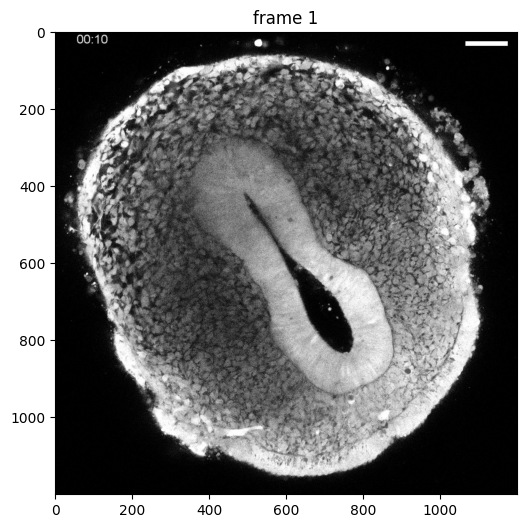

In [10]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "example_case/frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
print(frame_names)
# take a look the first video frame
frame_idx = 1
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

inference_state = predictor.init_state(video_path=video_dir)

predictor.reset_state(inference_state)

Locate region through a rectangle

In [11]:
predictor.reset_state(inference_state)

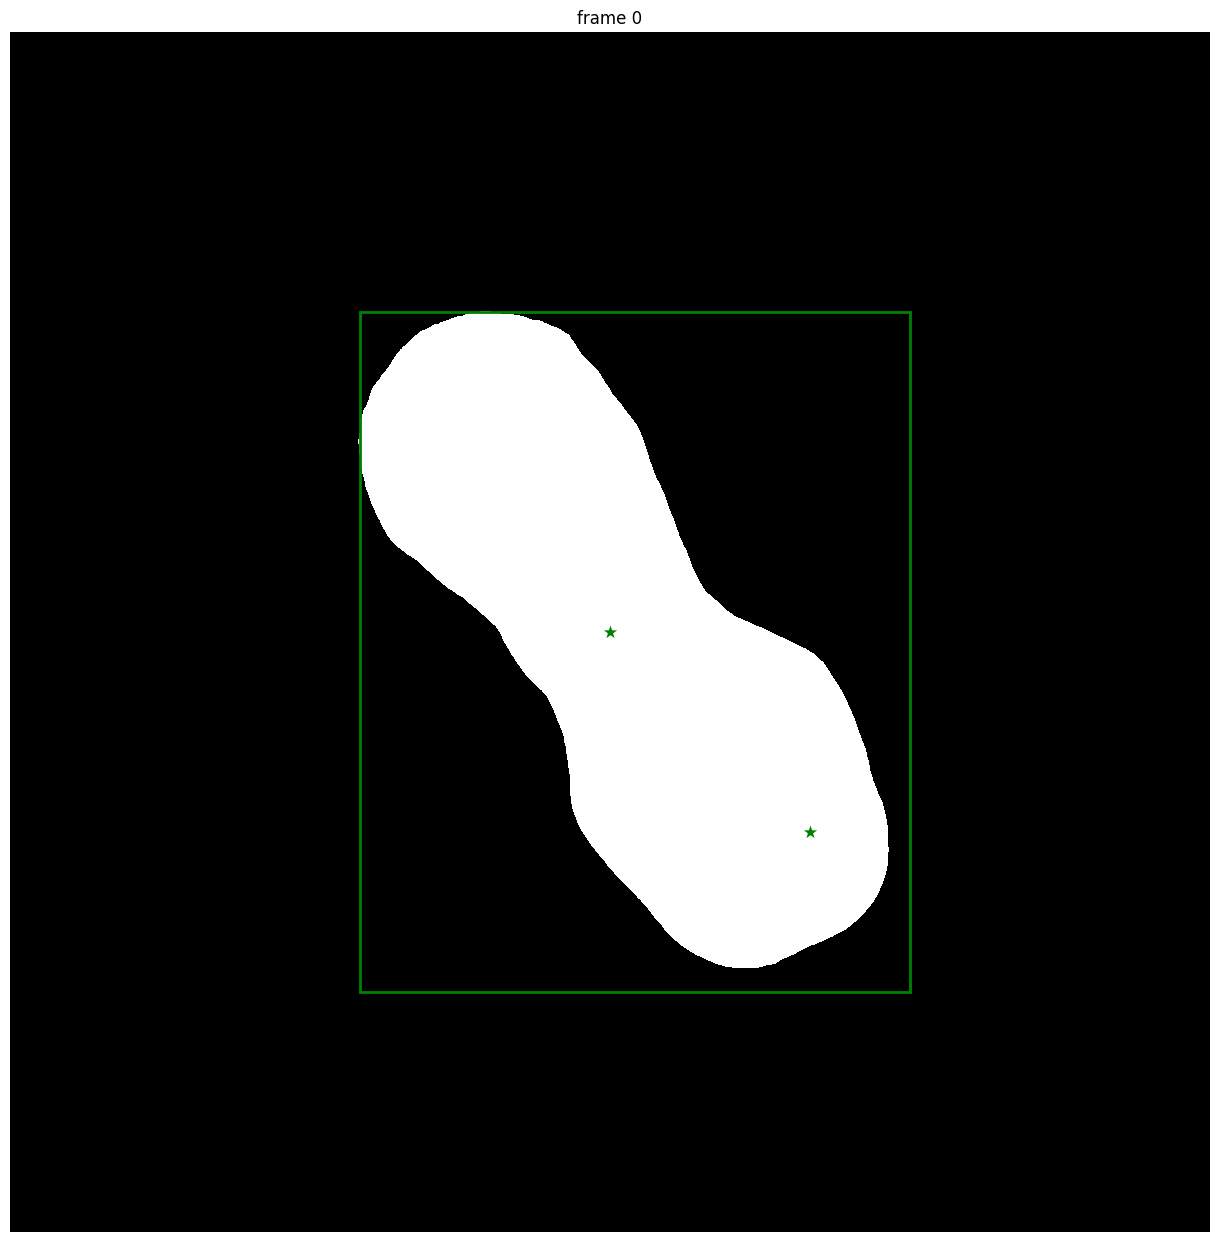

In [23]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (460, 60) to refine the mask
points = np.array([[600, 600], [800, 800]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
# note that we also need to send the original box input along with
# the new refinement click together into `add_new_points_or_box`
box = np.array([350, 280, 900, 960], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

Save processed images

propagate in video: 100%|██████████| 105/105 [00:03<00:00, 26.27it/s]
/tmp/ipykernel_223263/4254607565.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


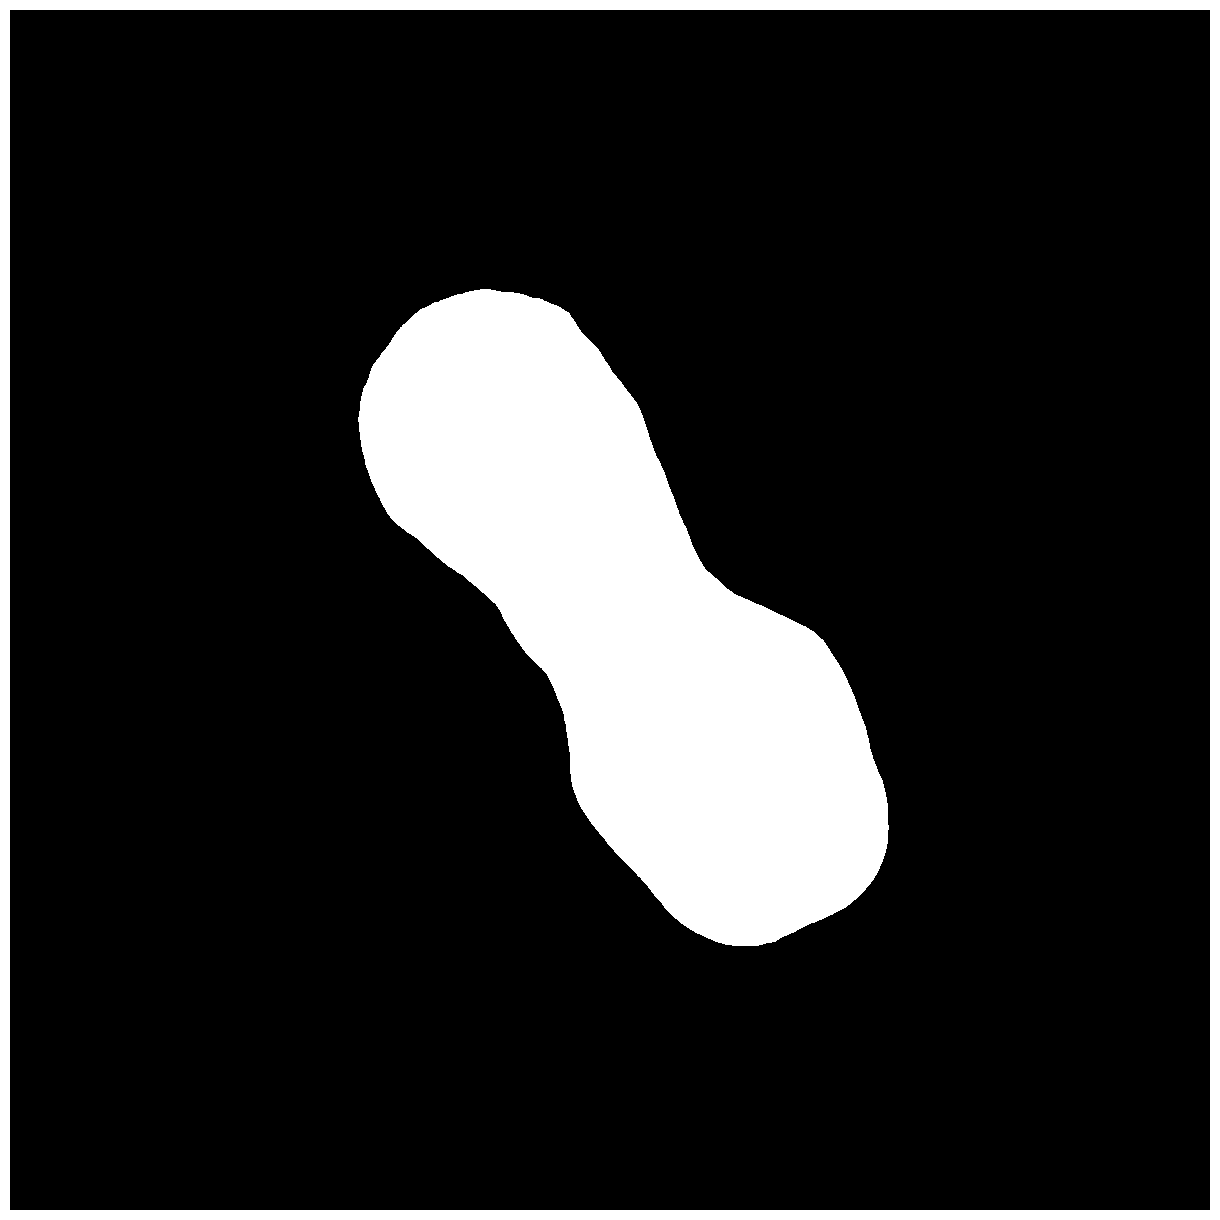

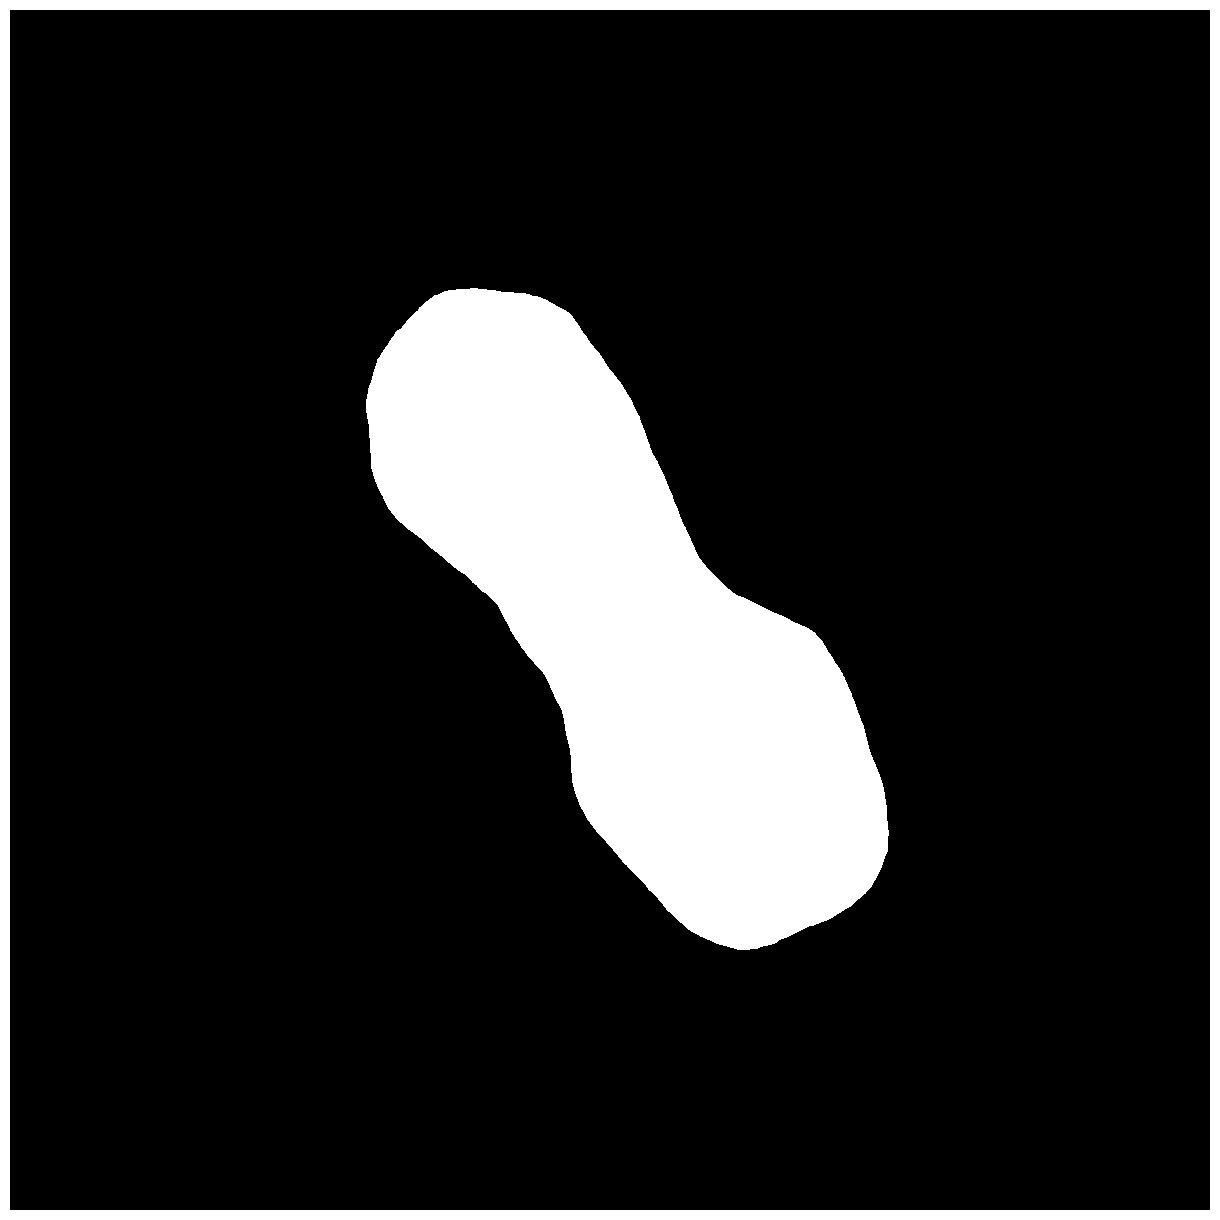

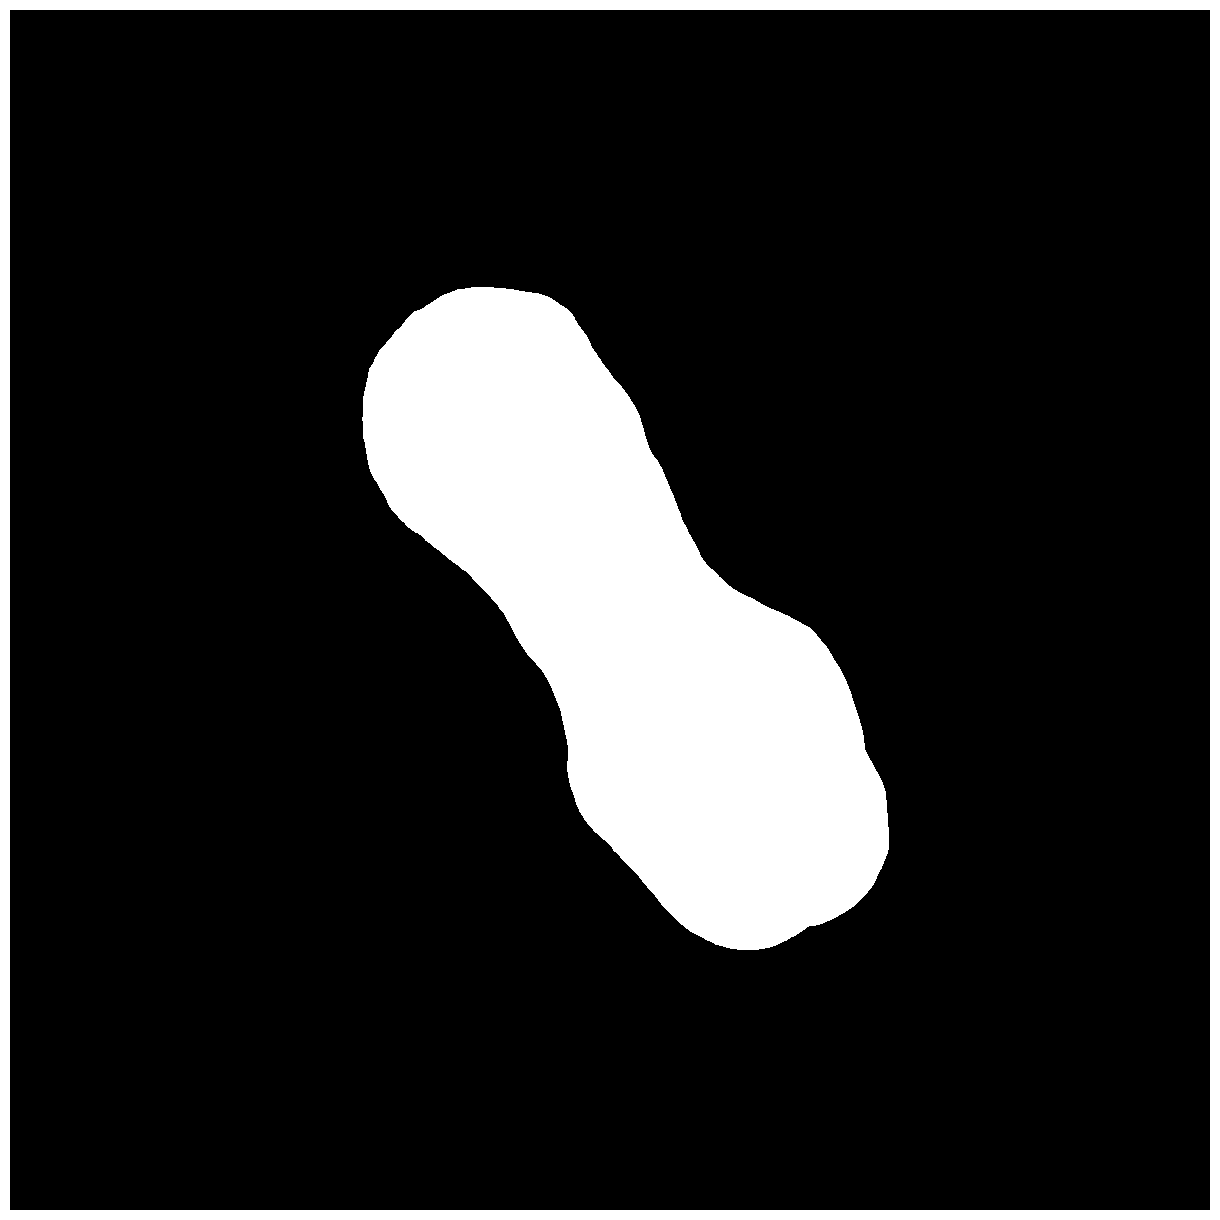

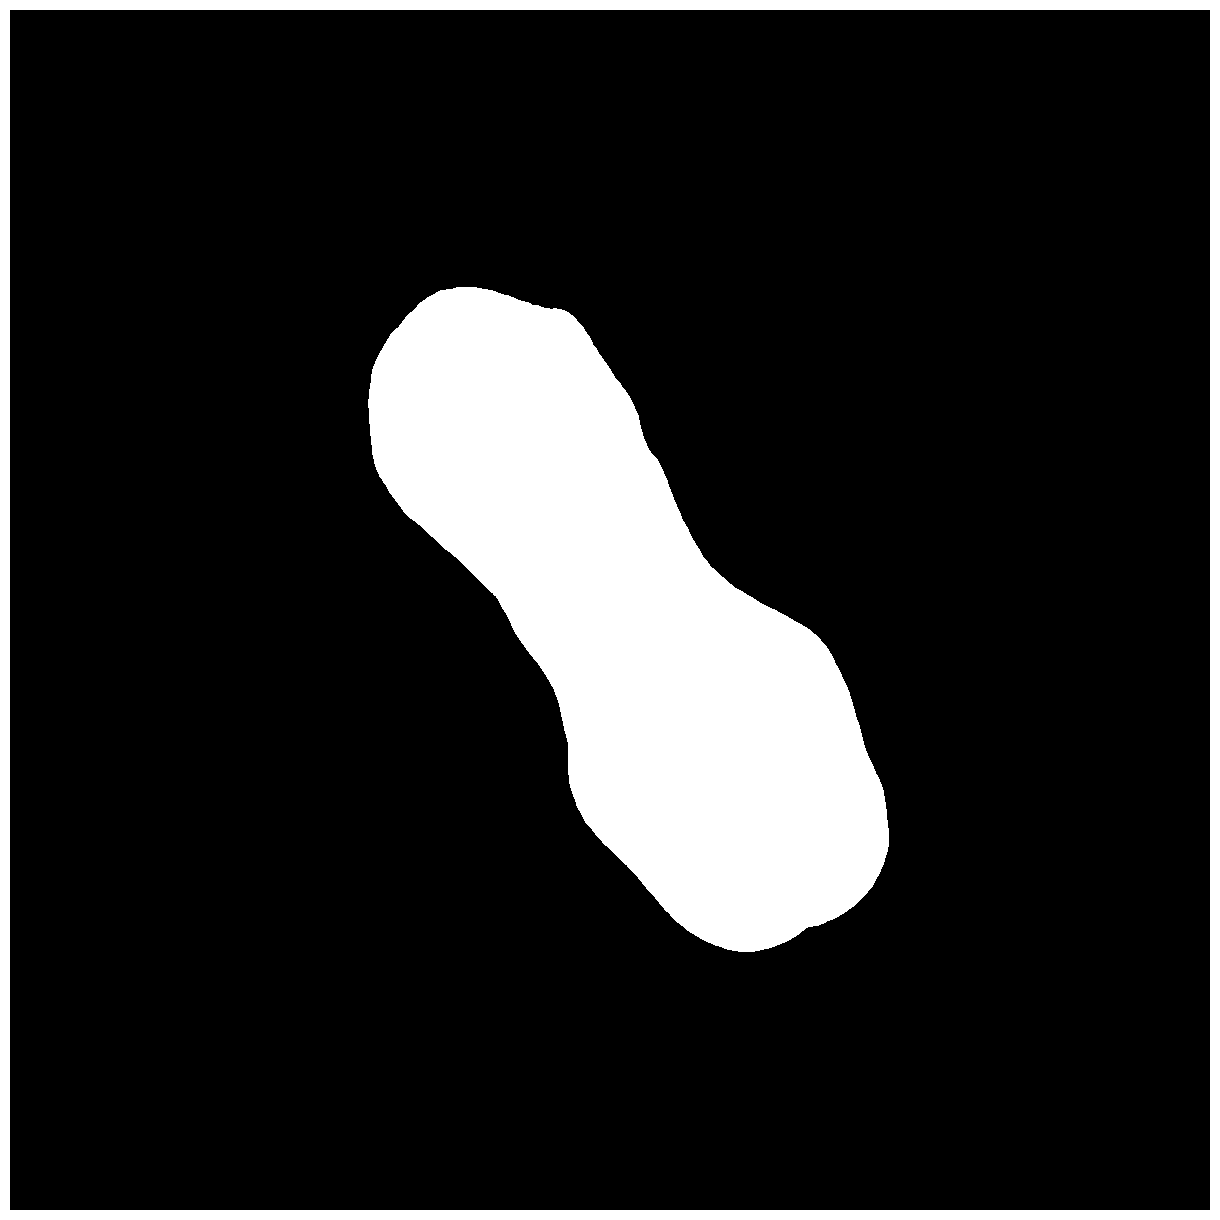

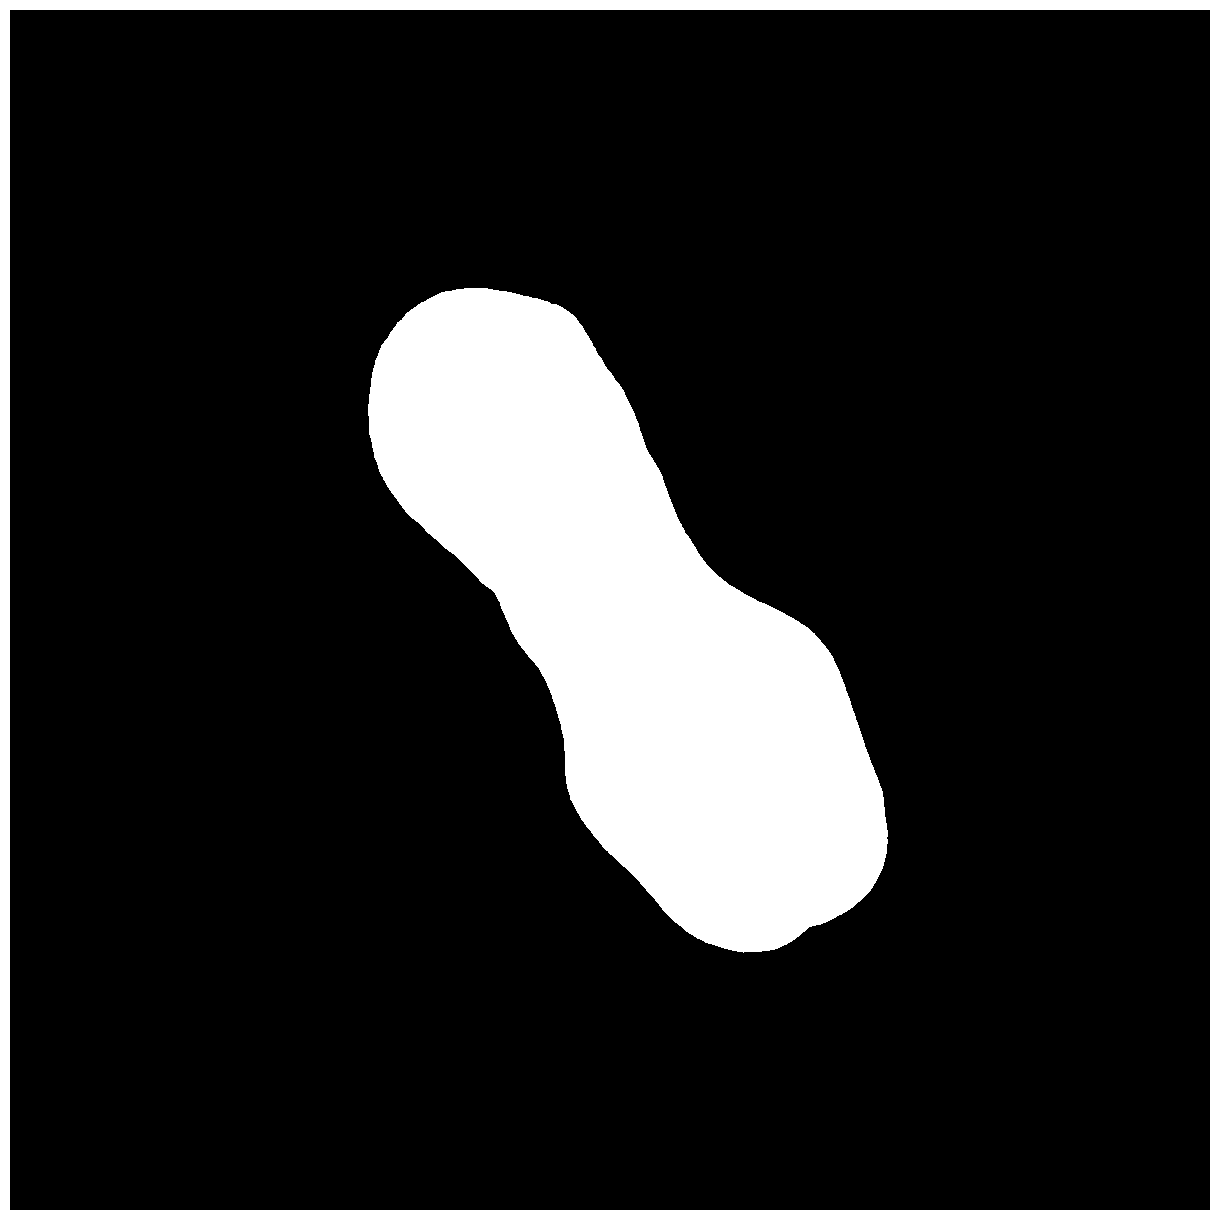

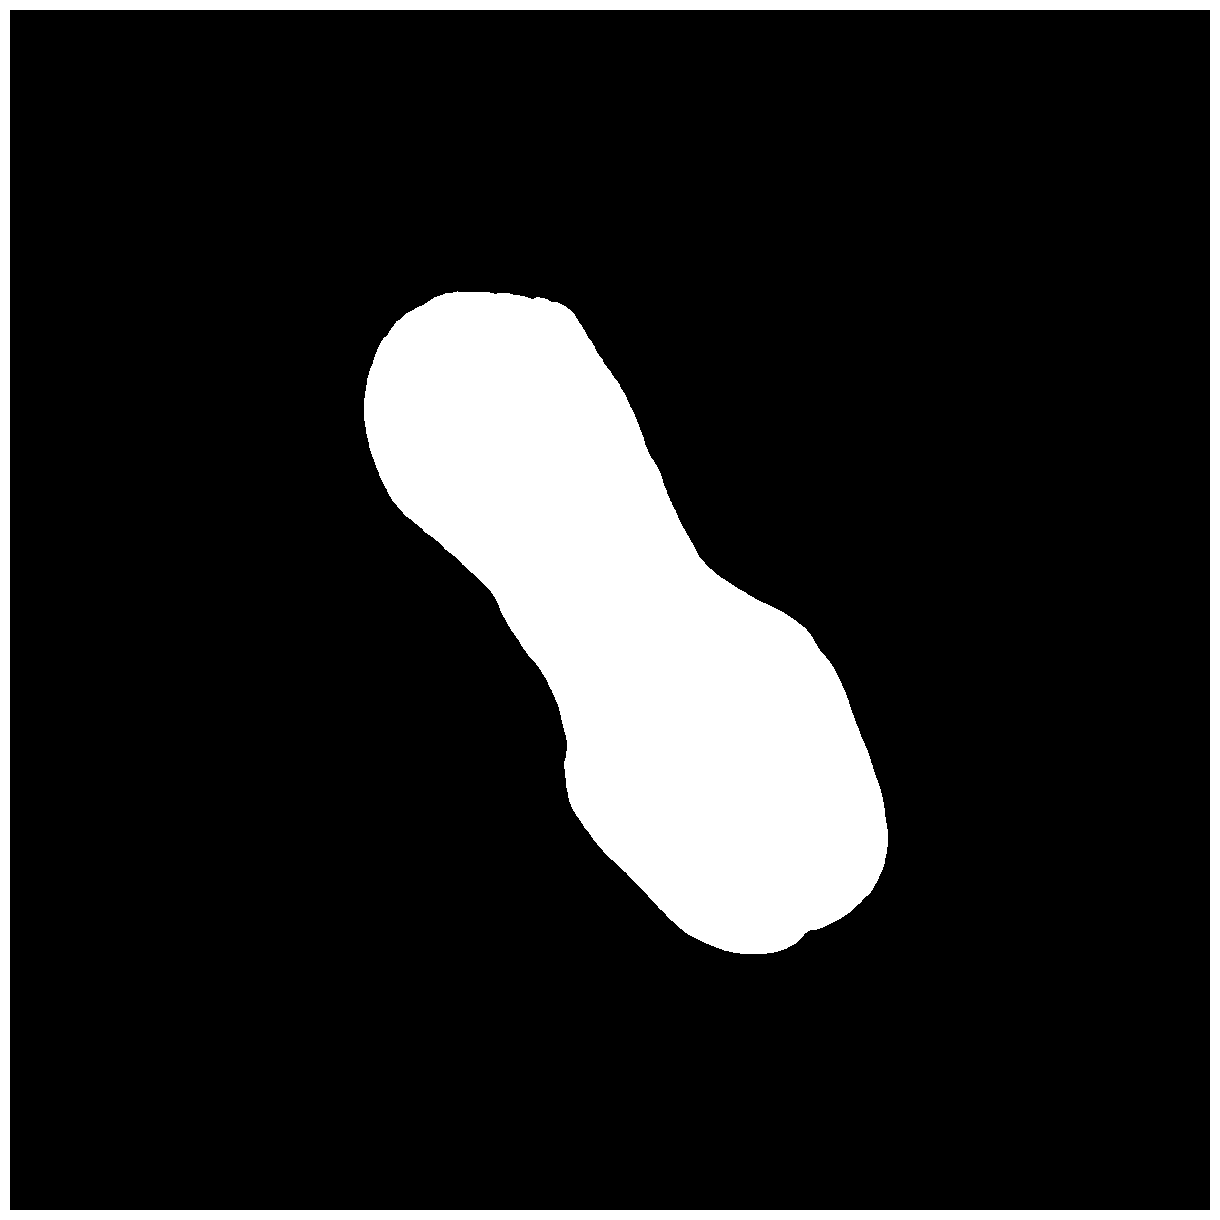

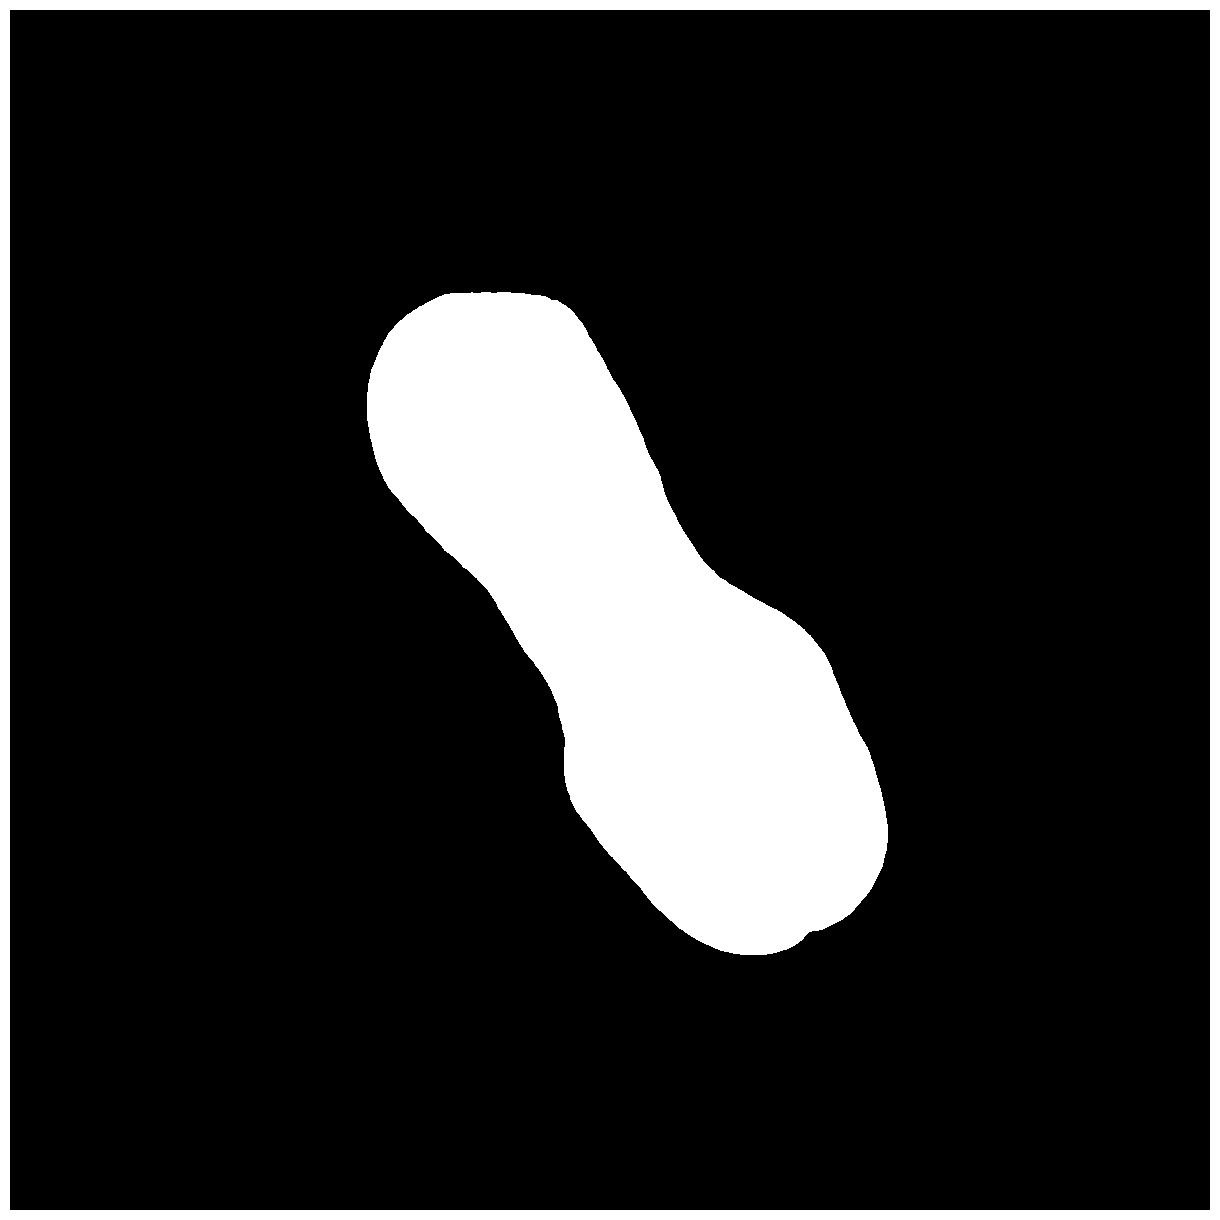

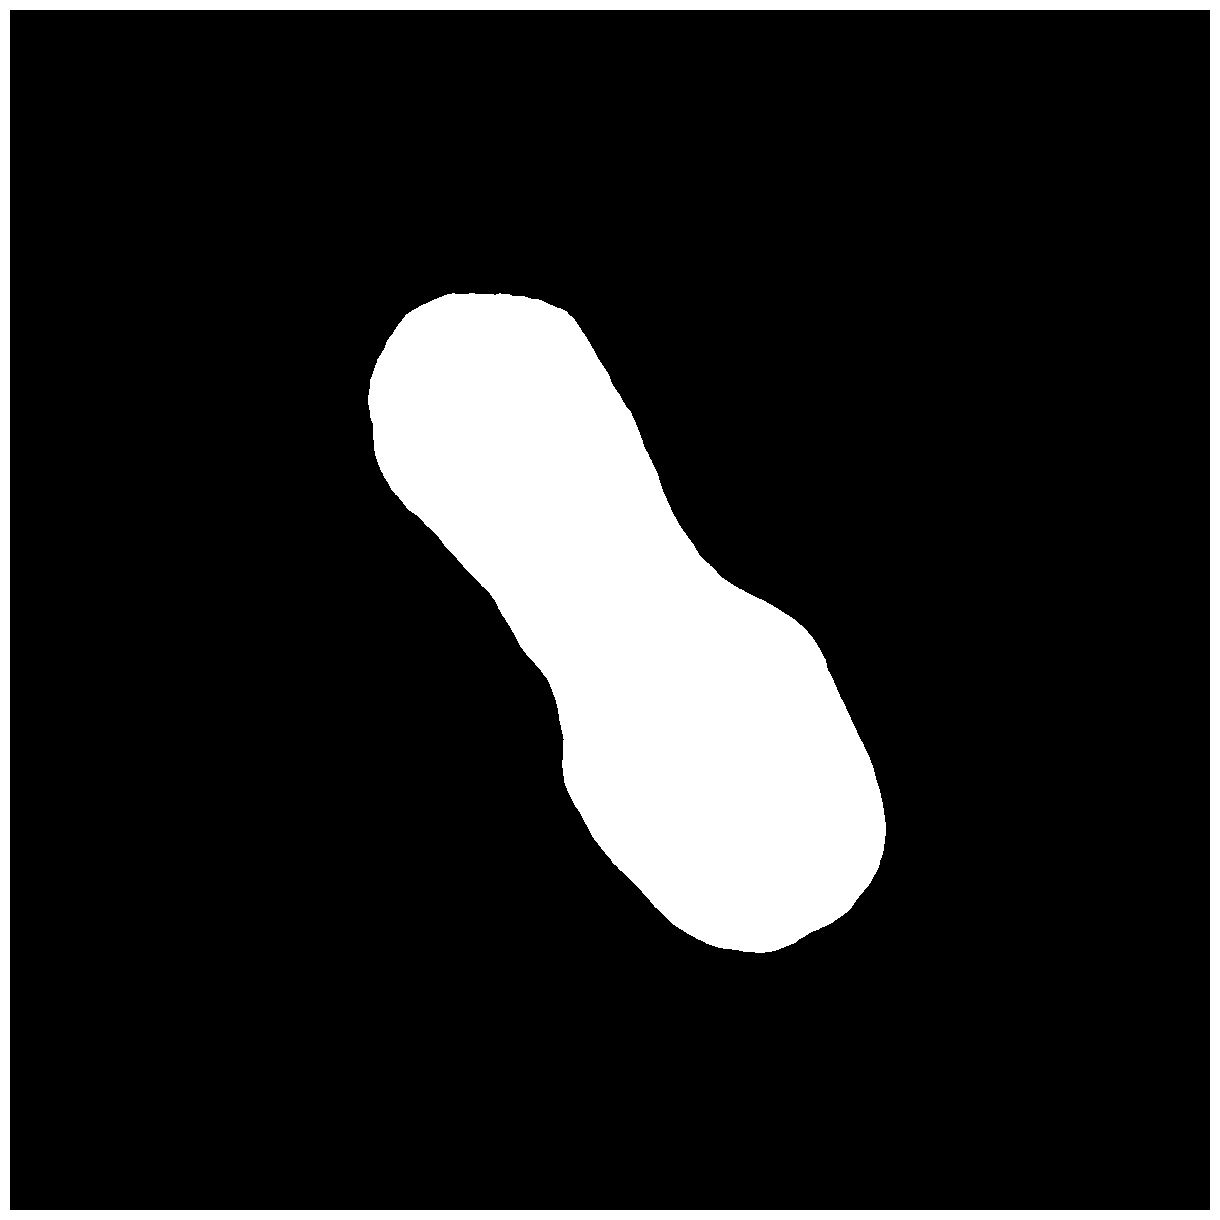

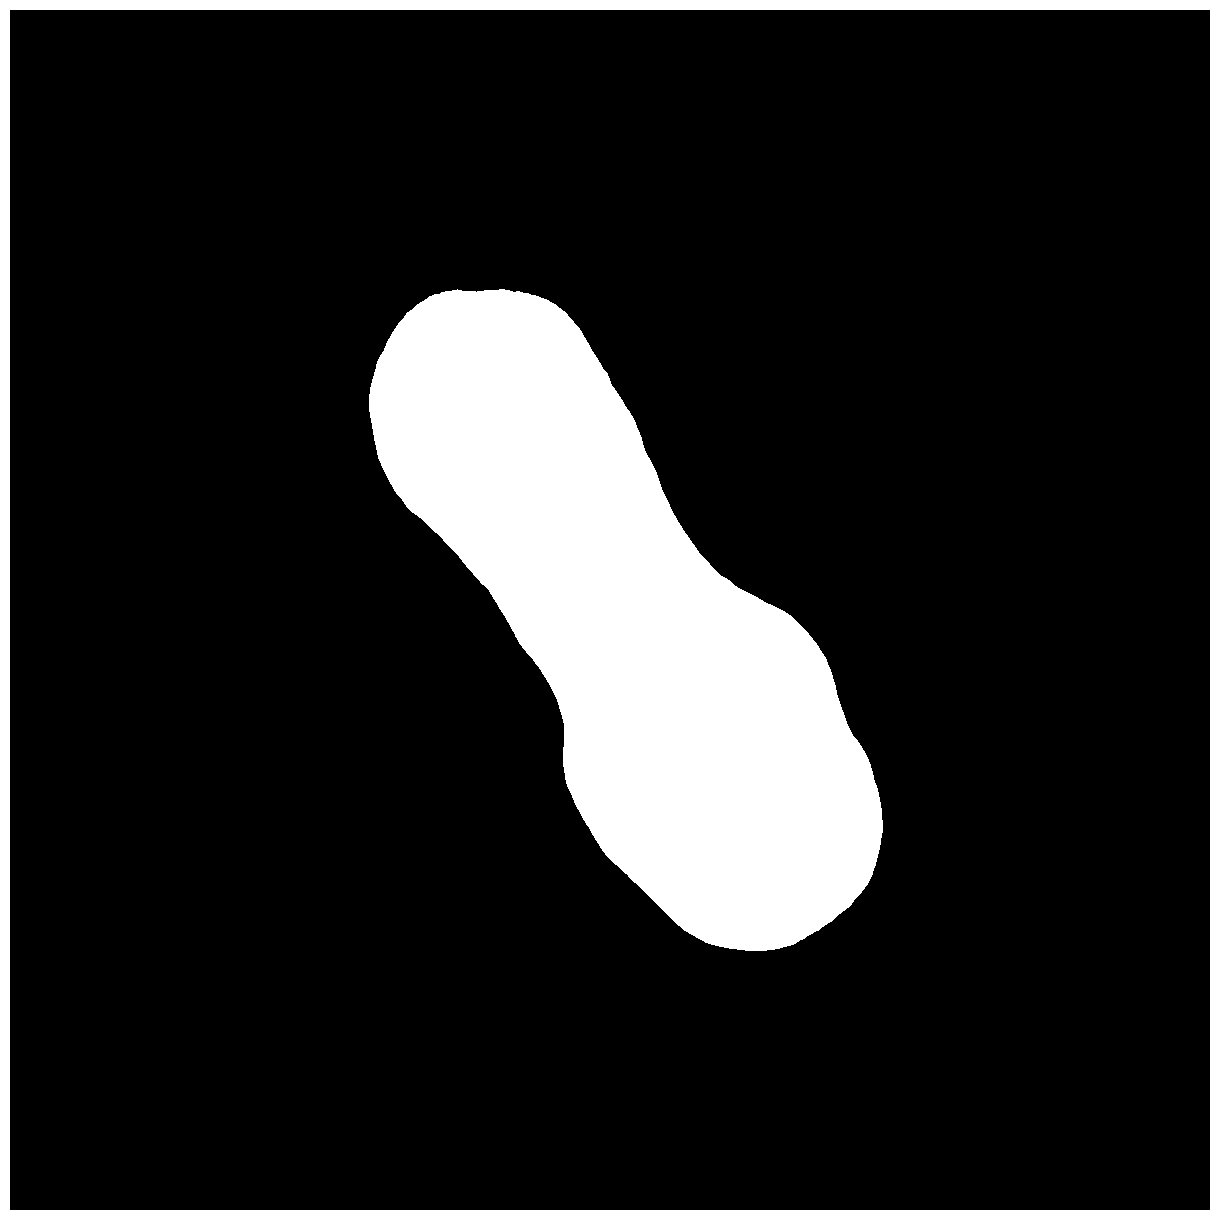

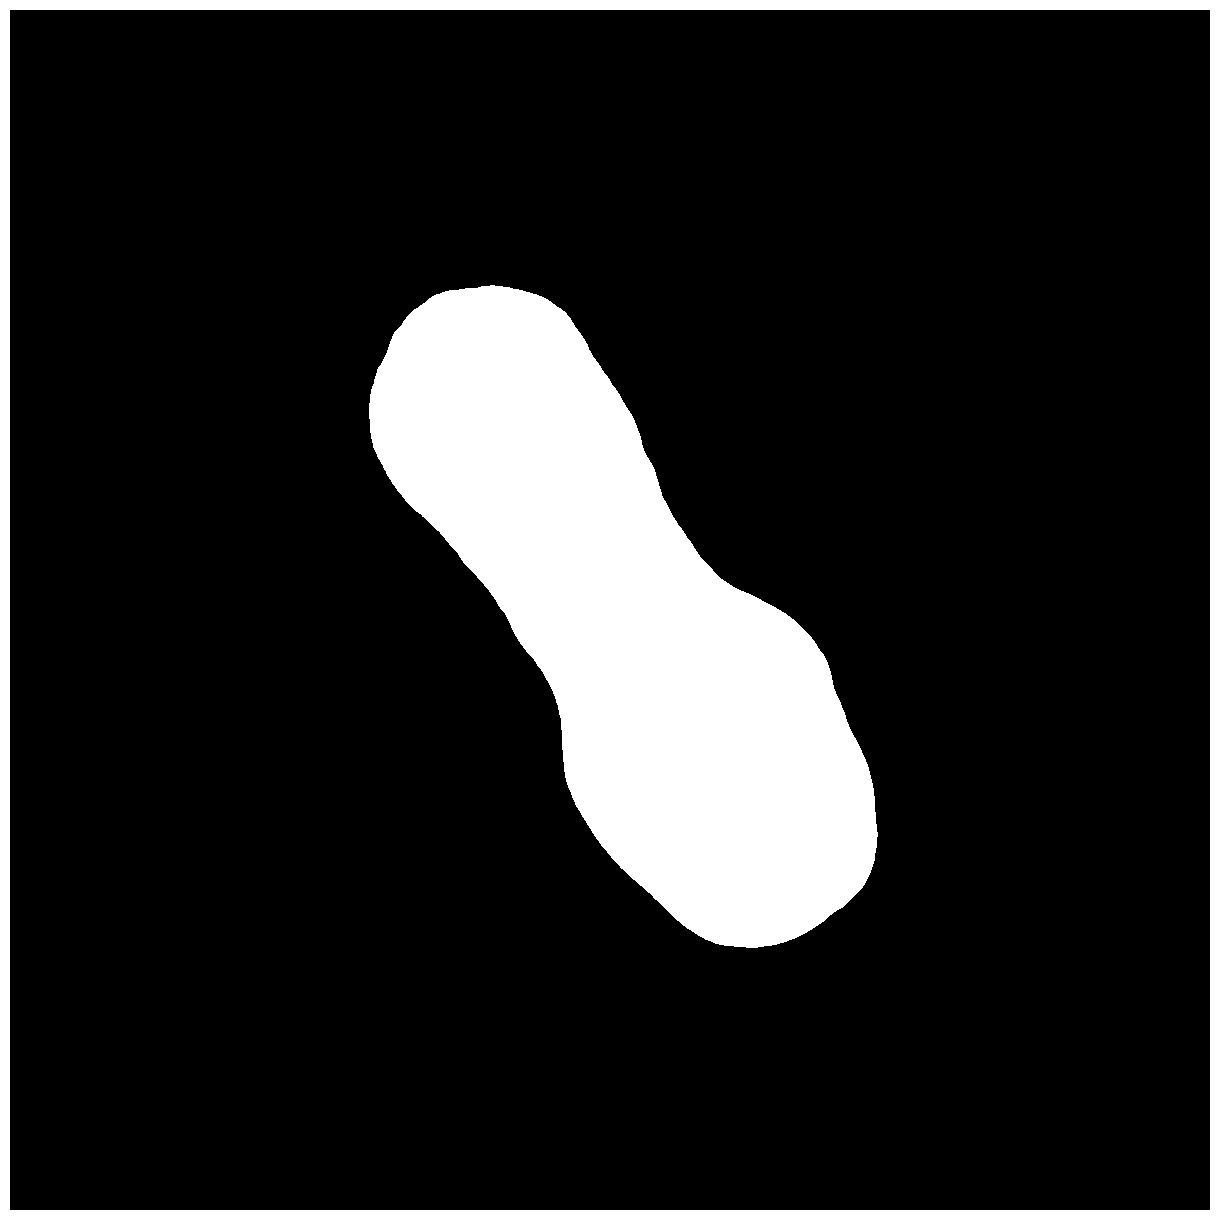

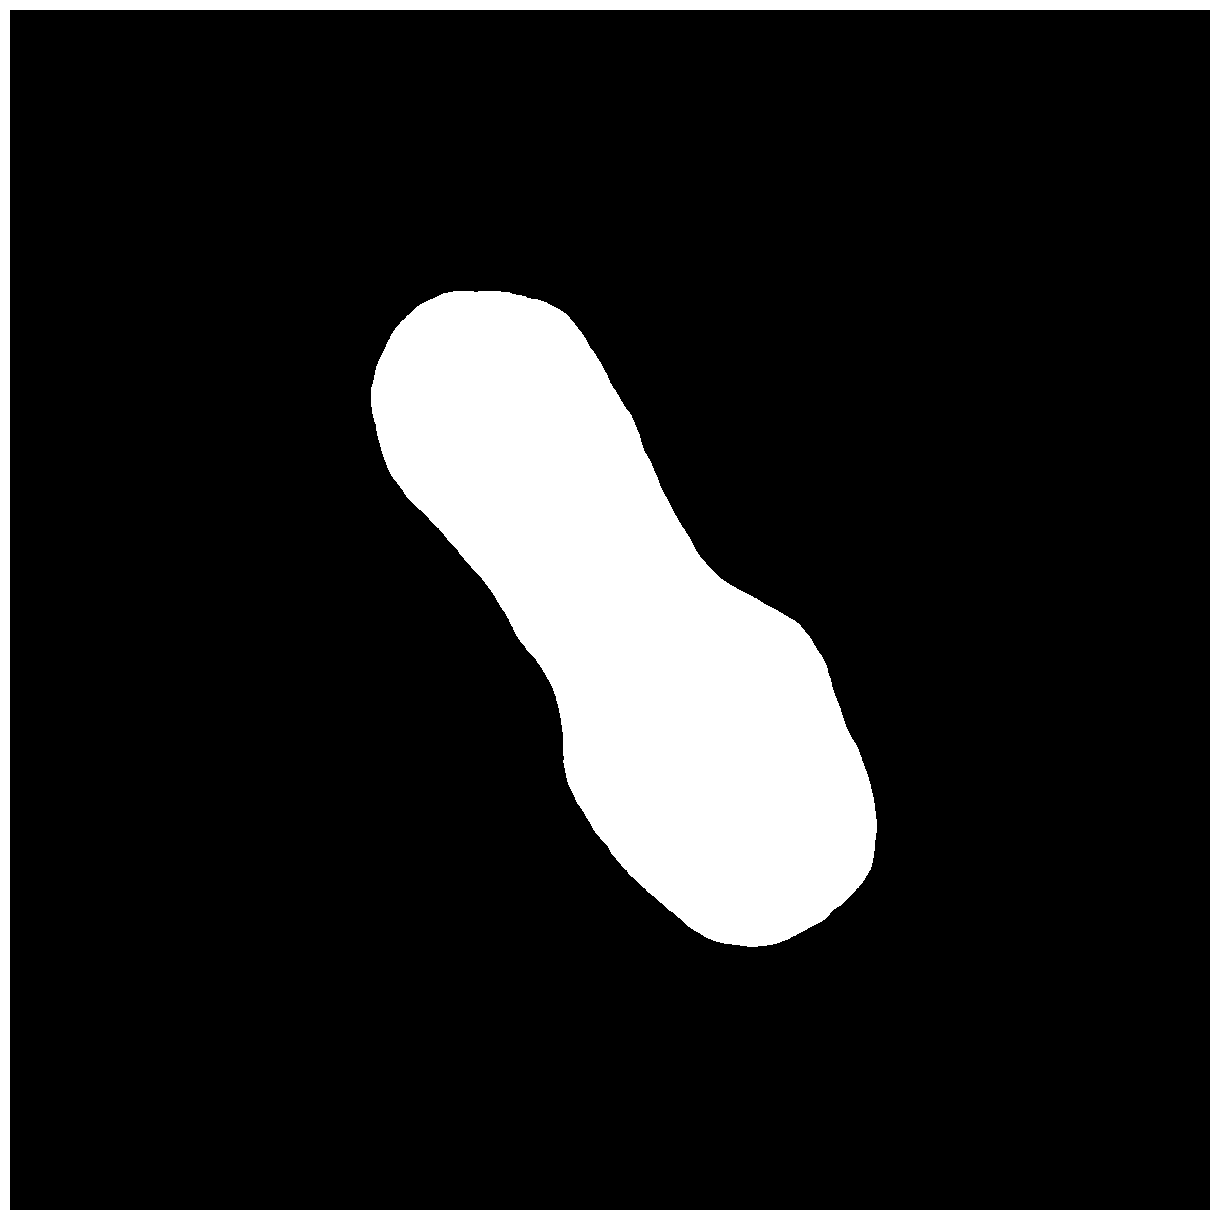

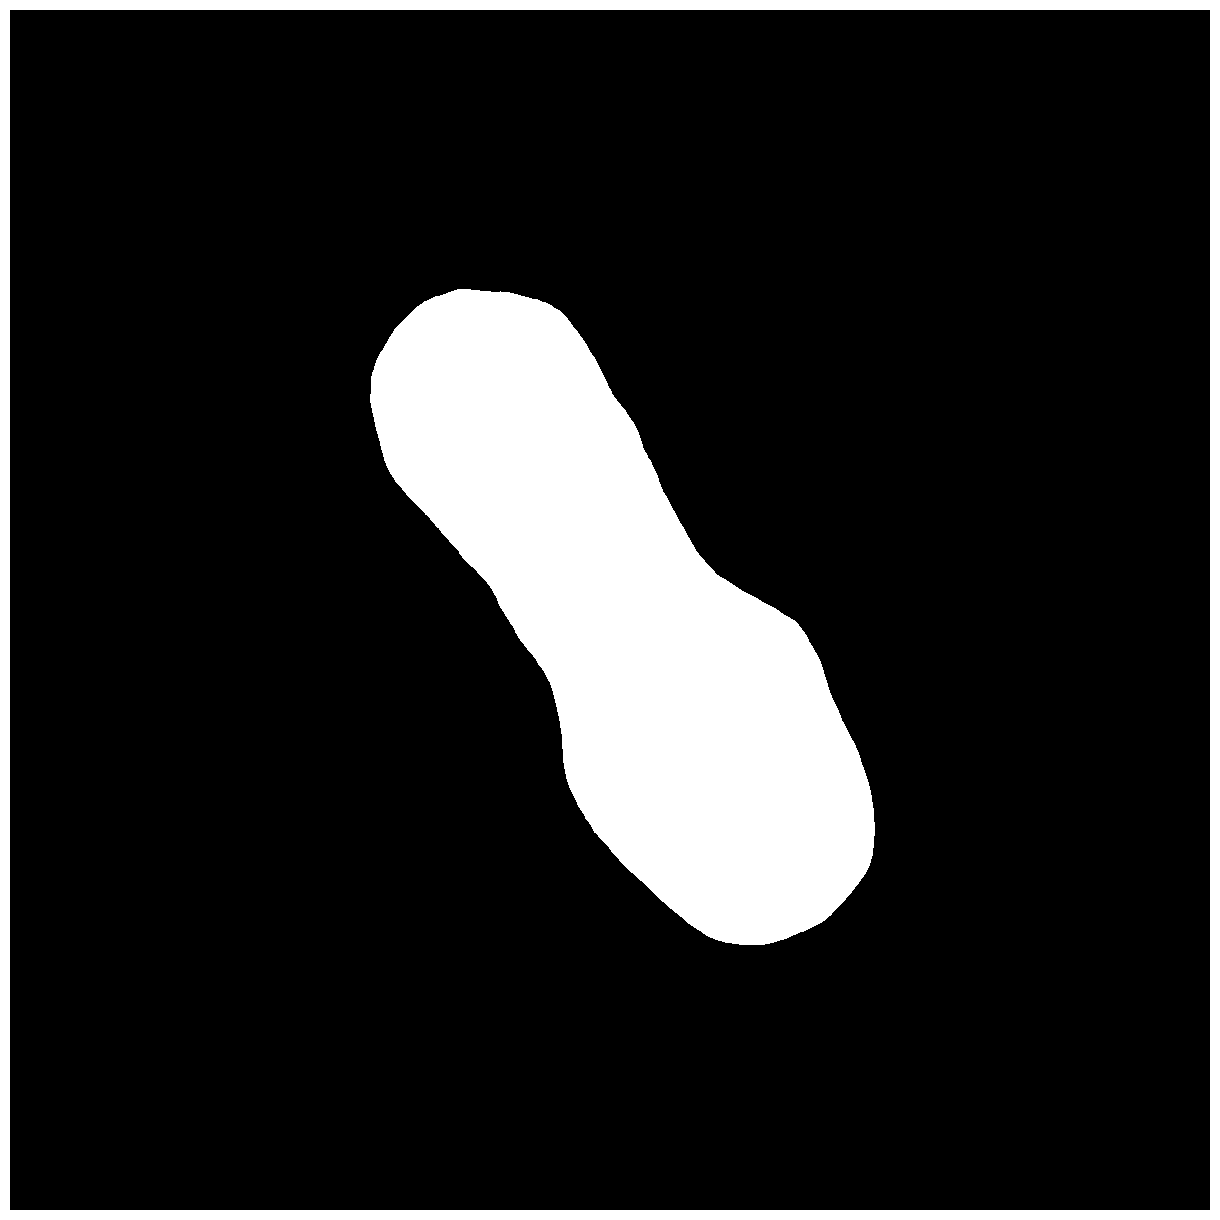

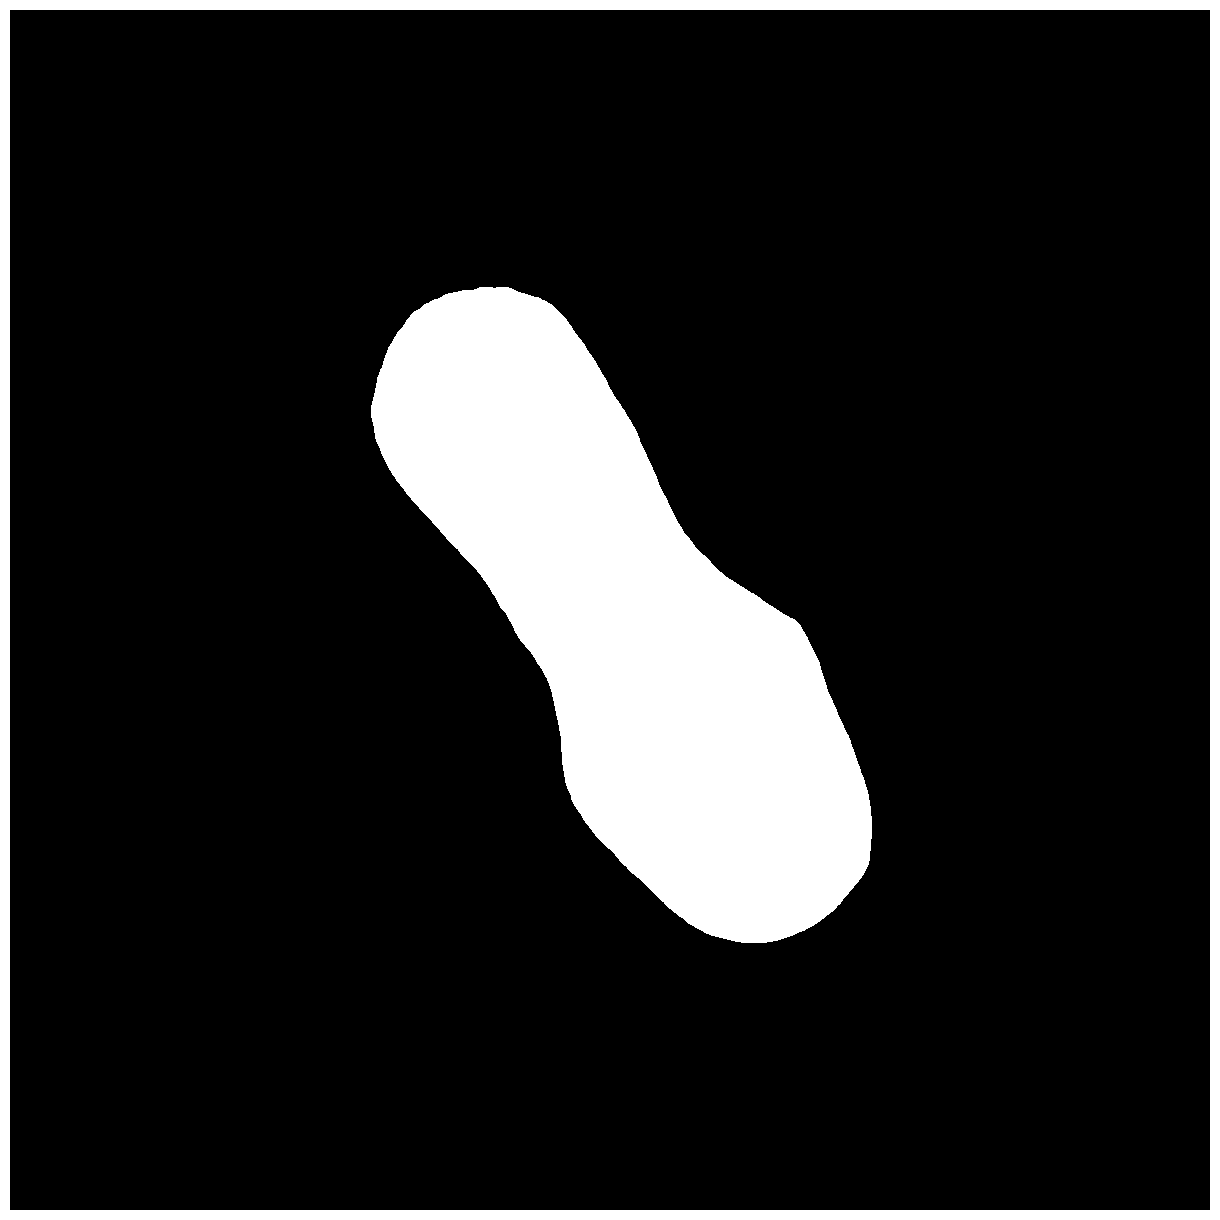

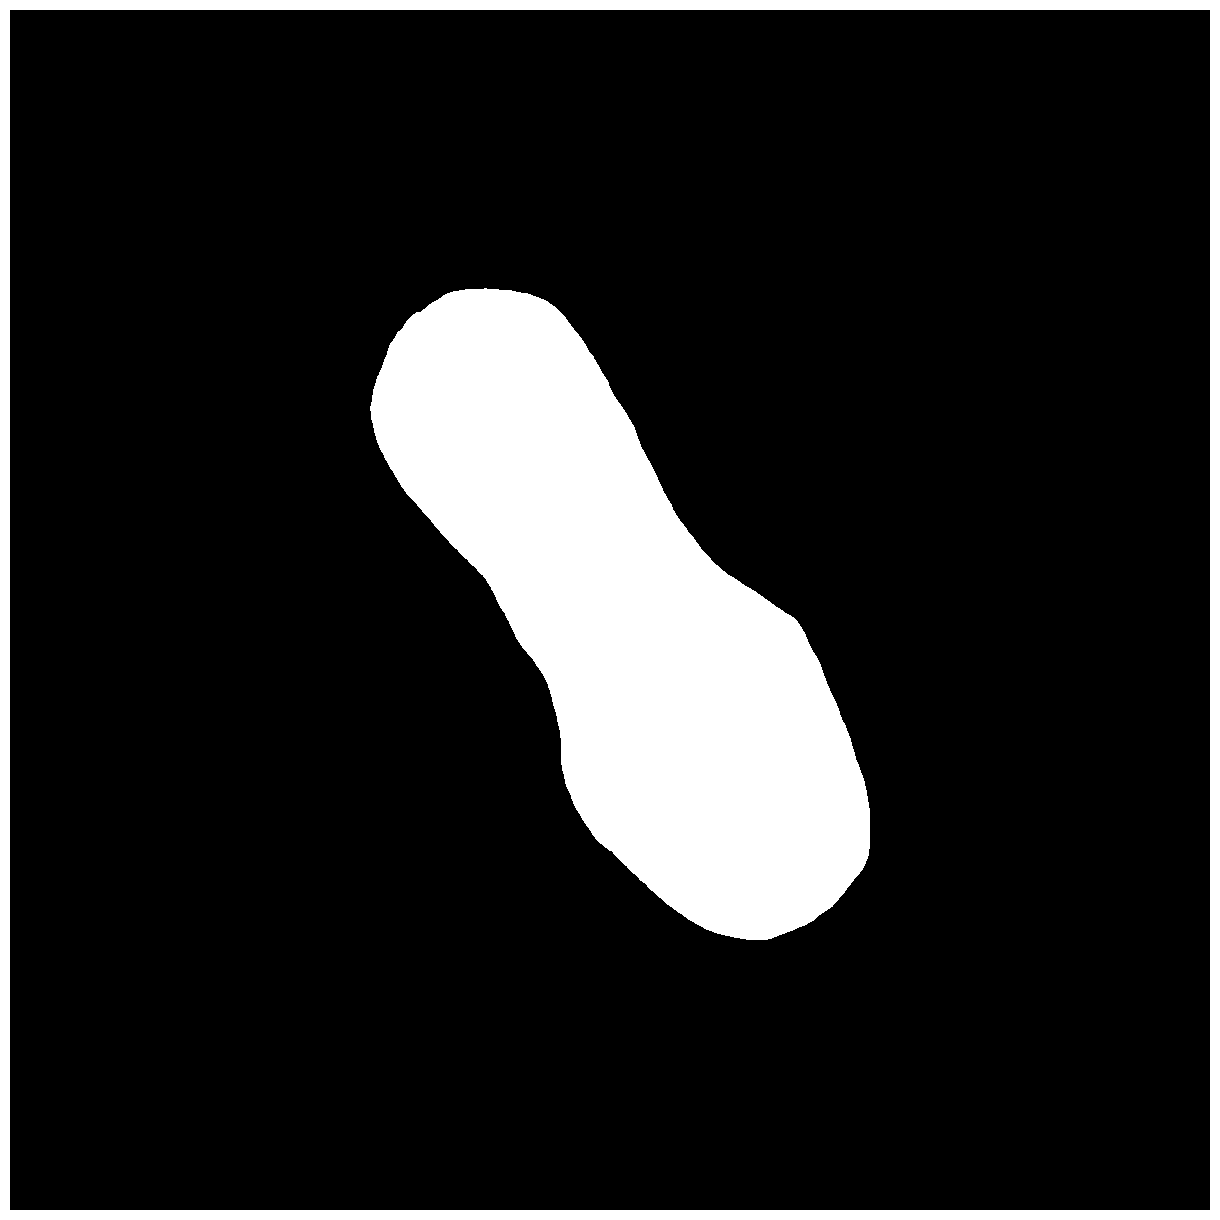

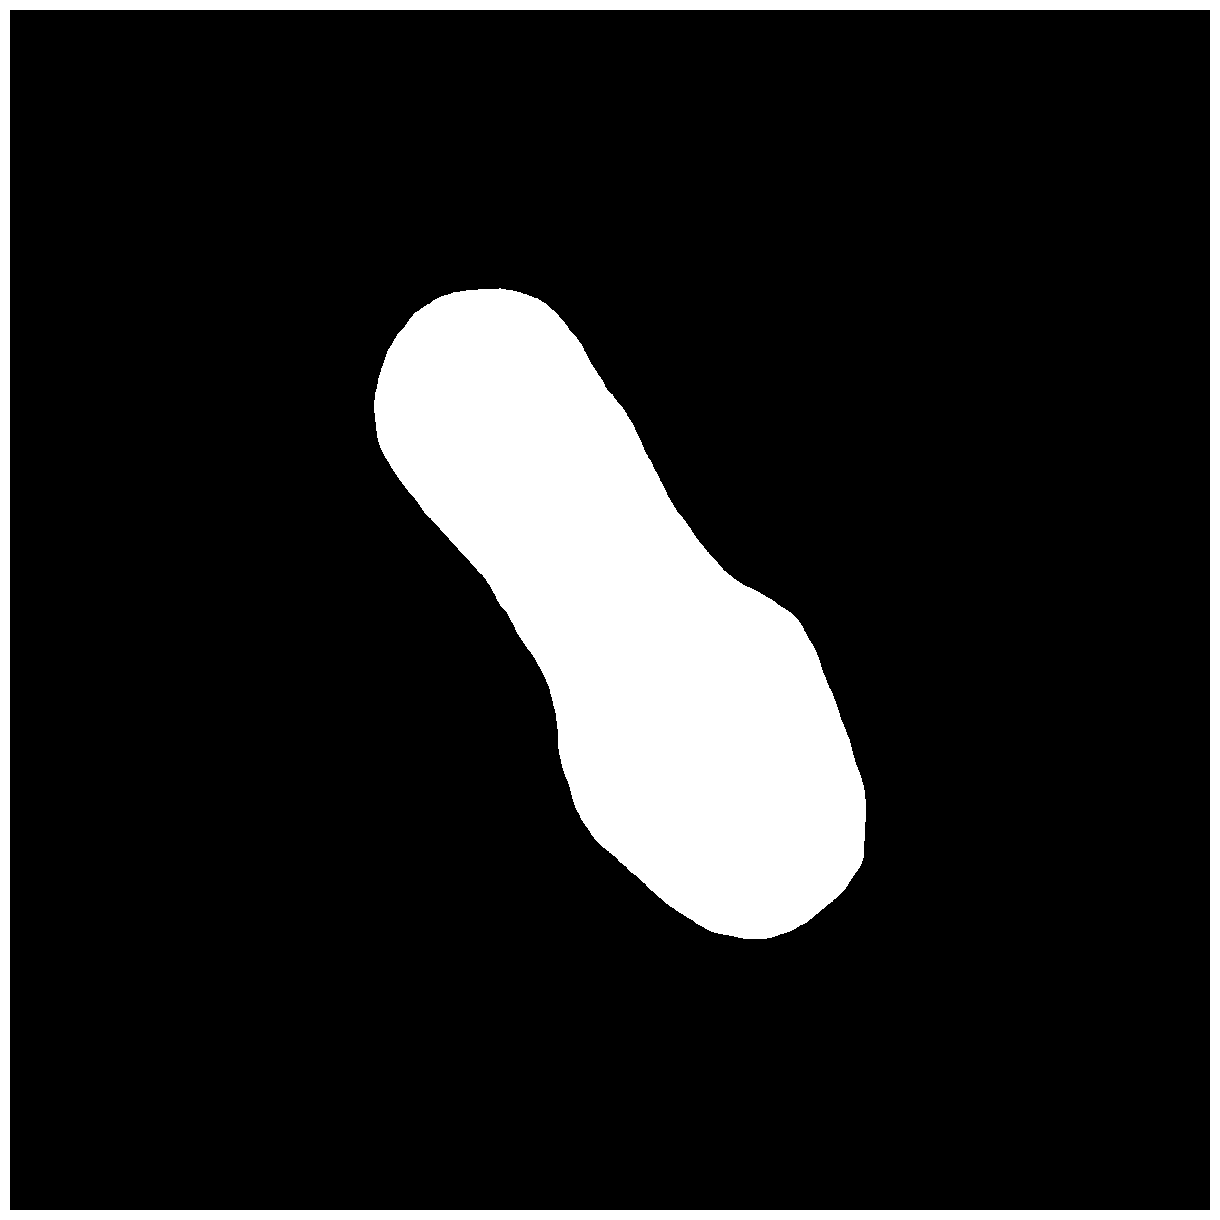

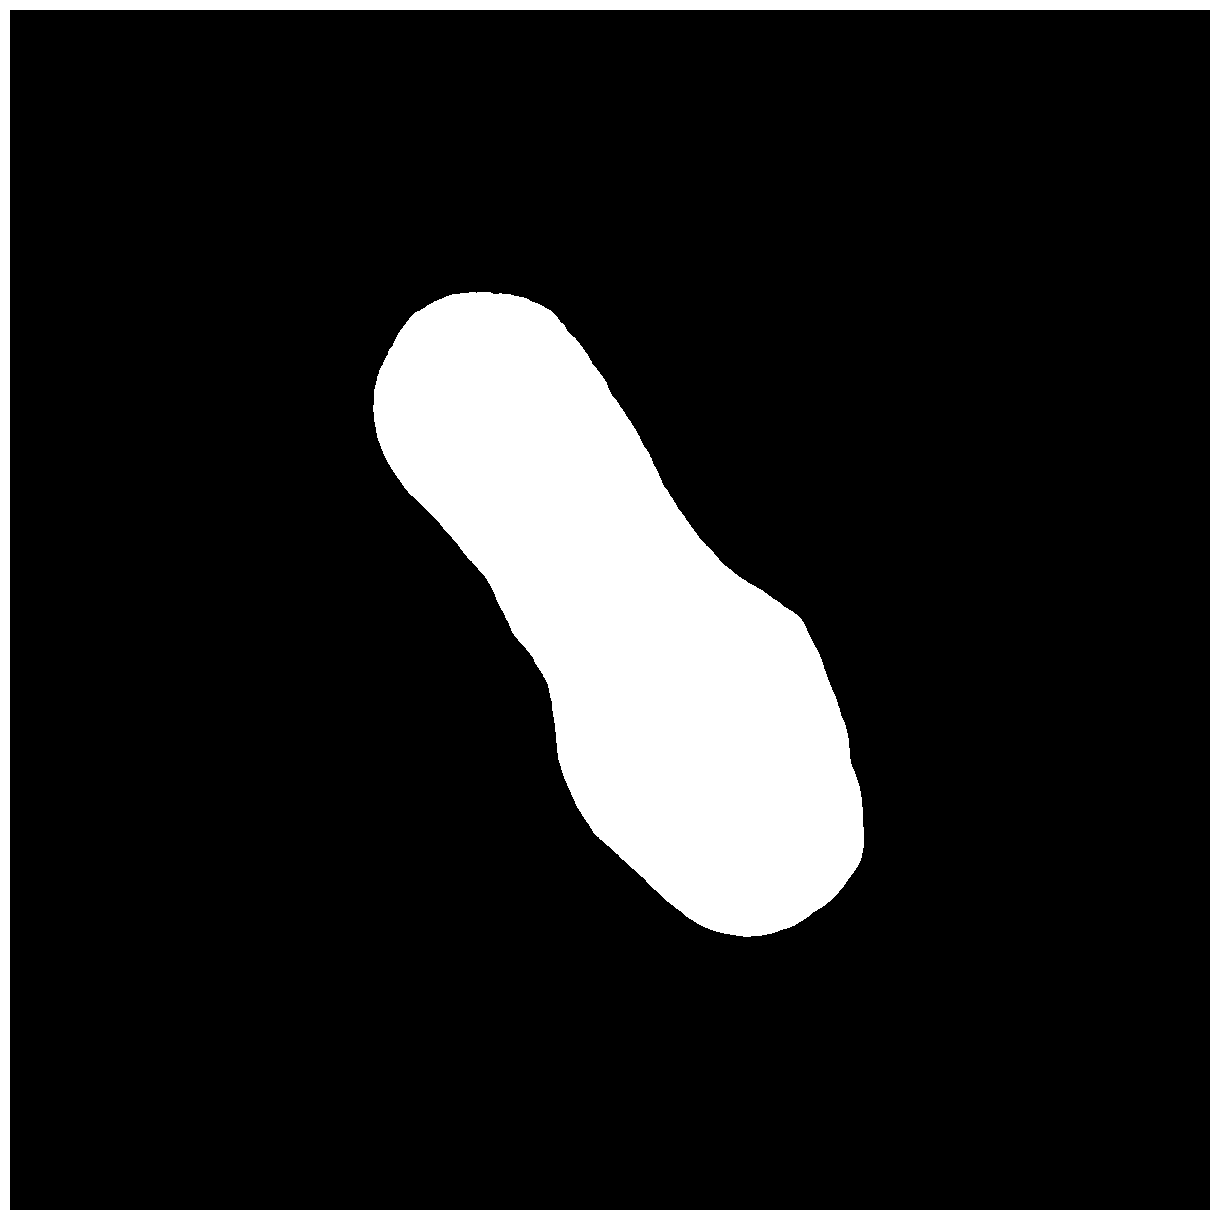

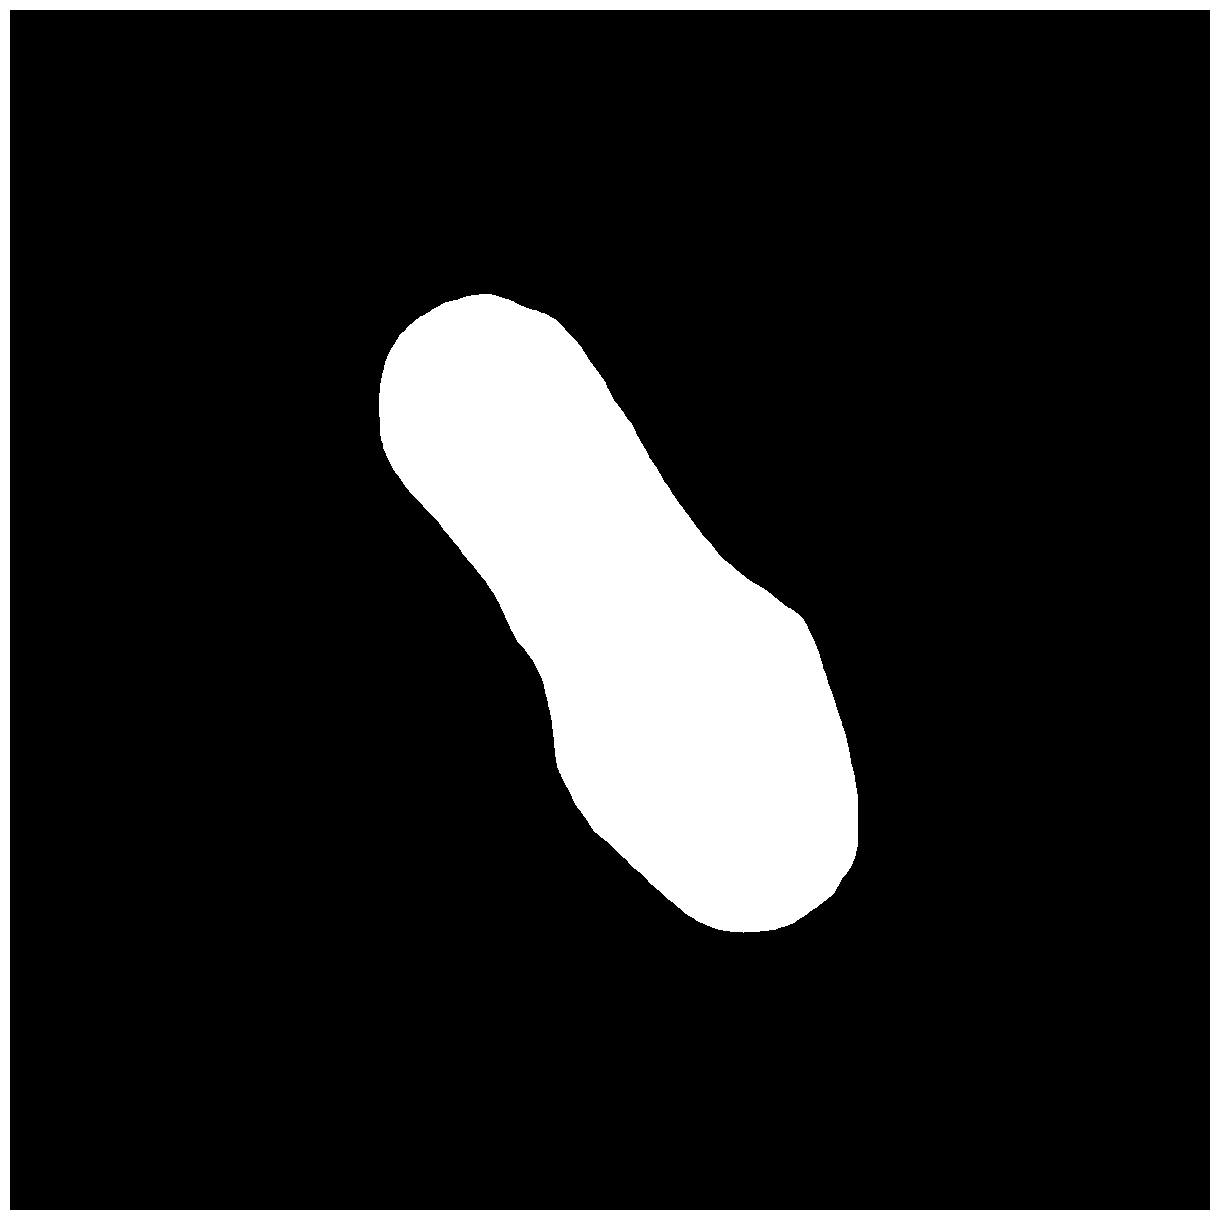

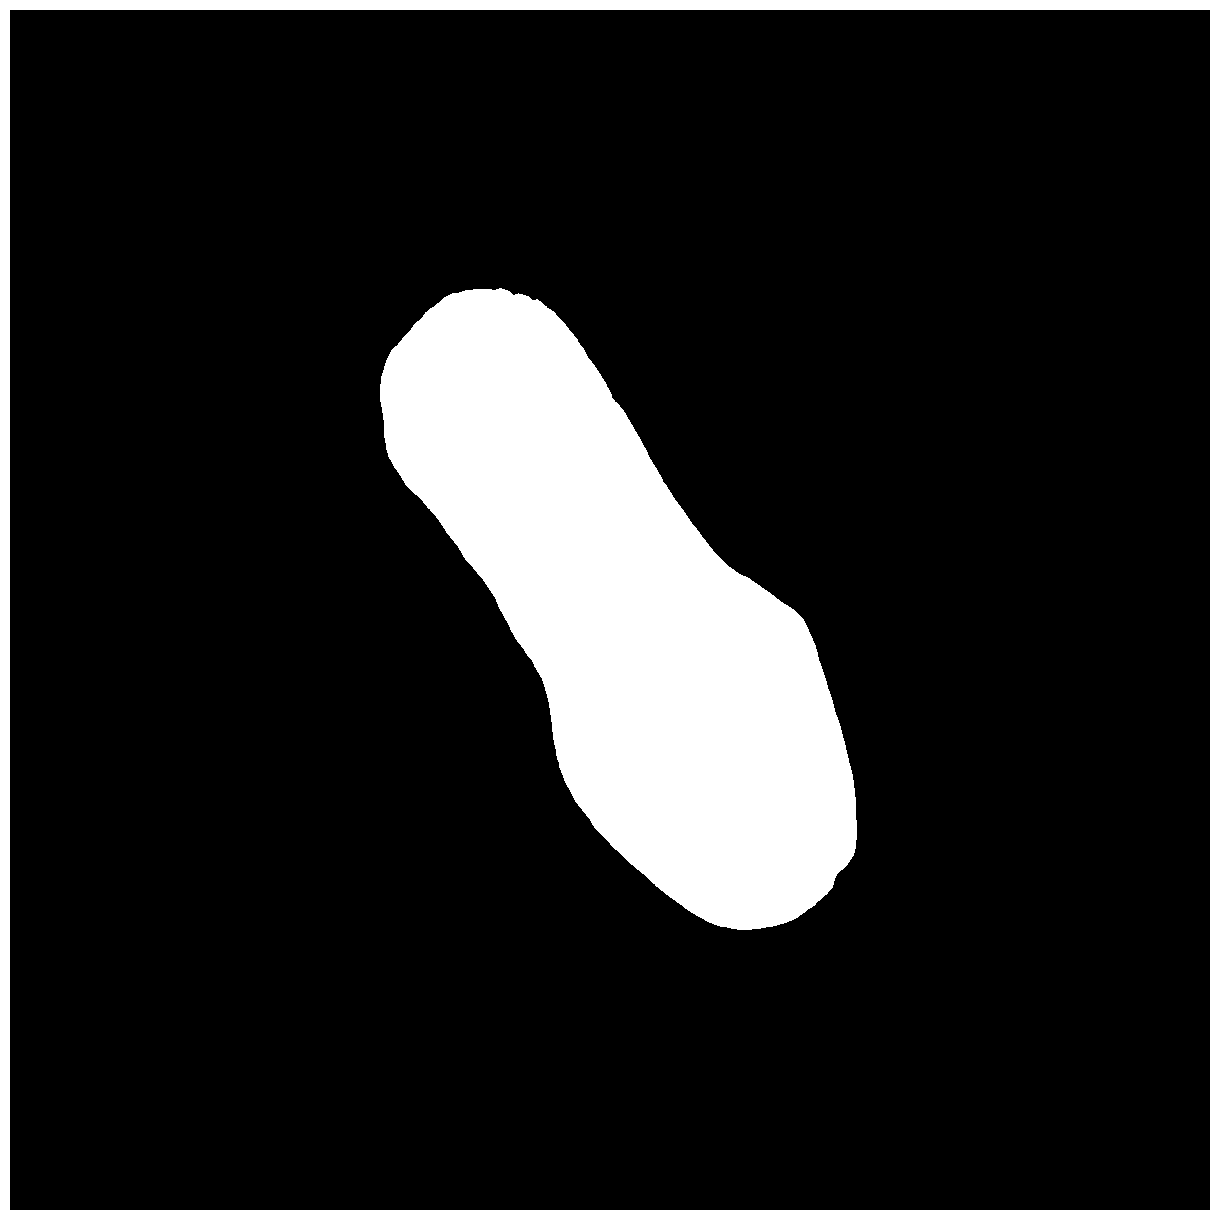

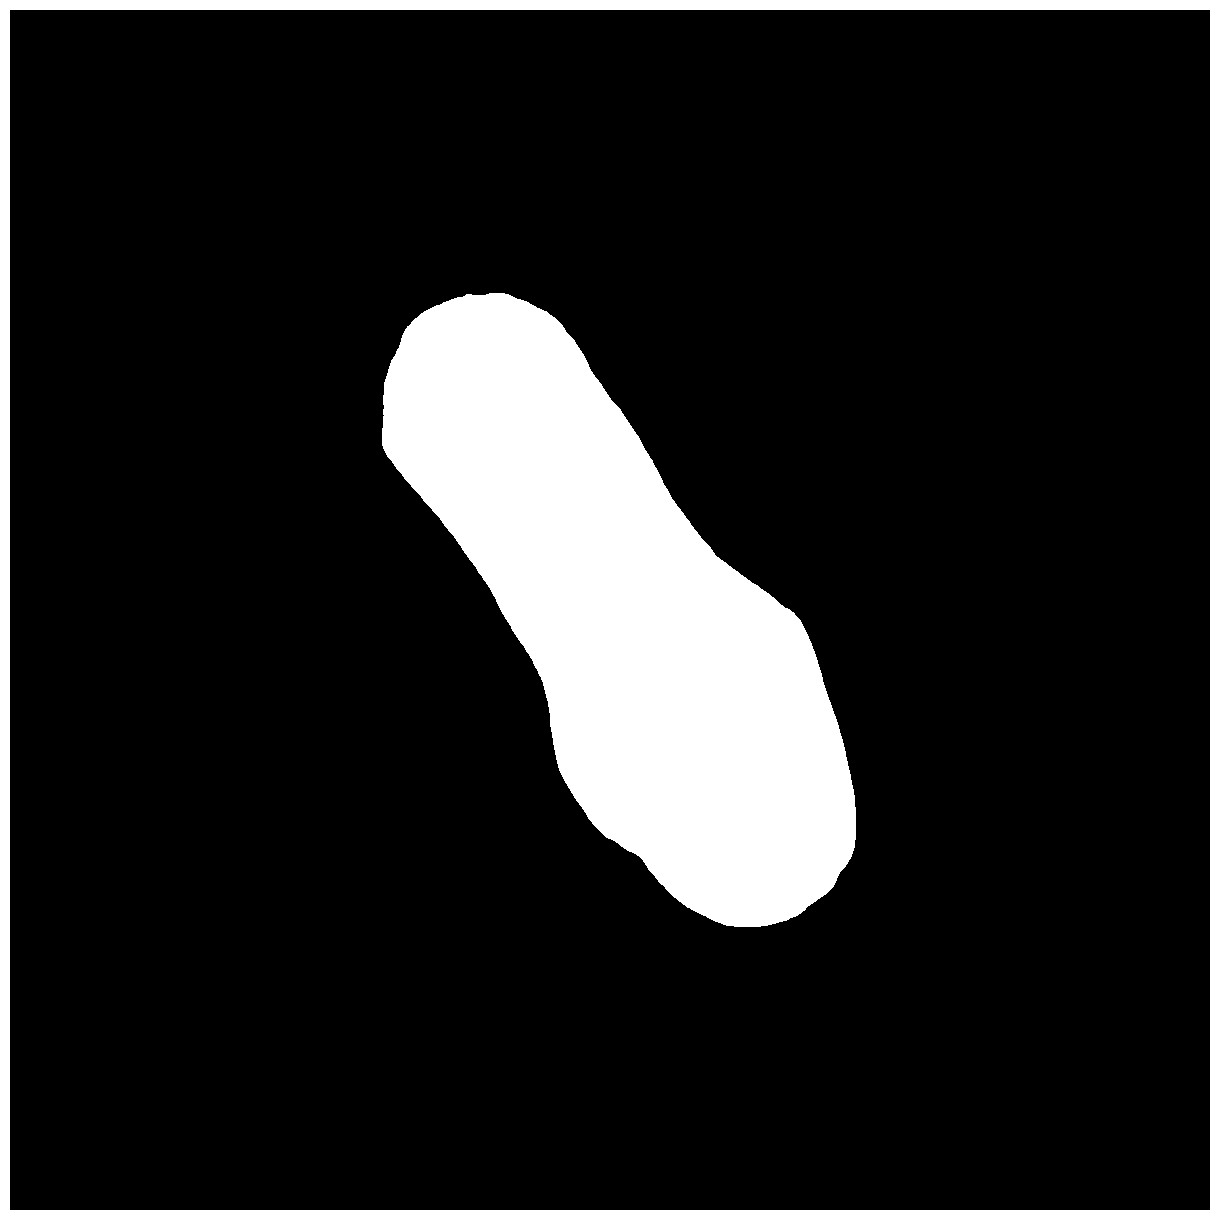

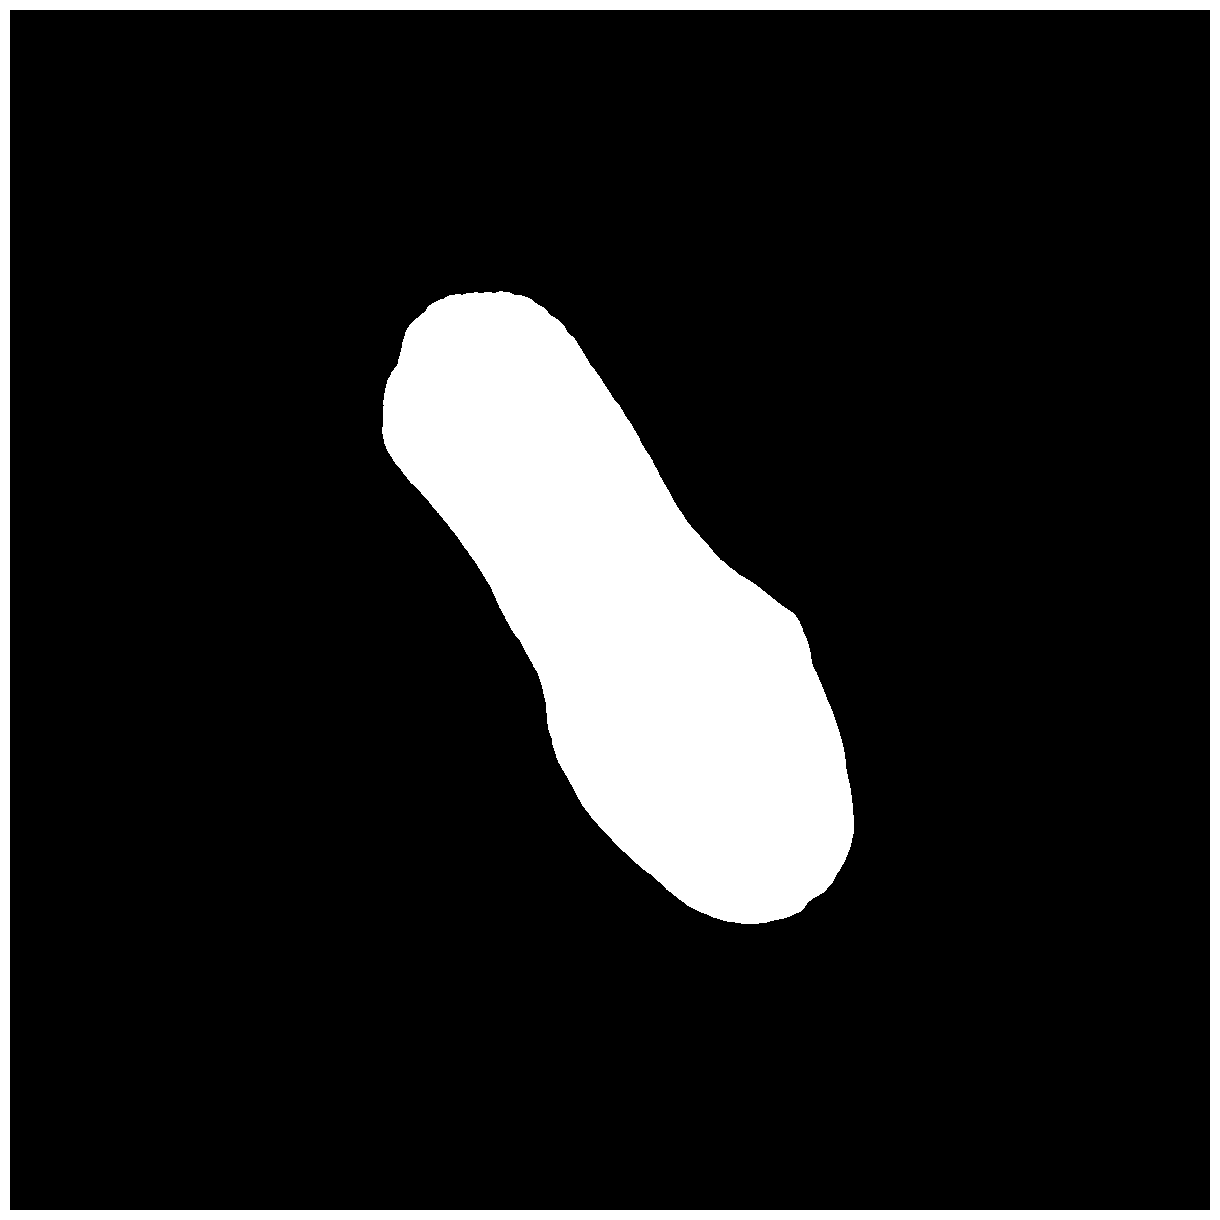

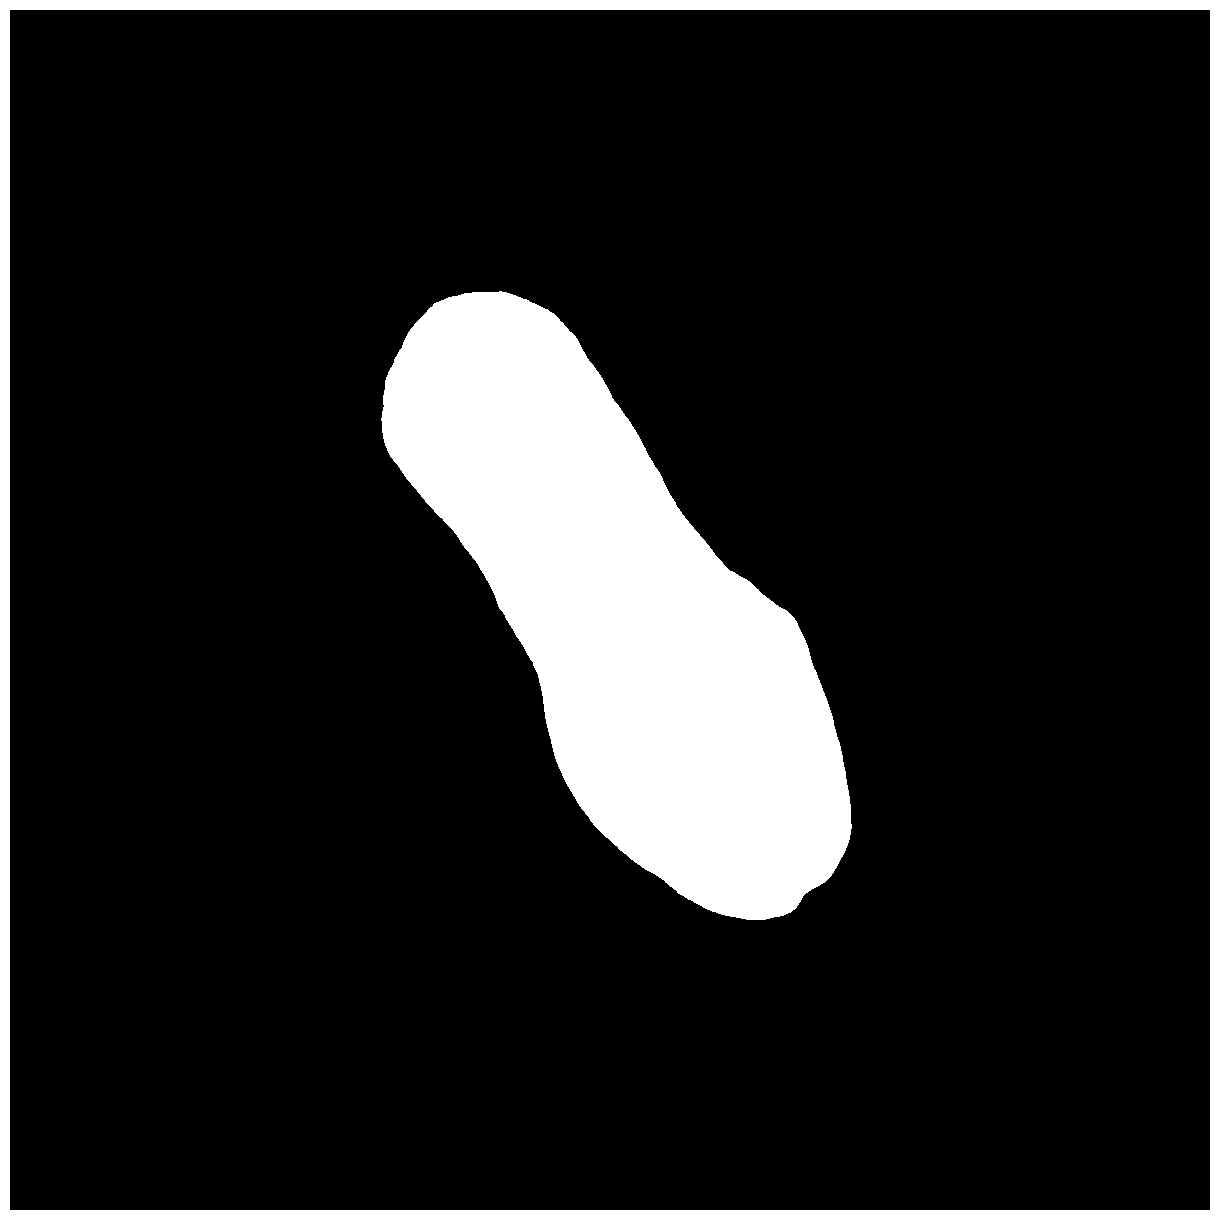

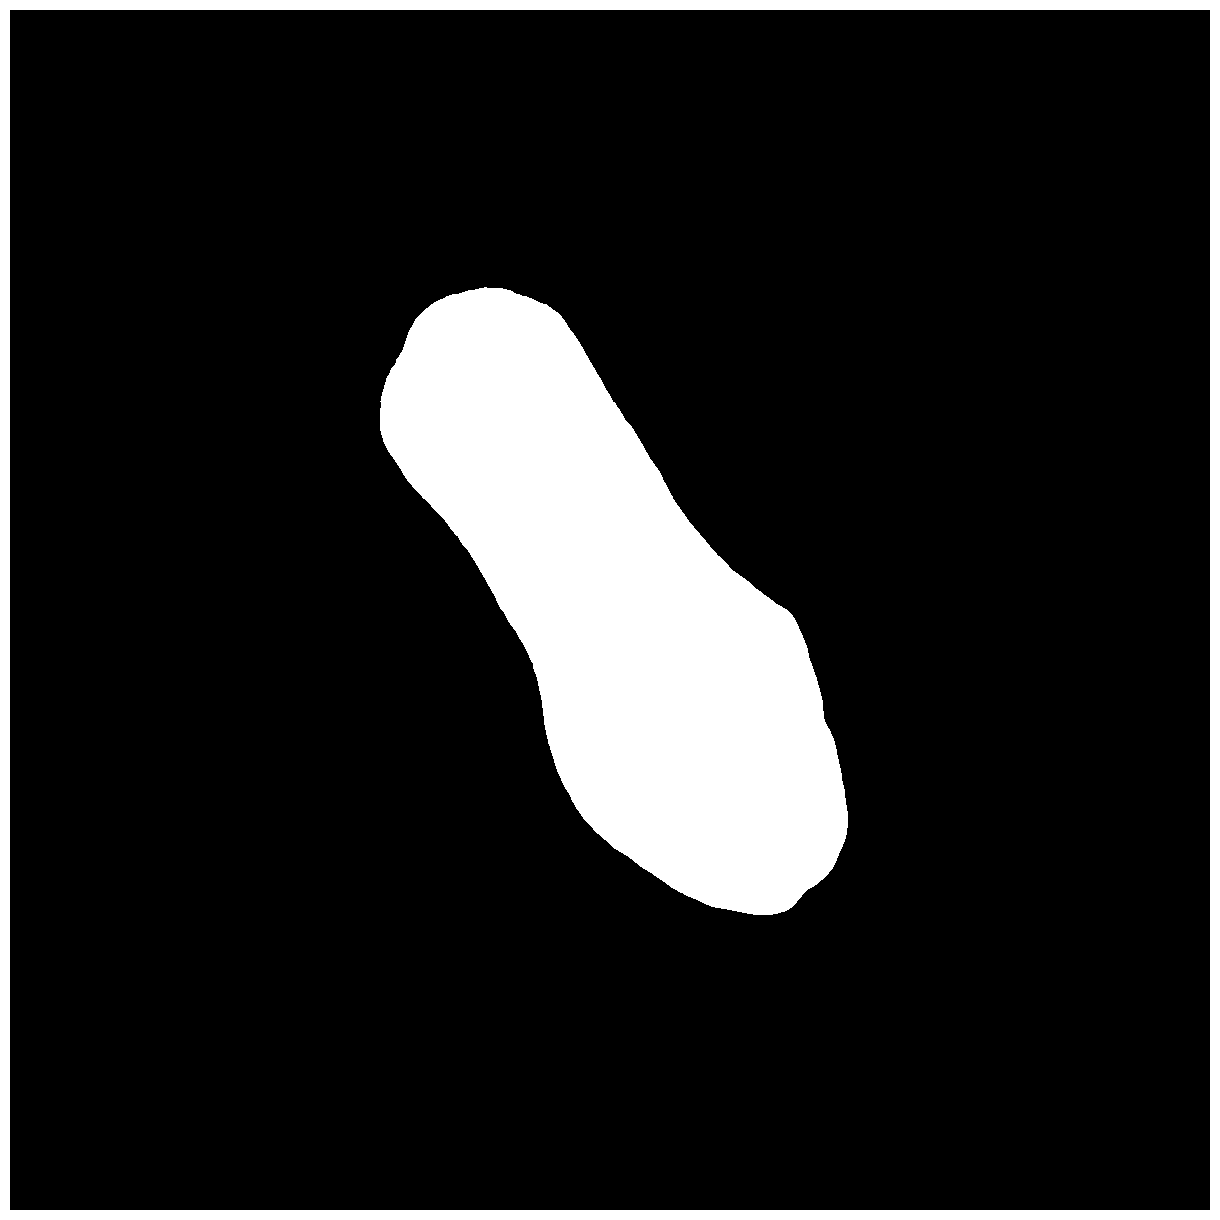

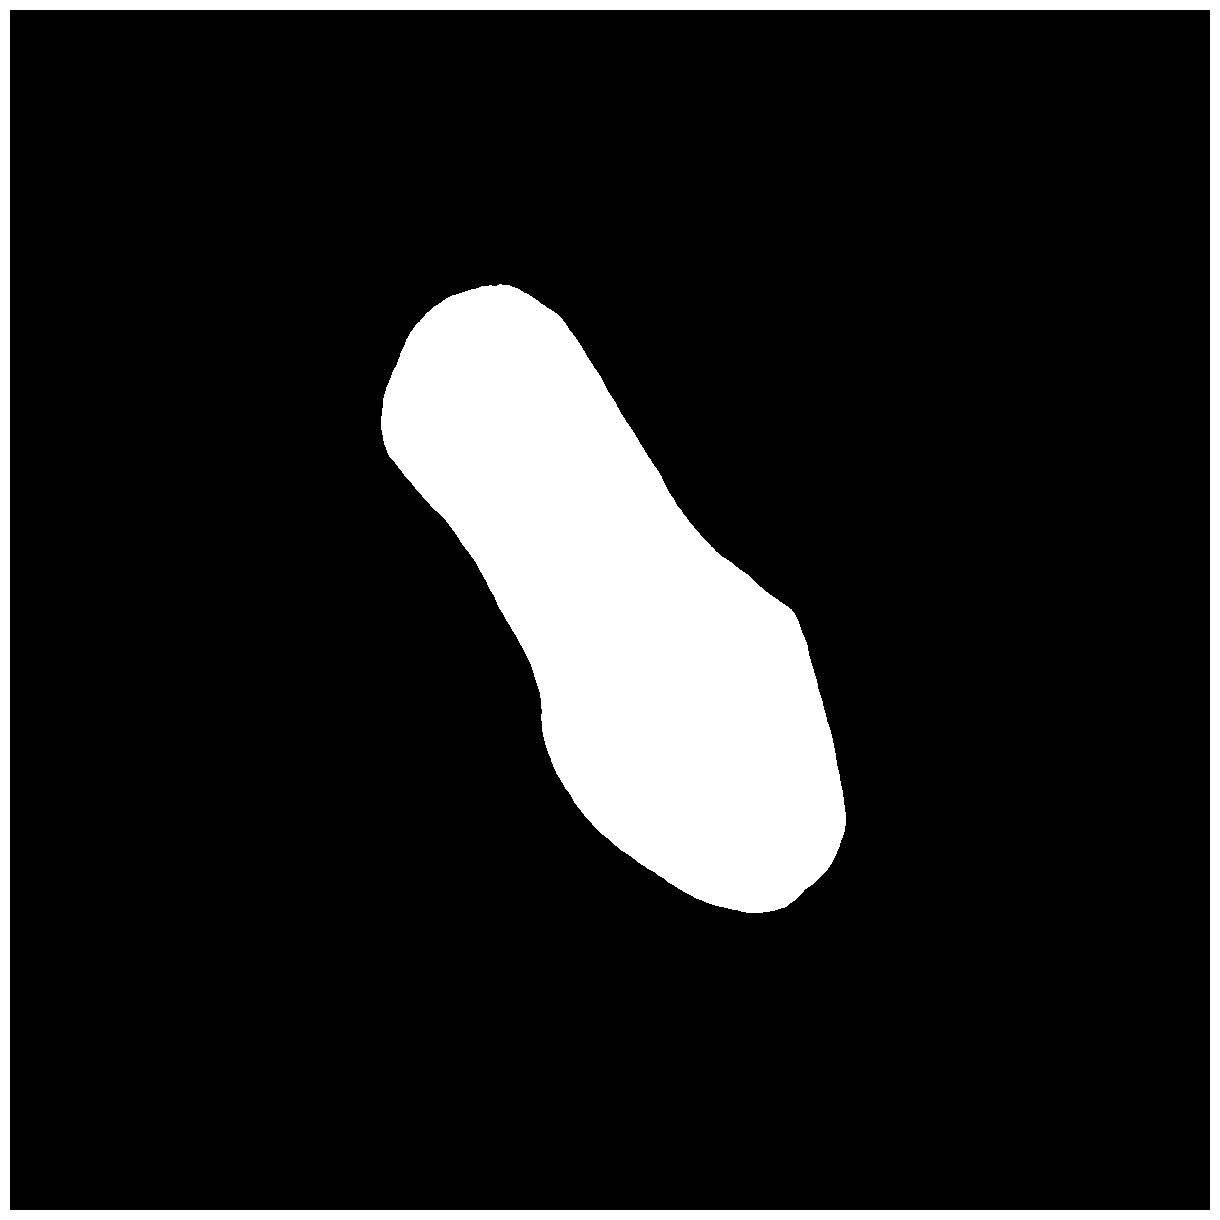

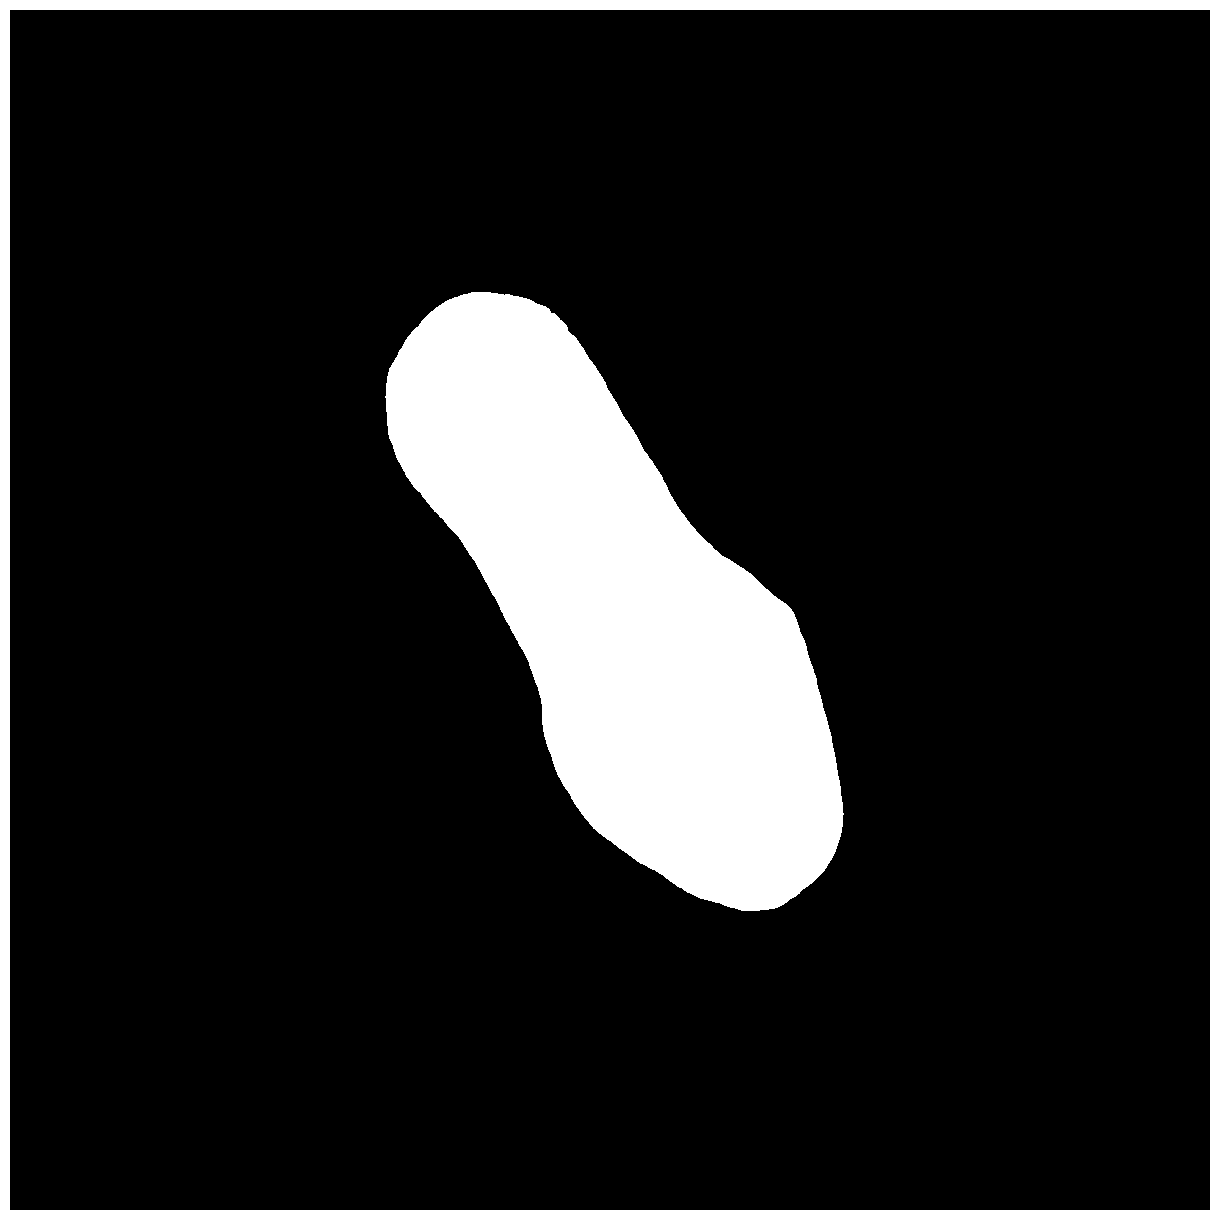

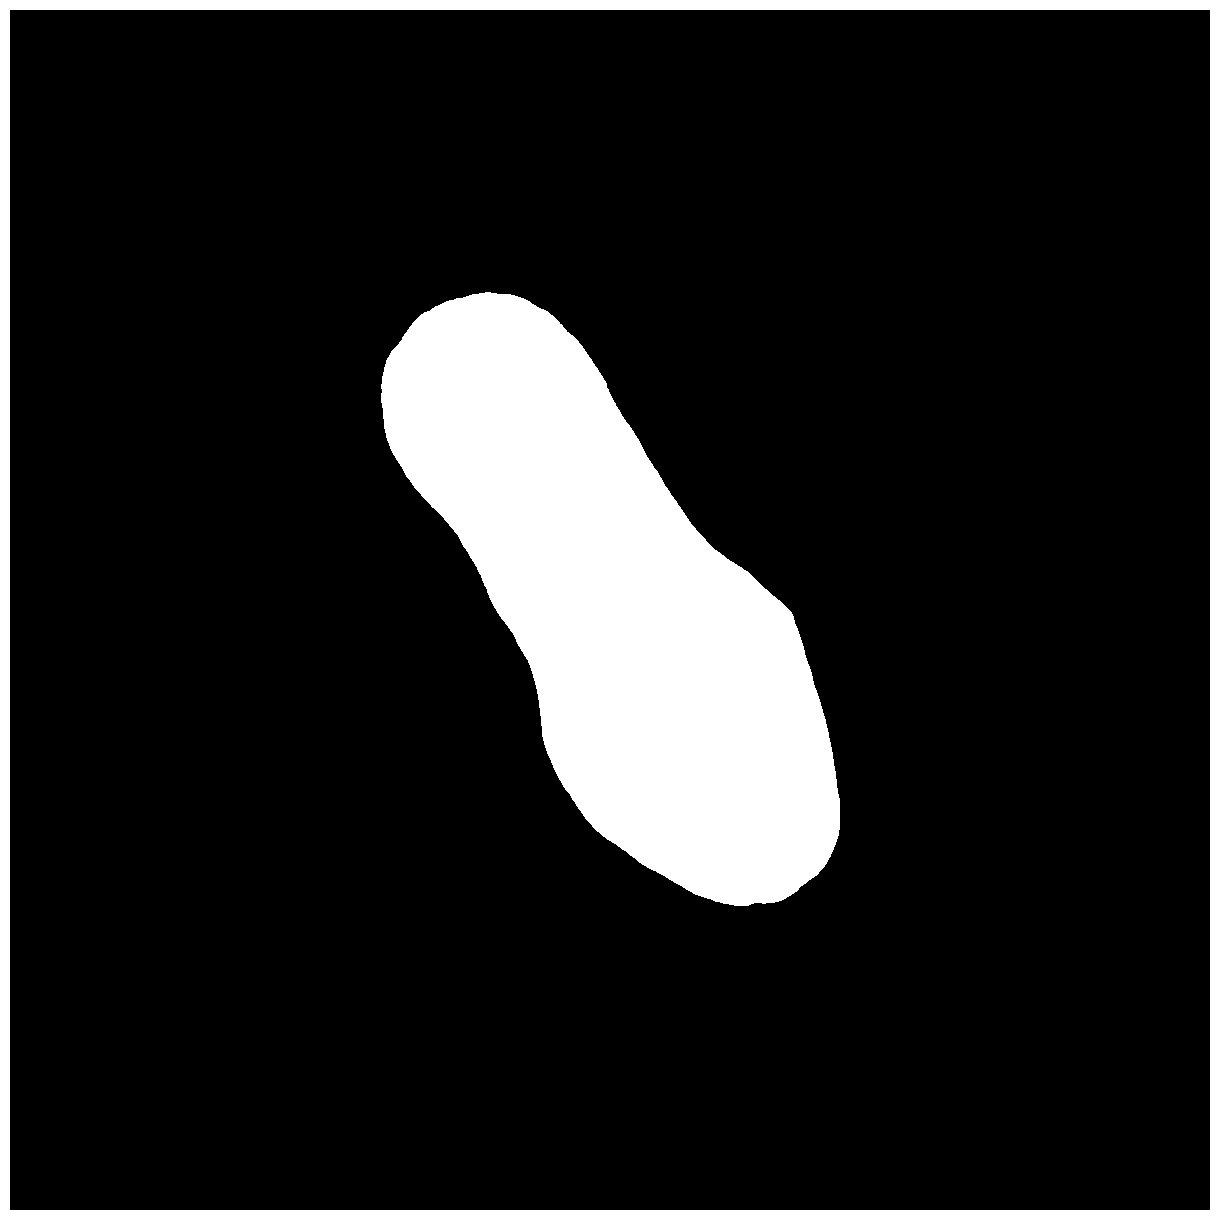

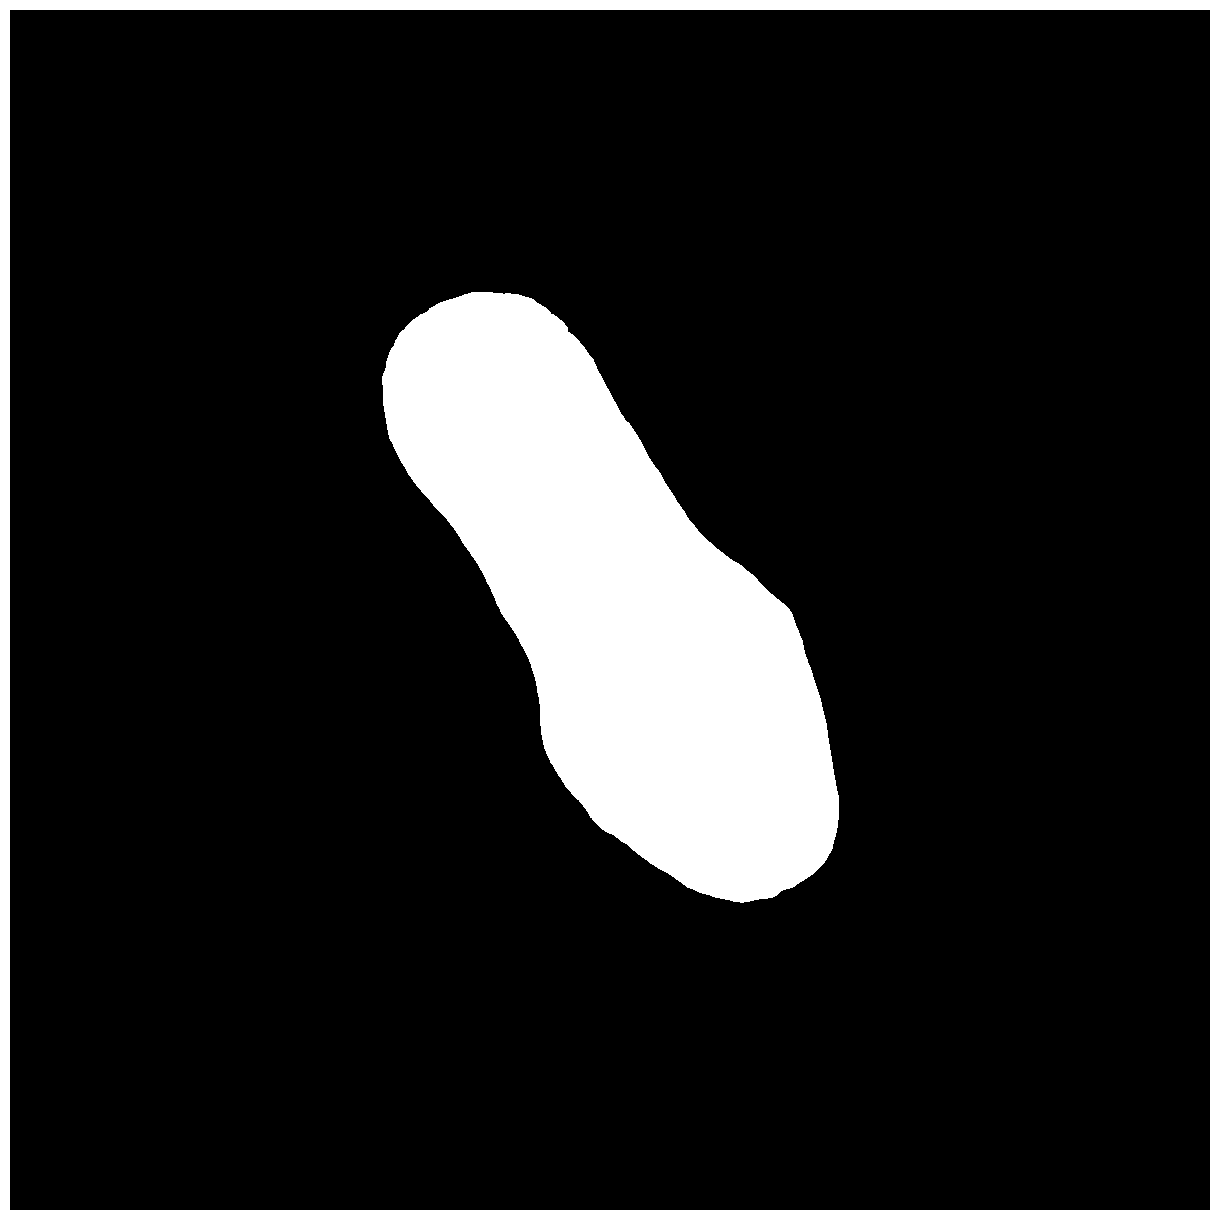

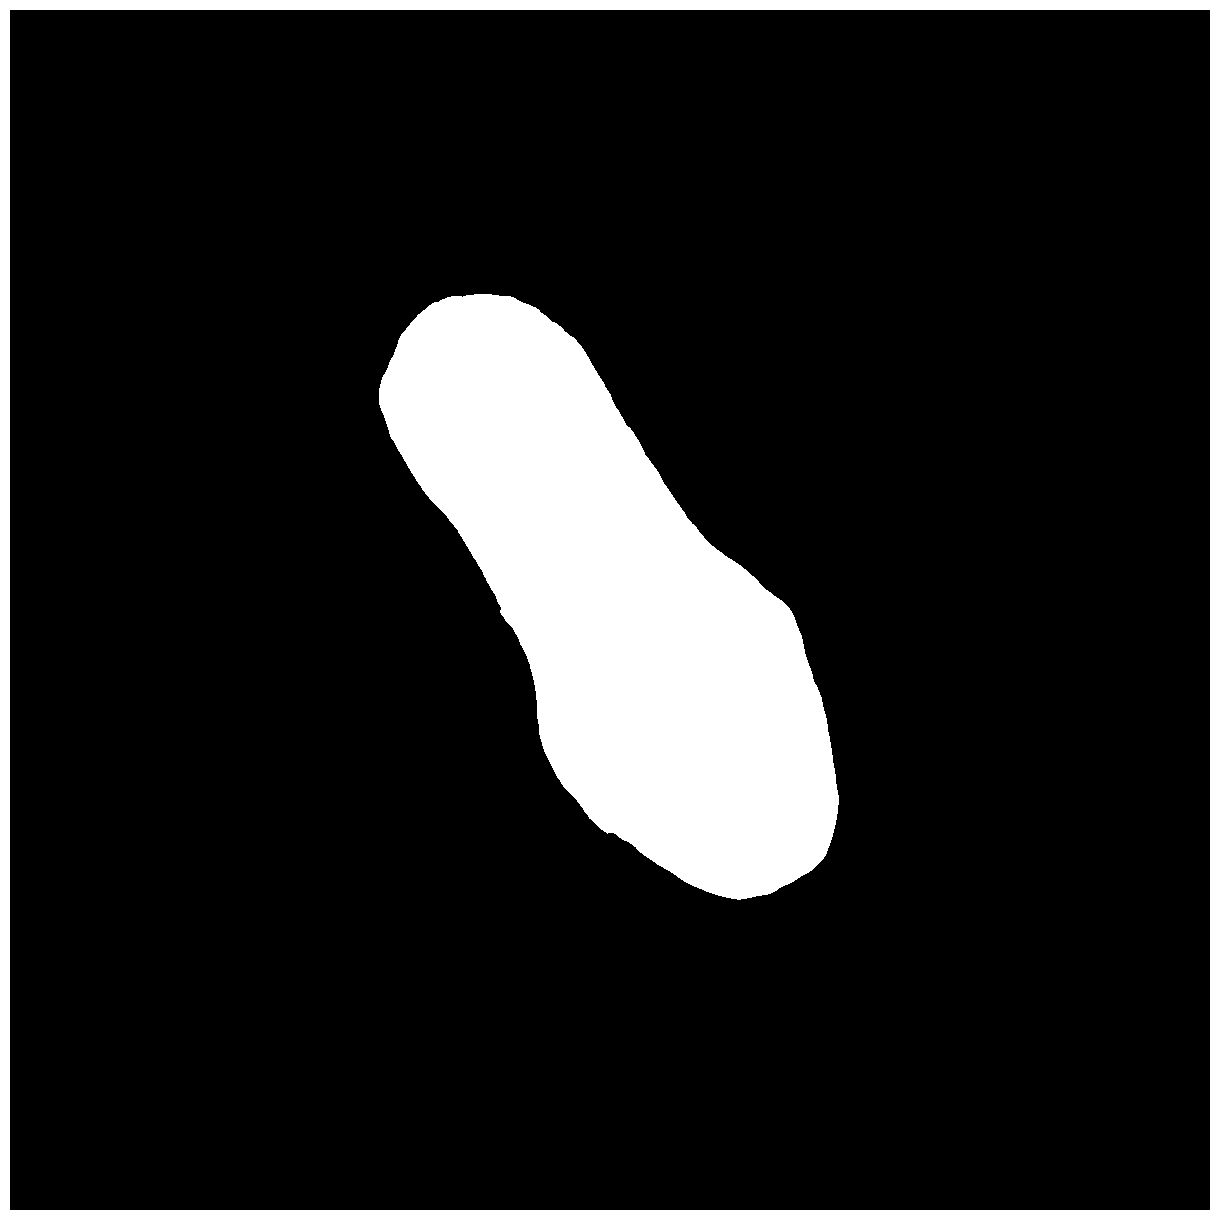

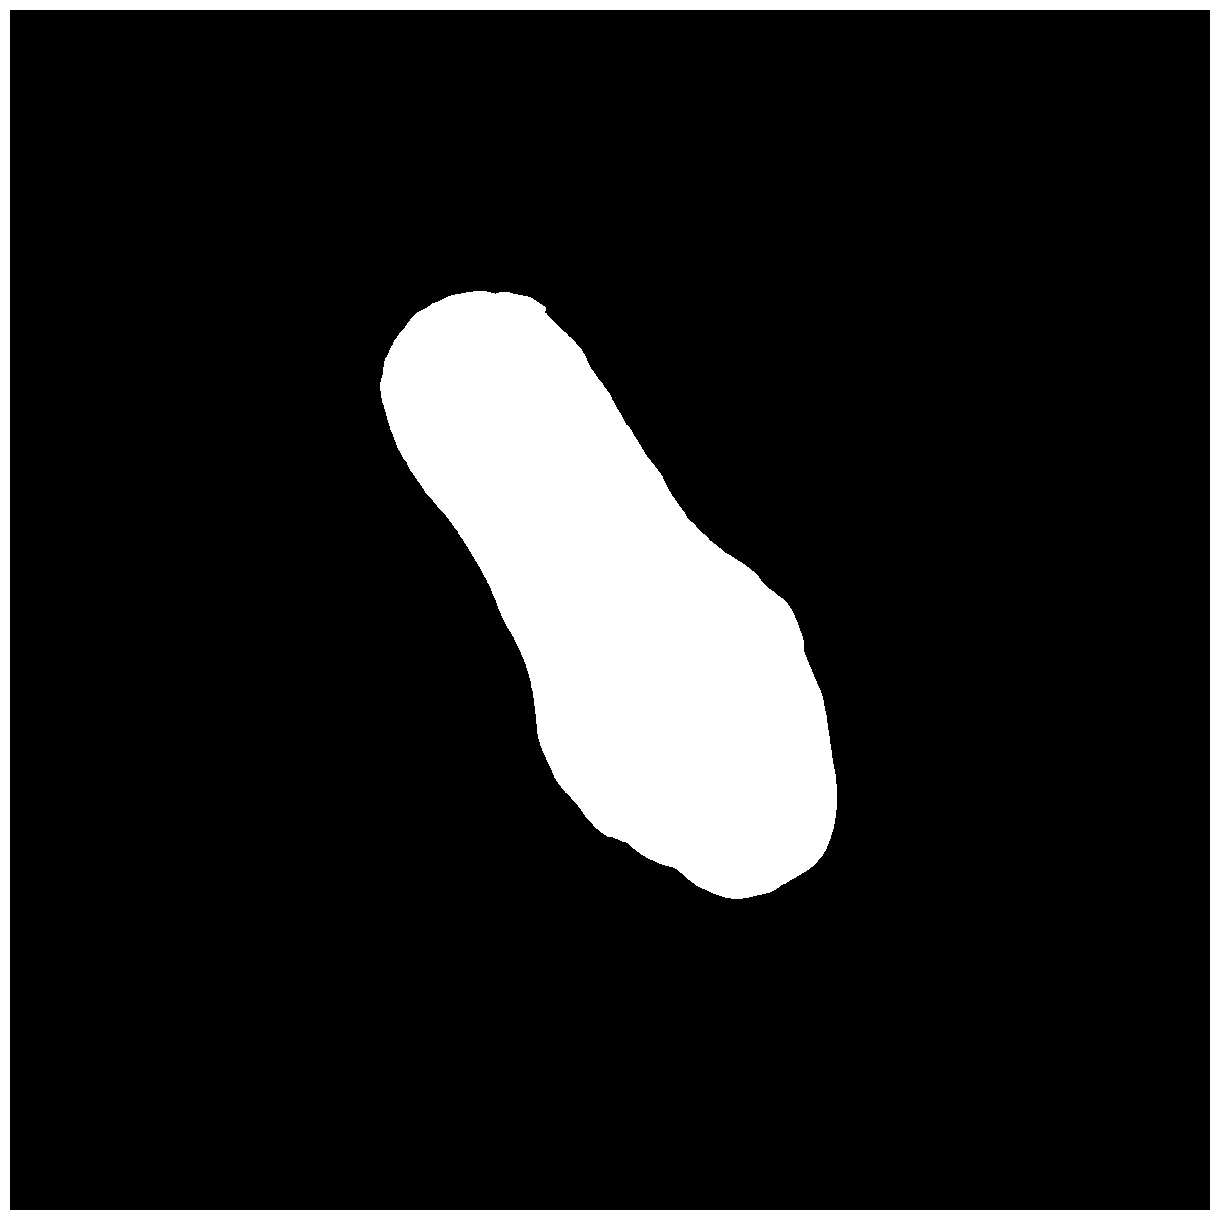

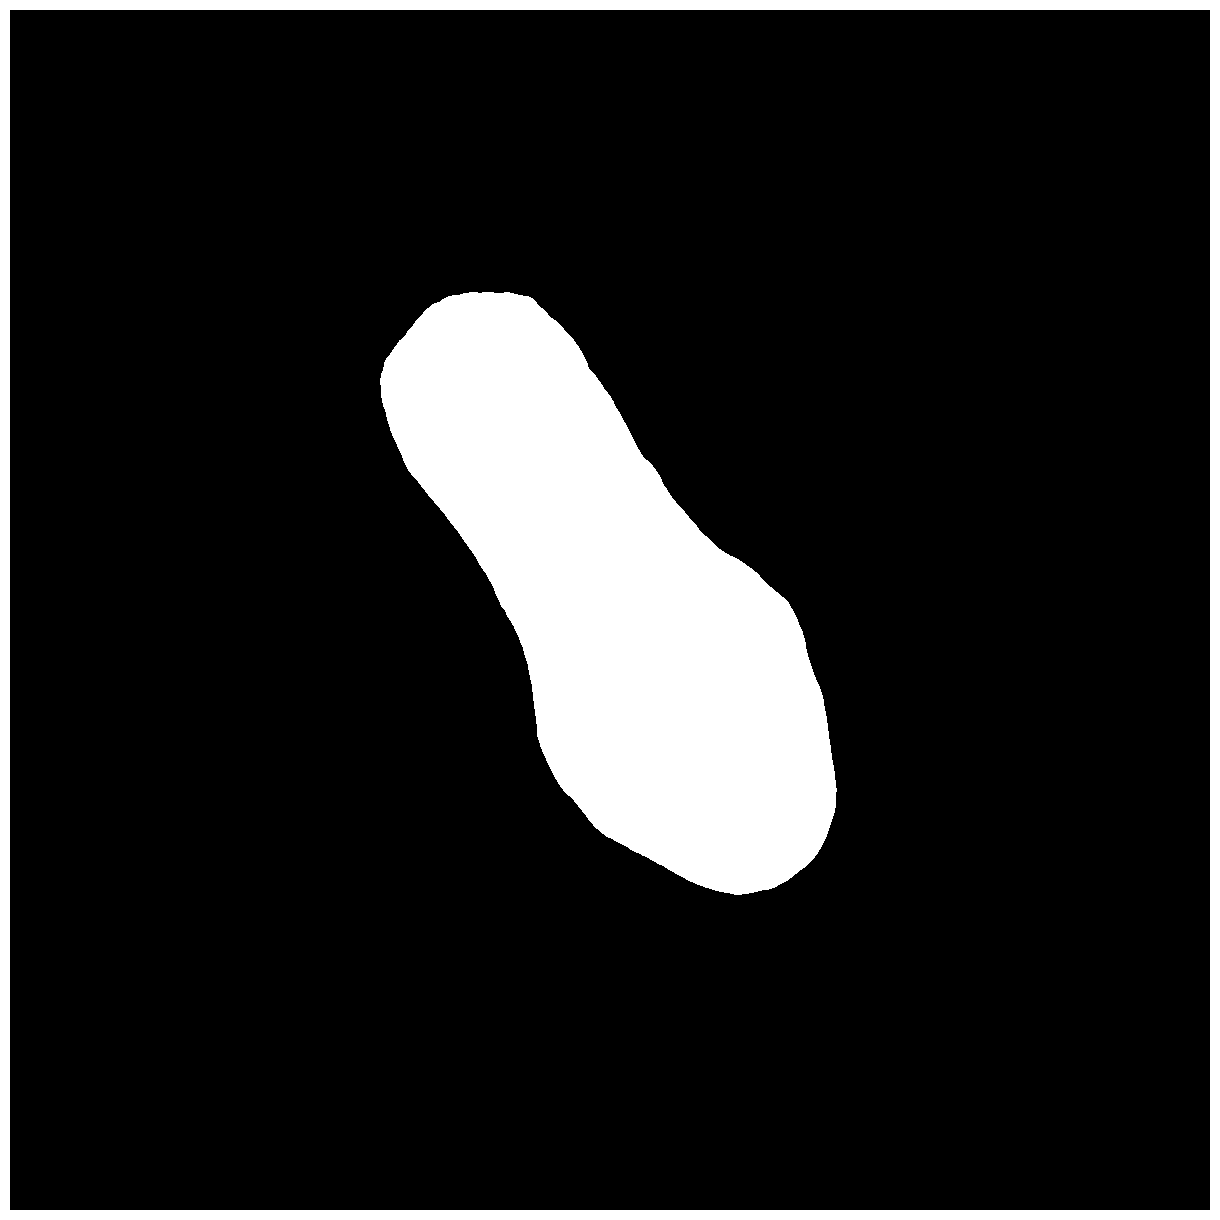

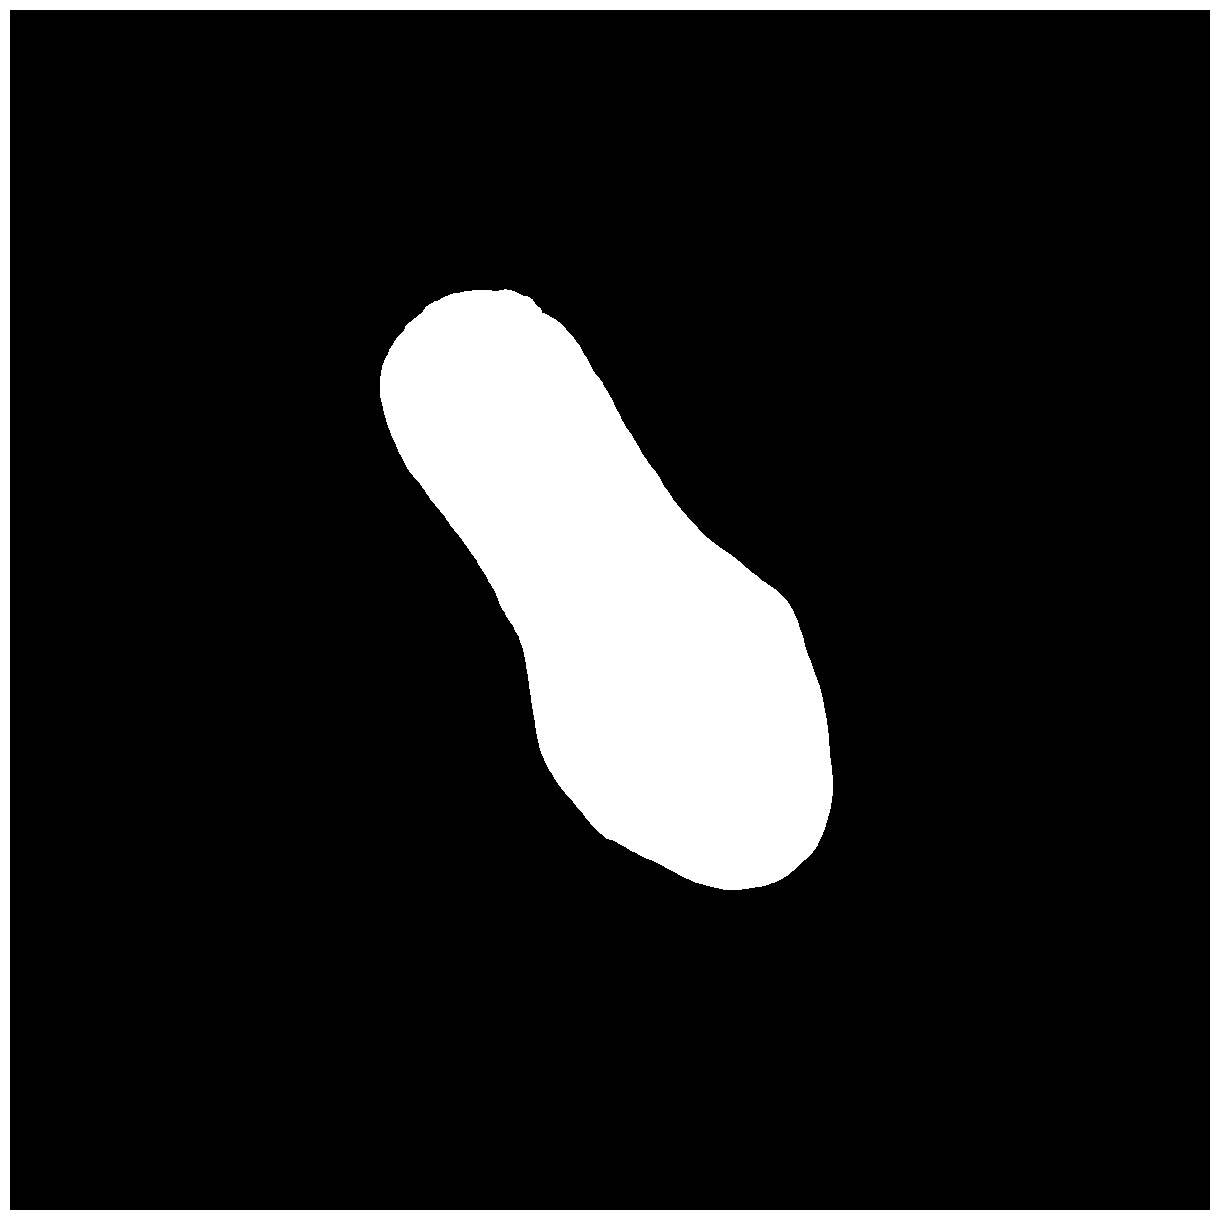

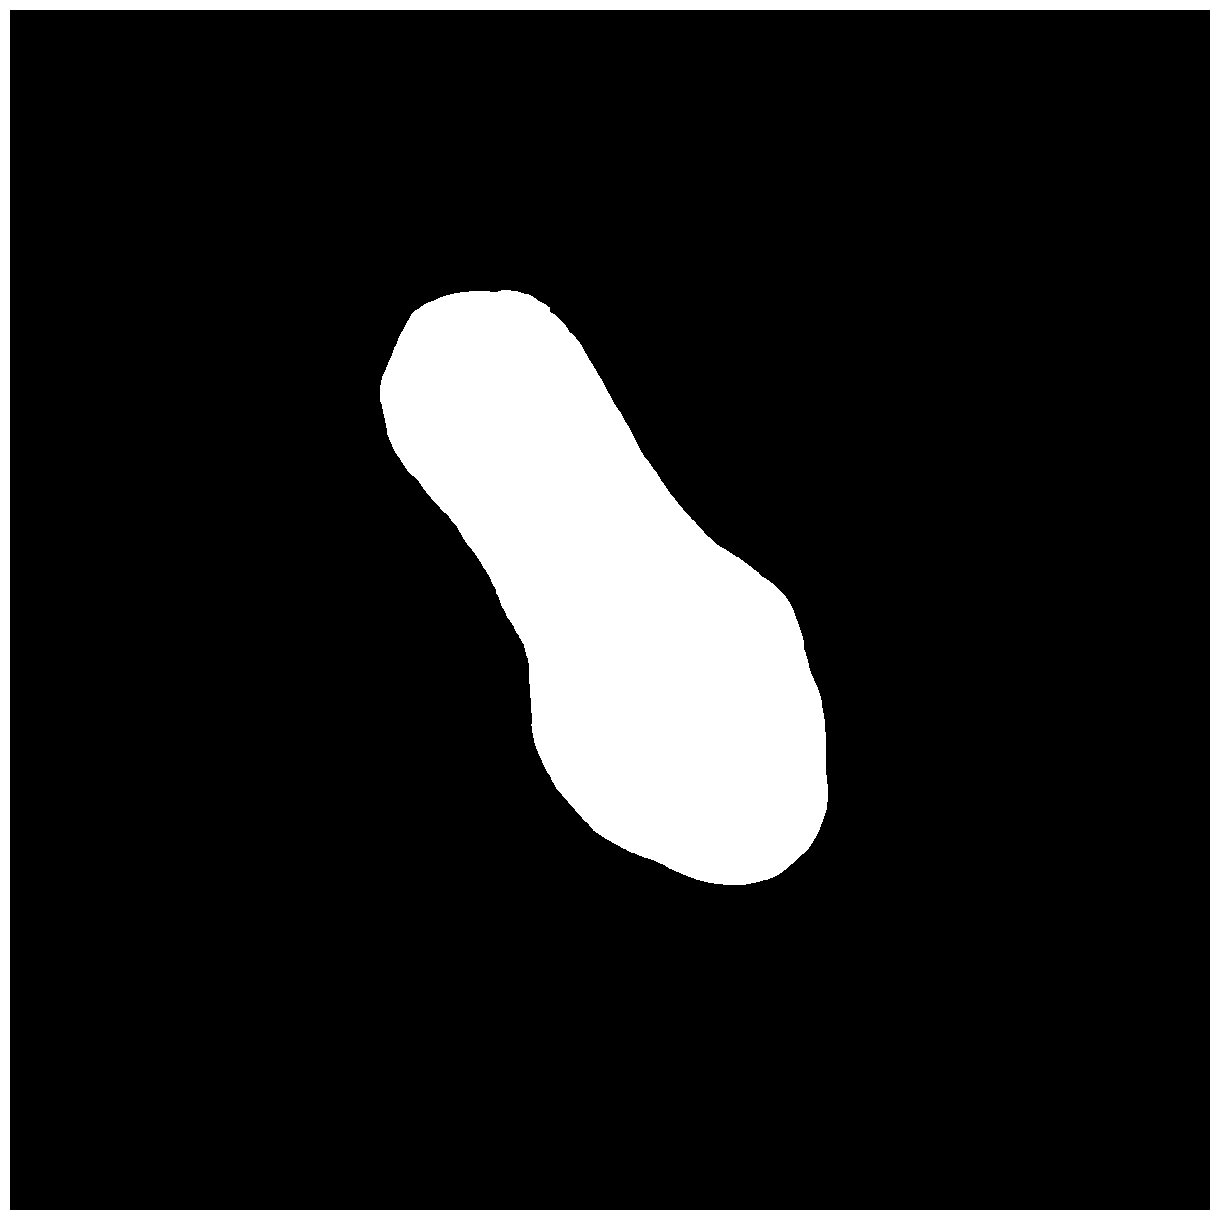

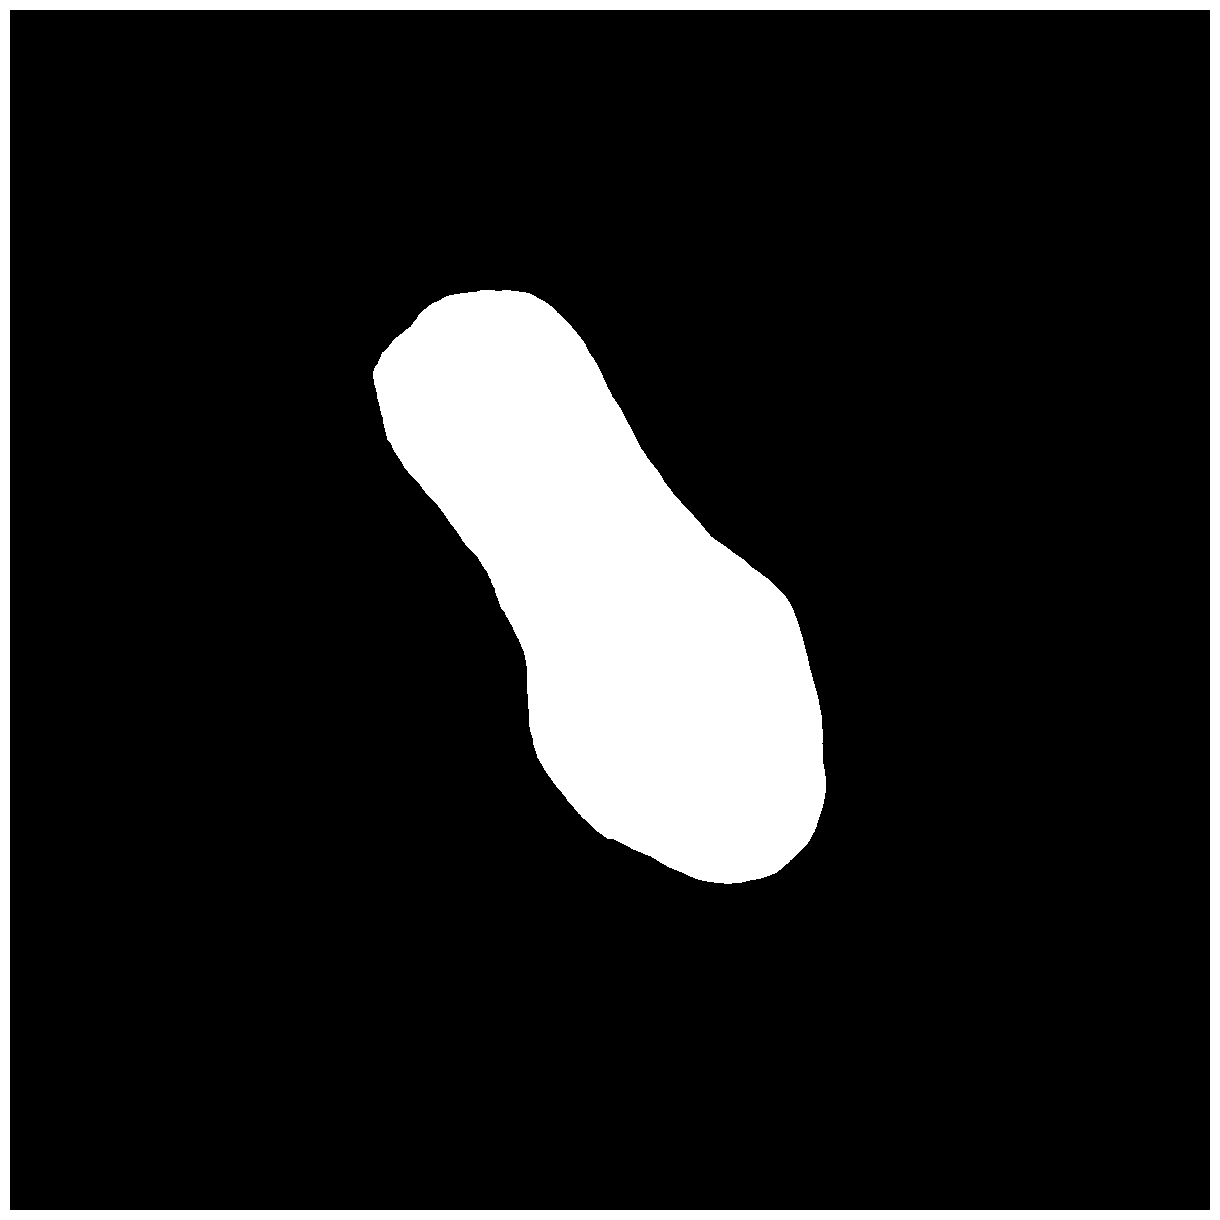

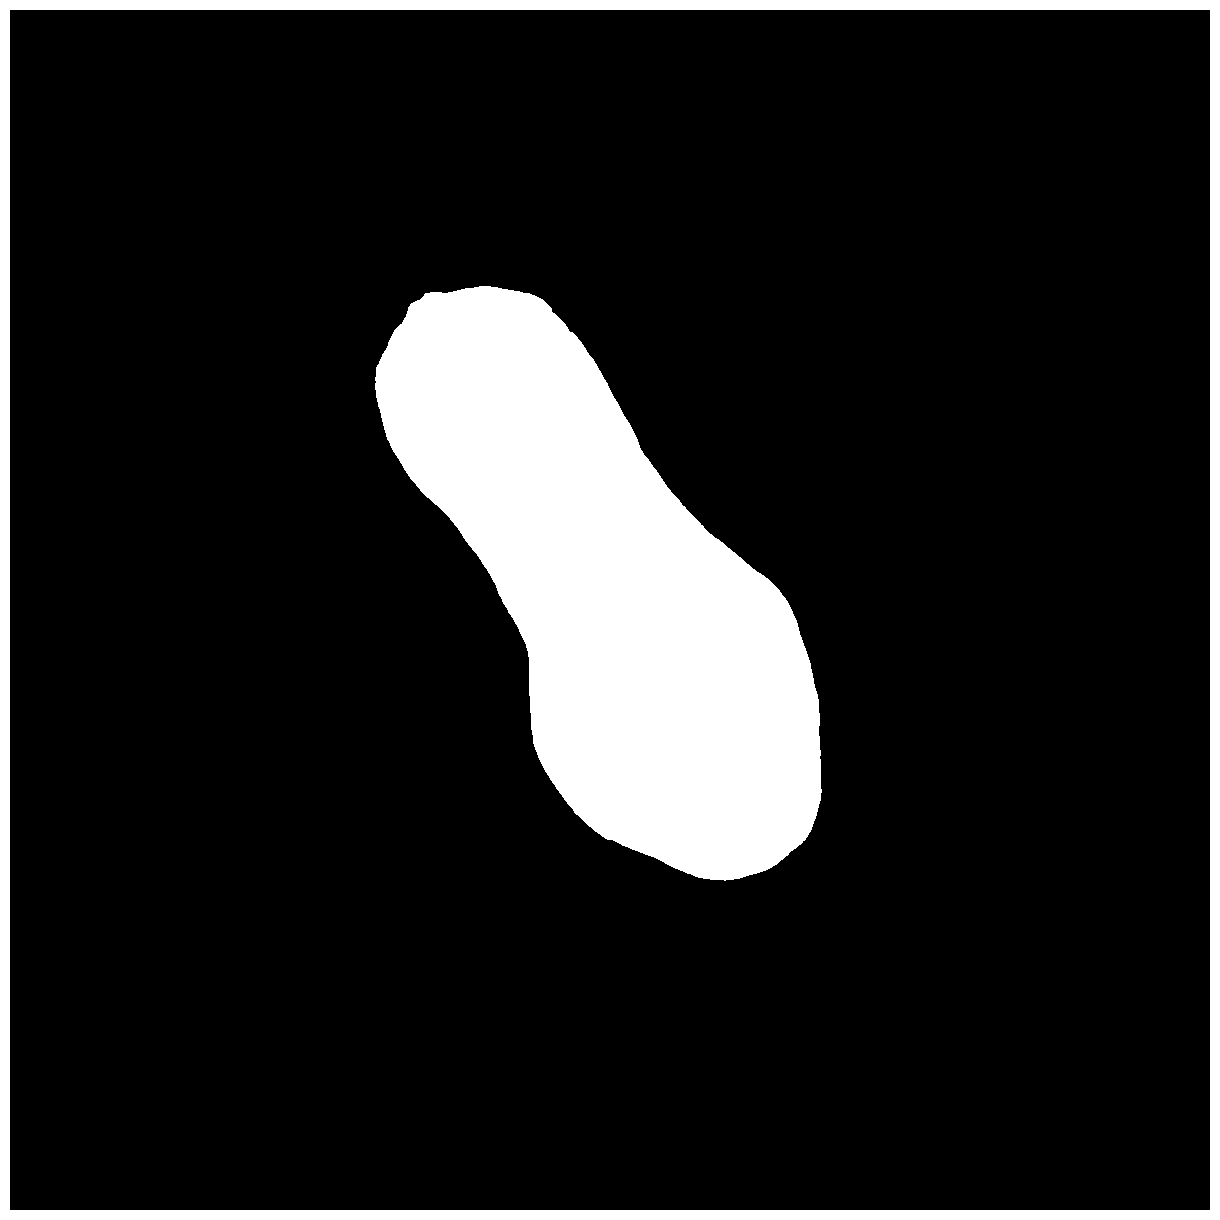

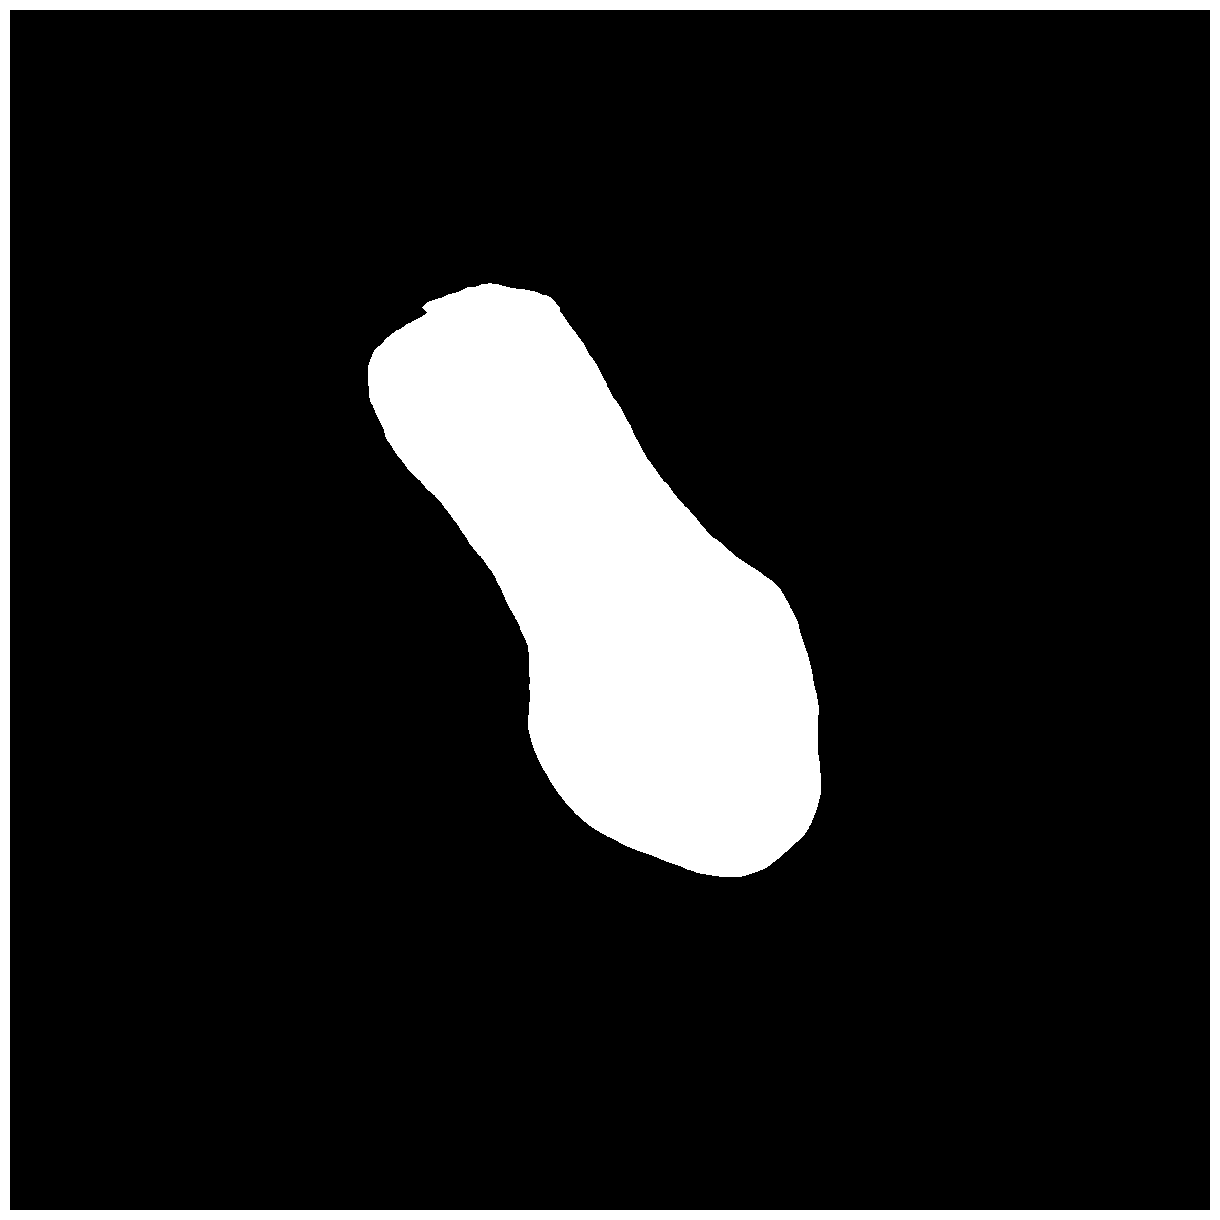

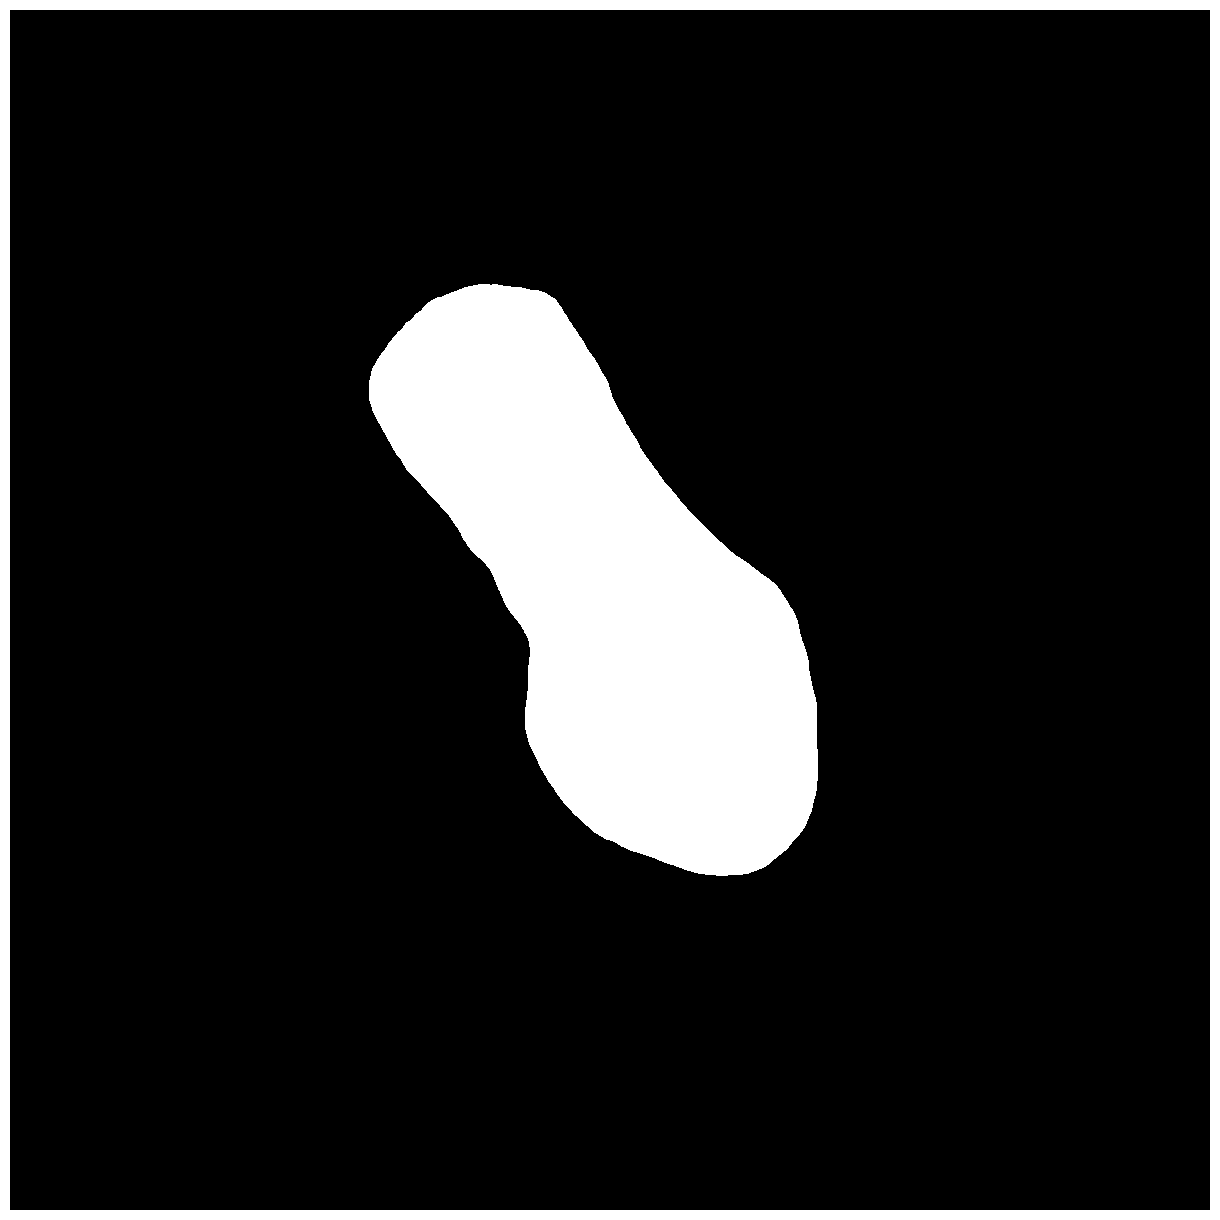

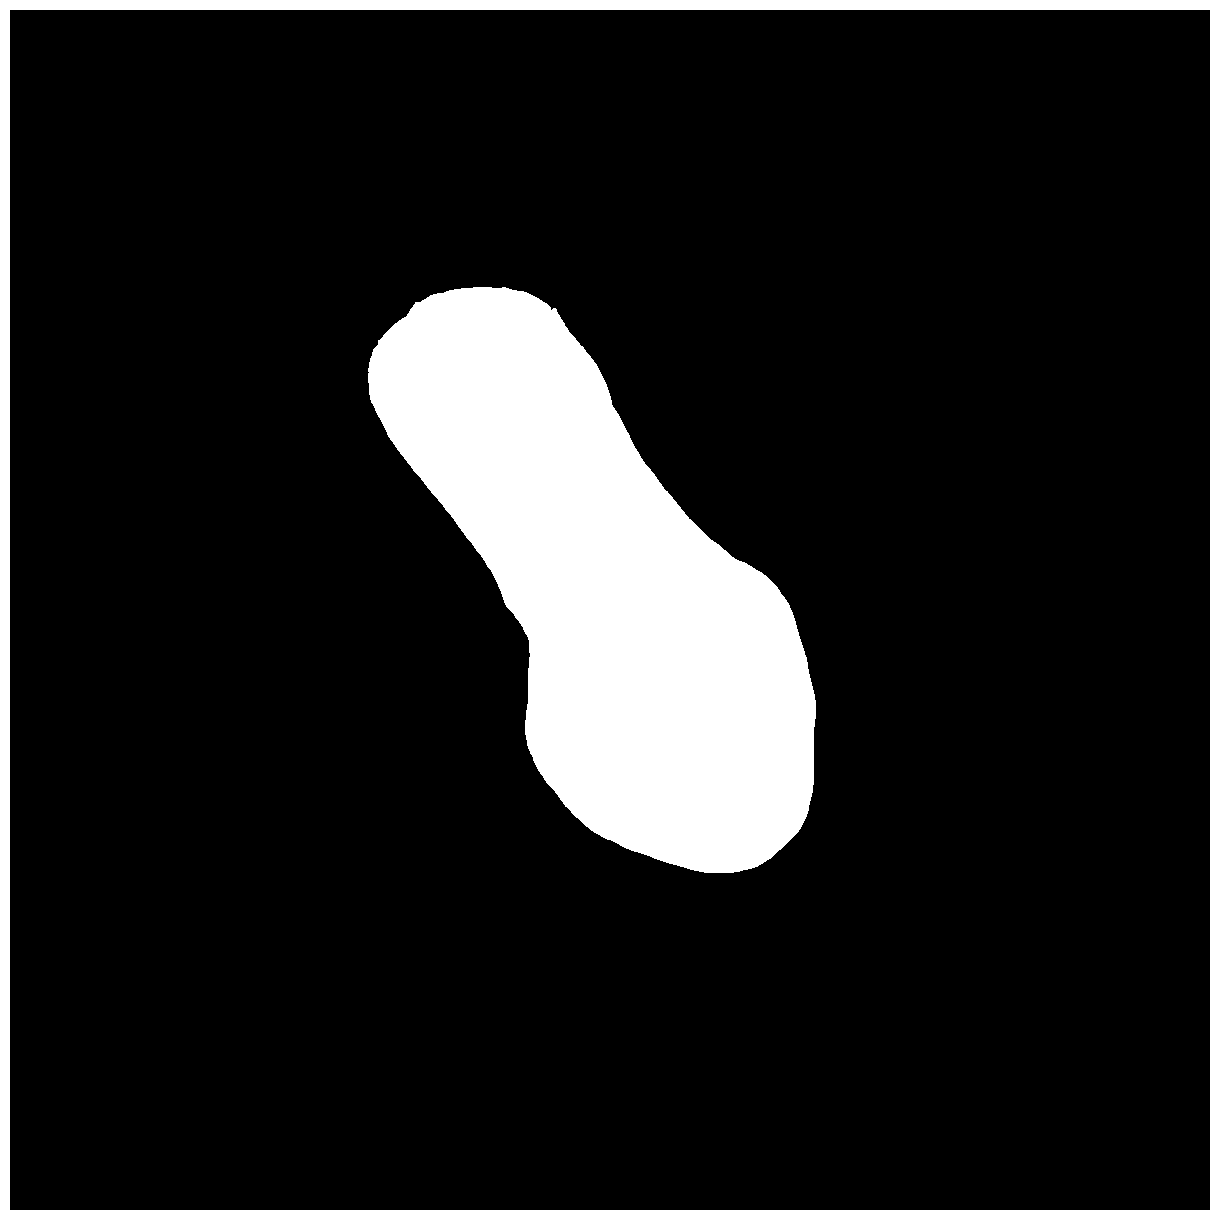

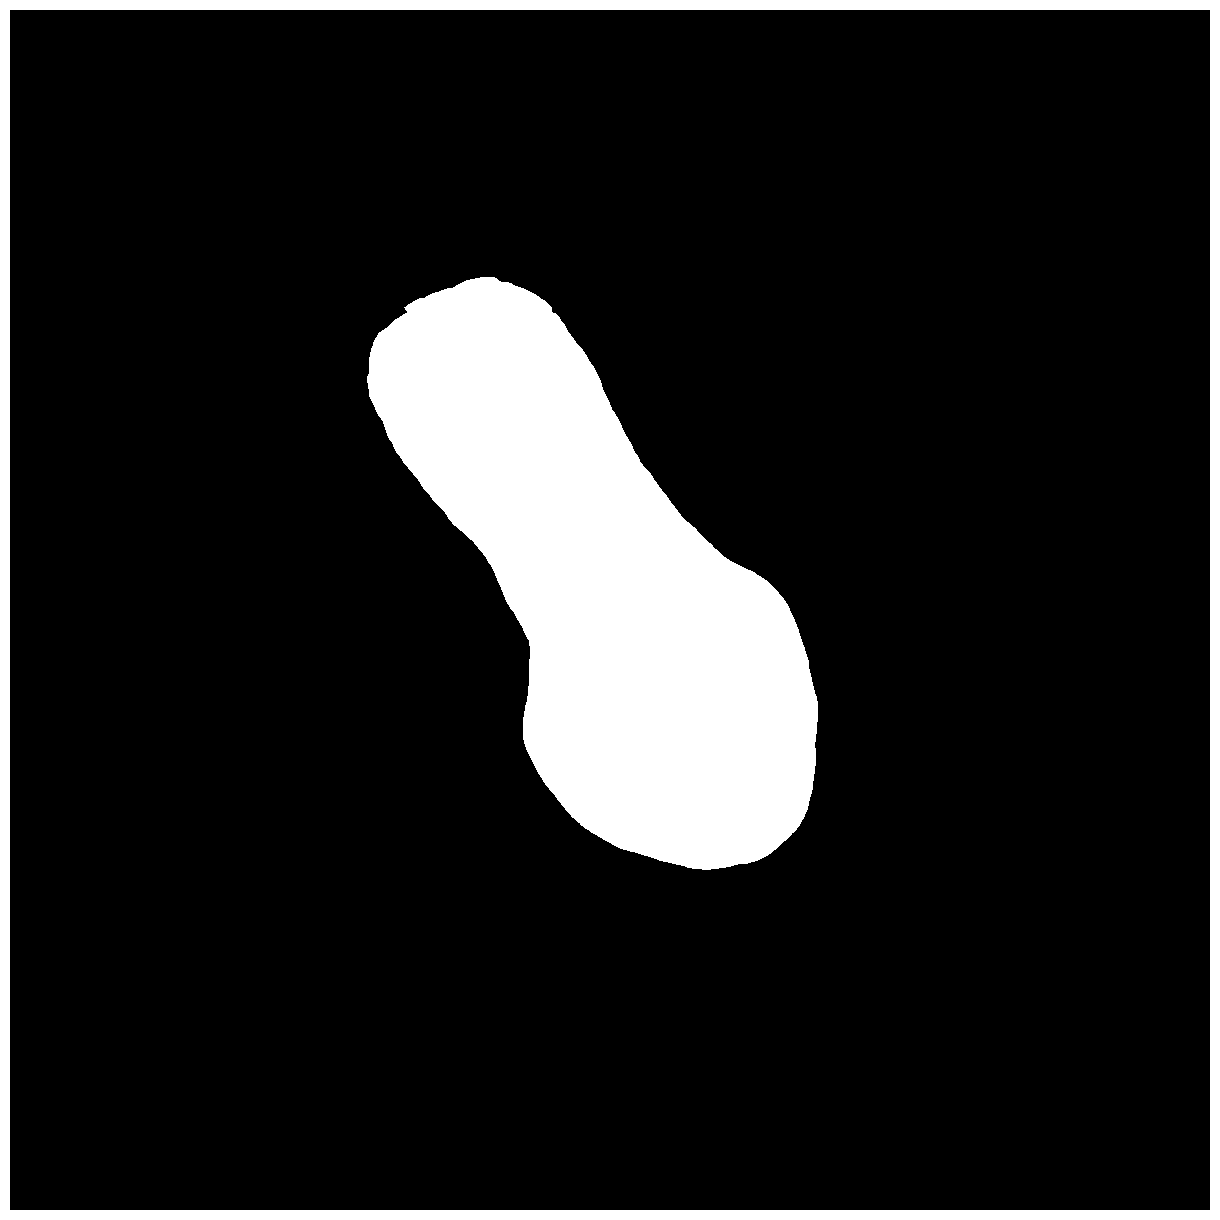

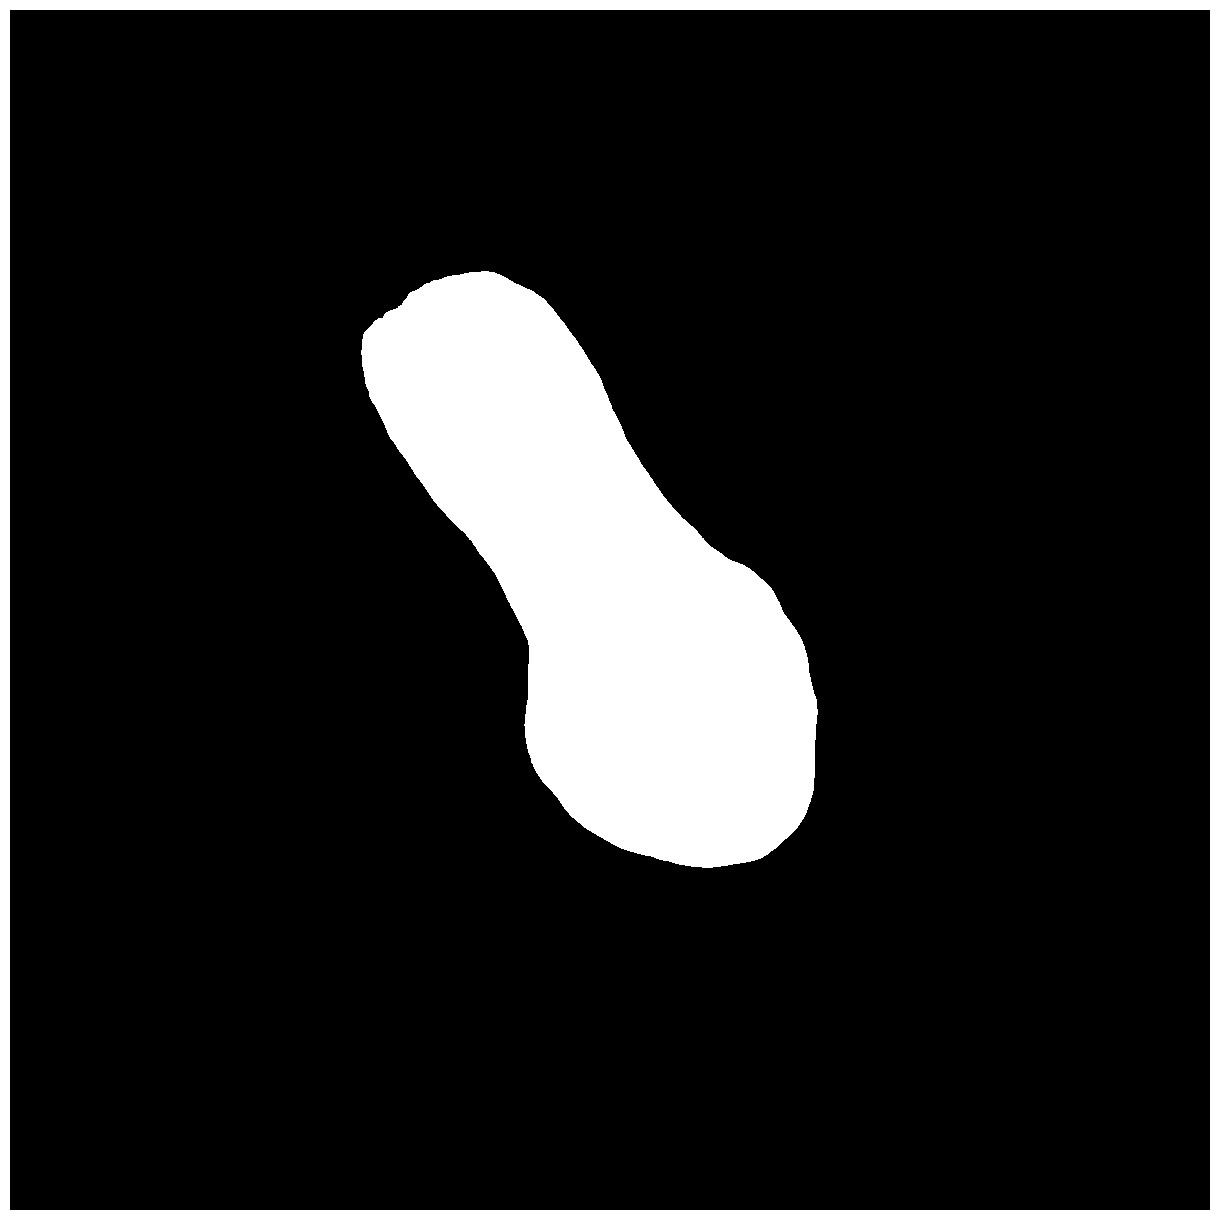

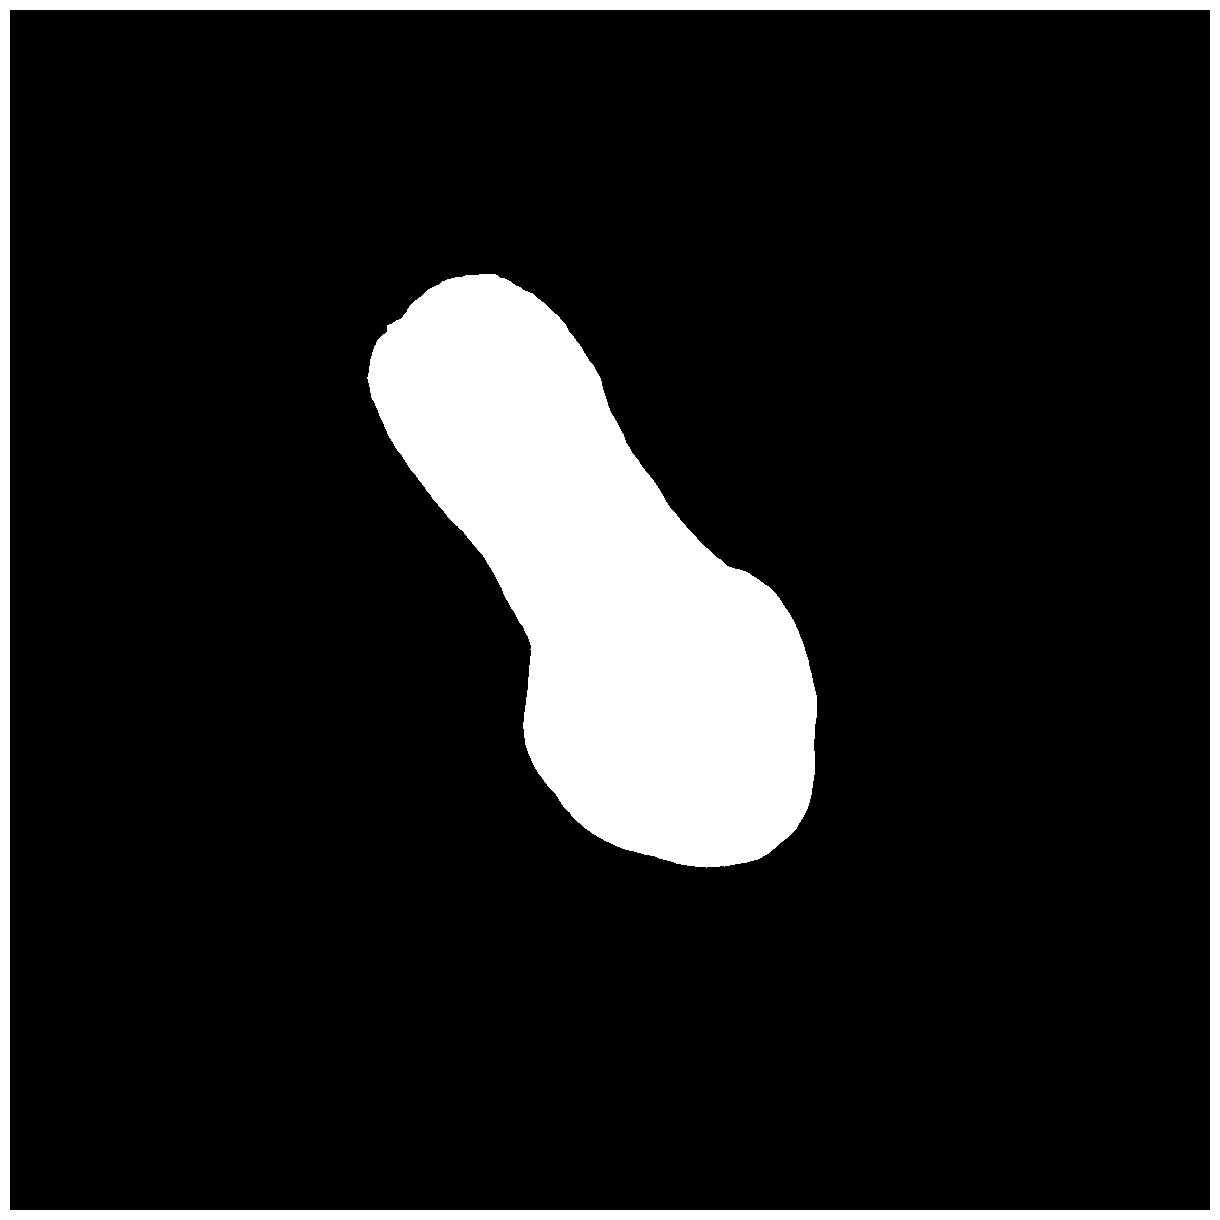

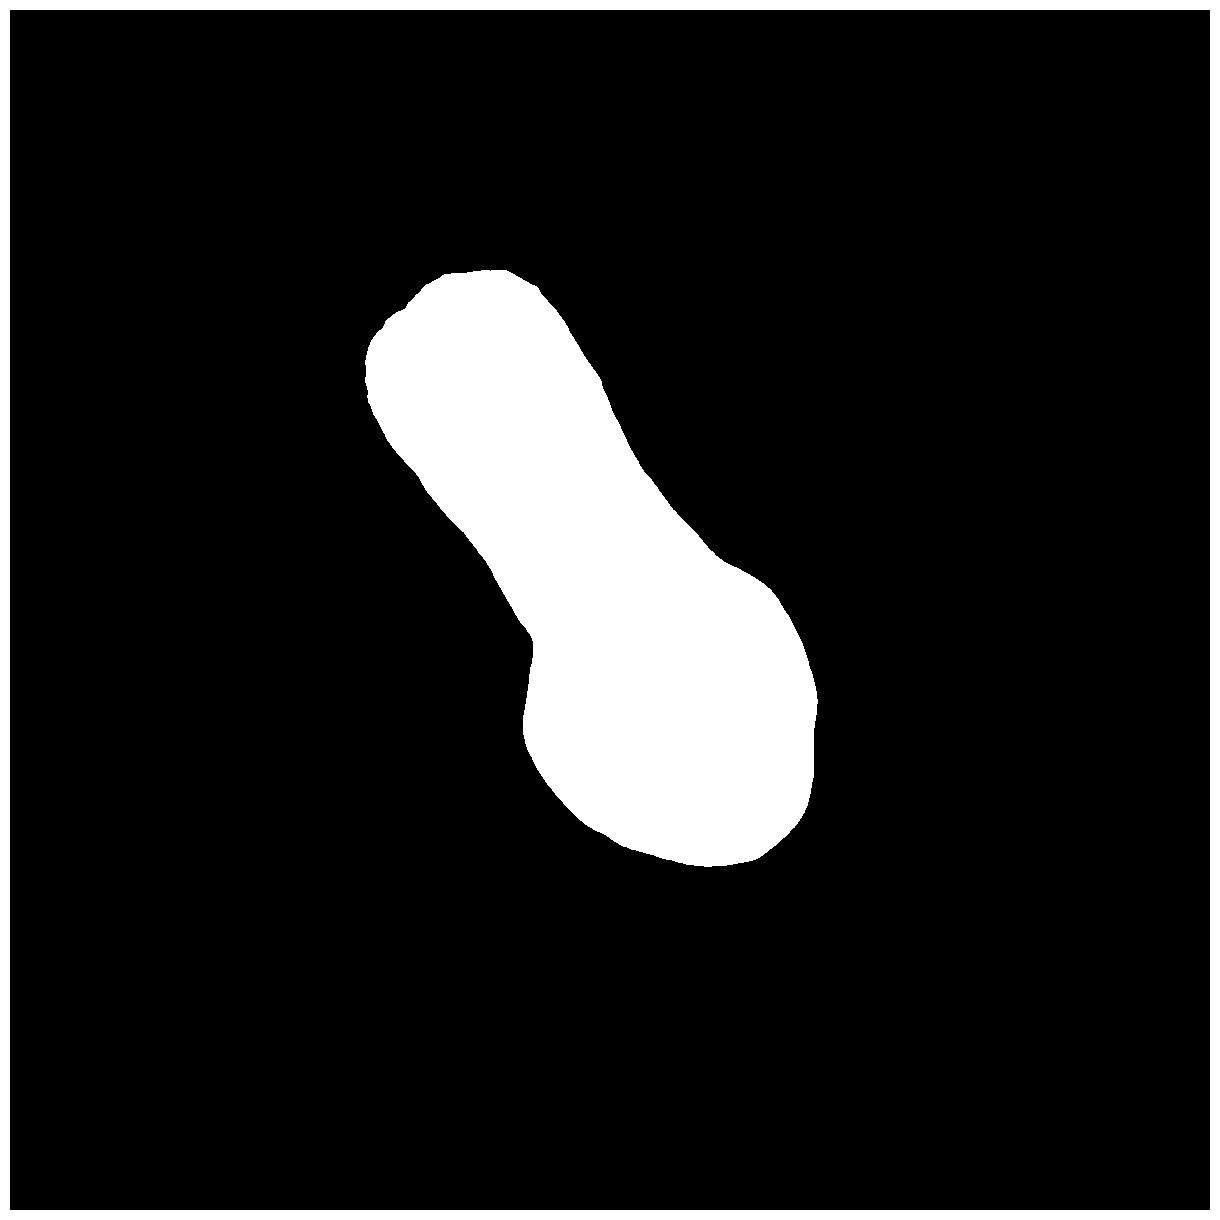

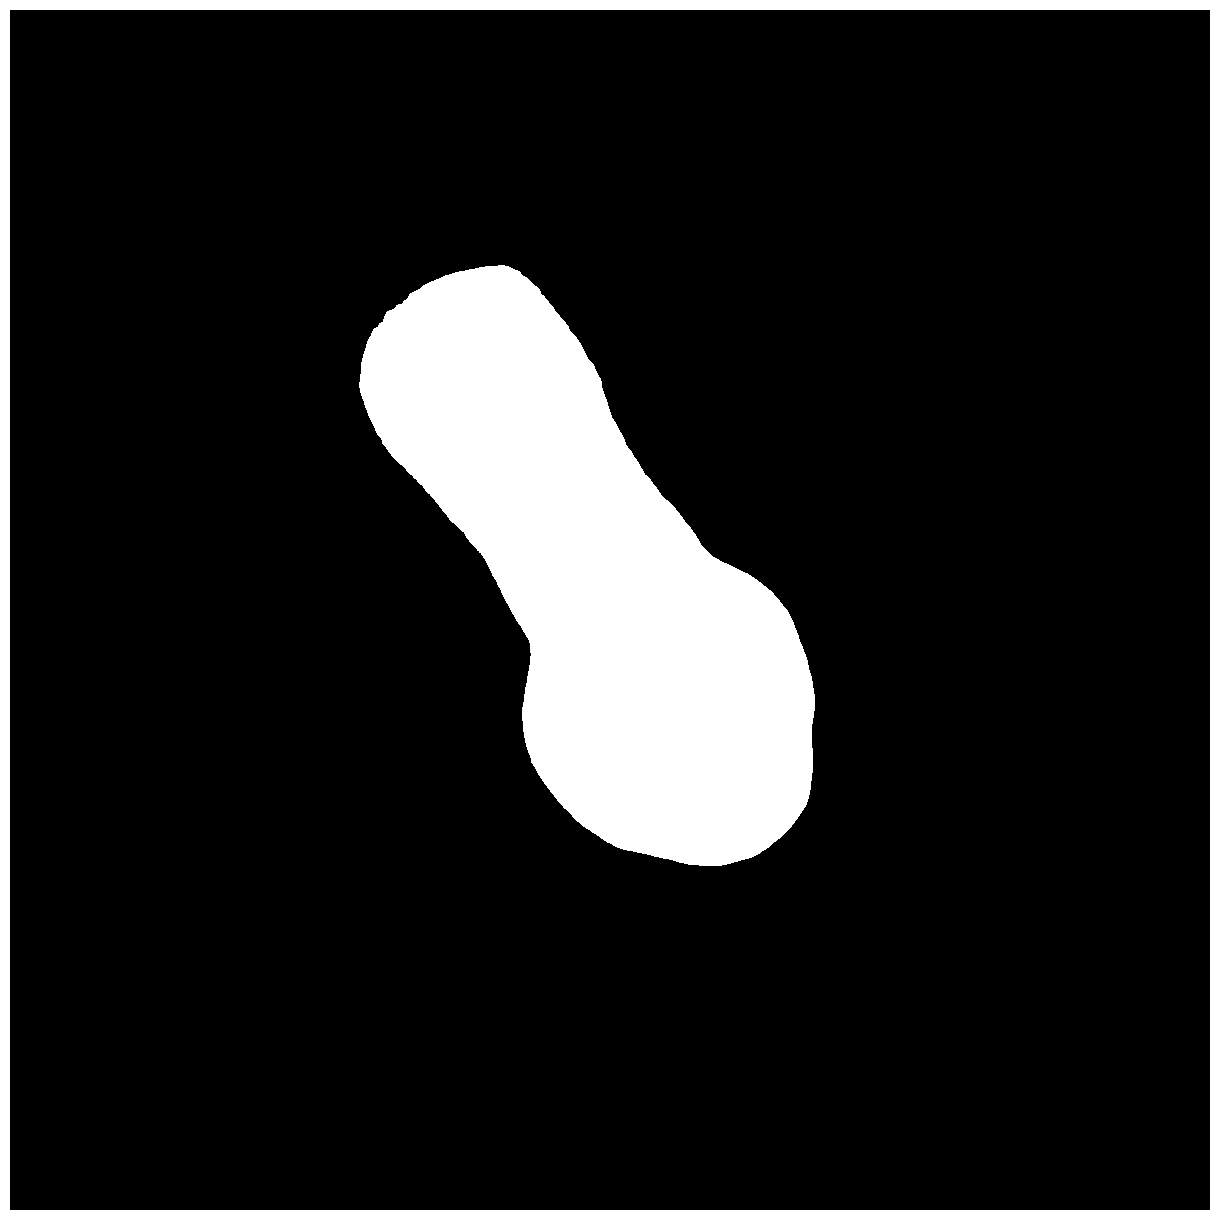

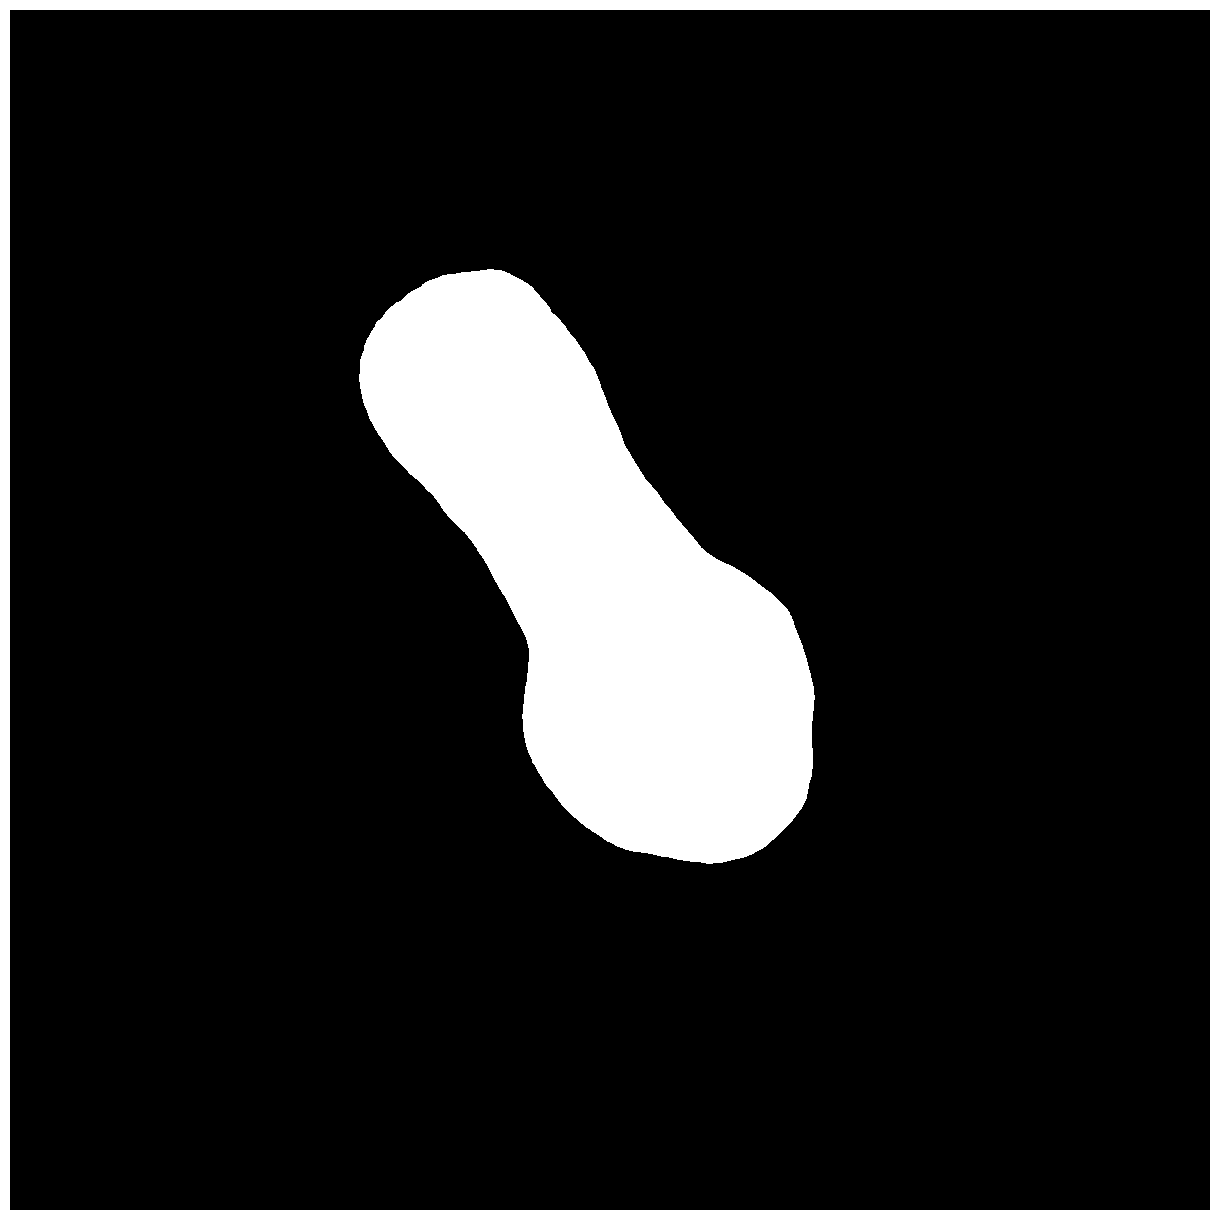

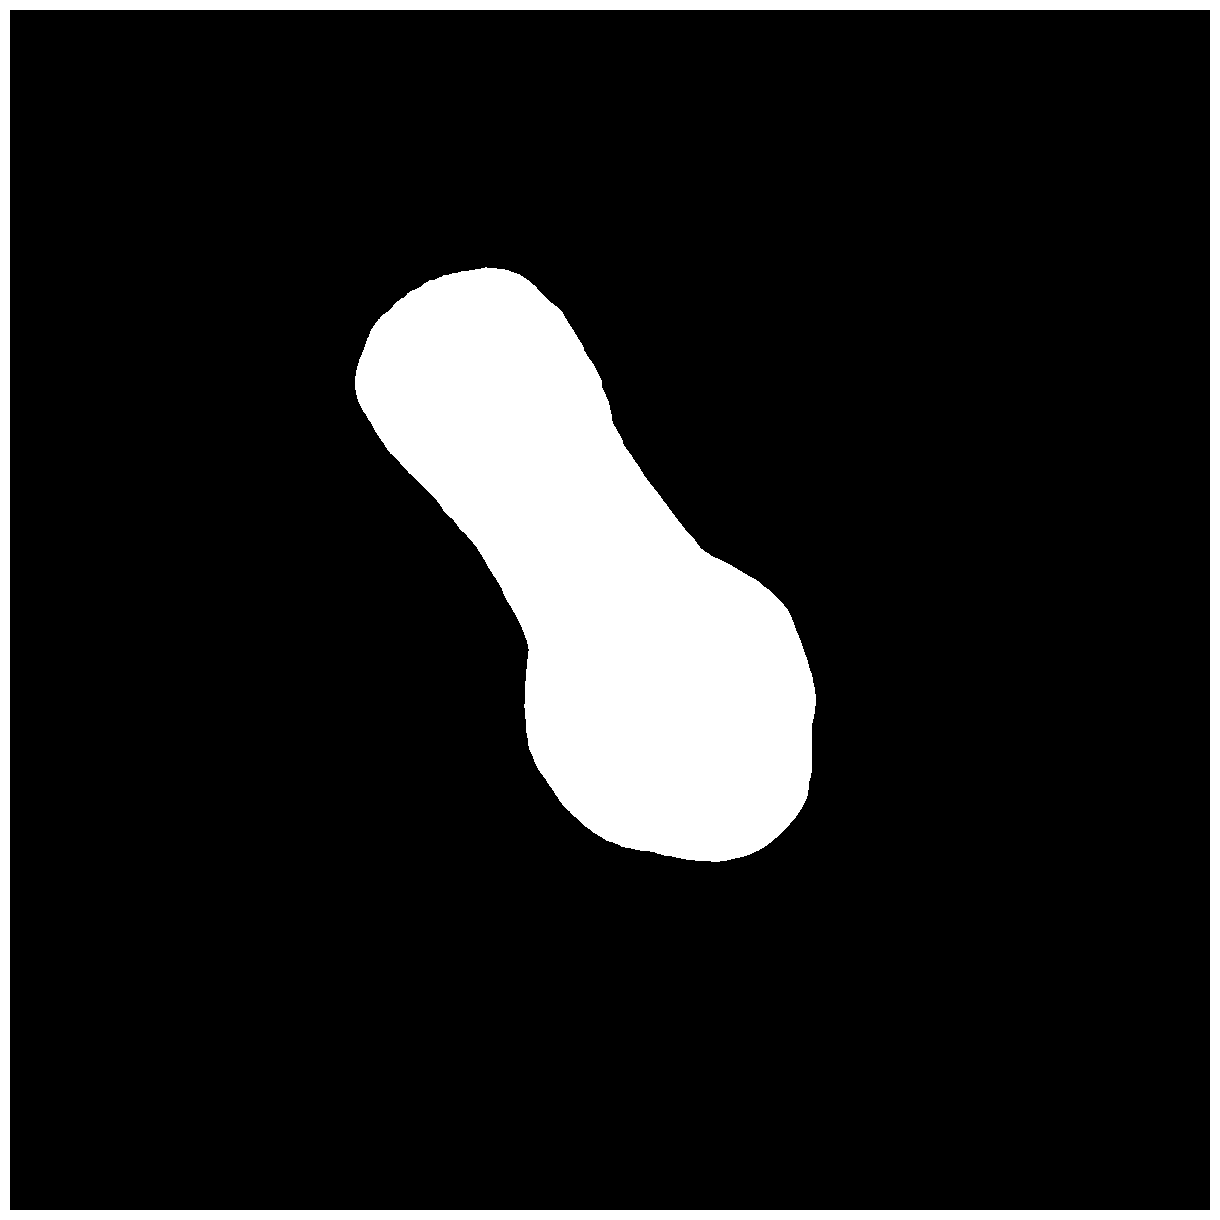

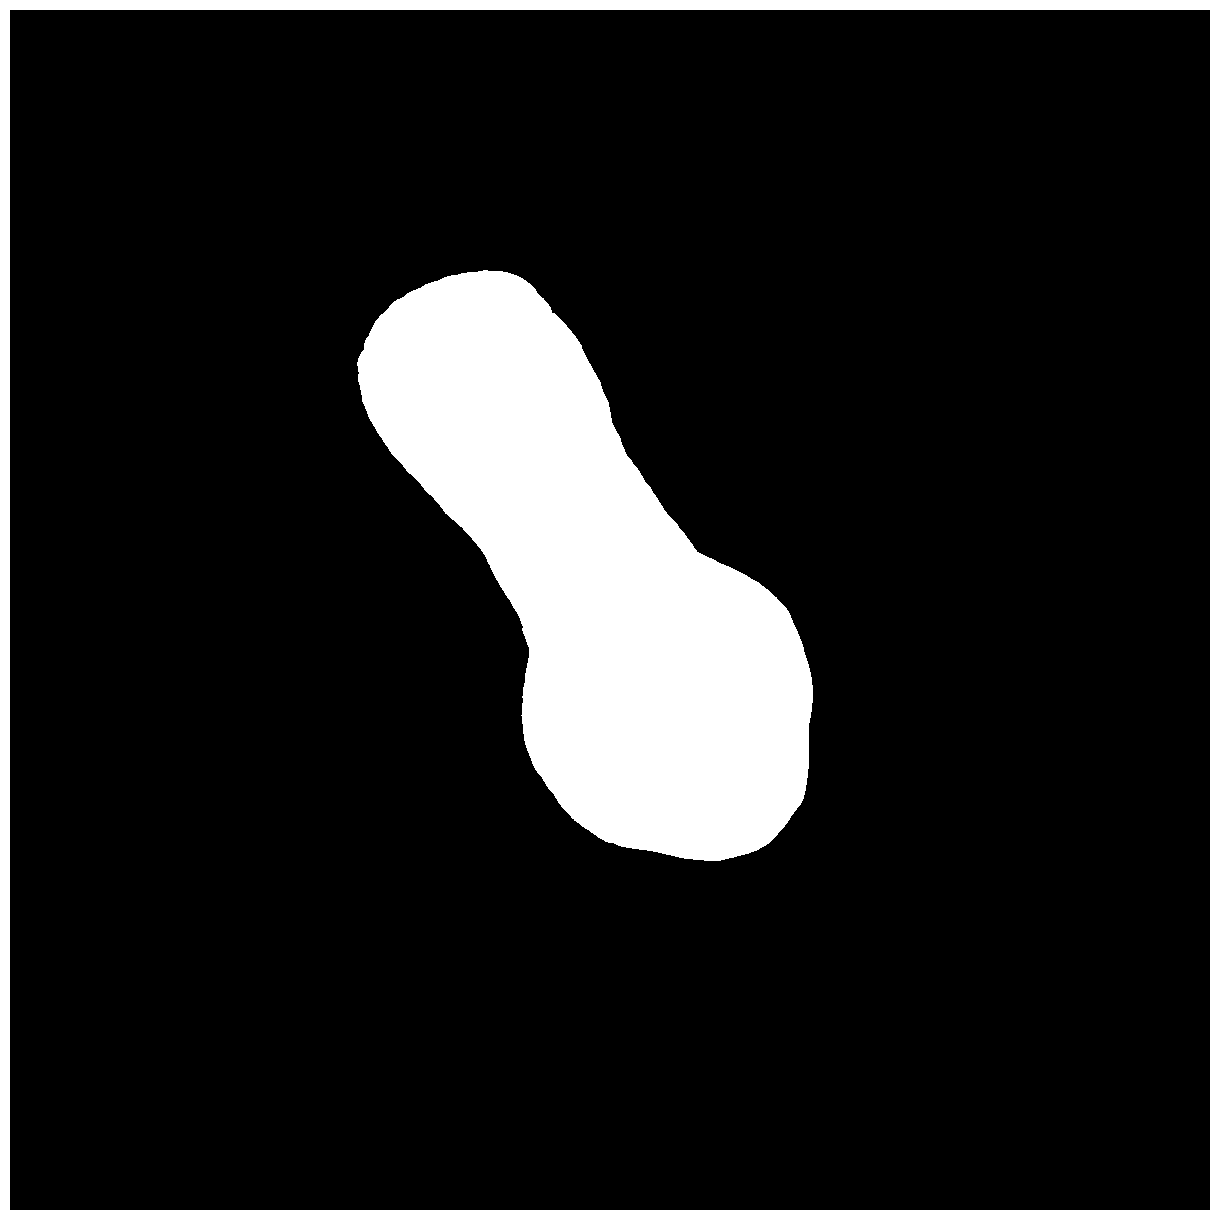

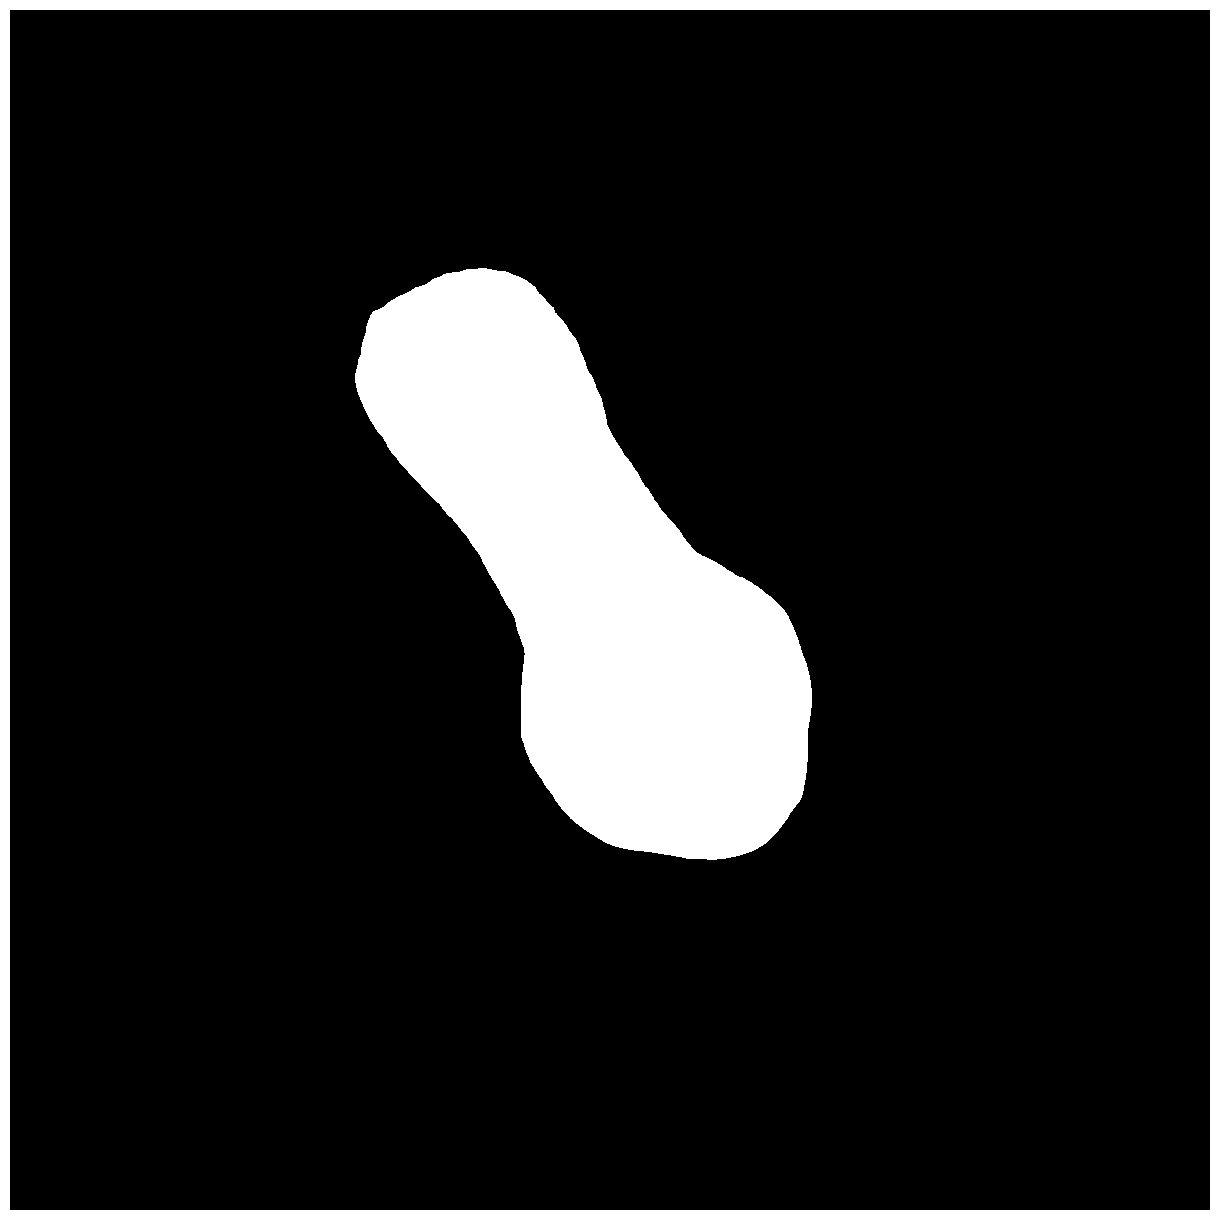

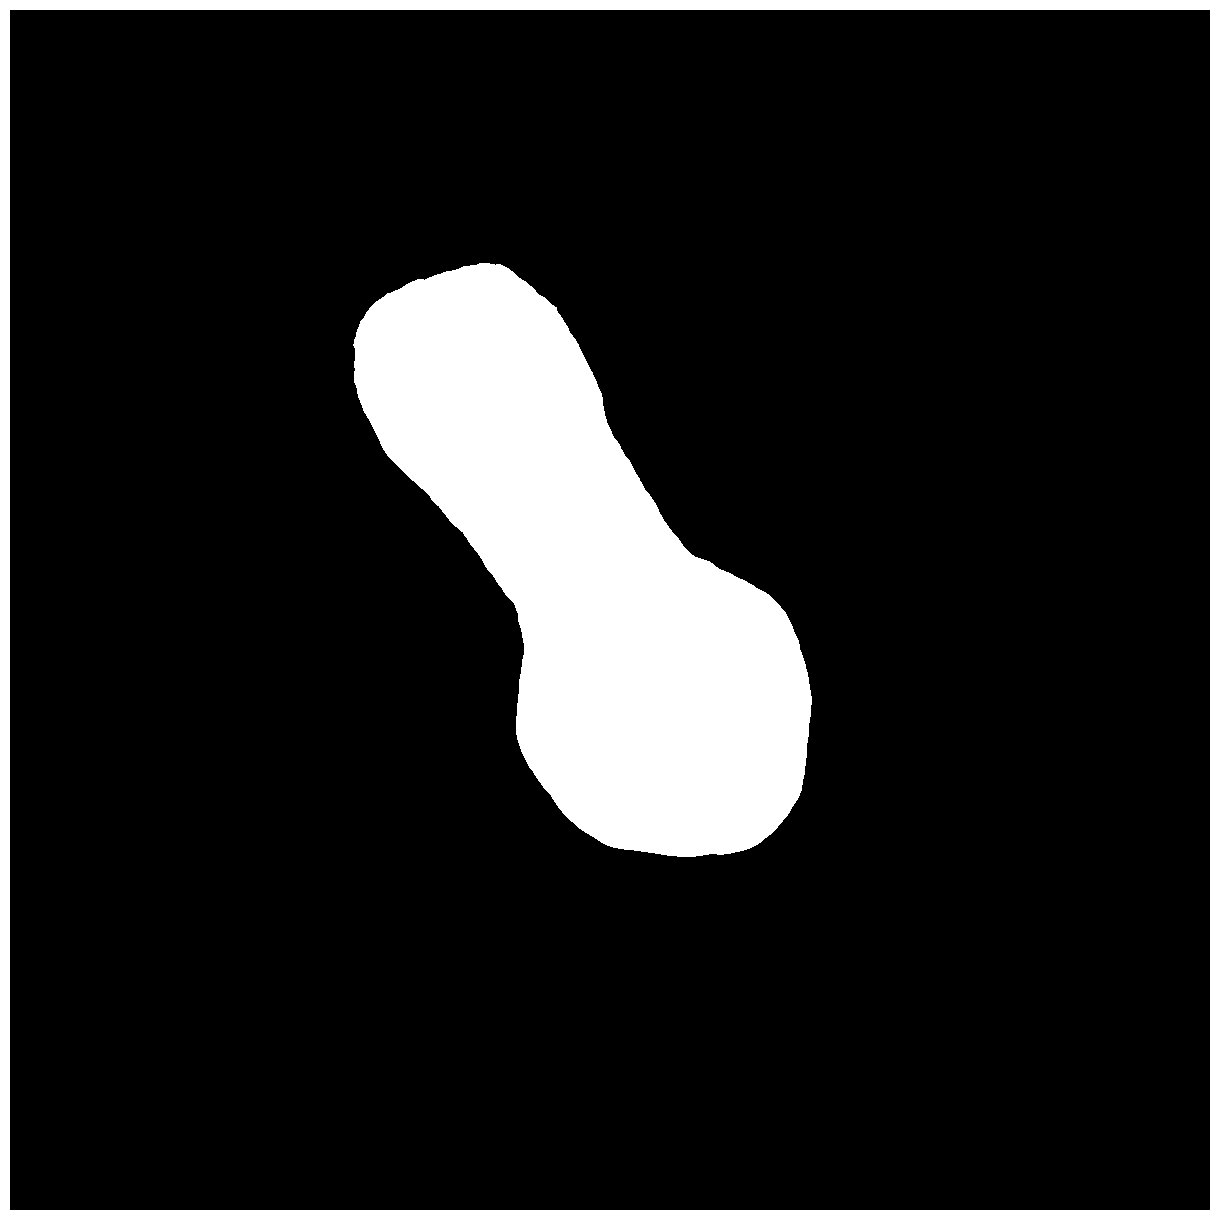

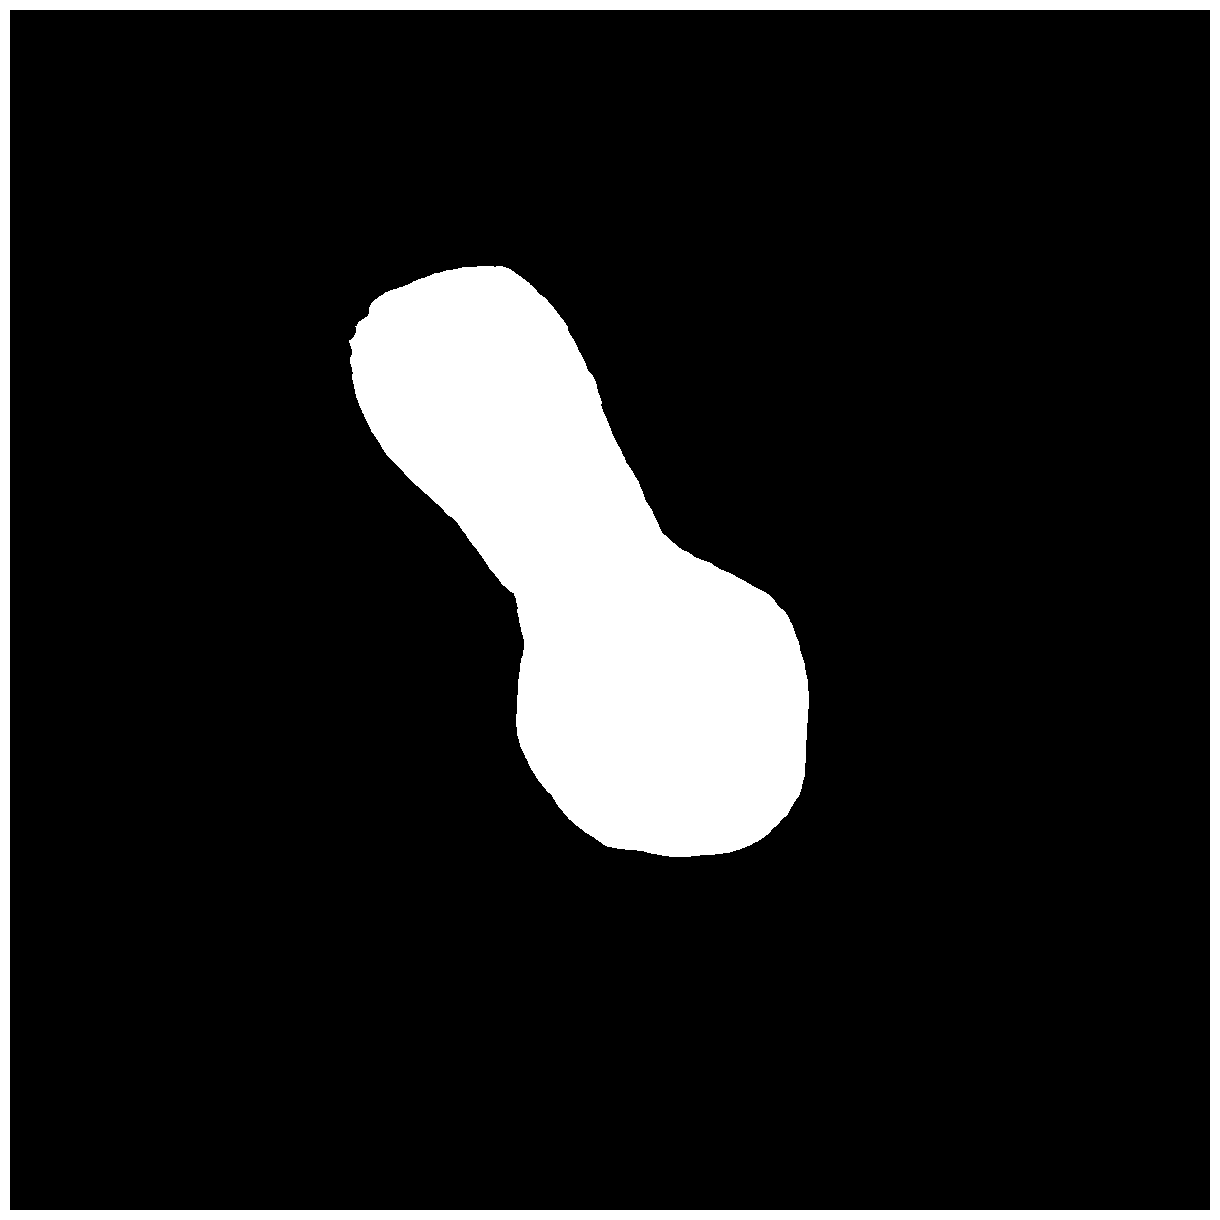

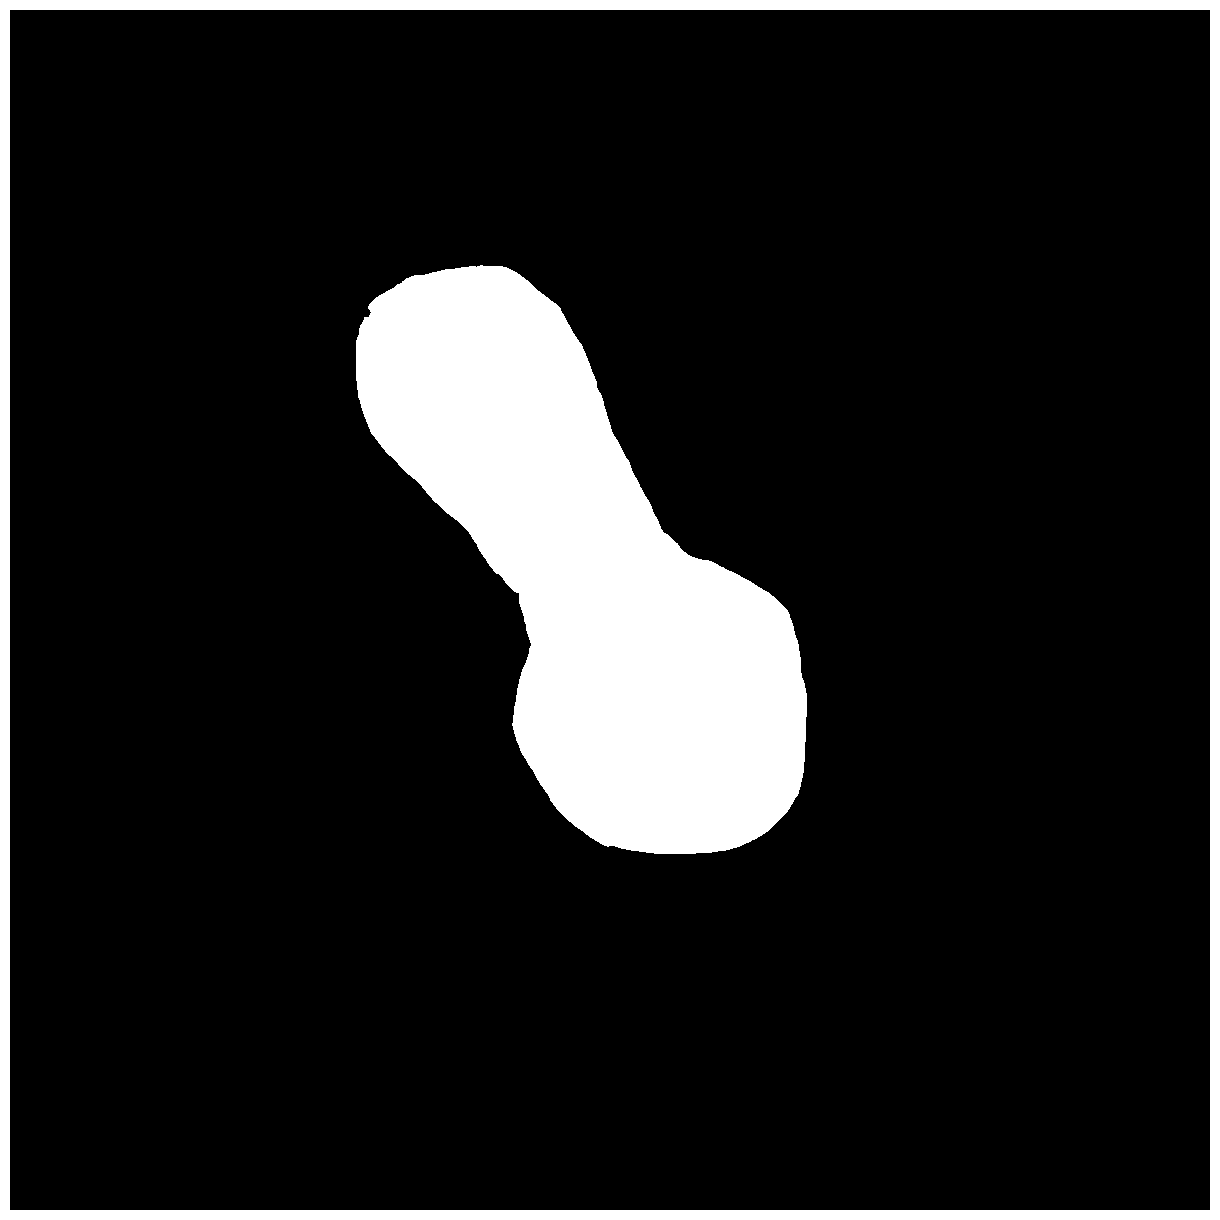

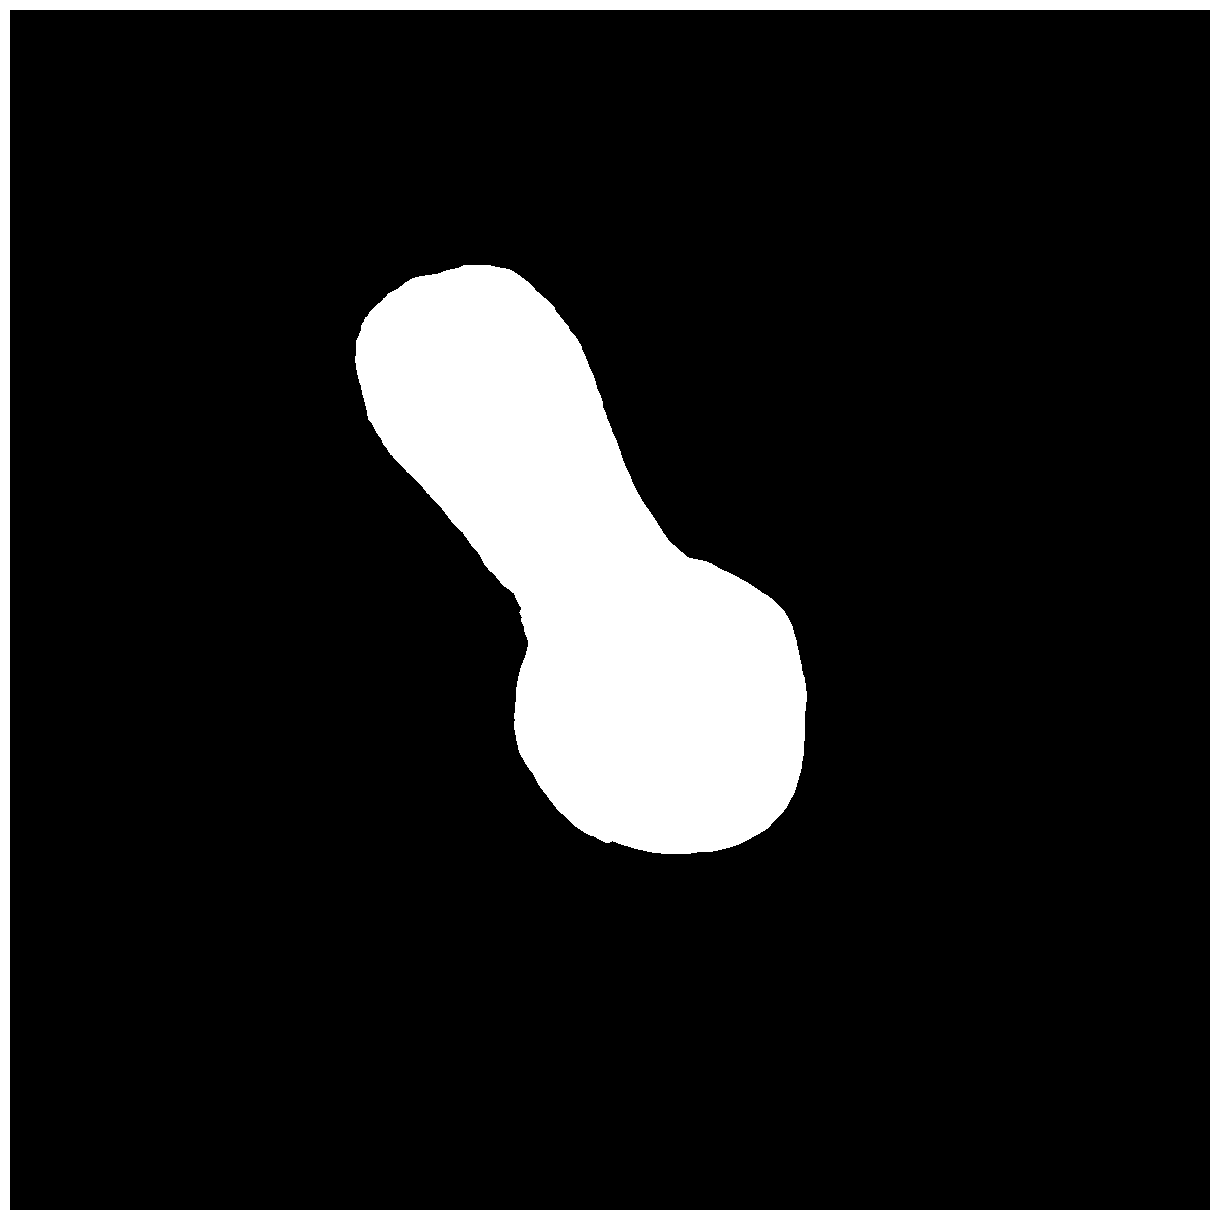

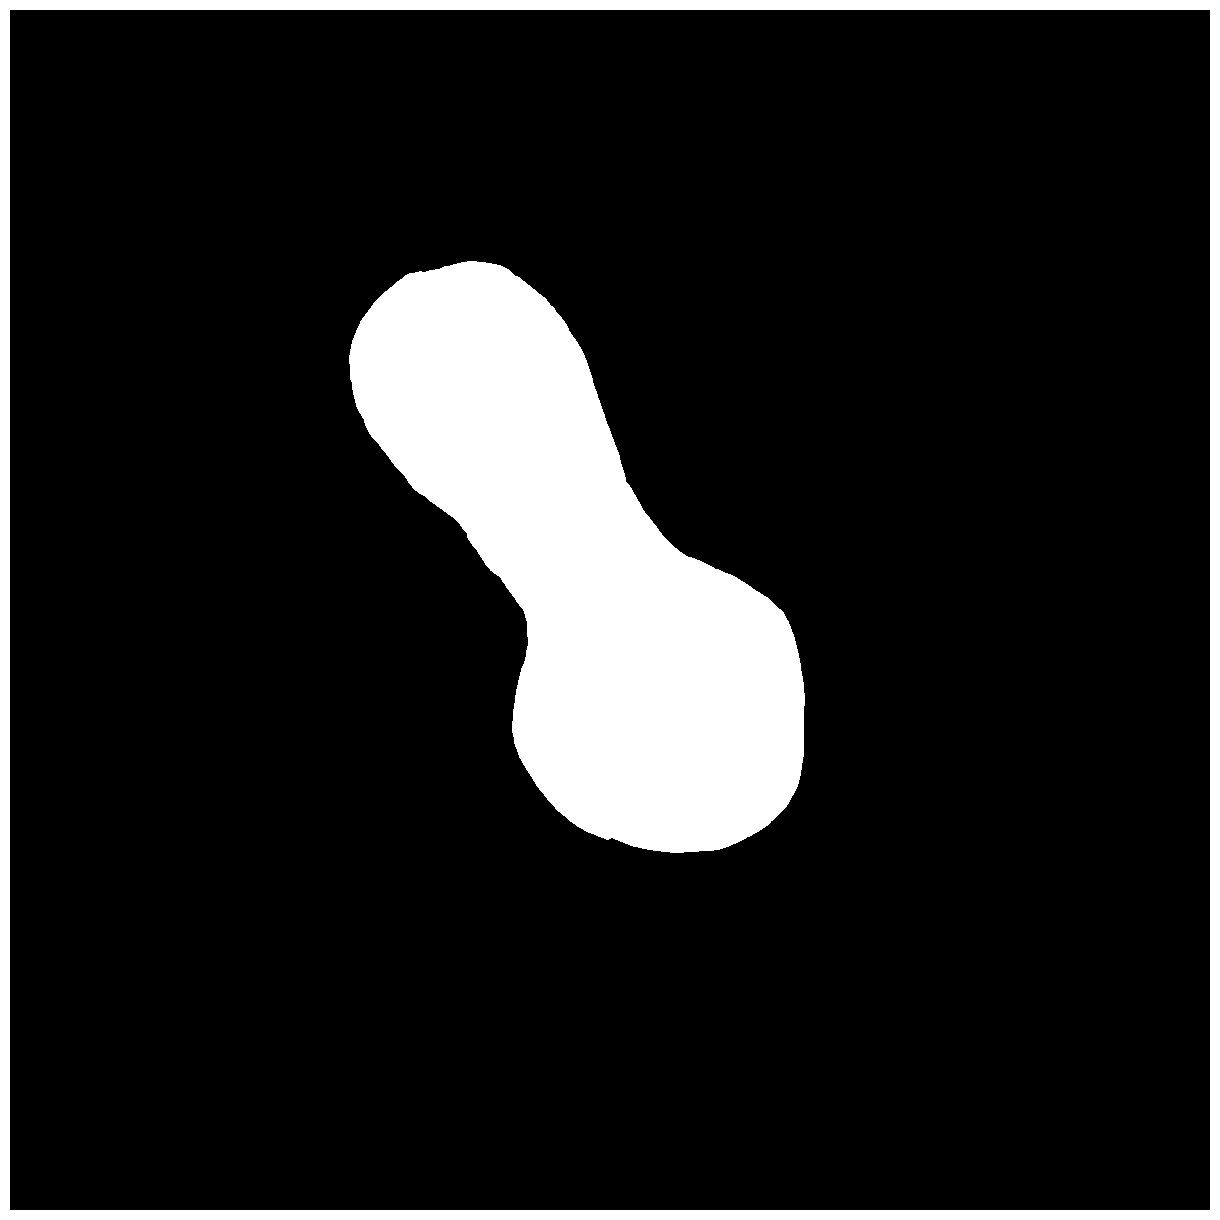

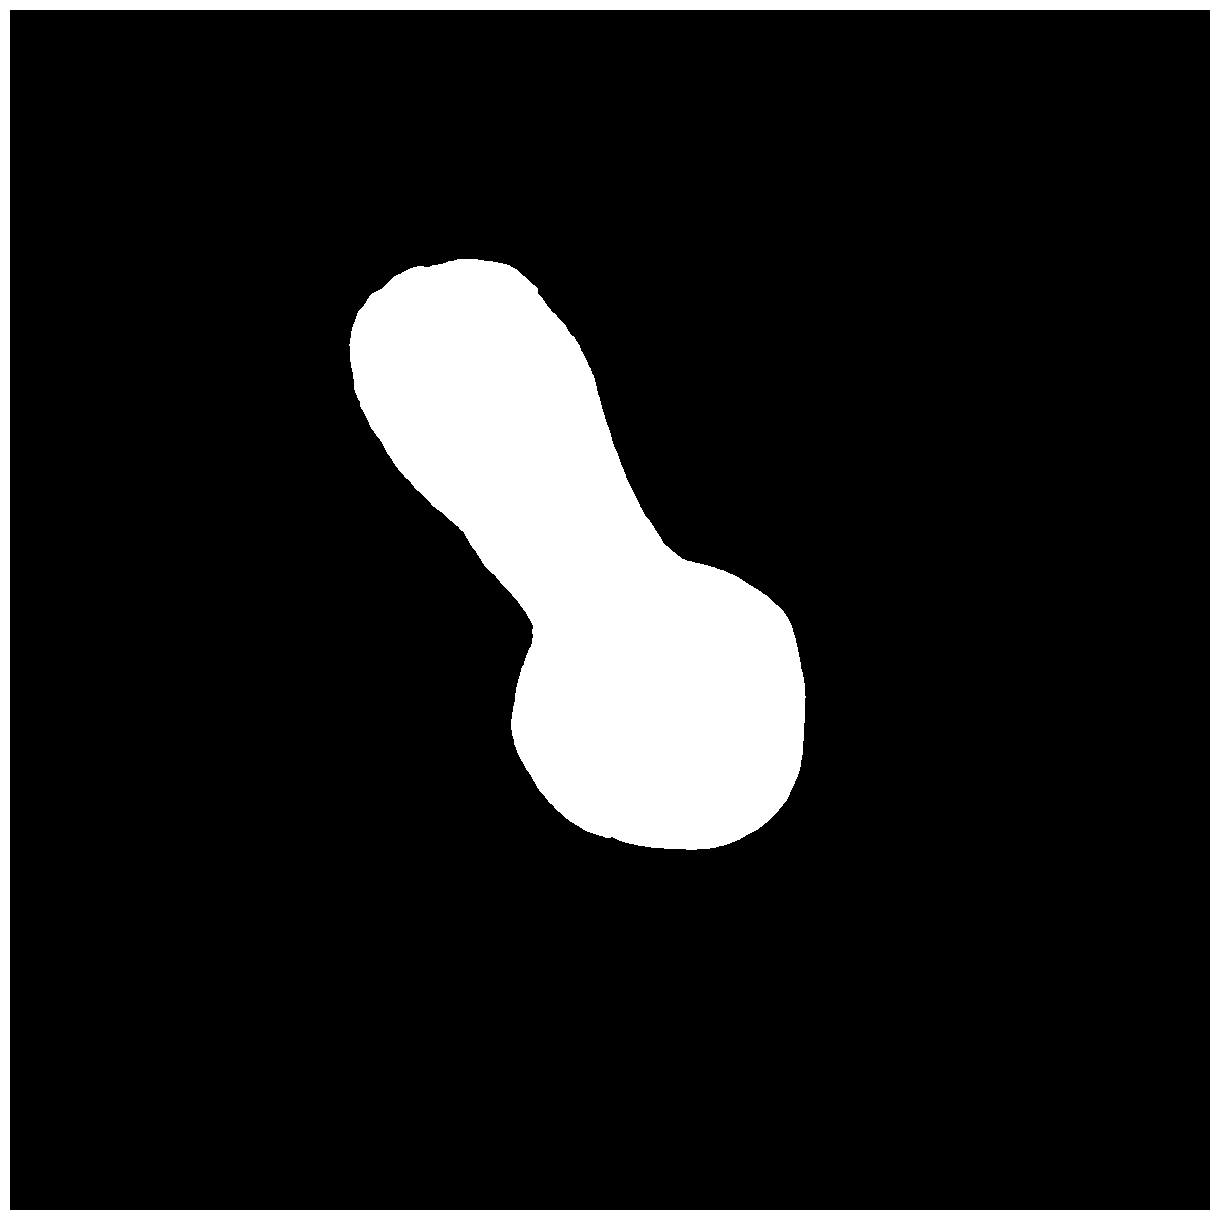

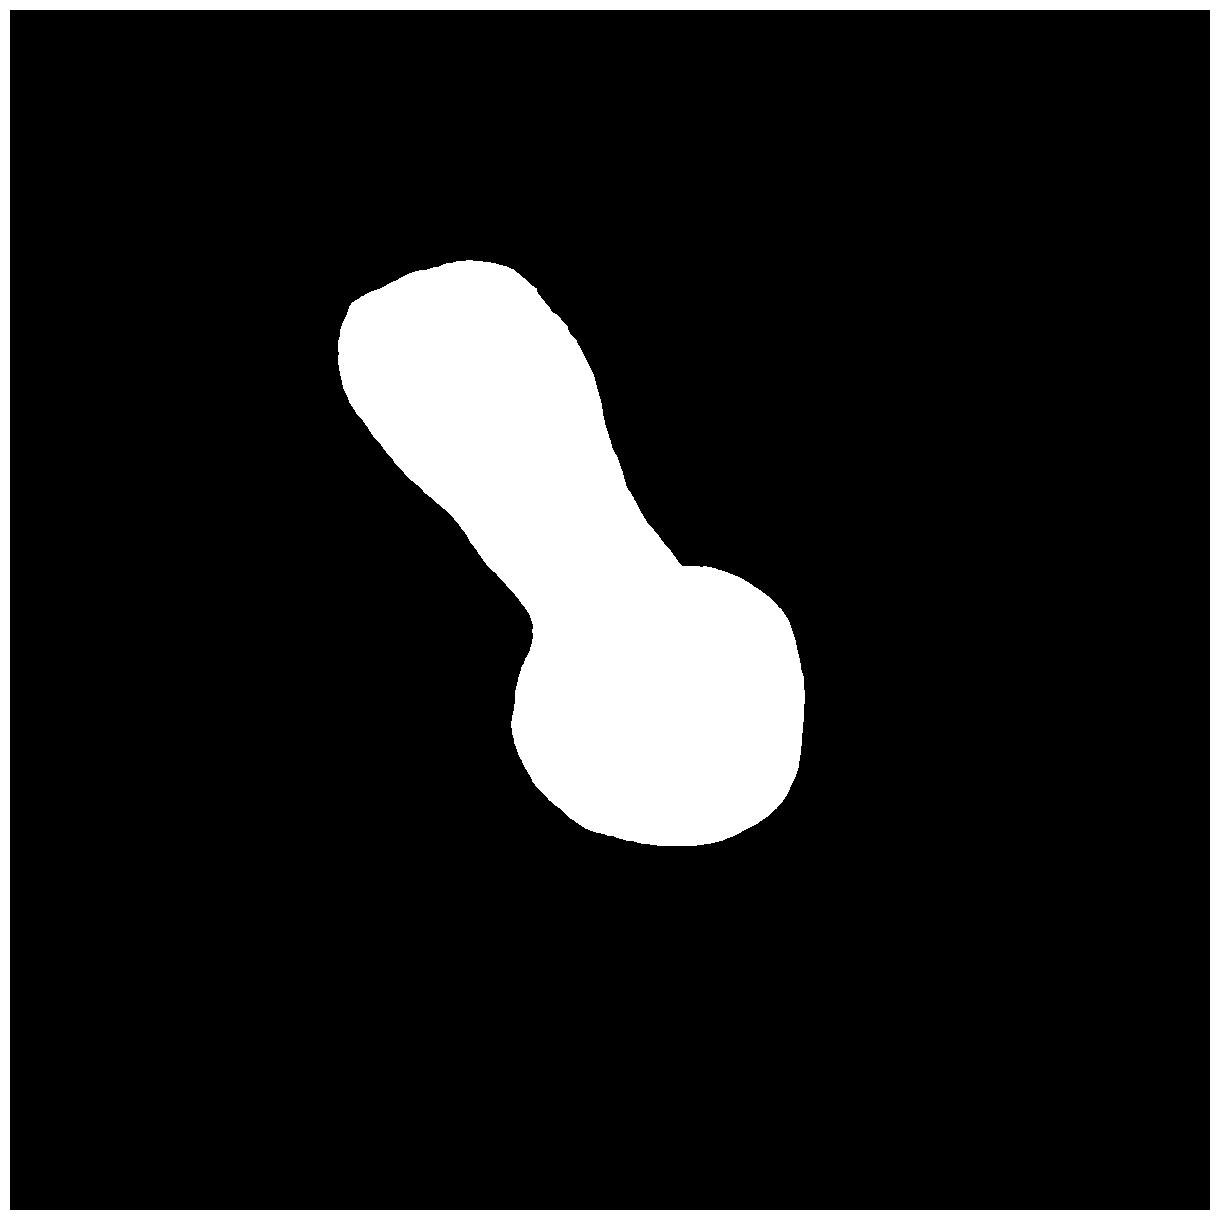

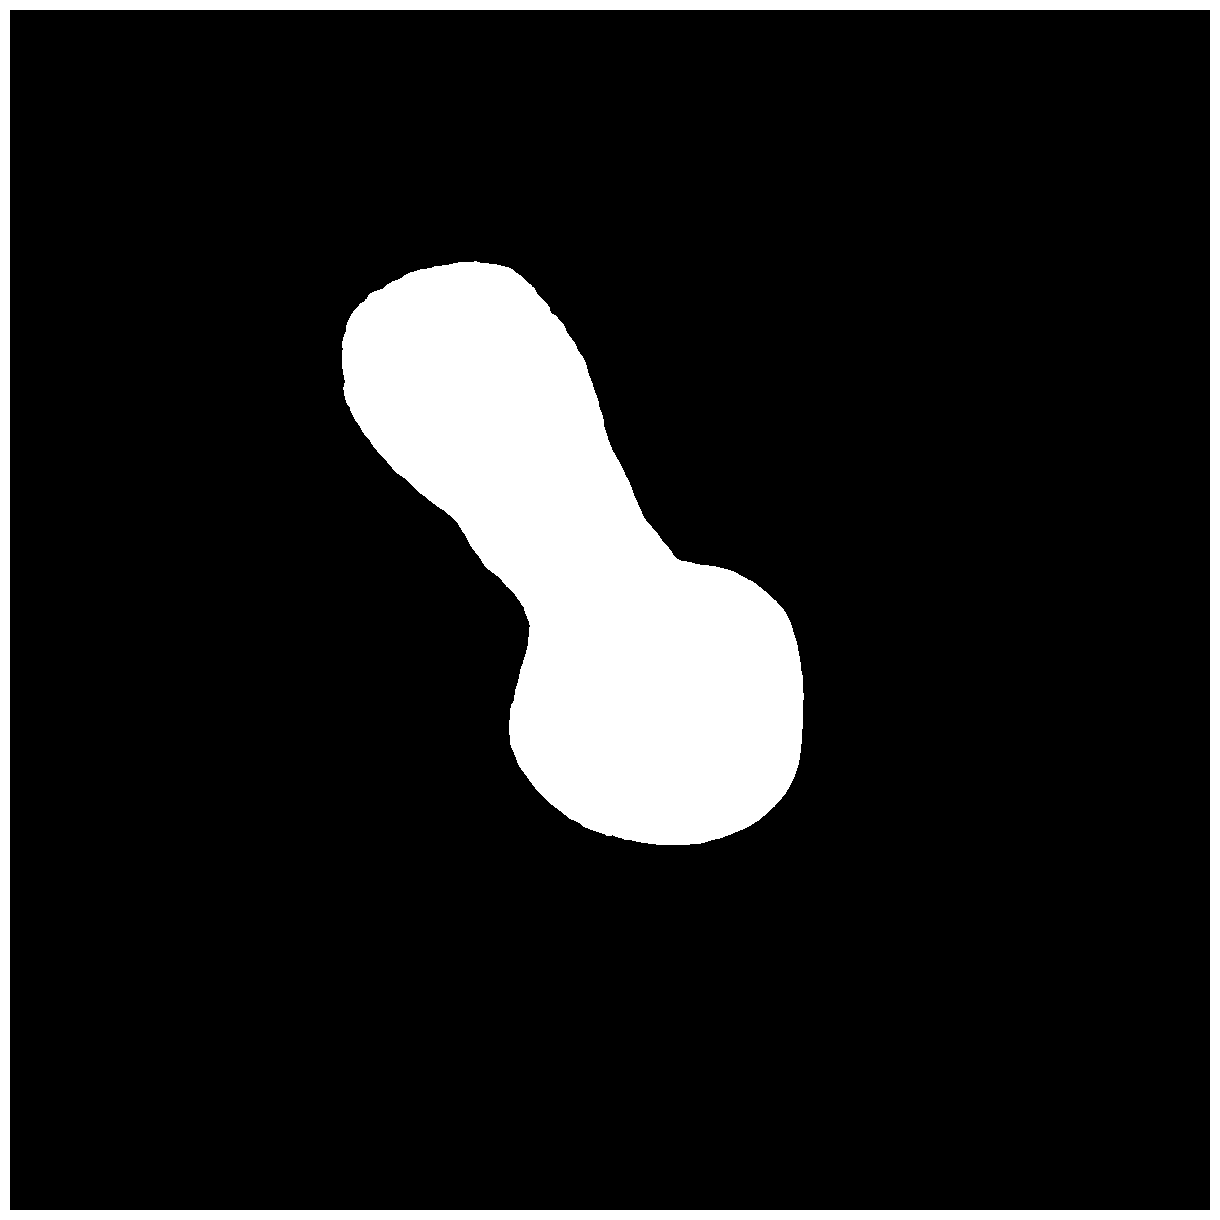

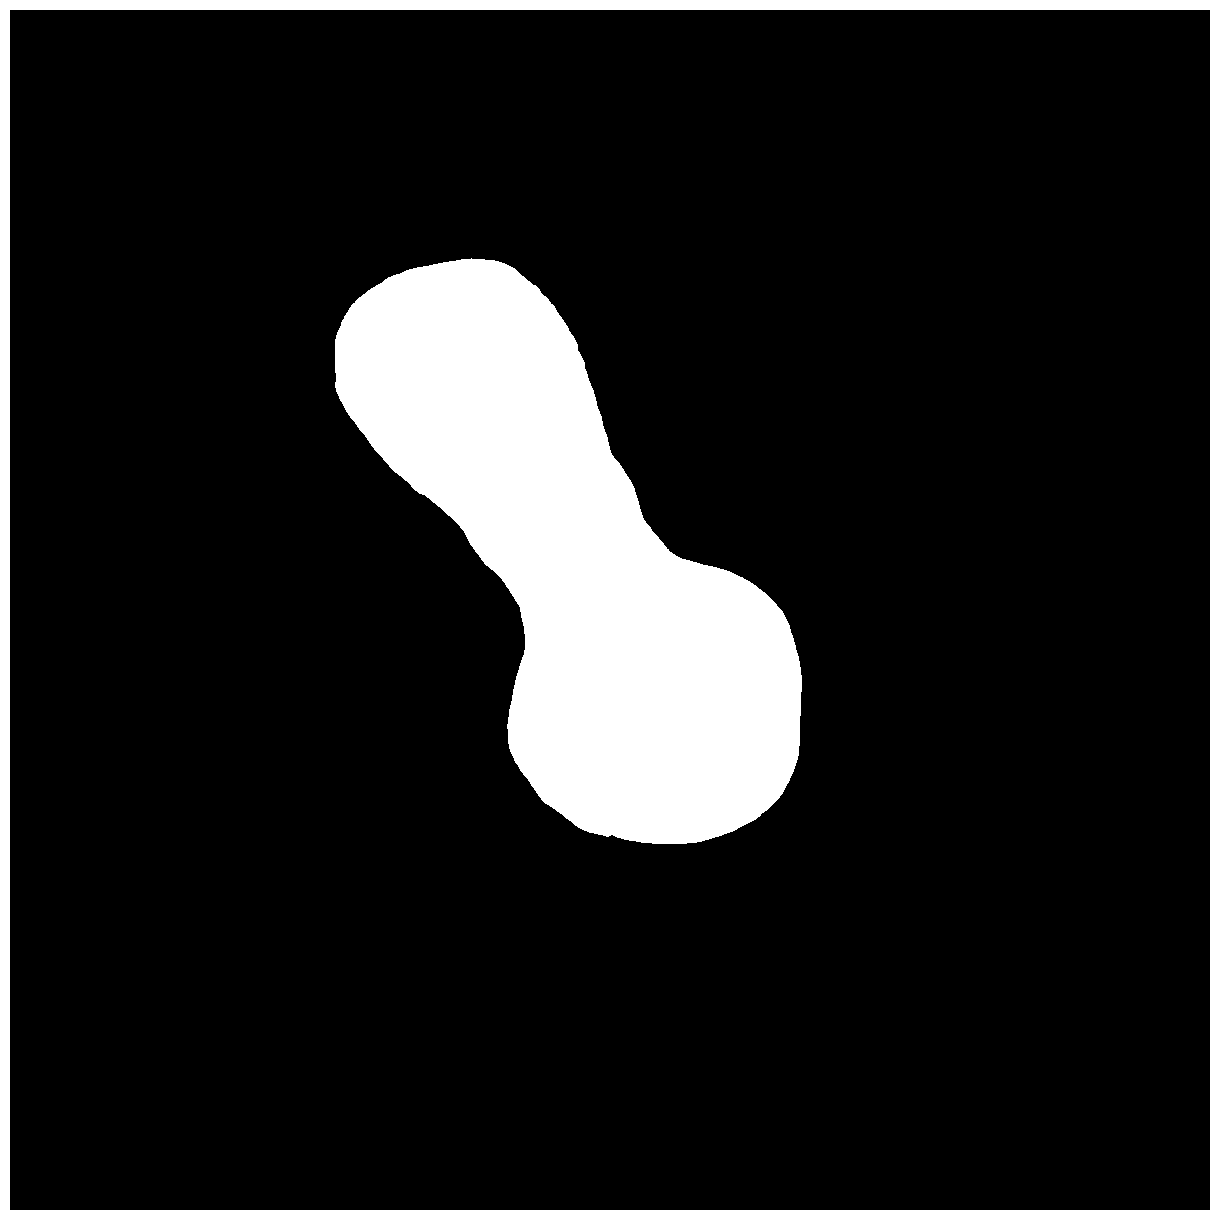

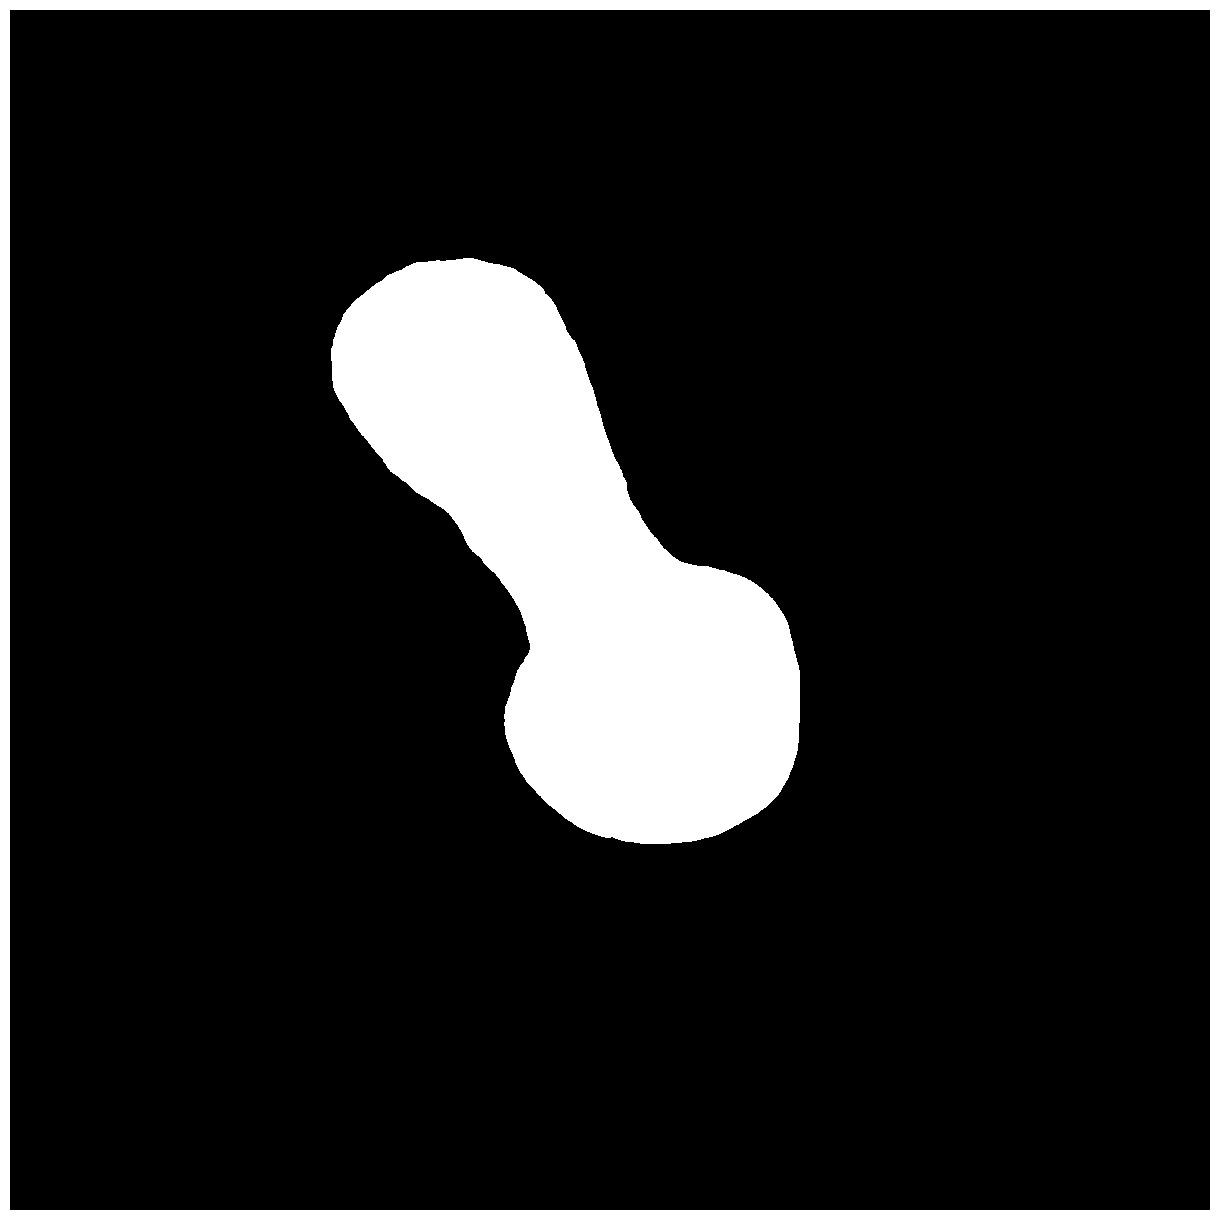

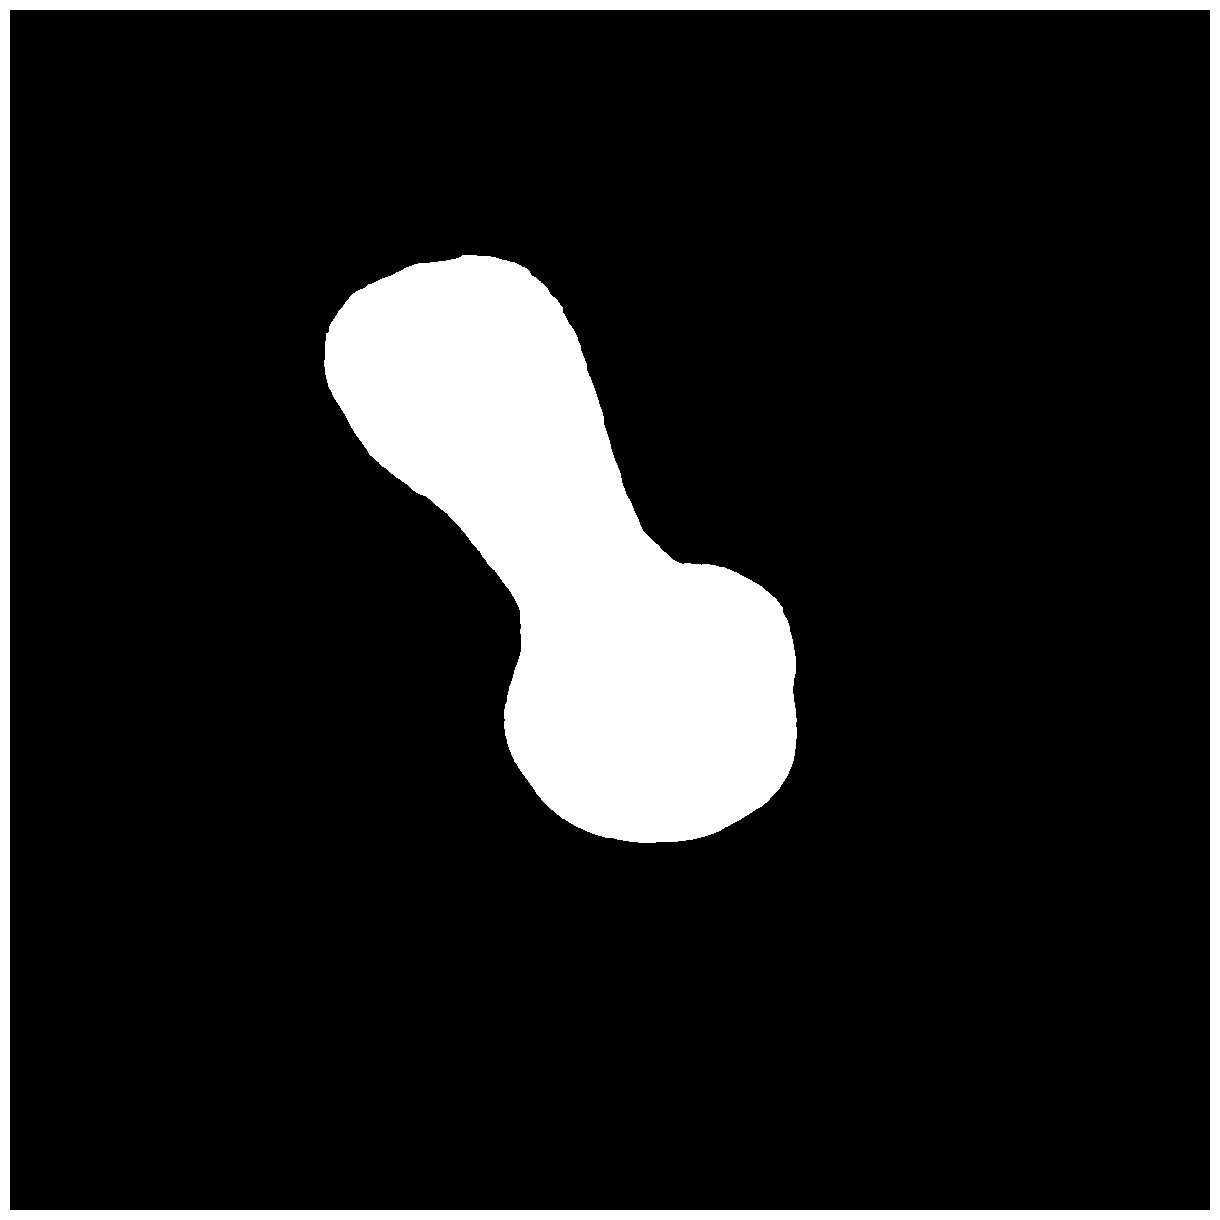

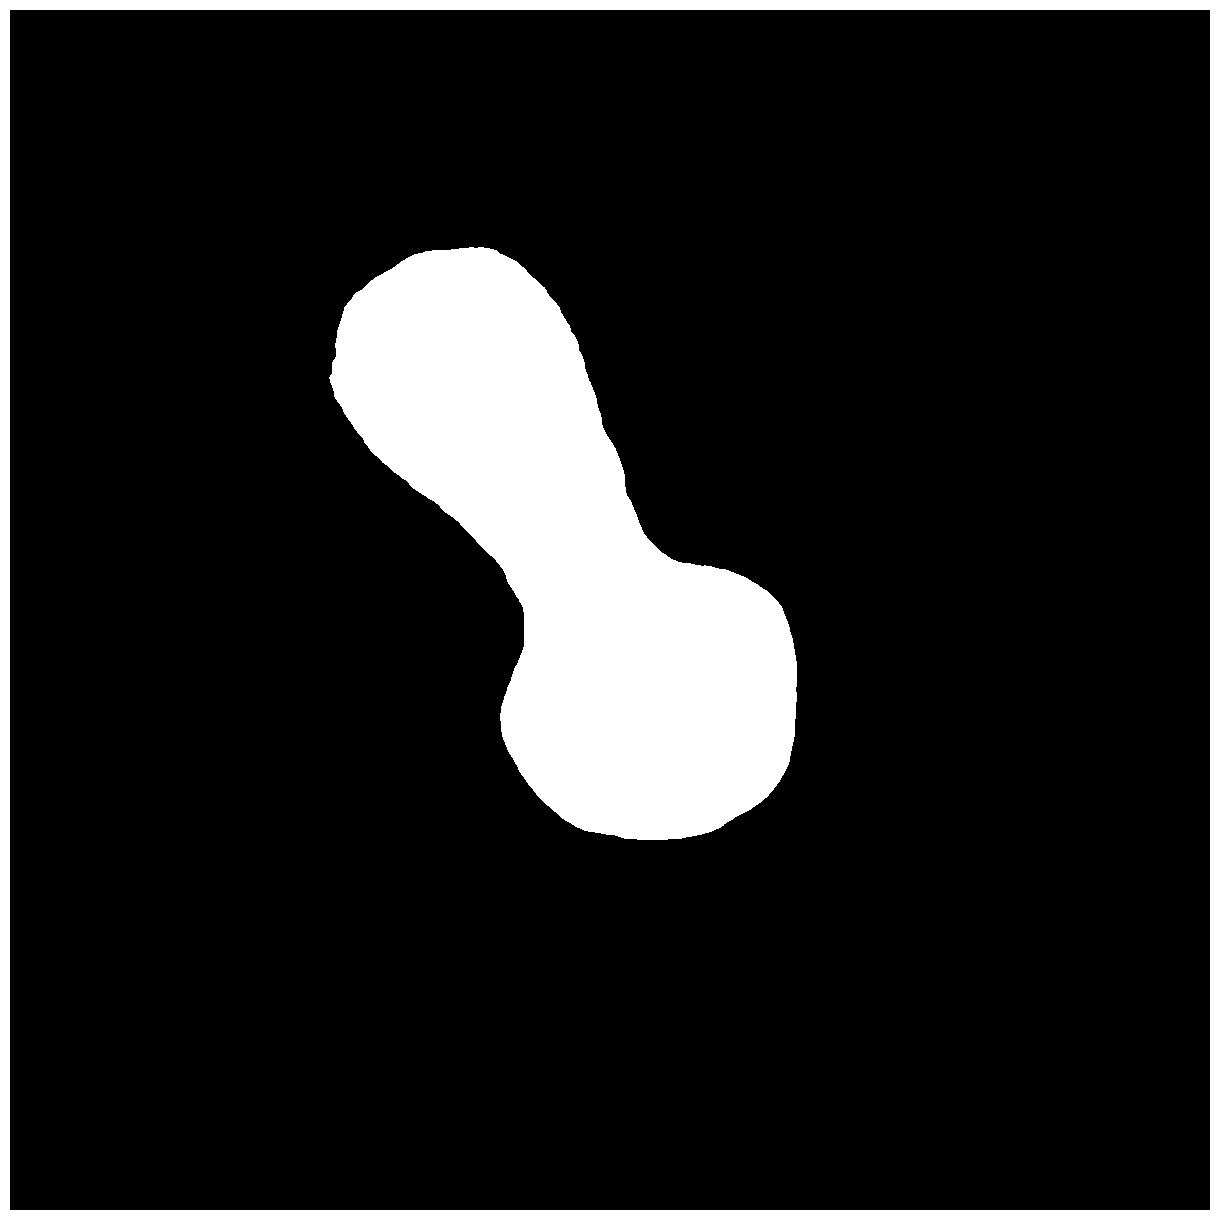

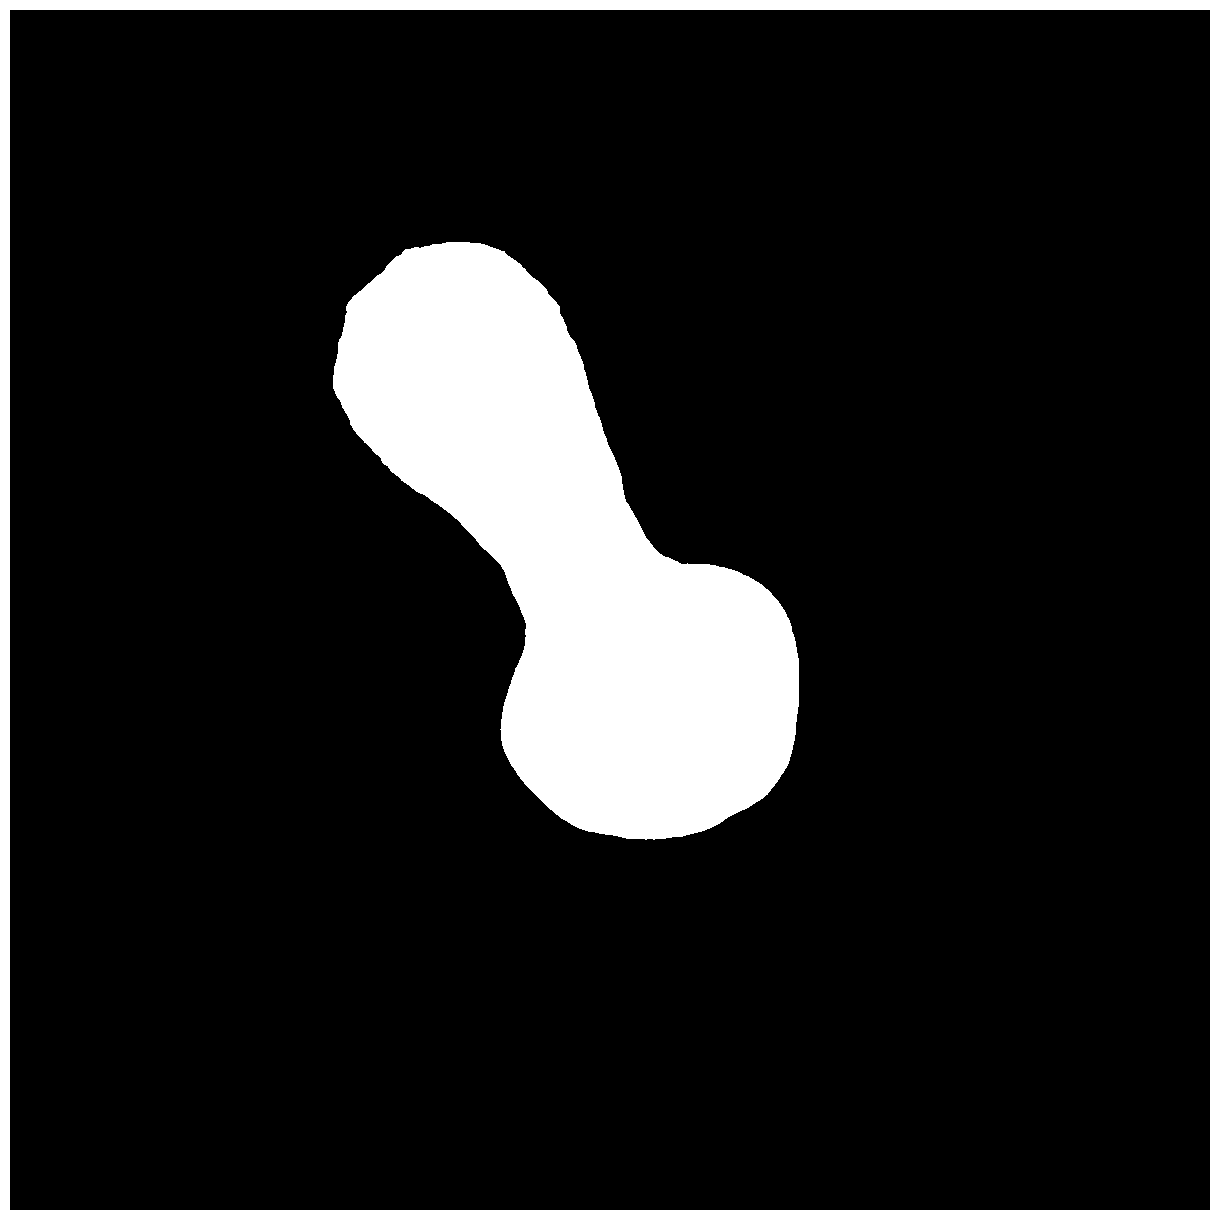

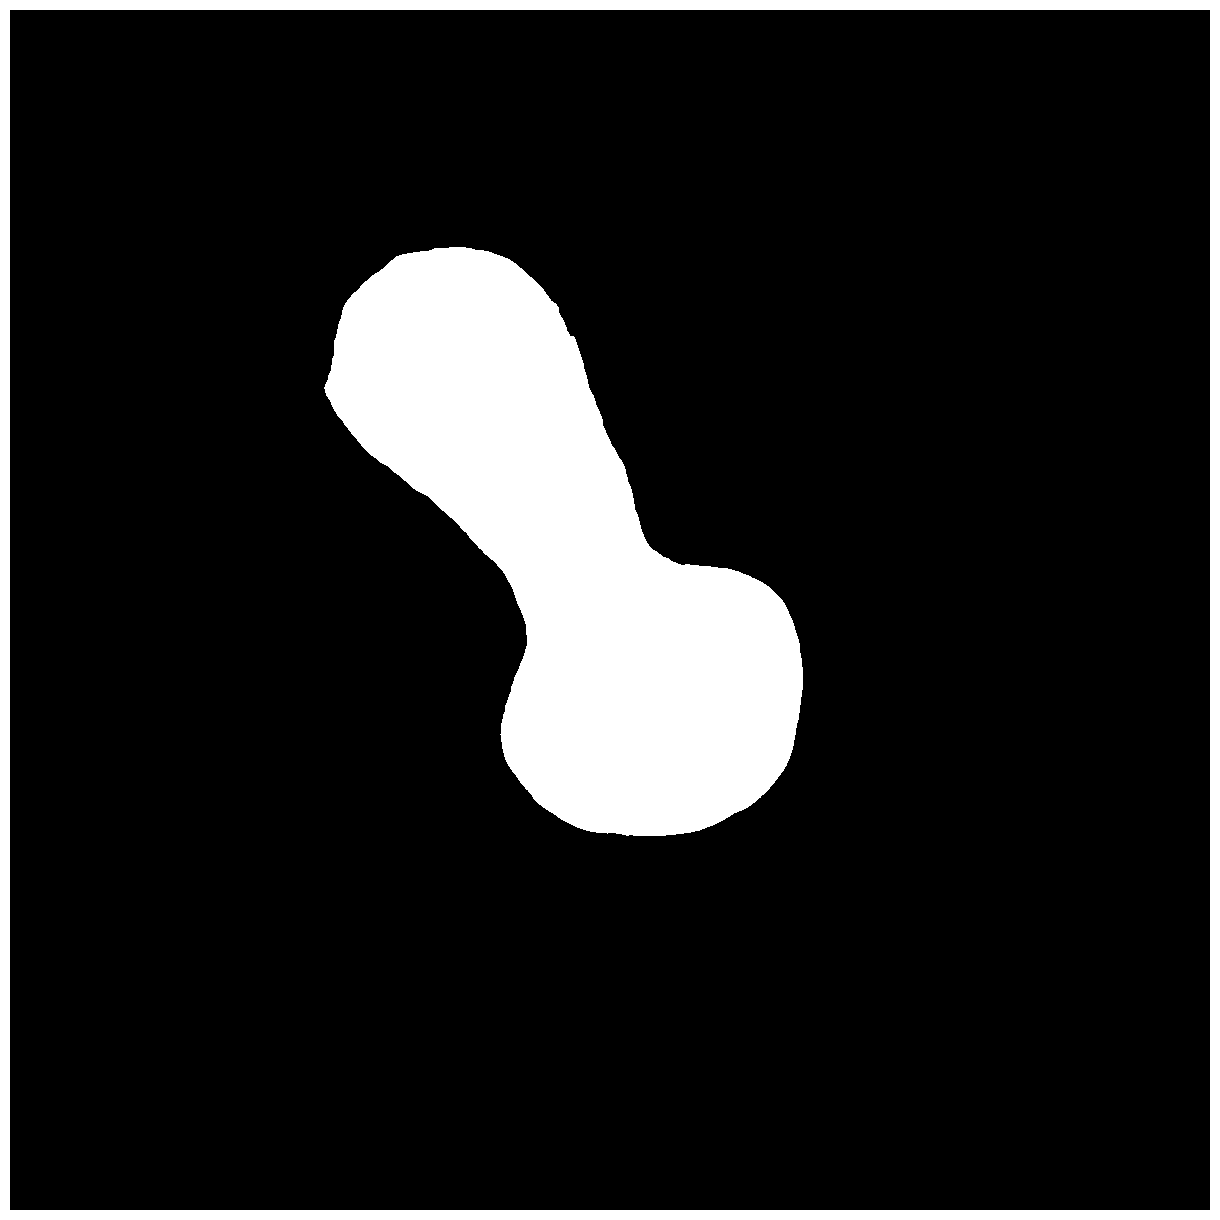

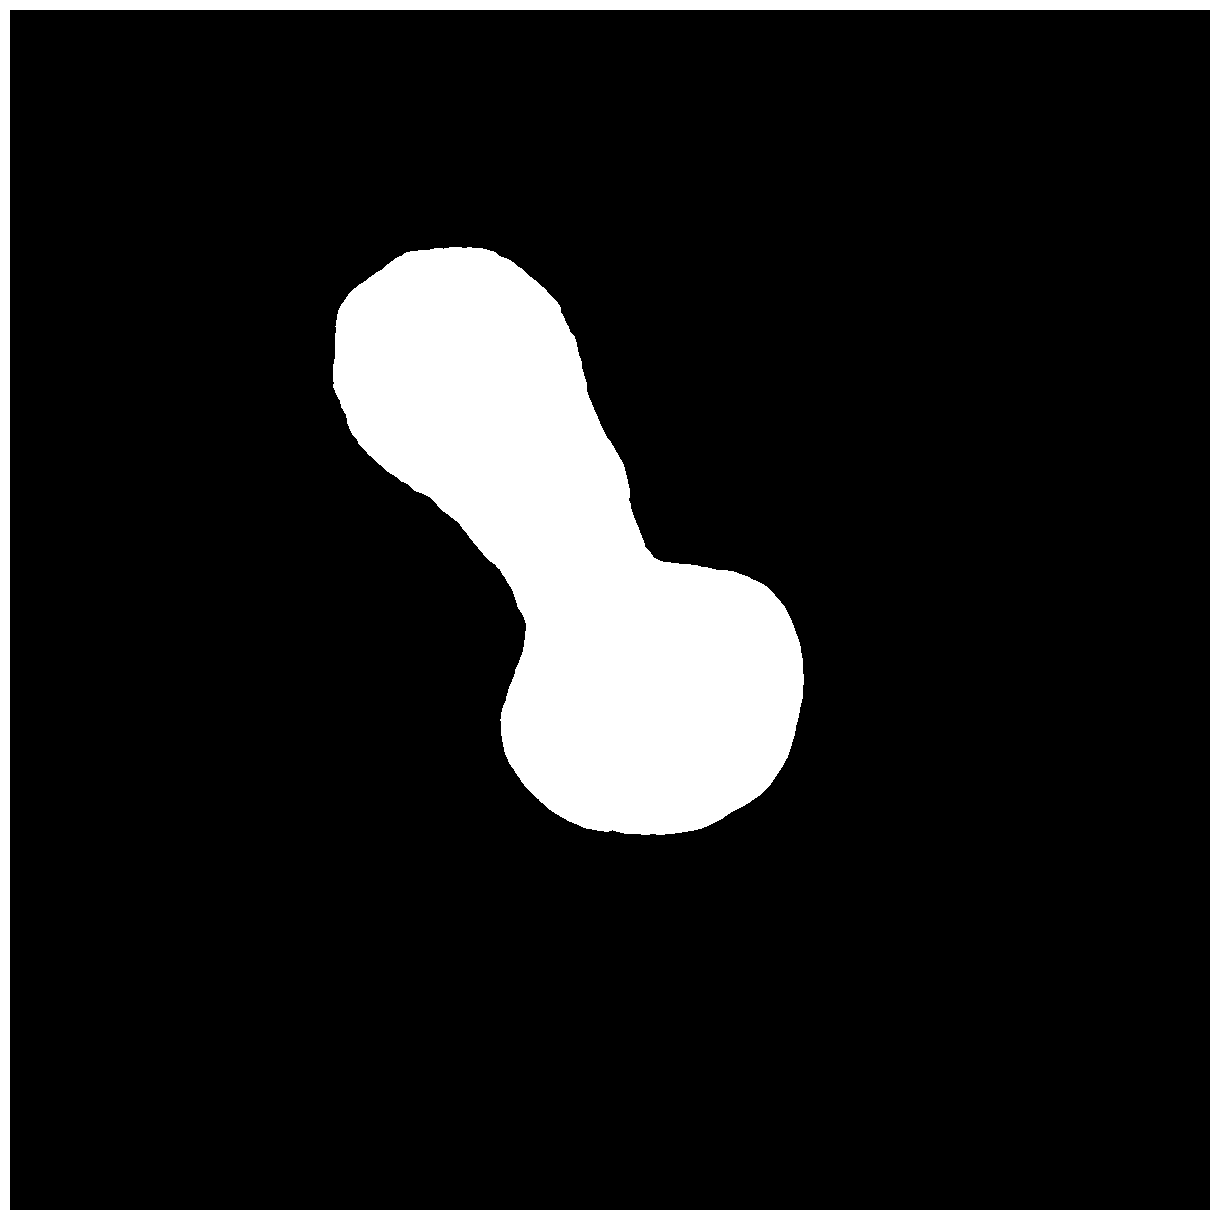

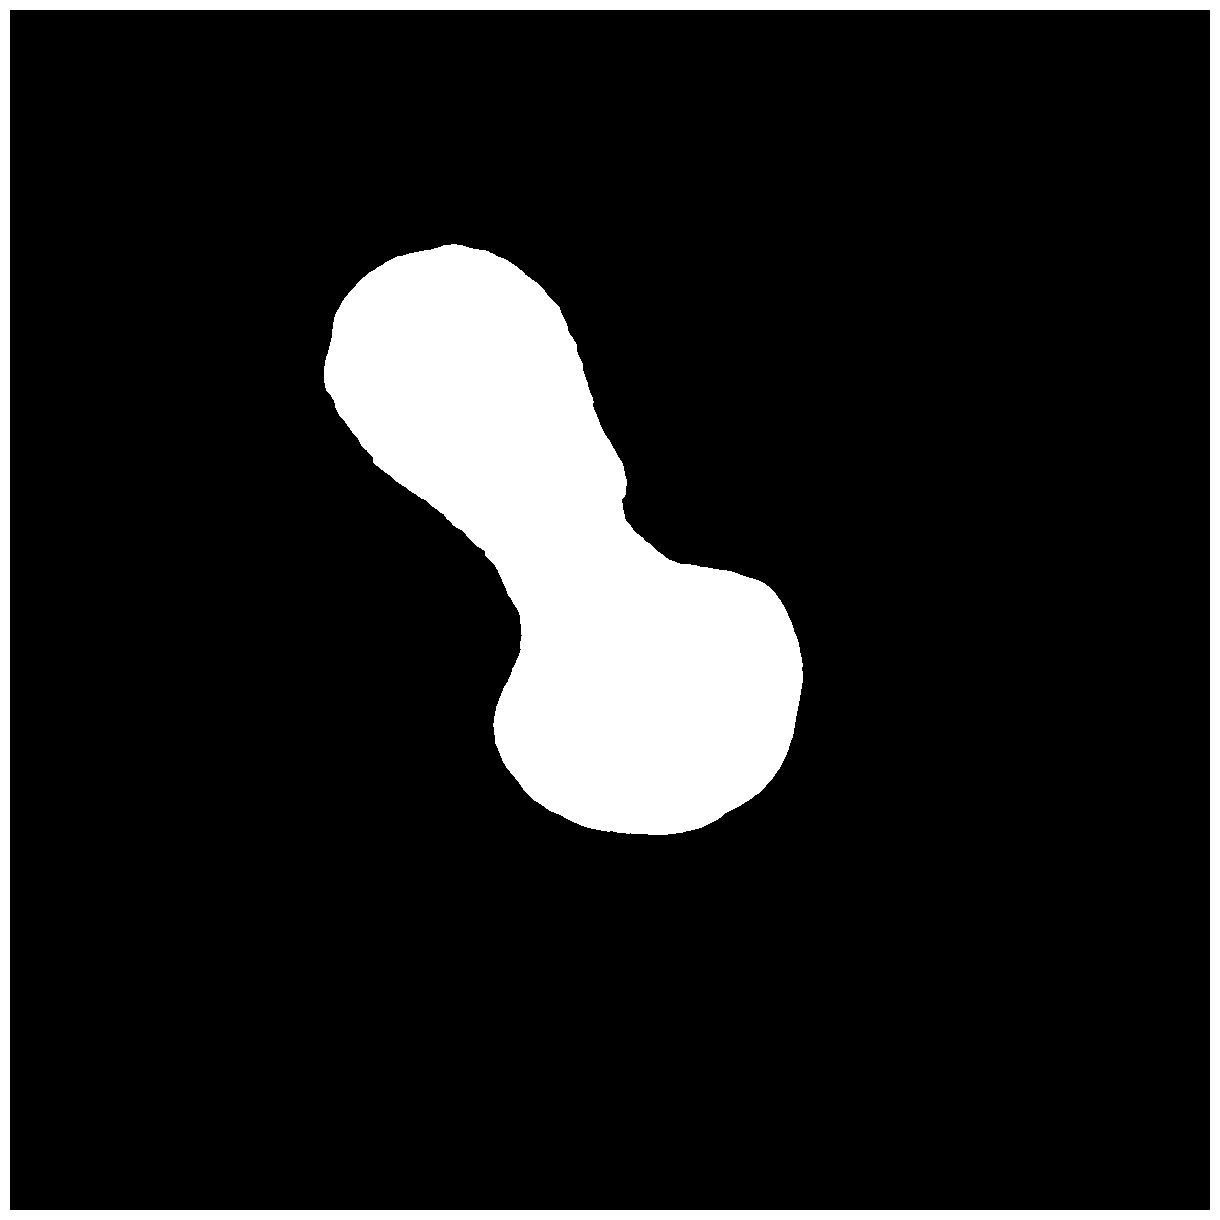

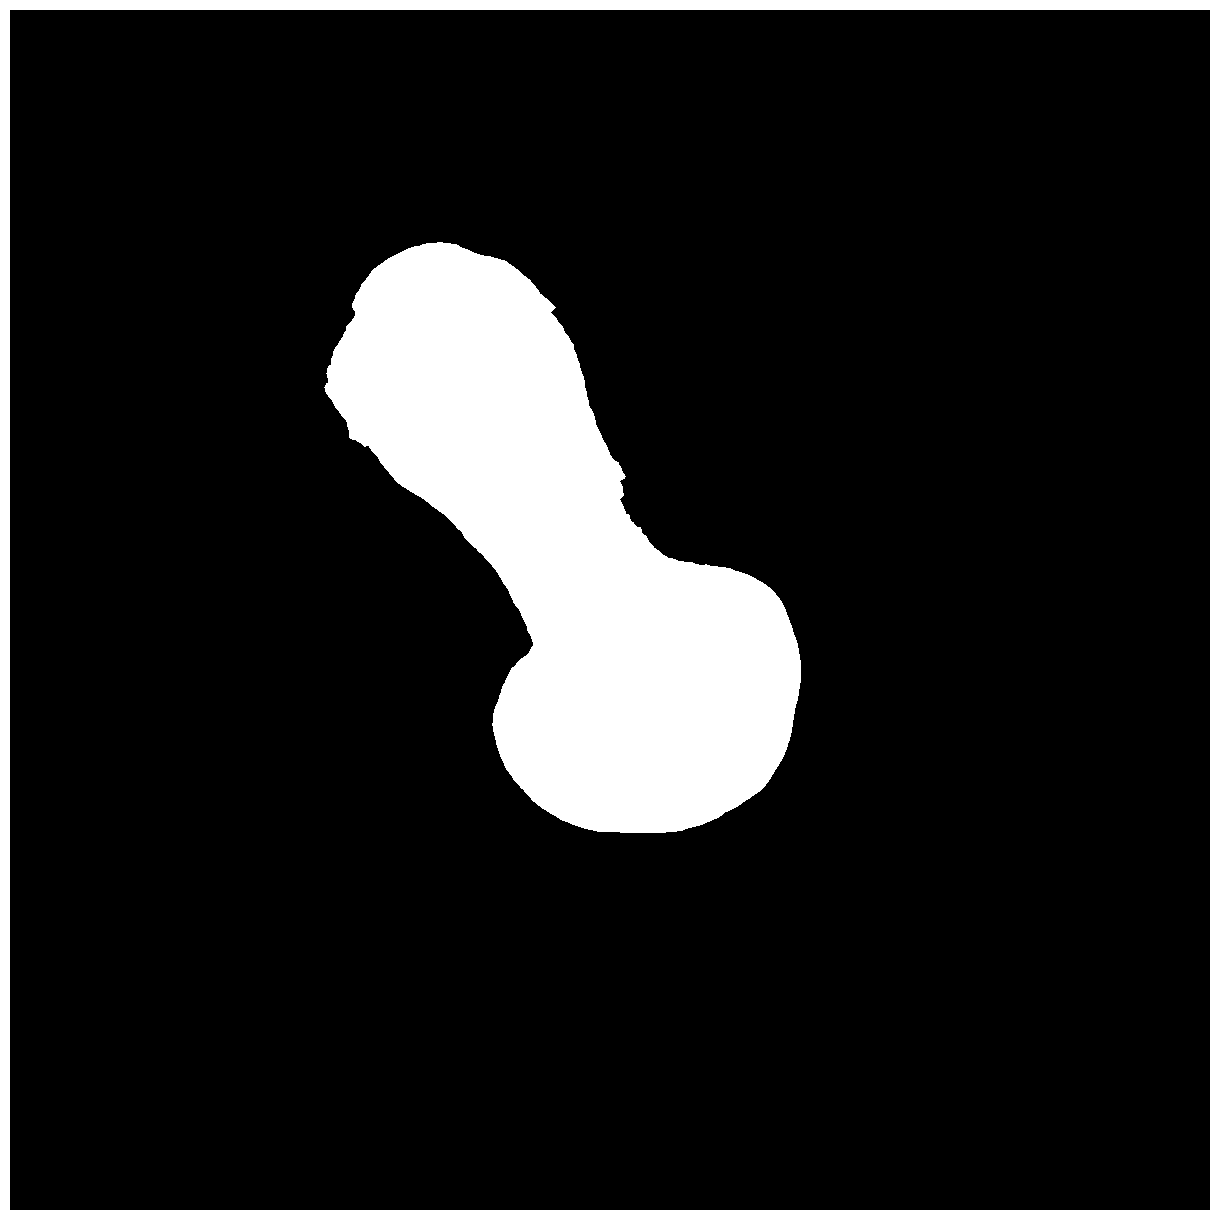

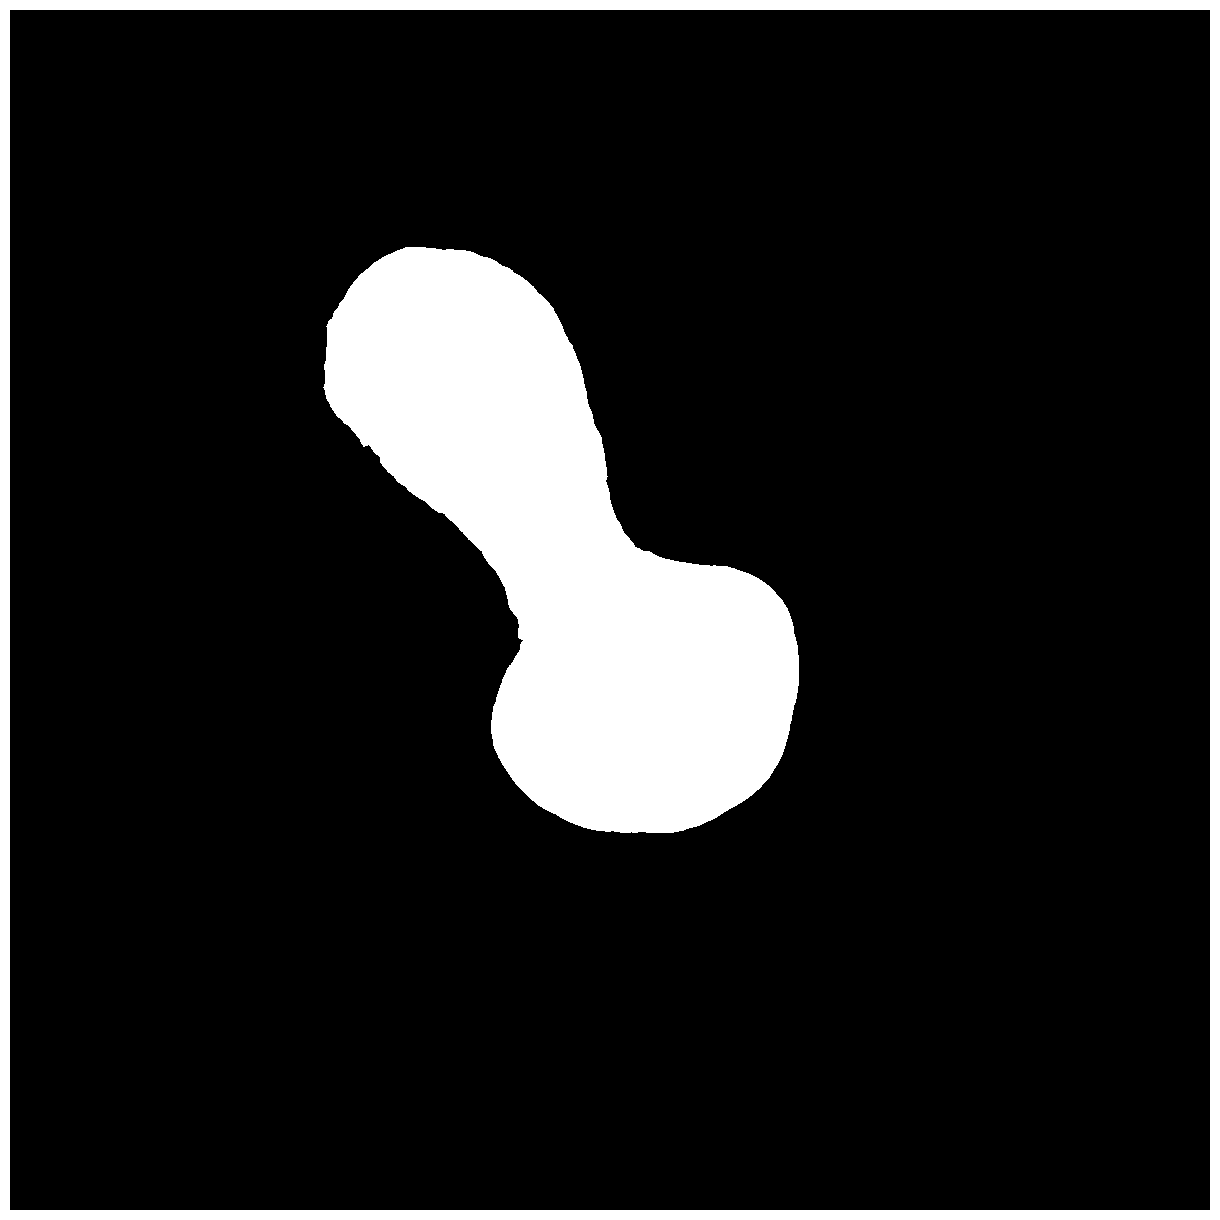

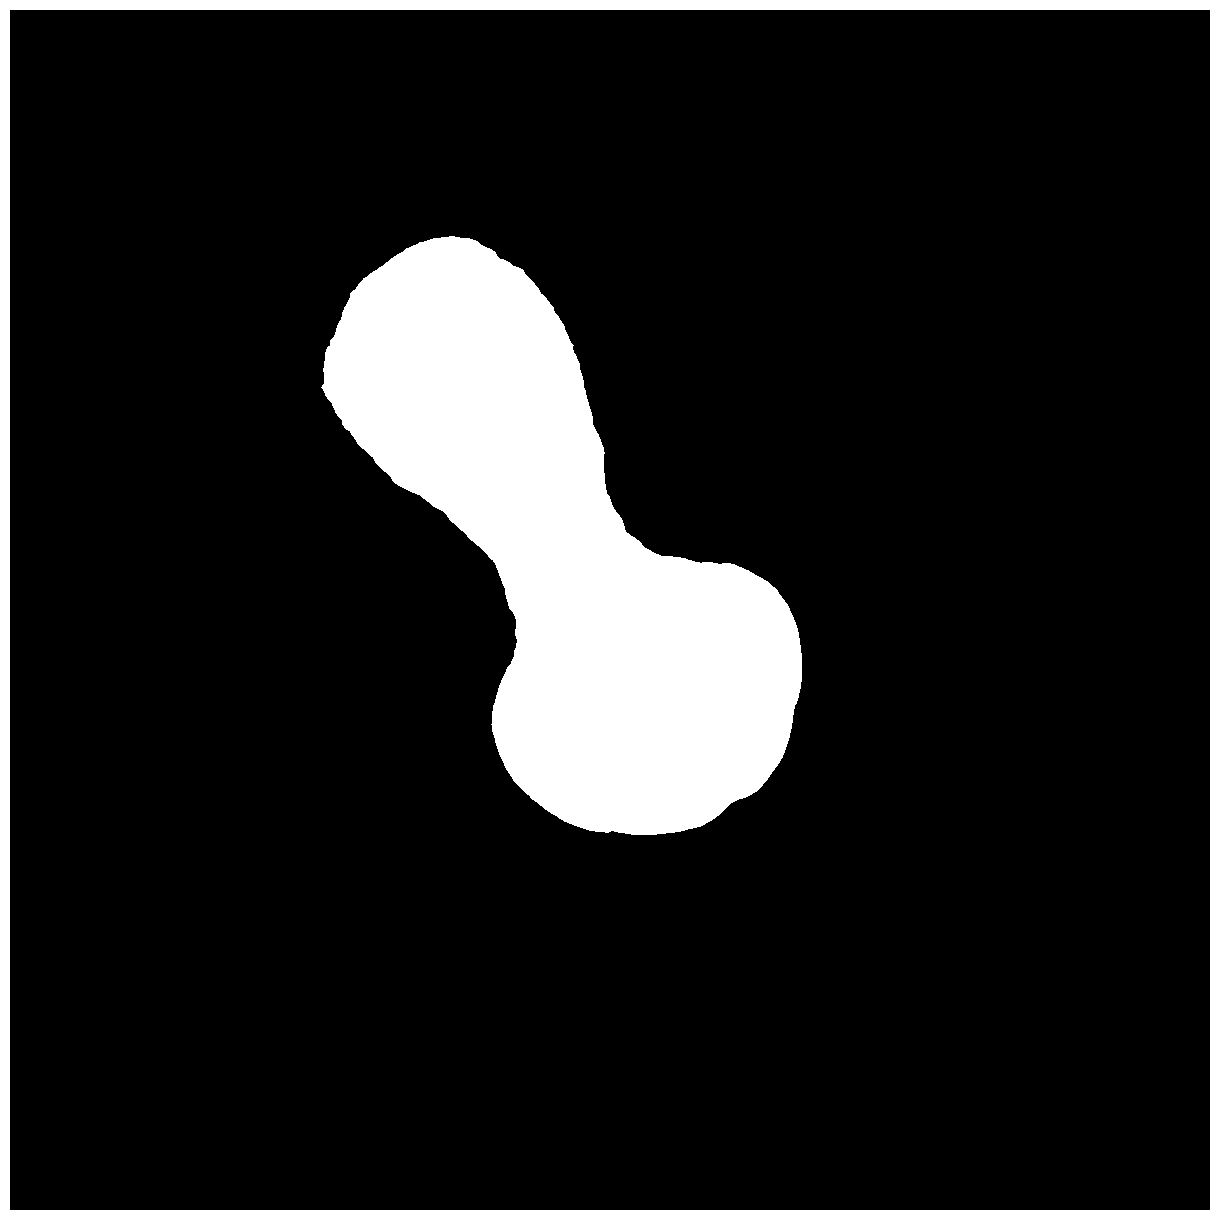

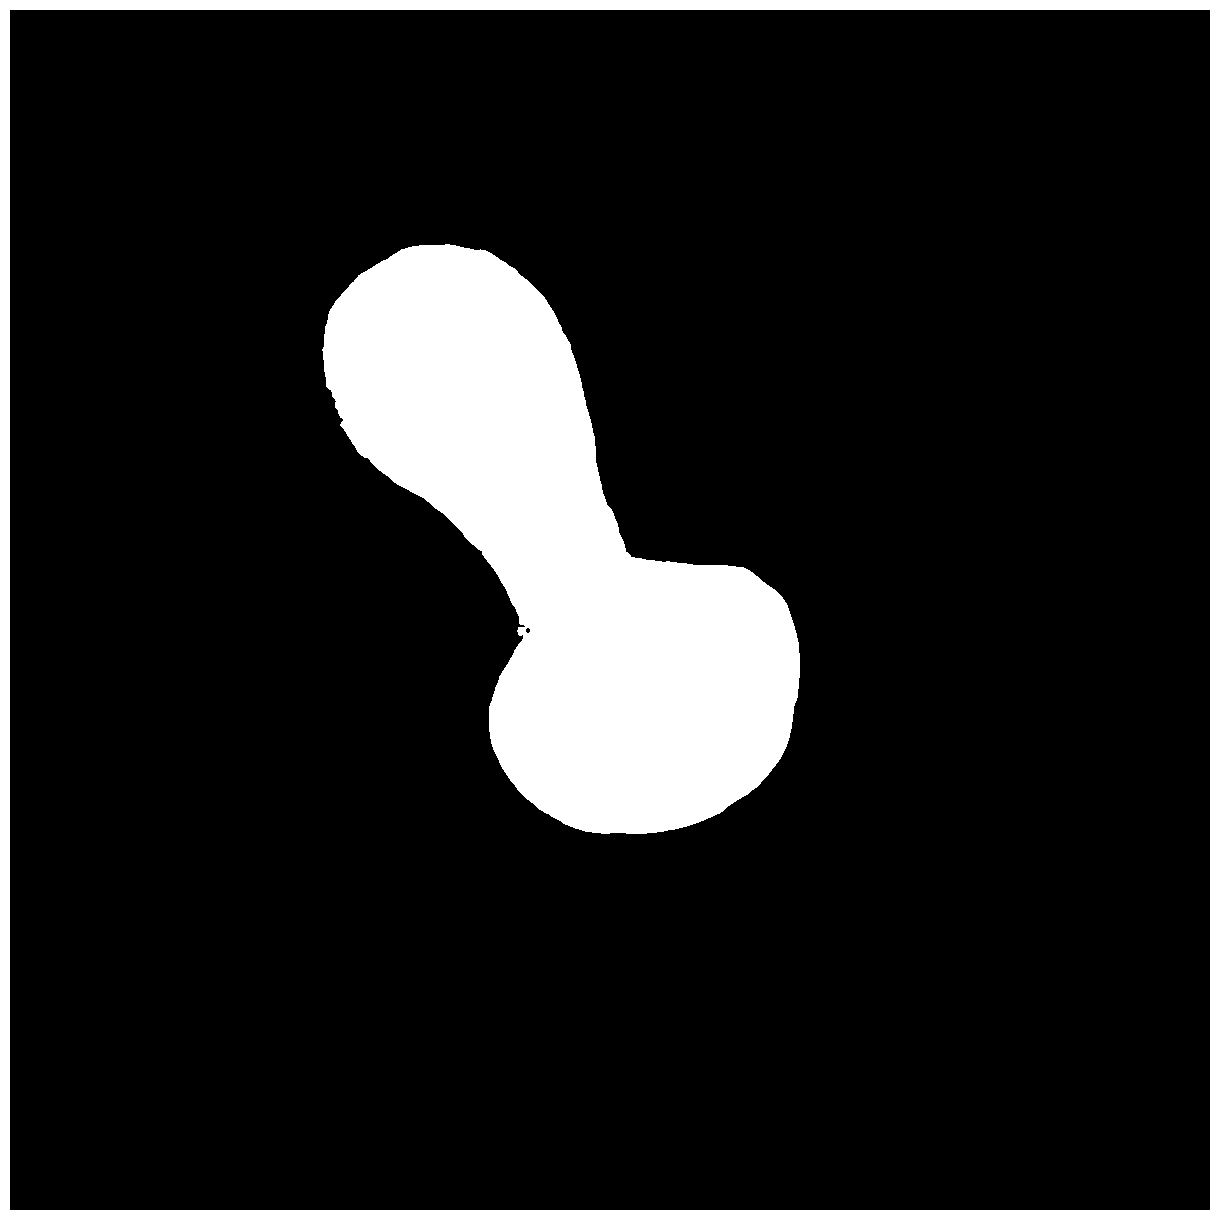

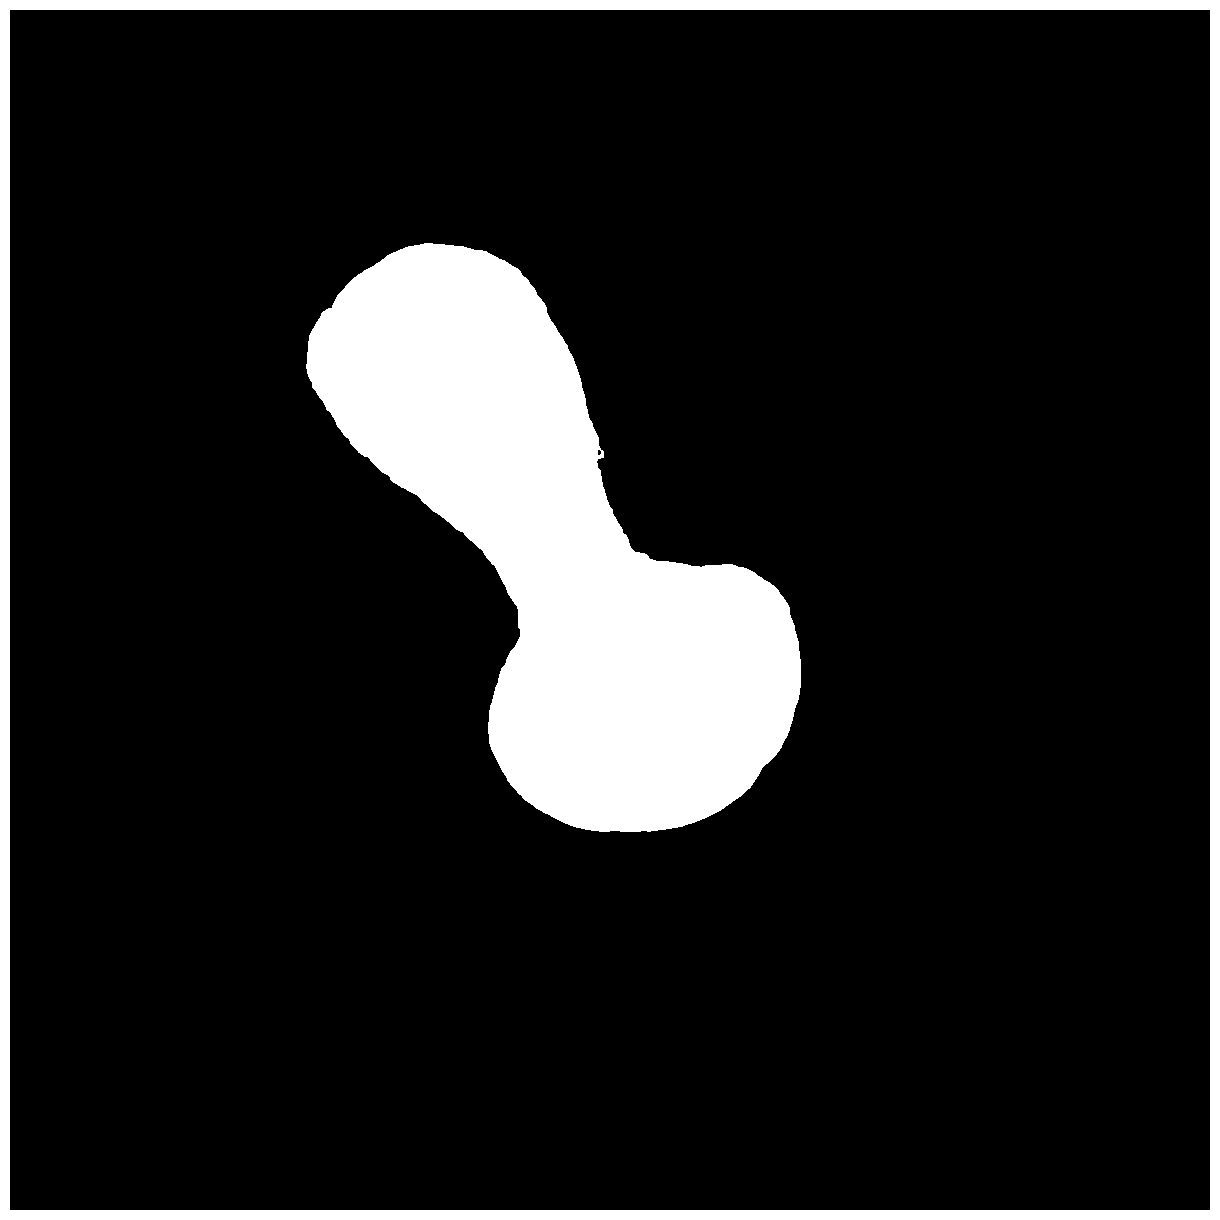

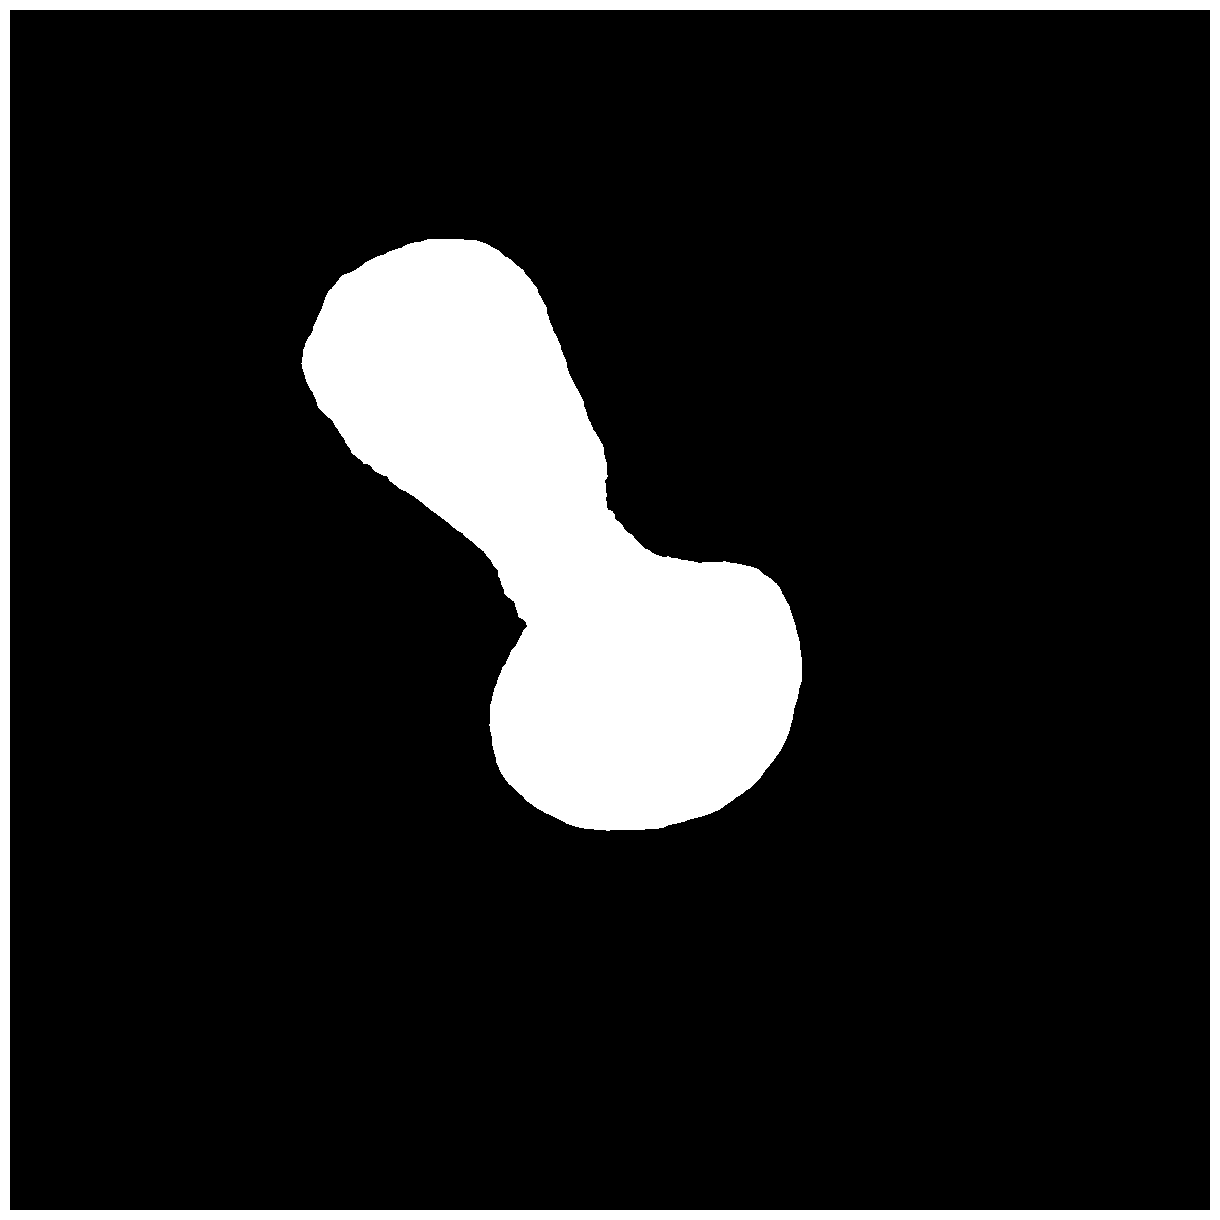

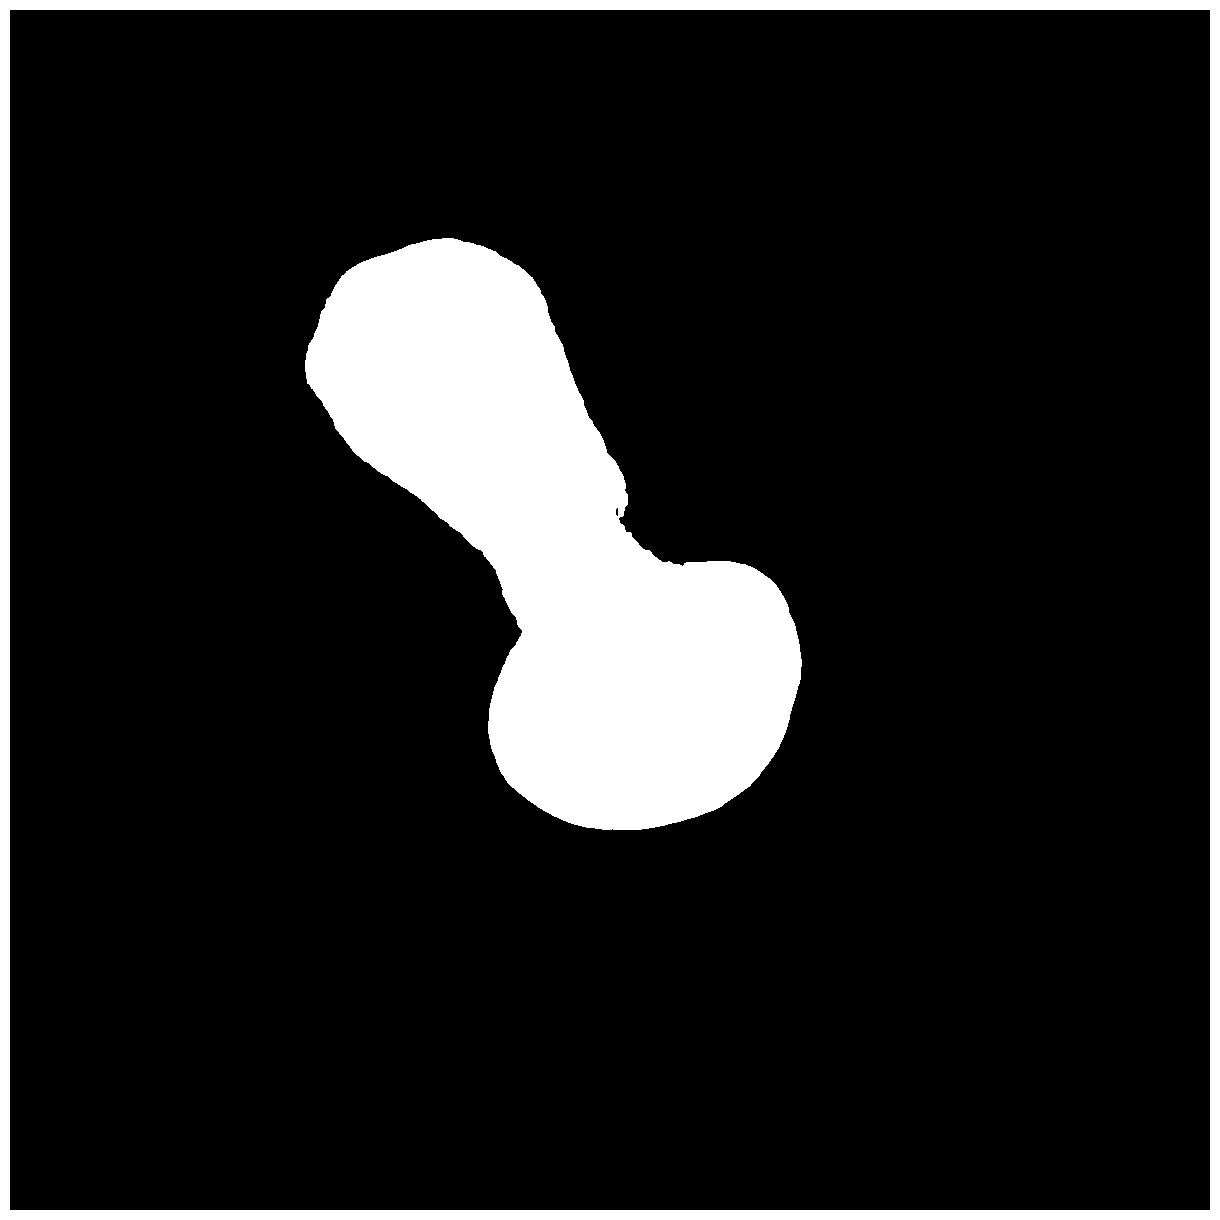

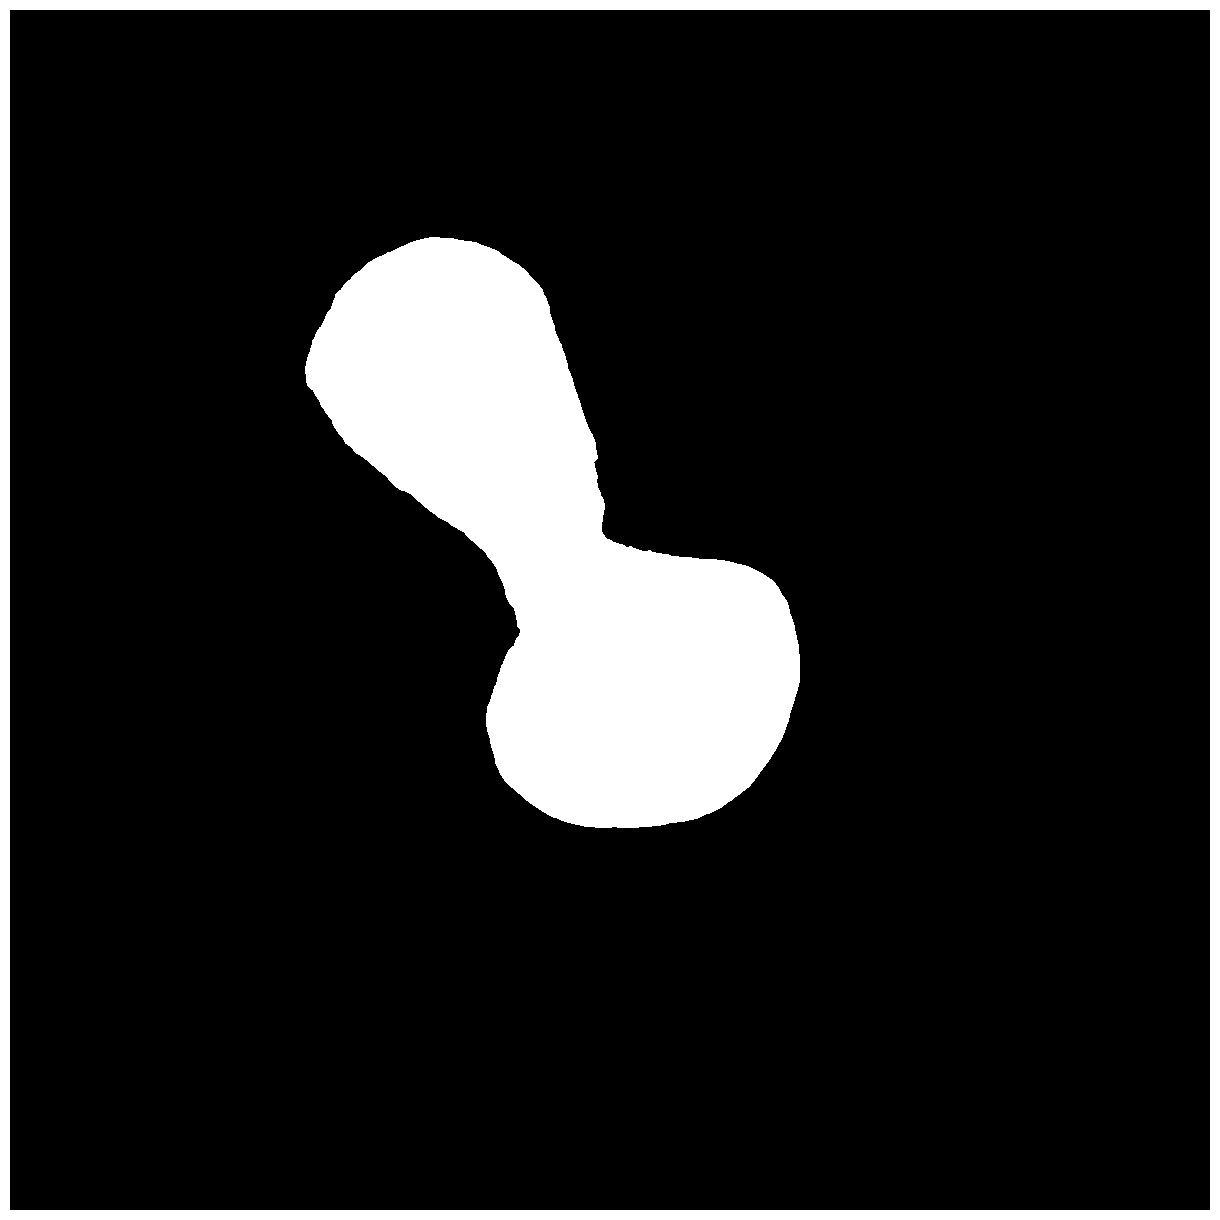

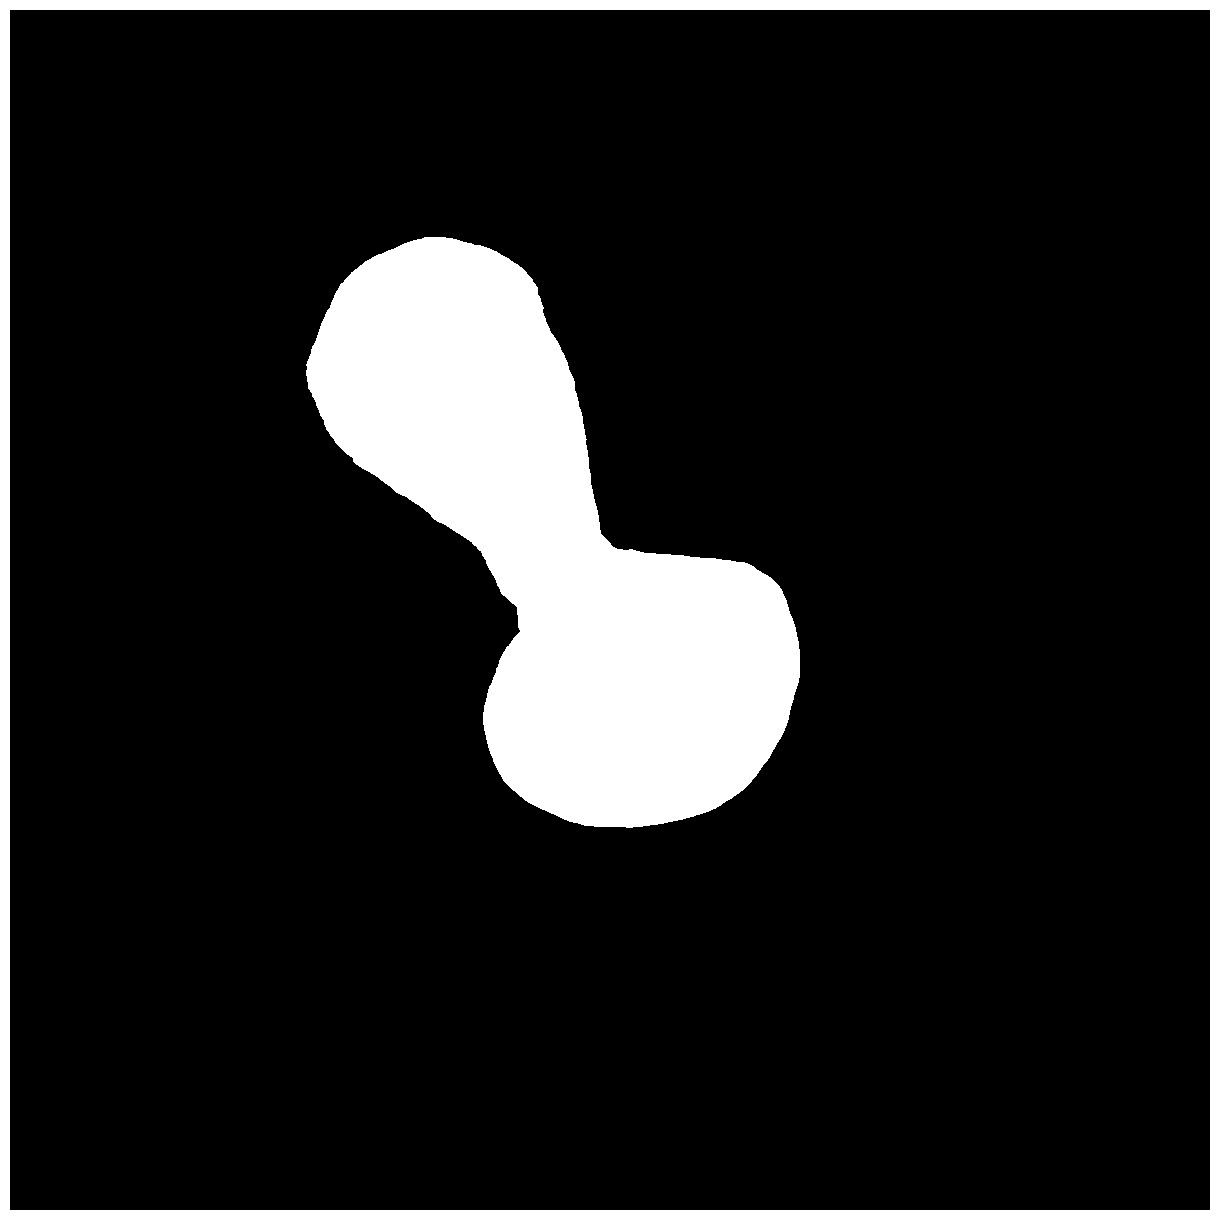

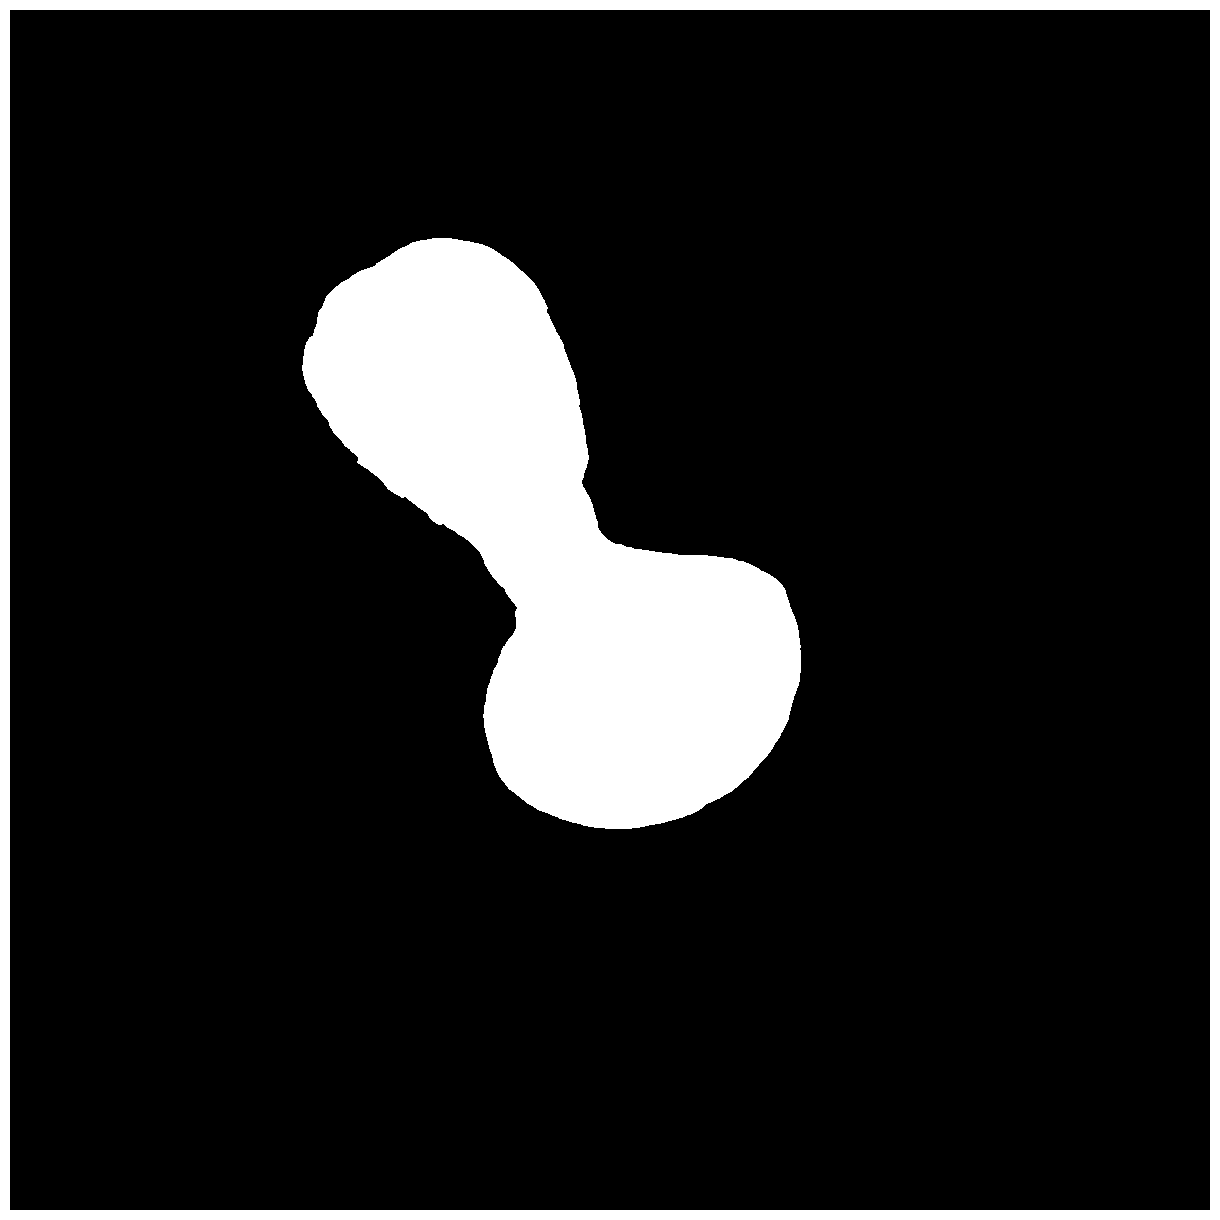

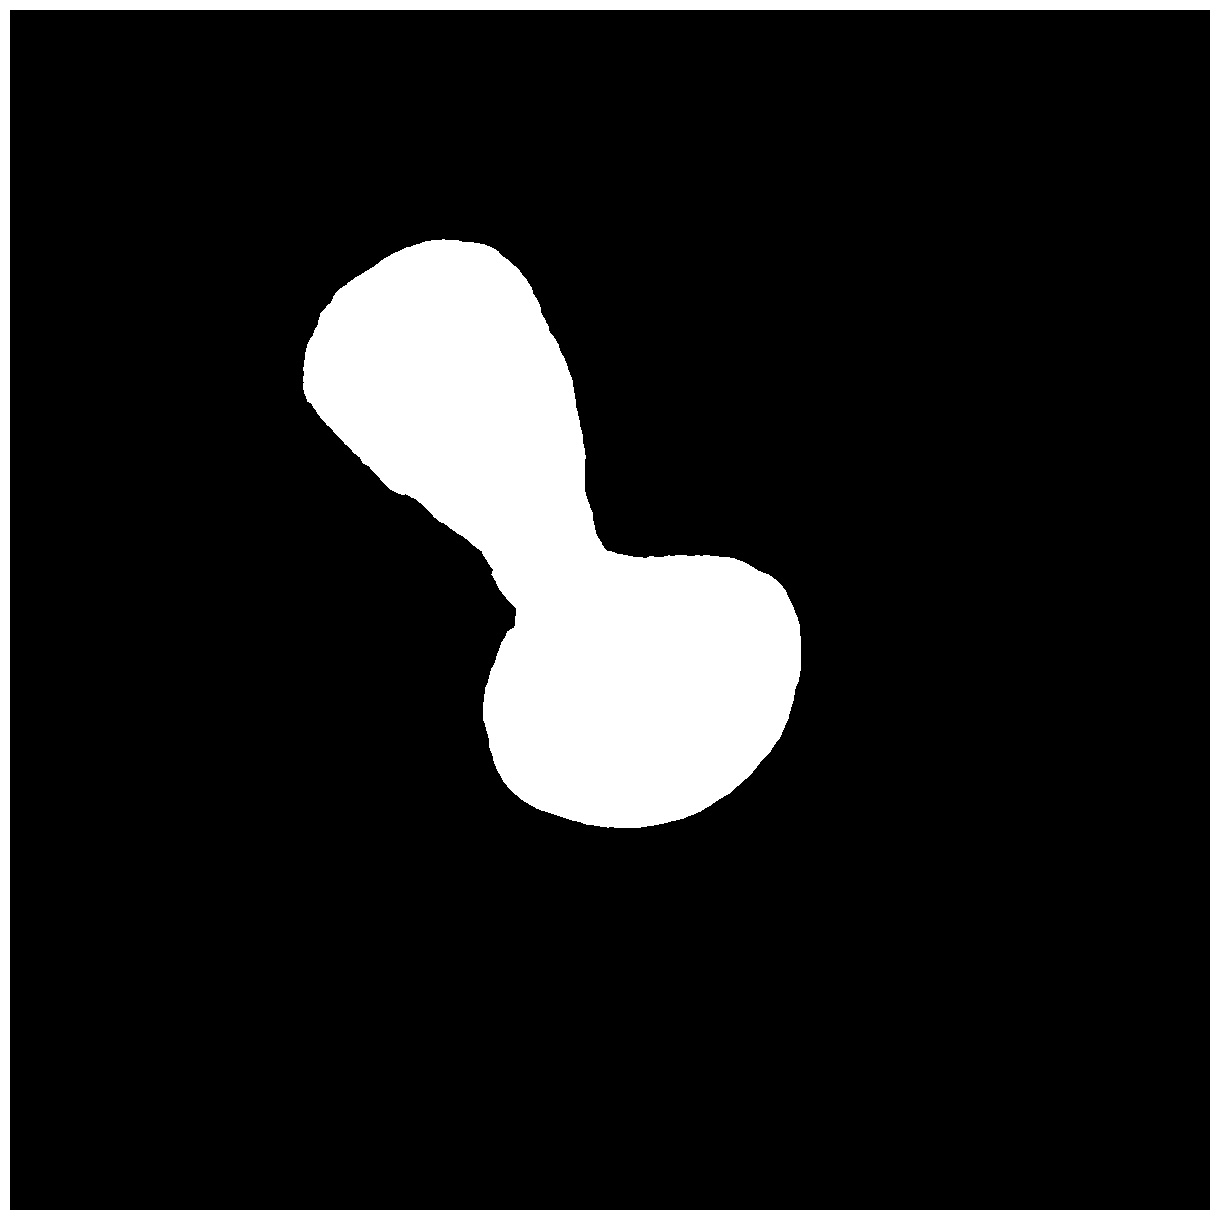

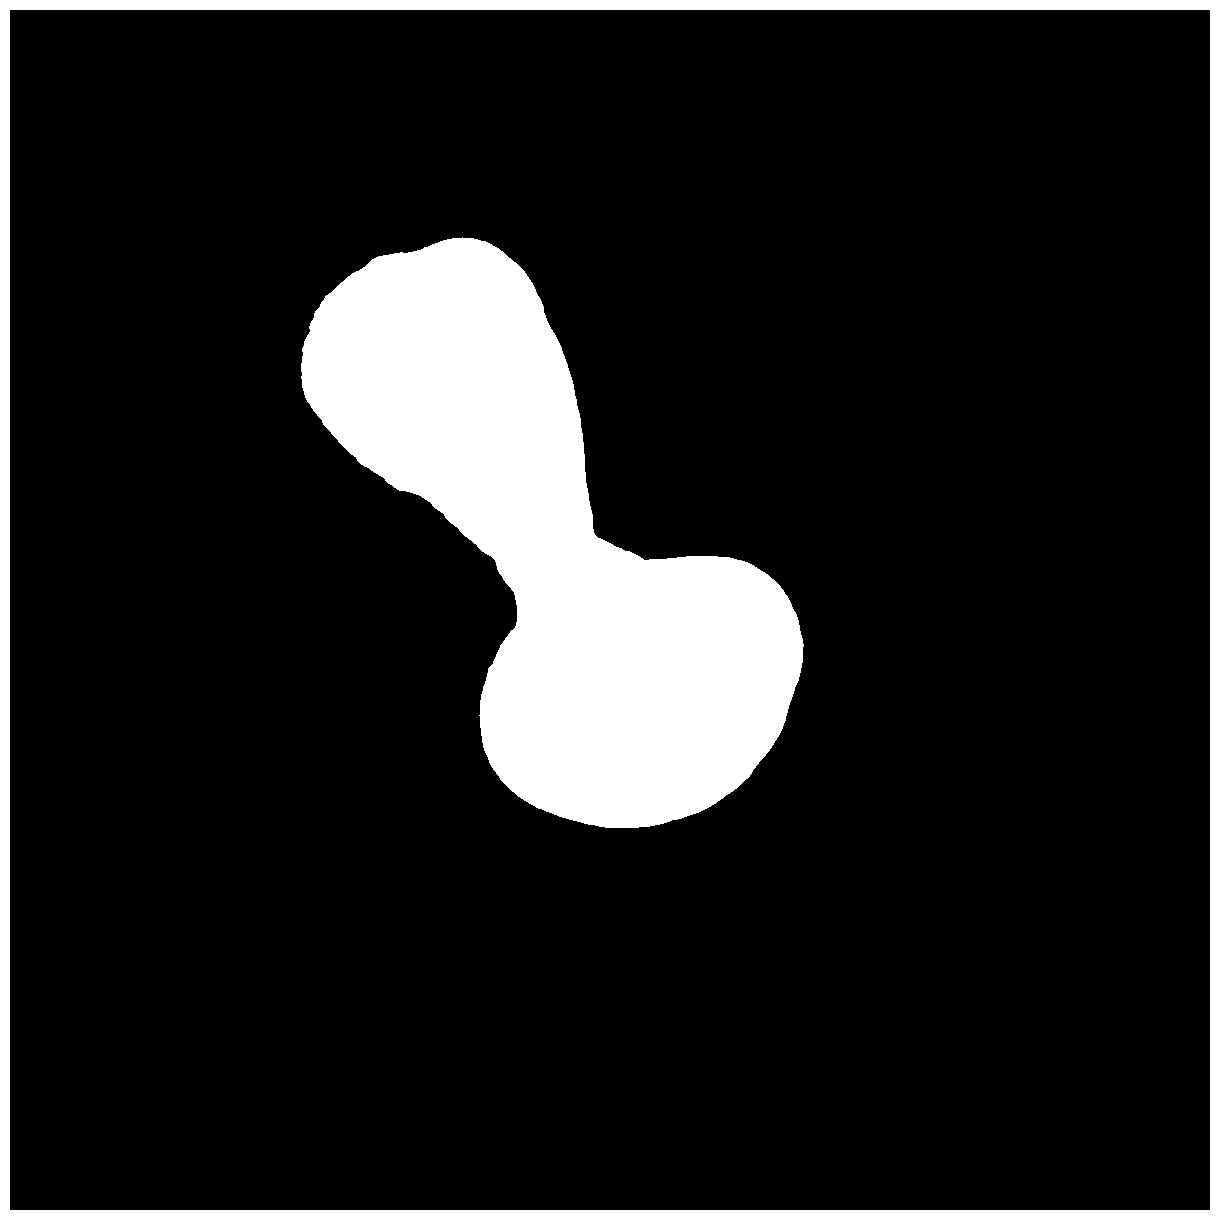

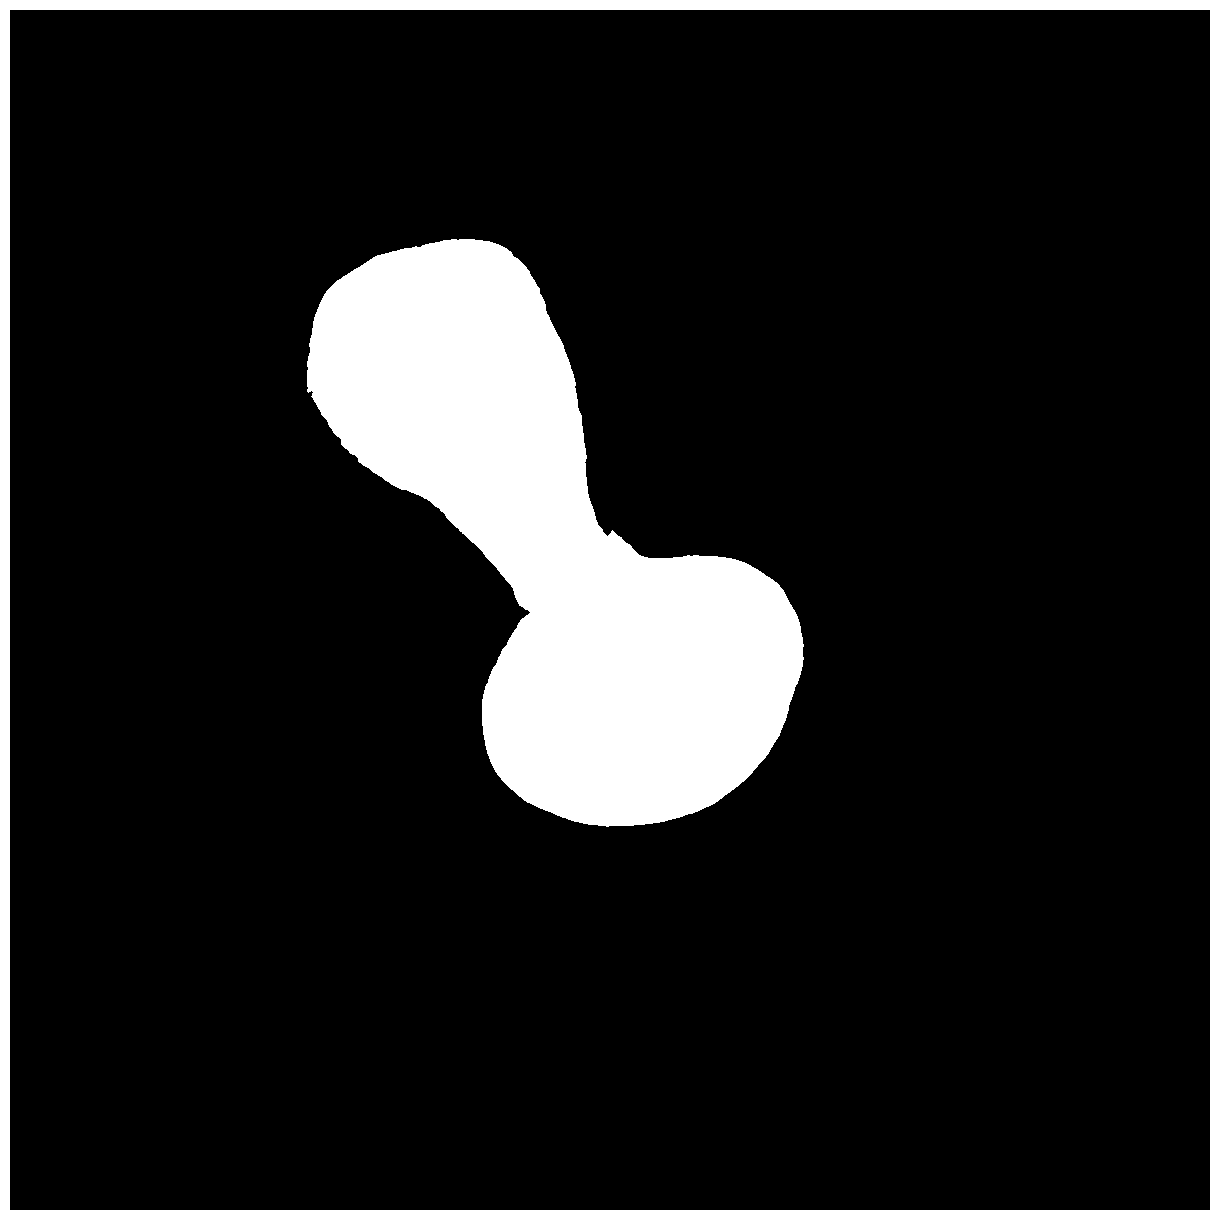

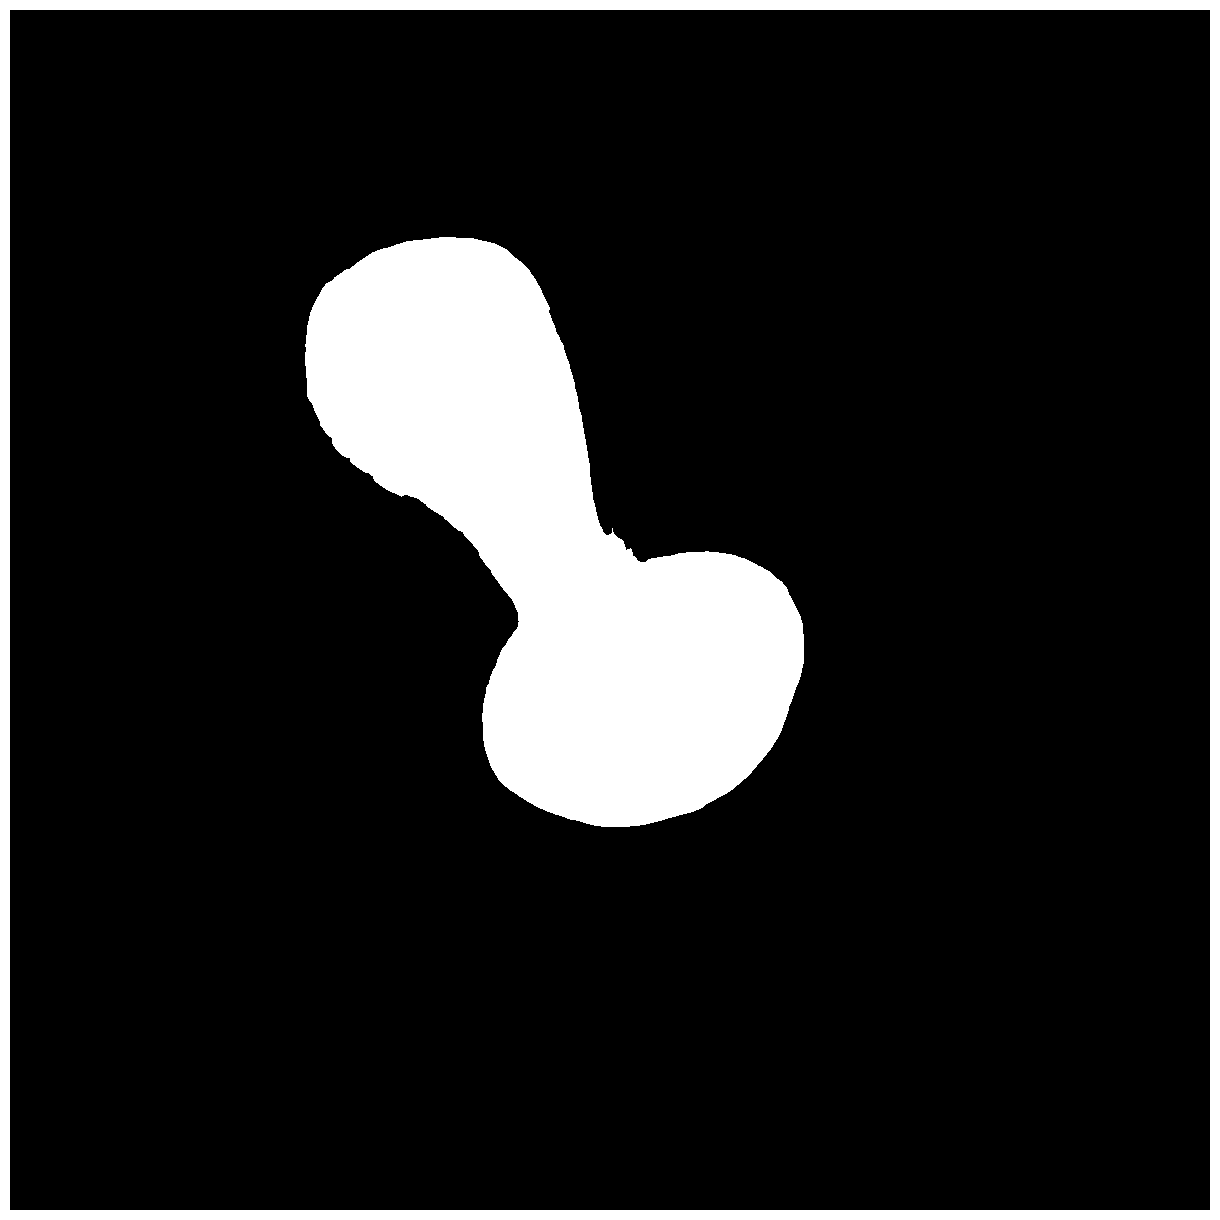

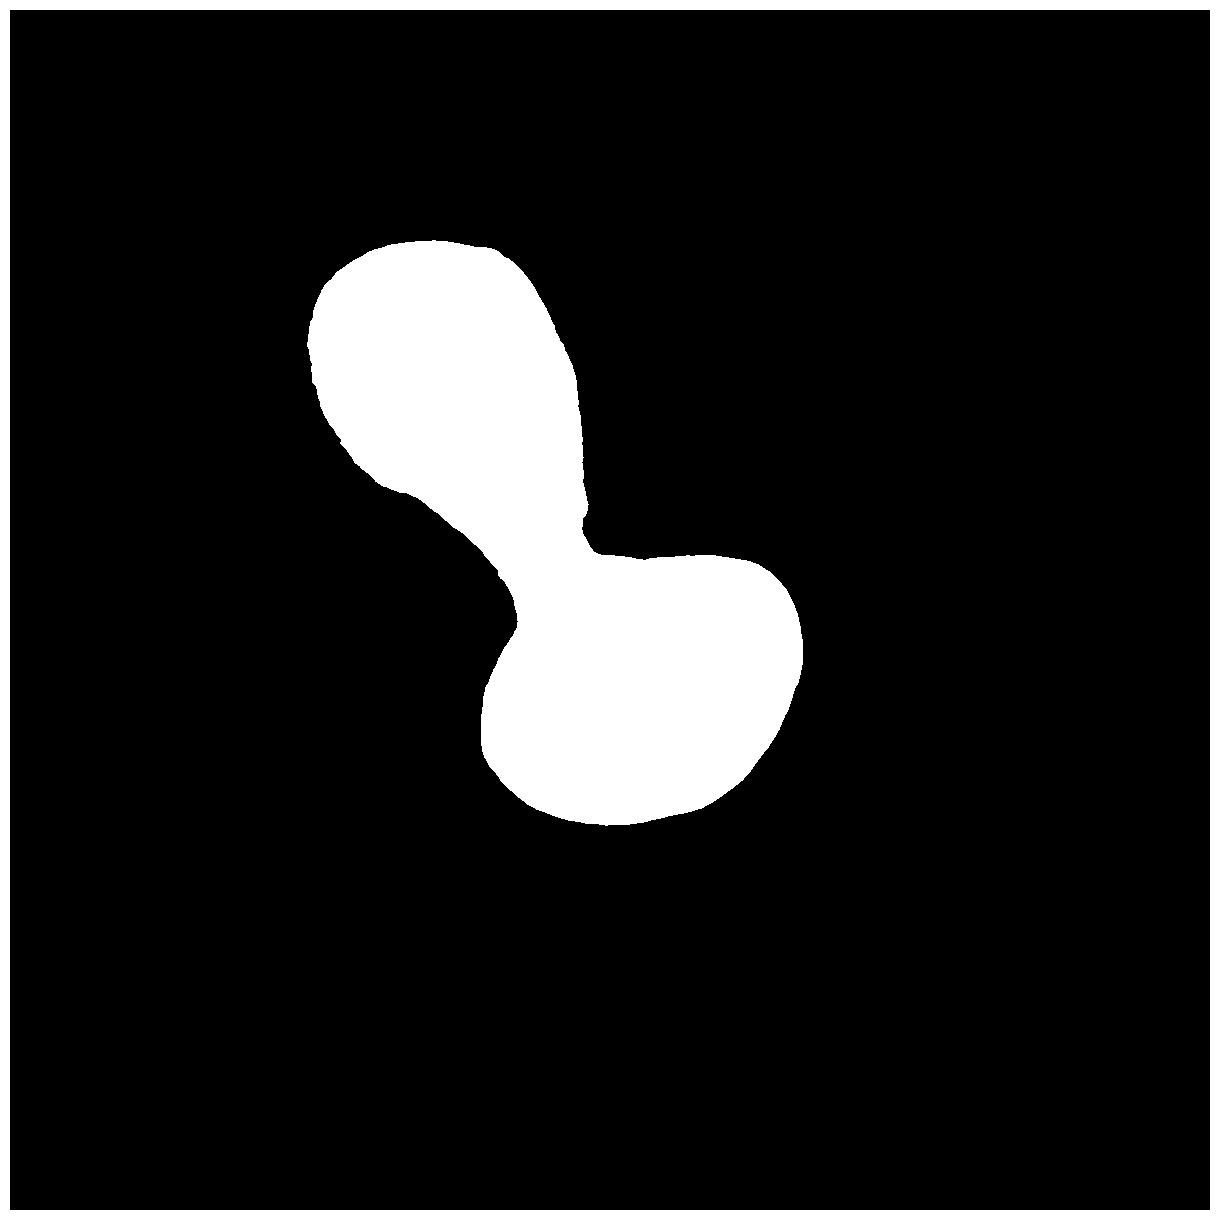

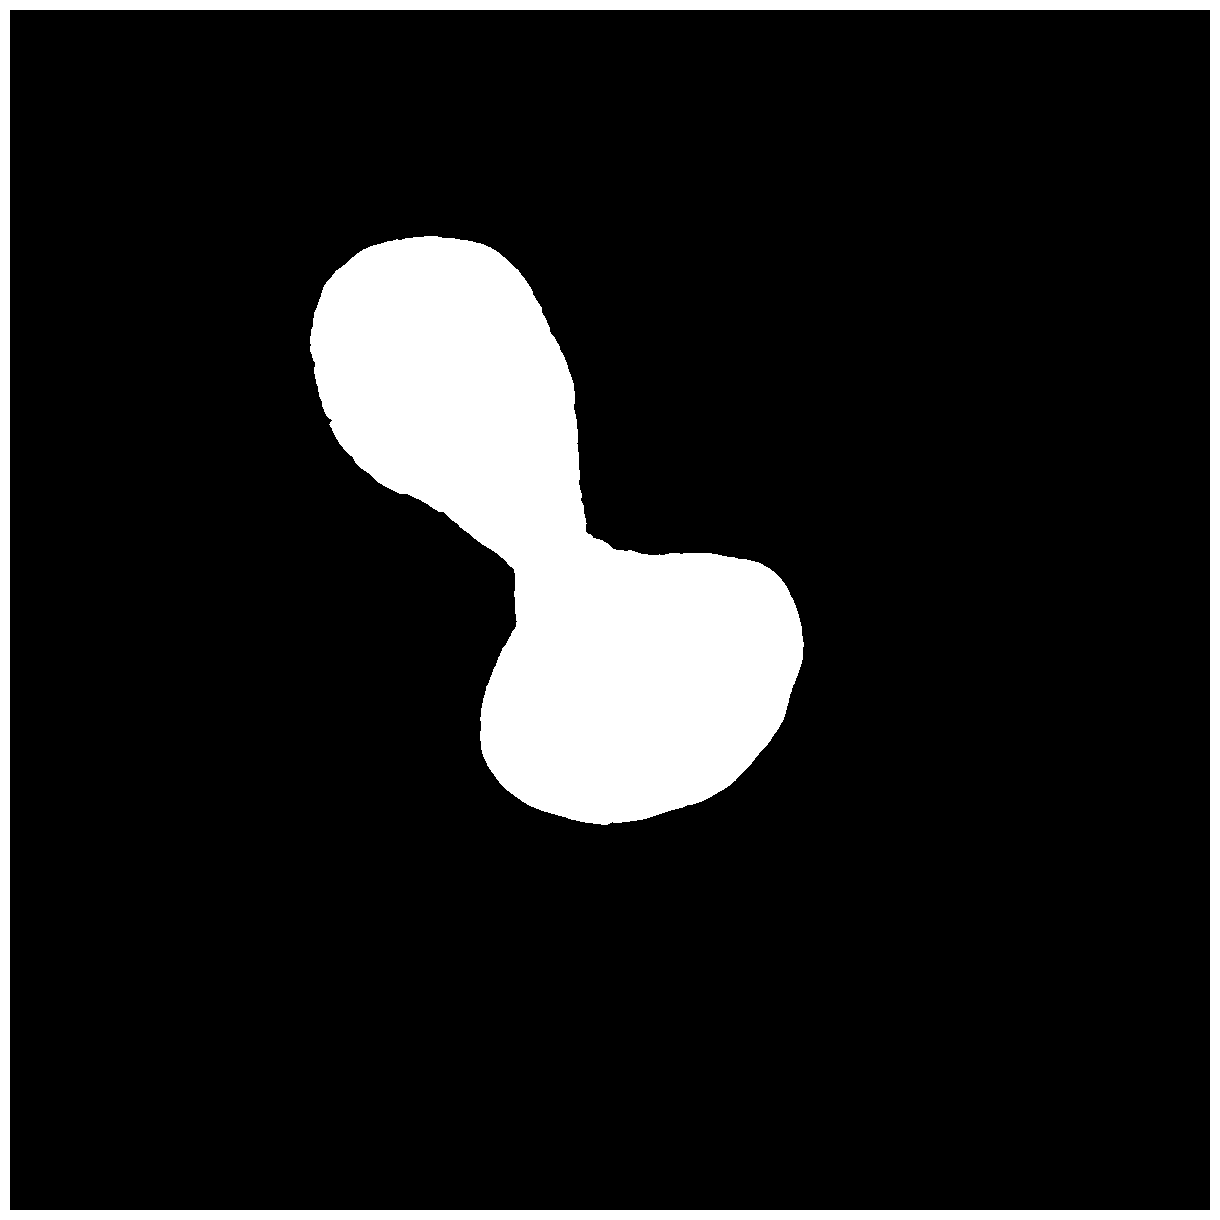

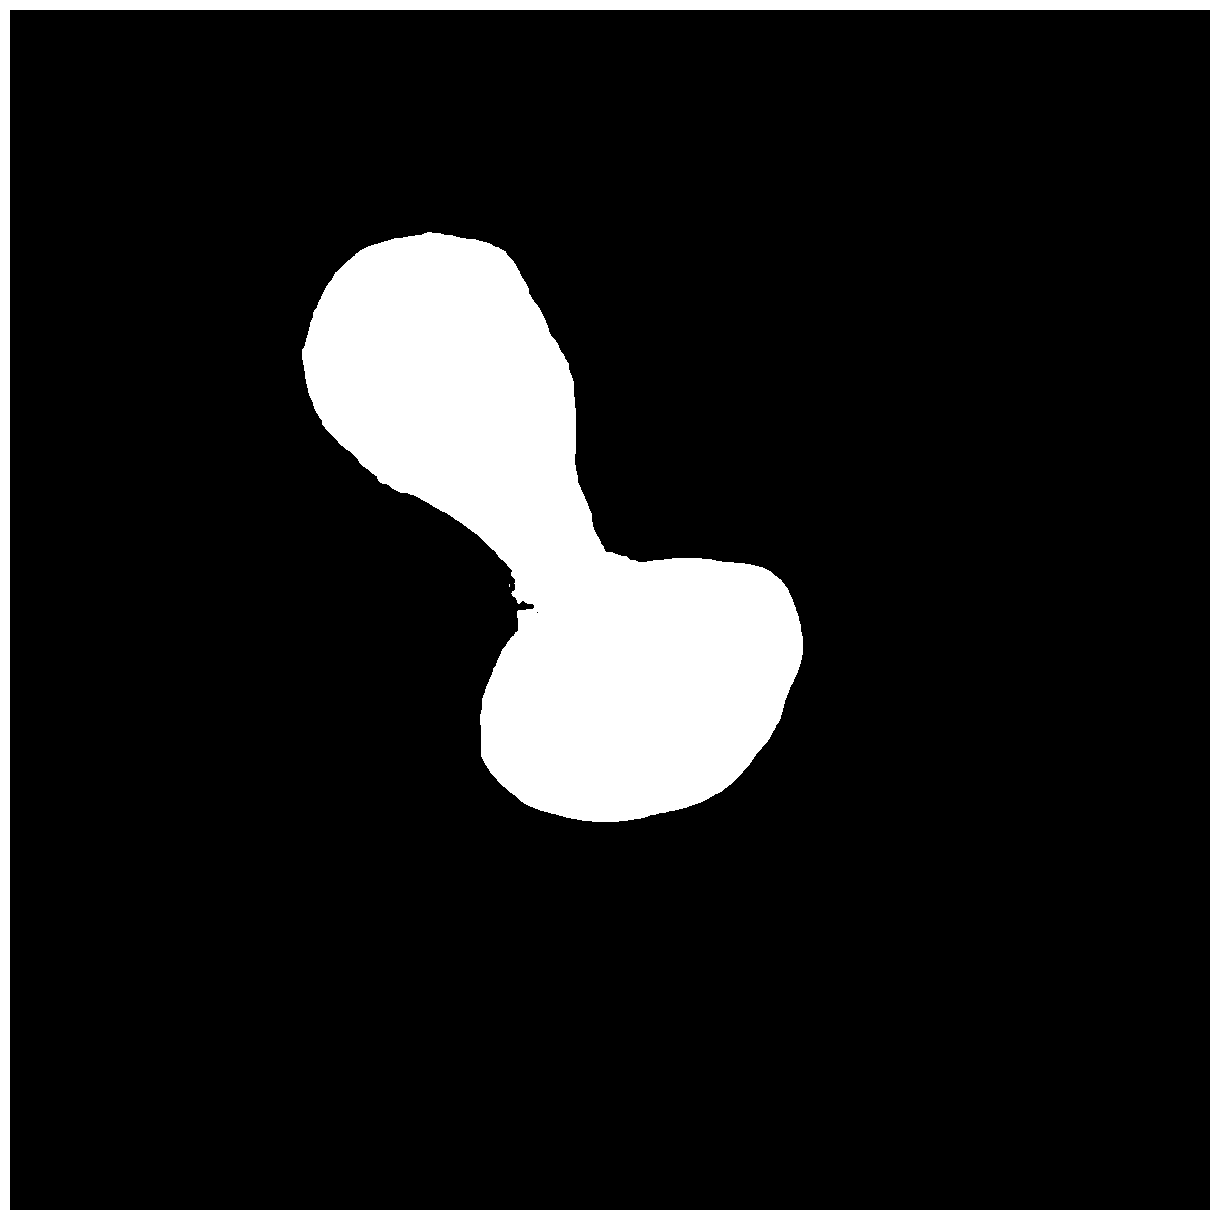

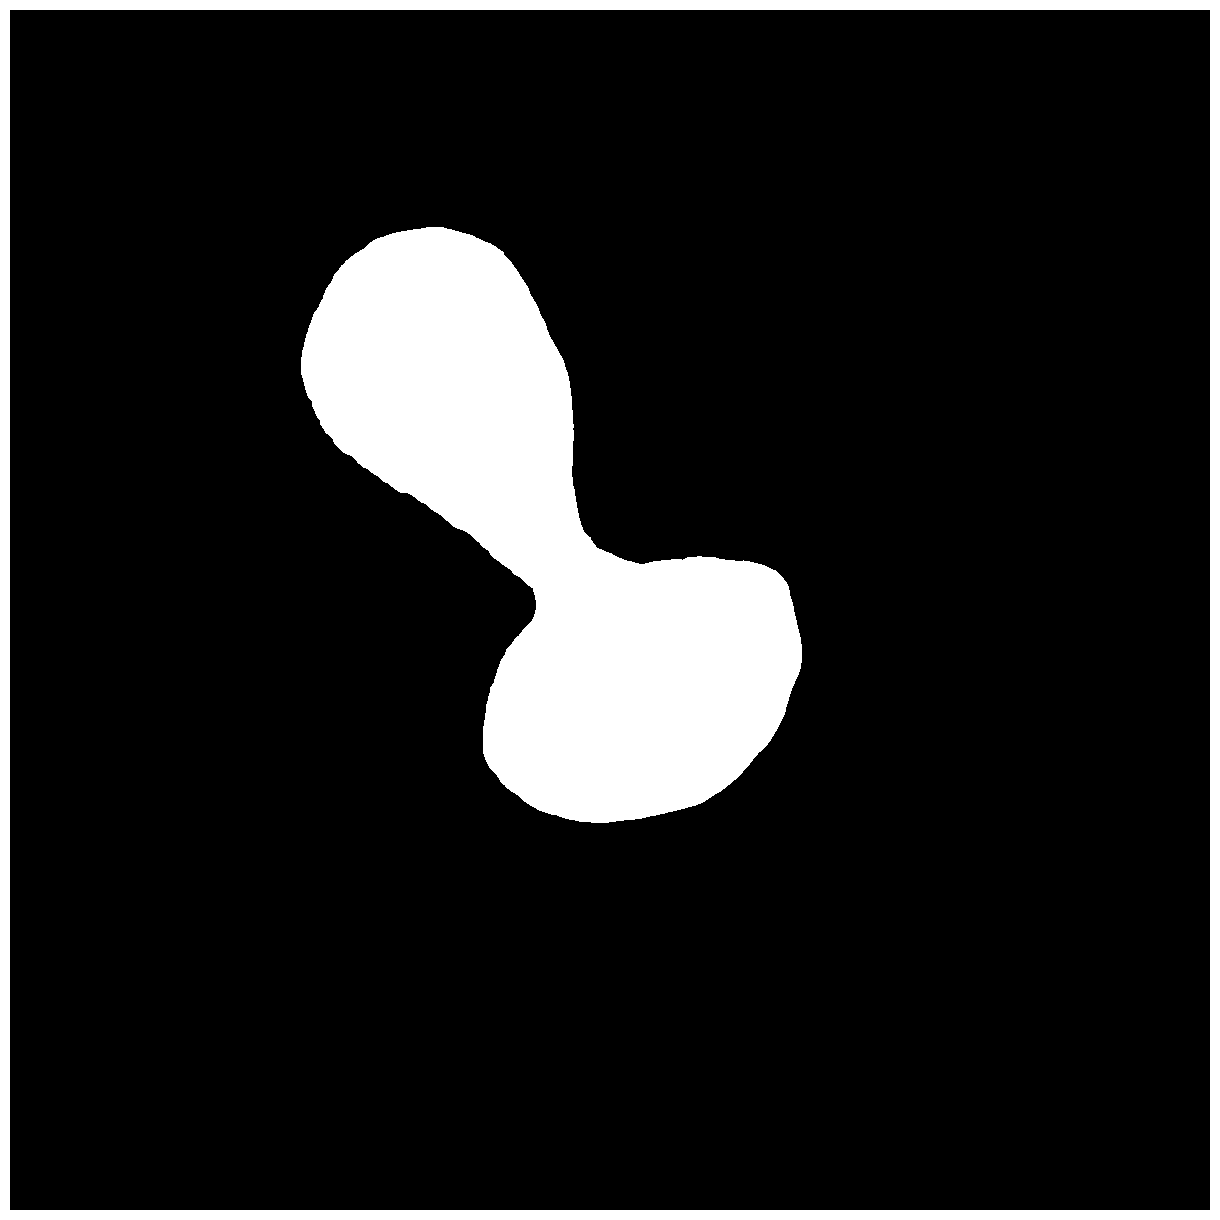

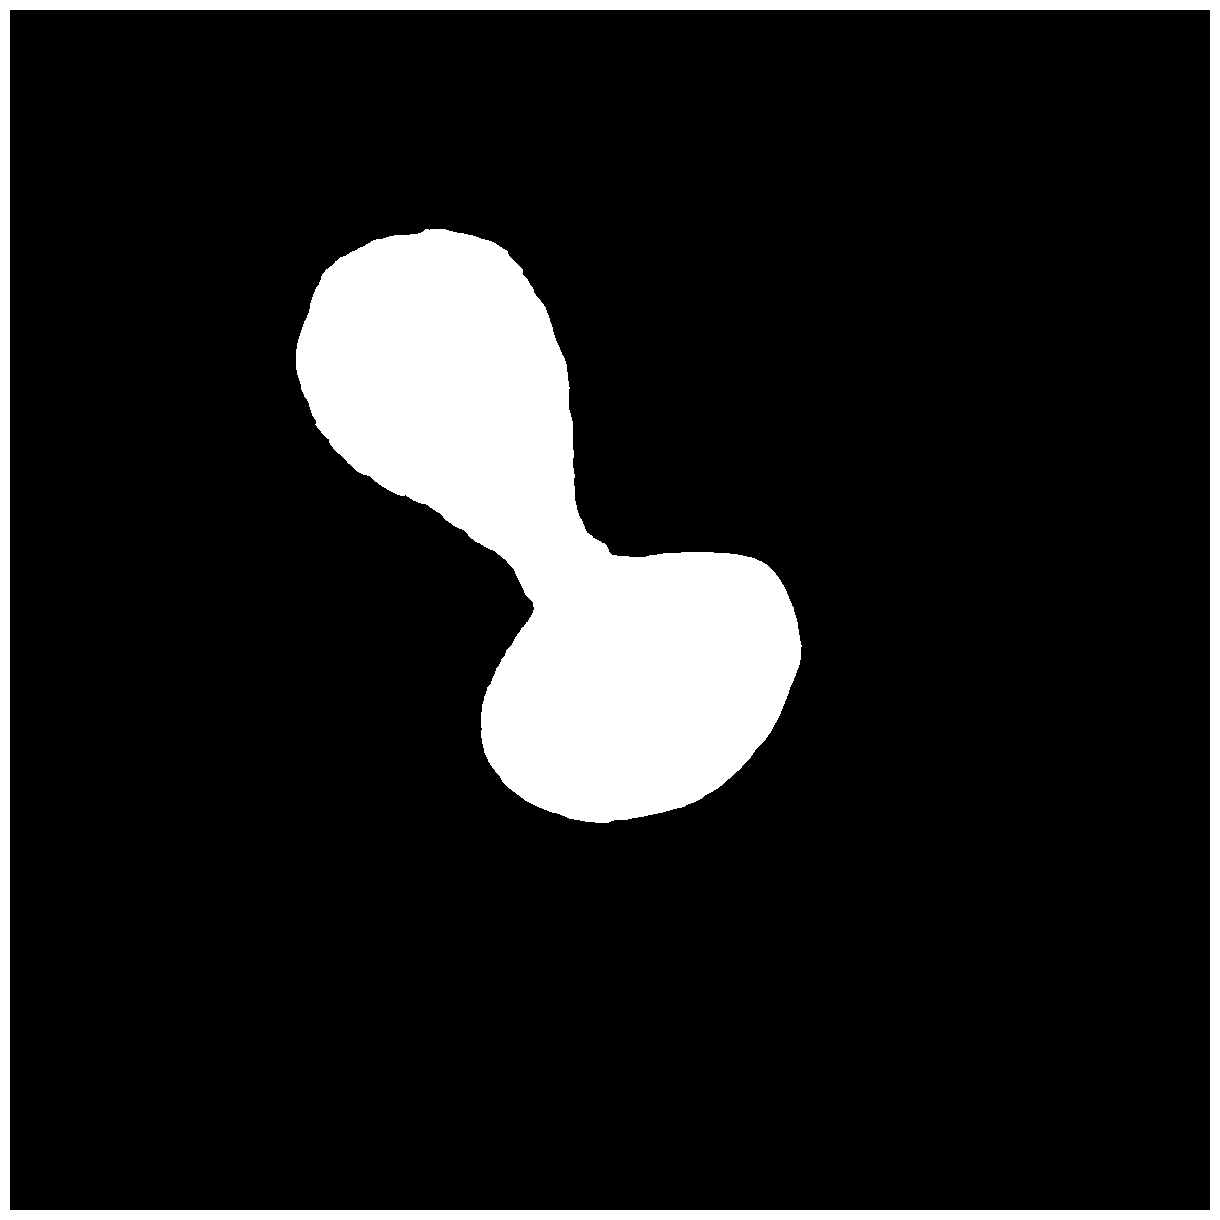

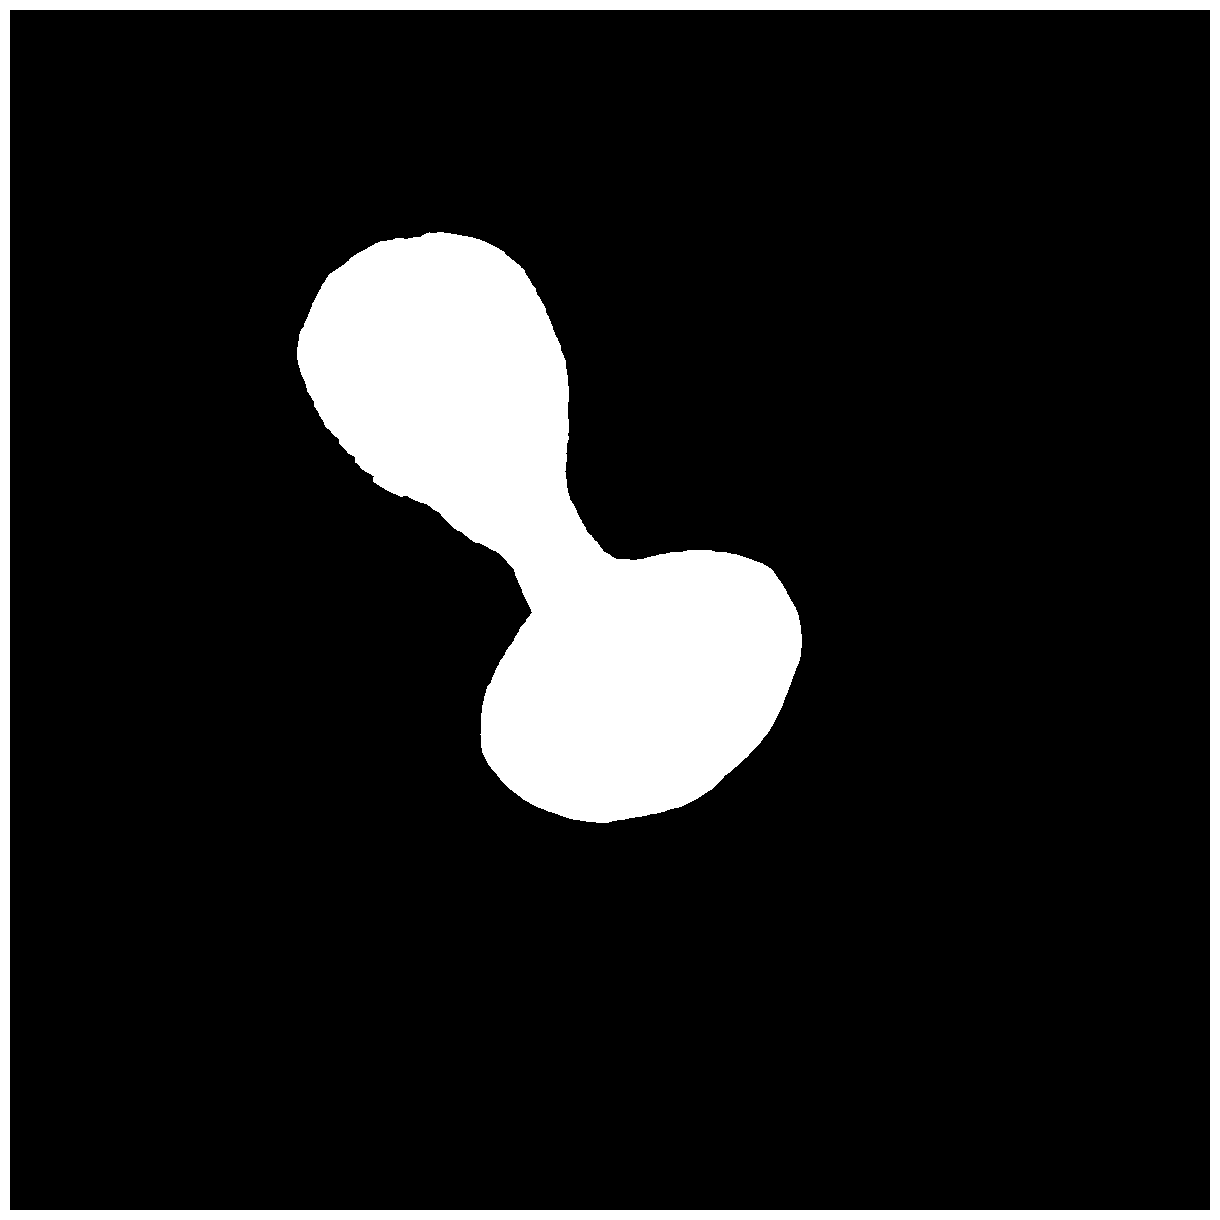

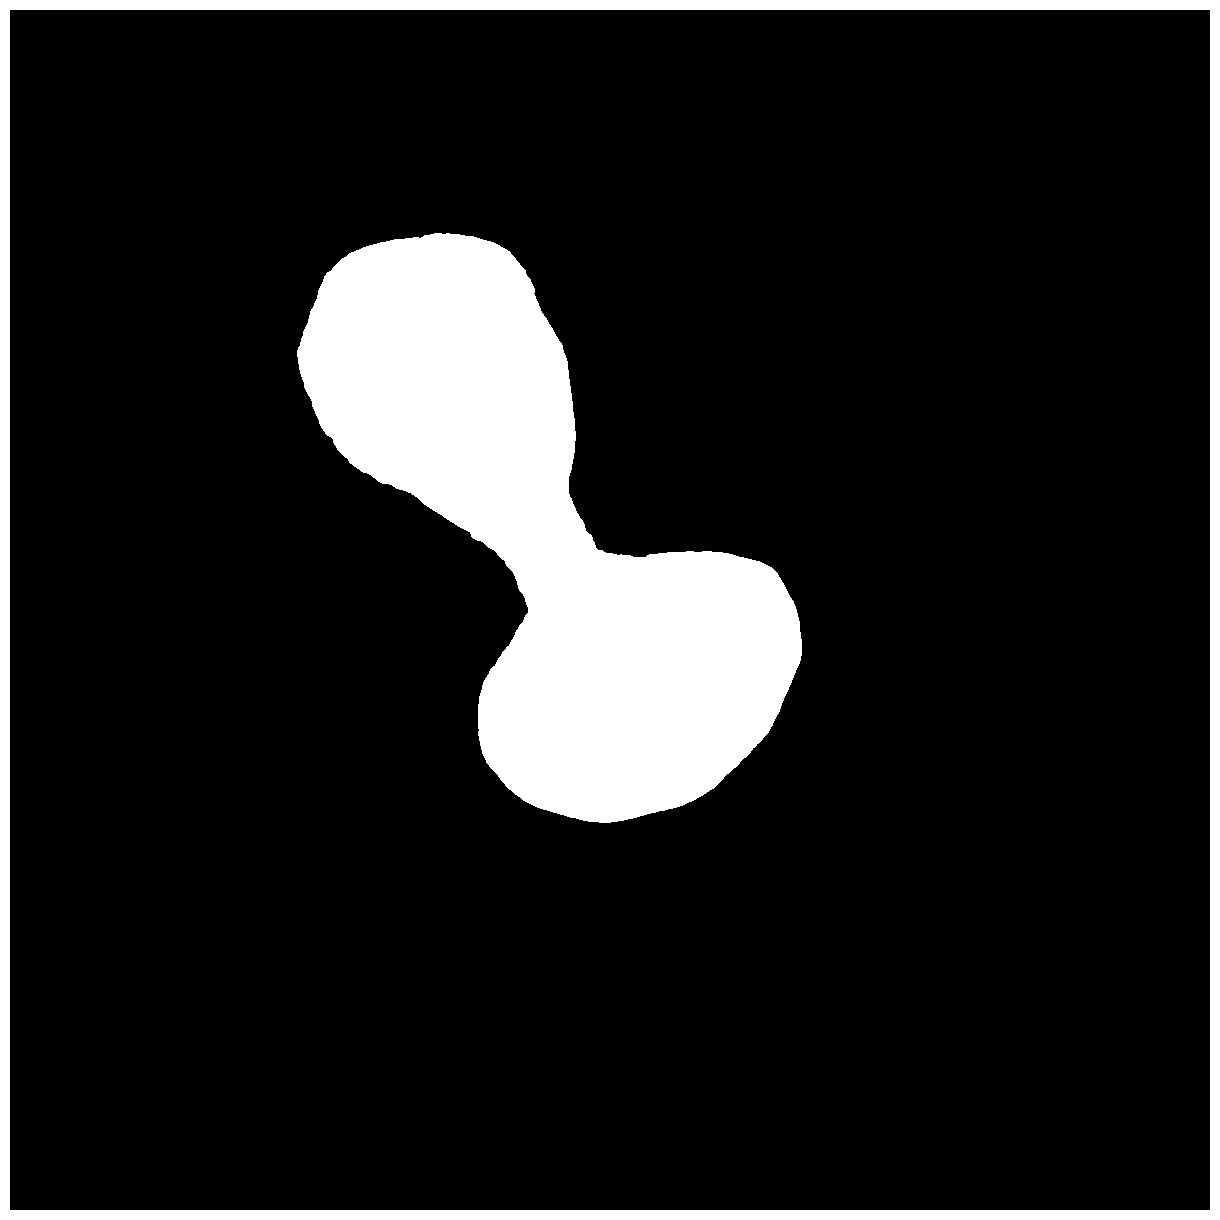

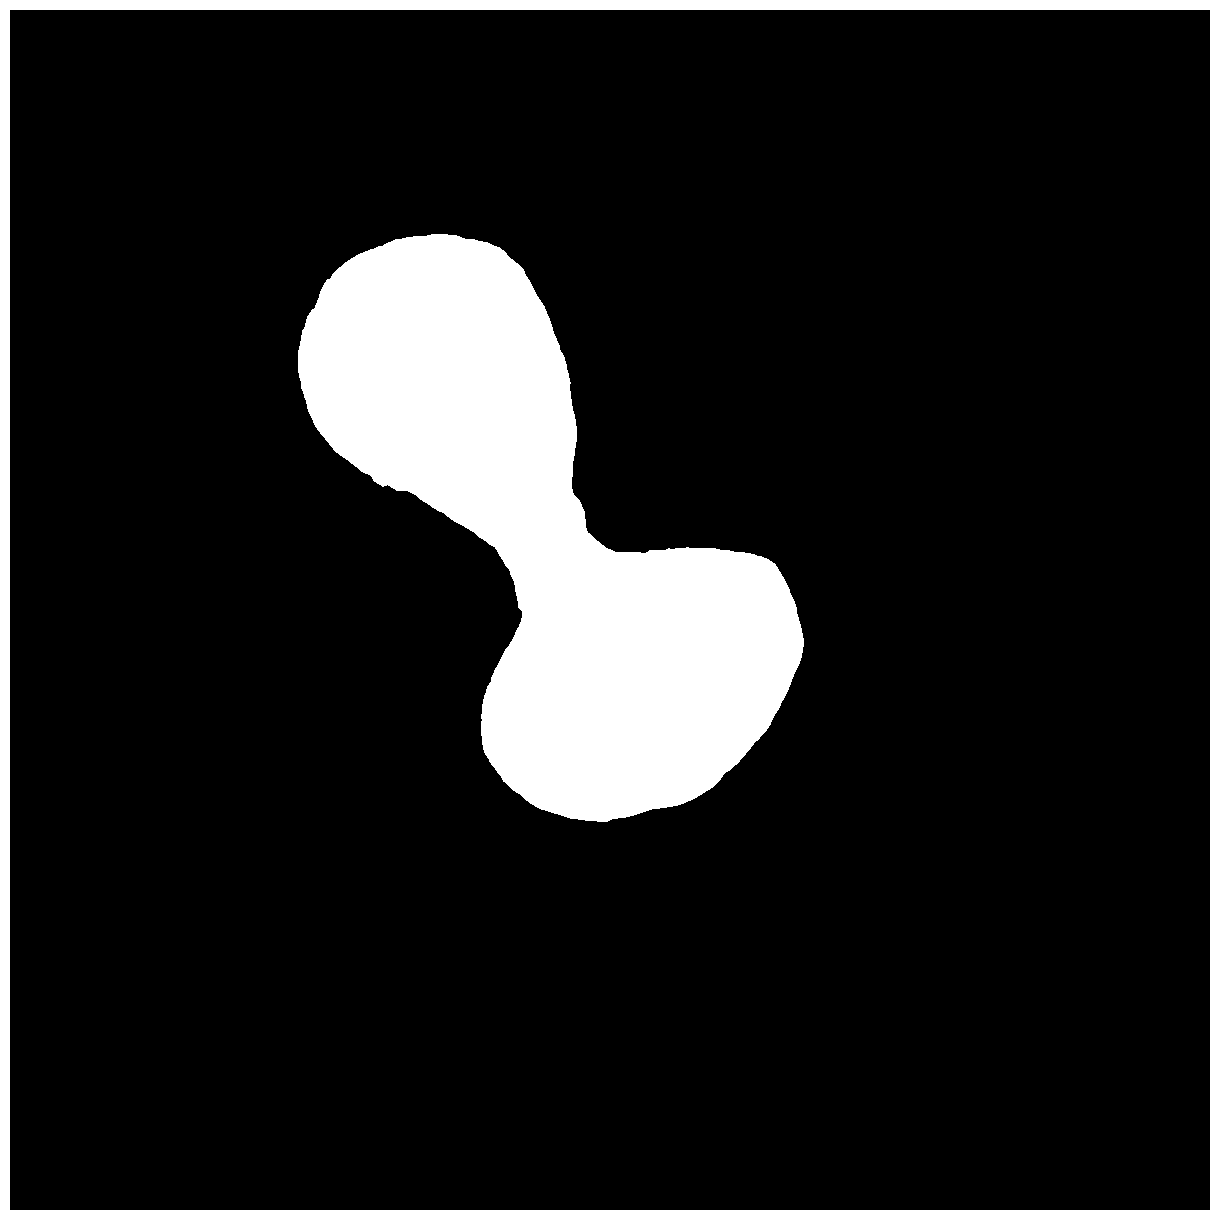

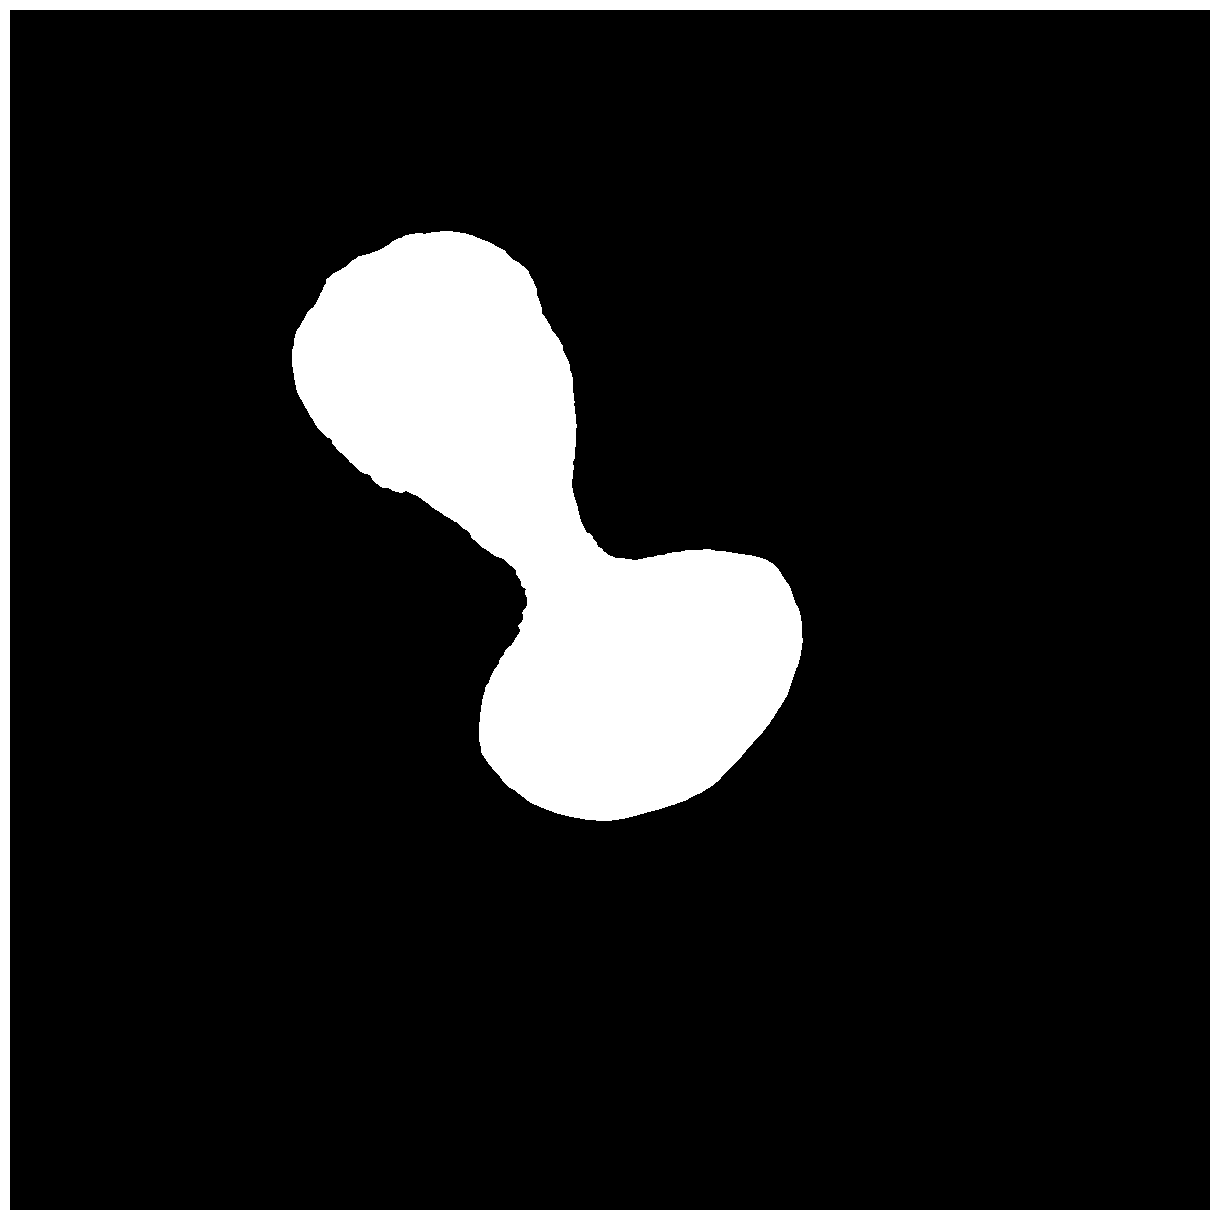

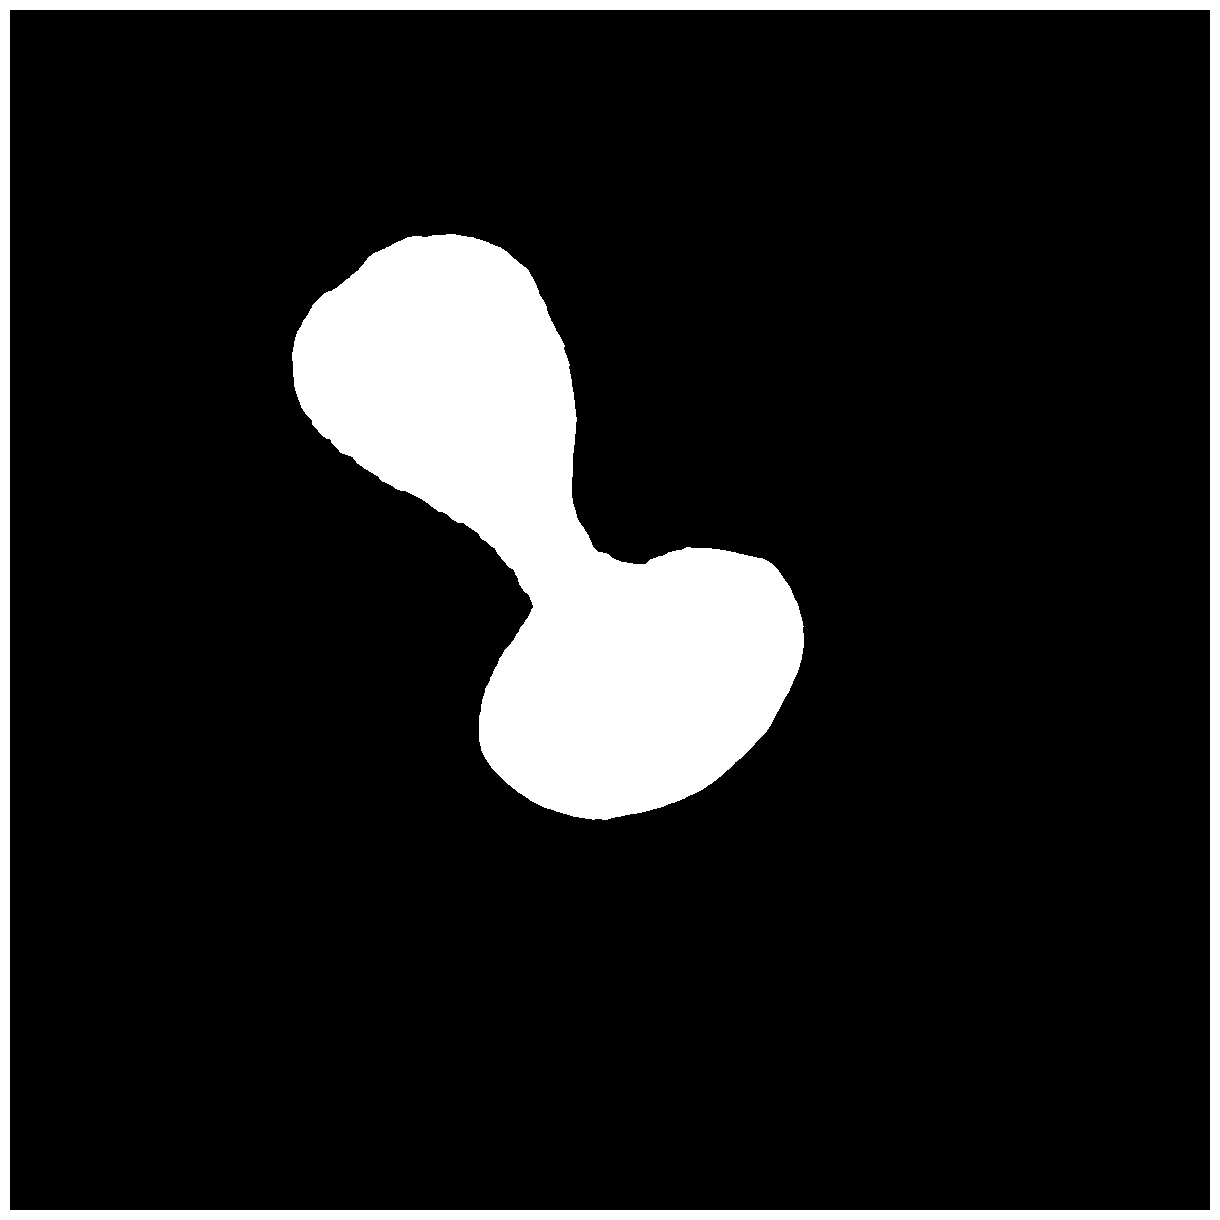

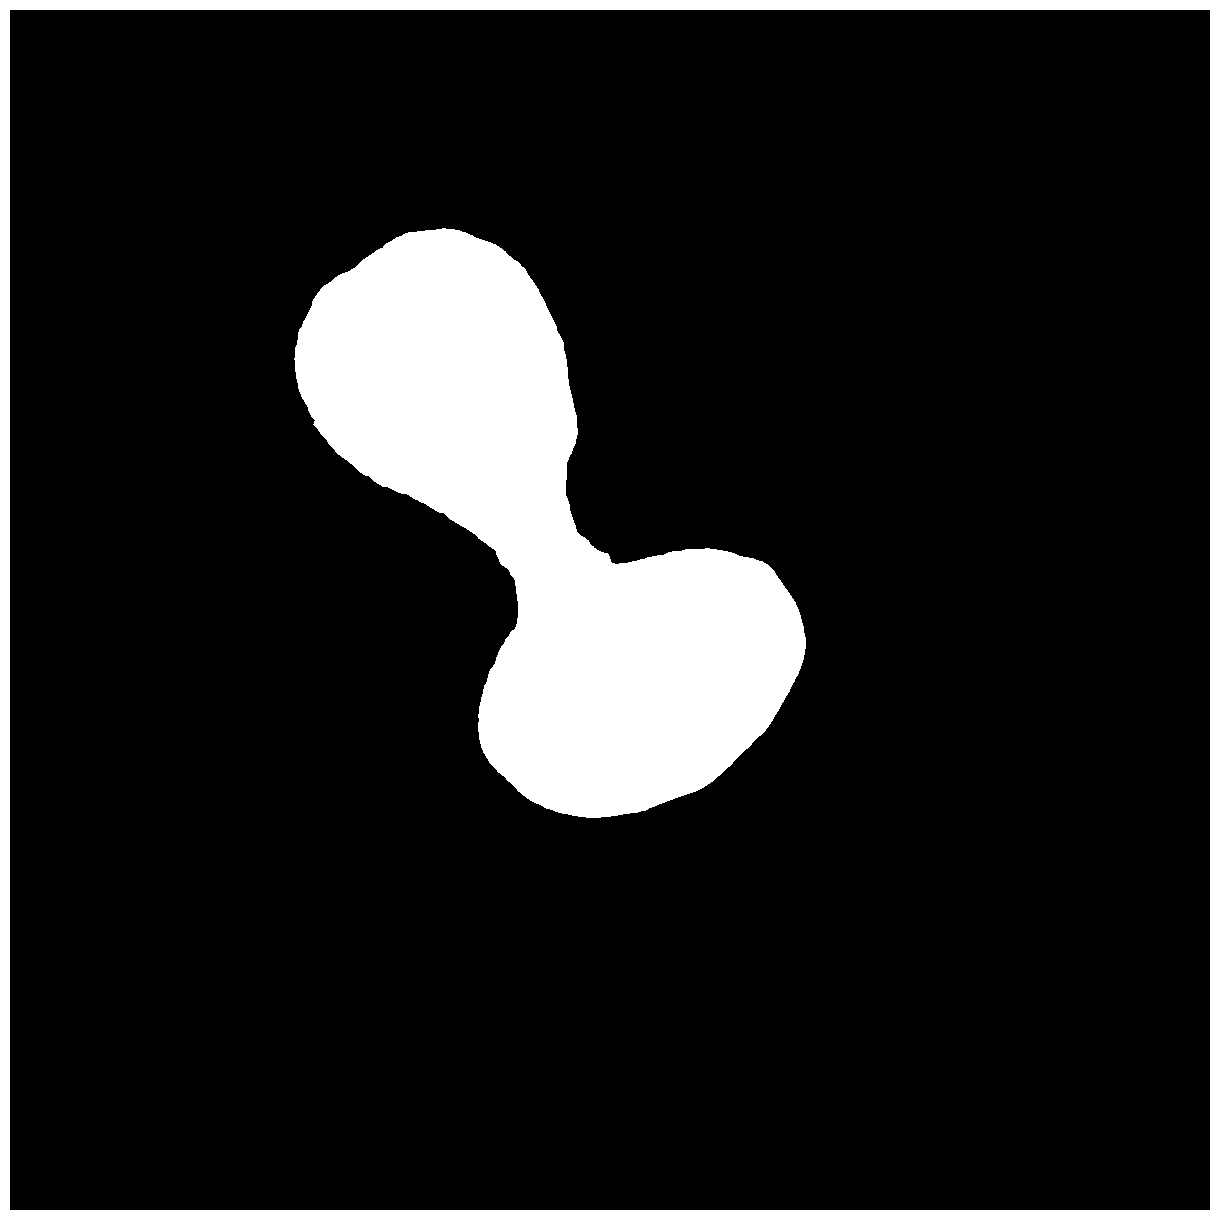

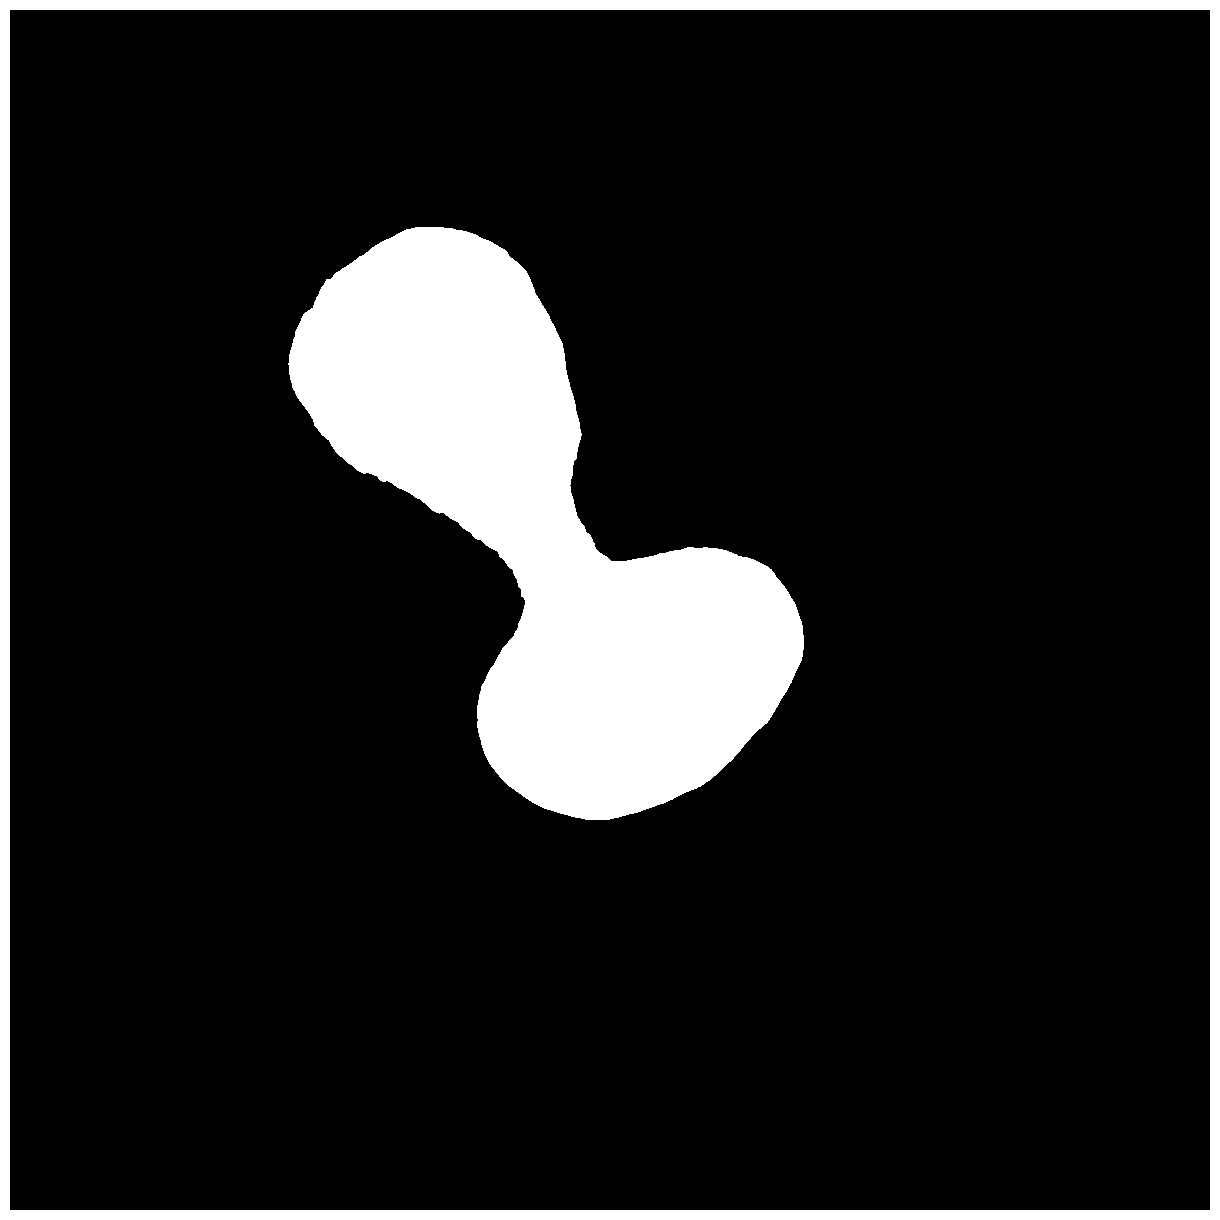

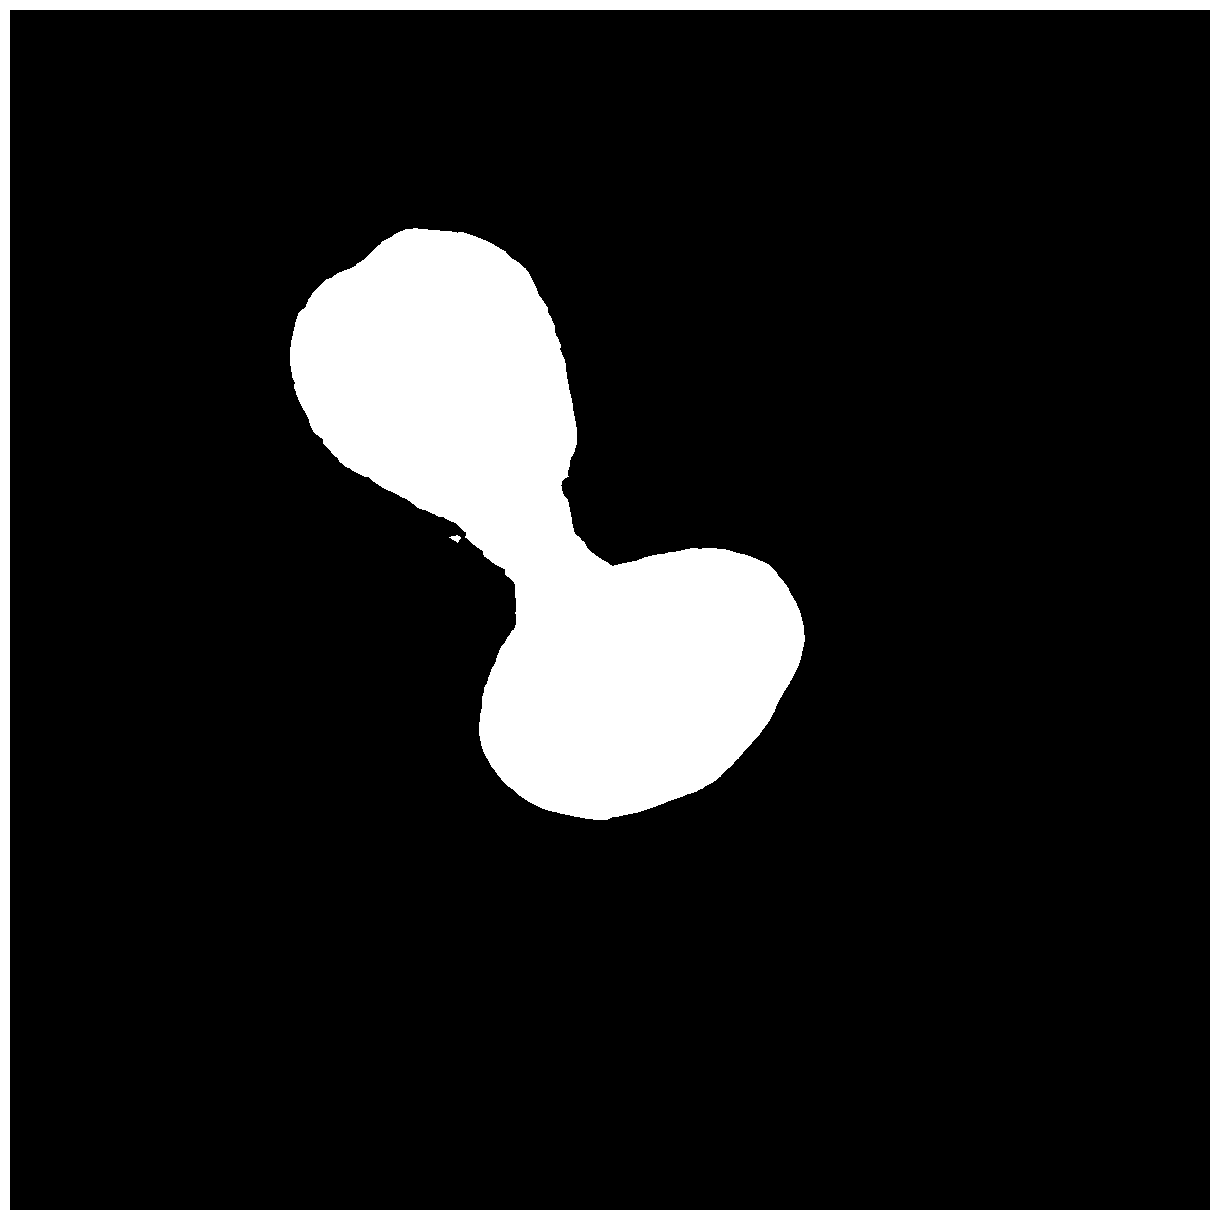

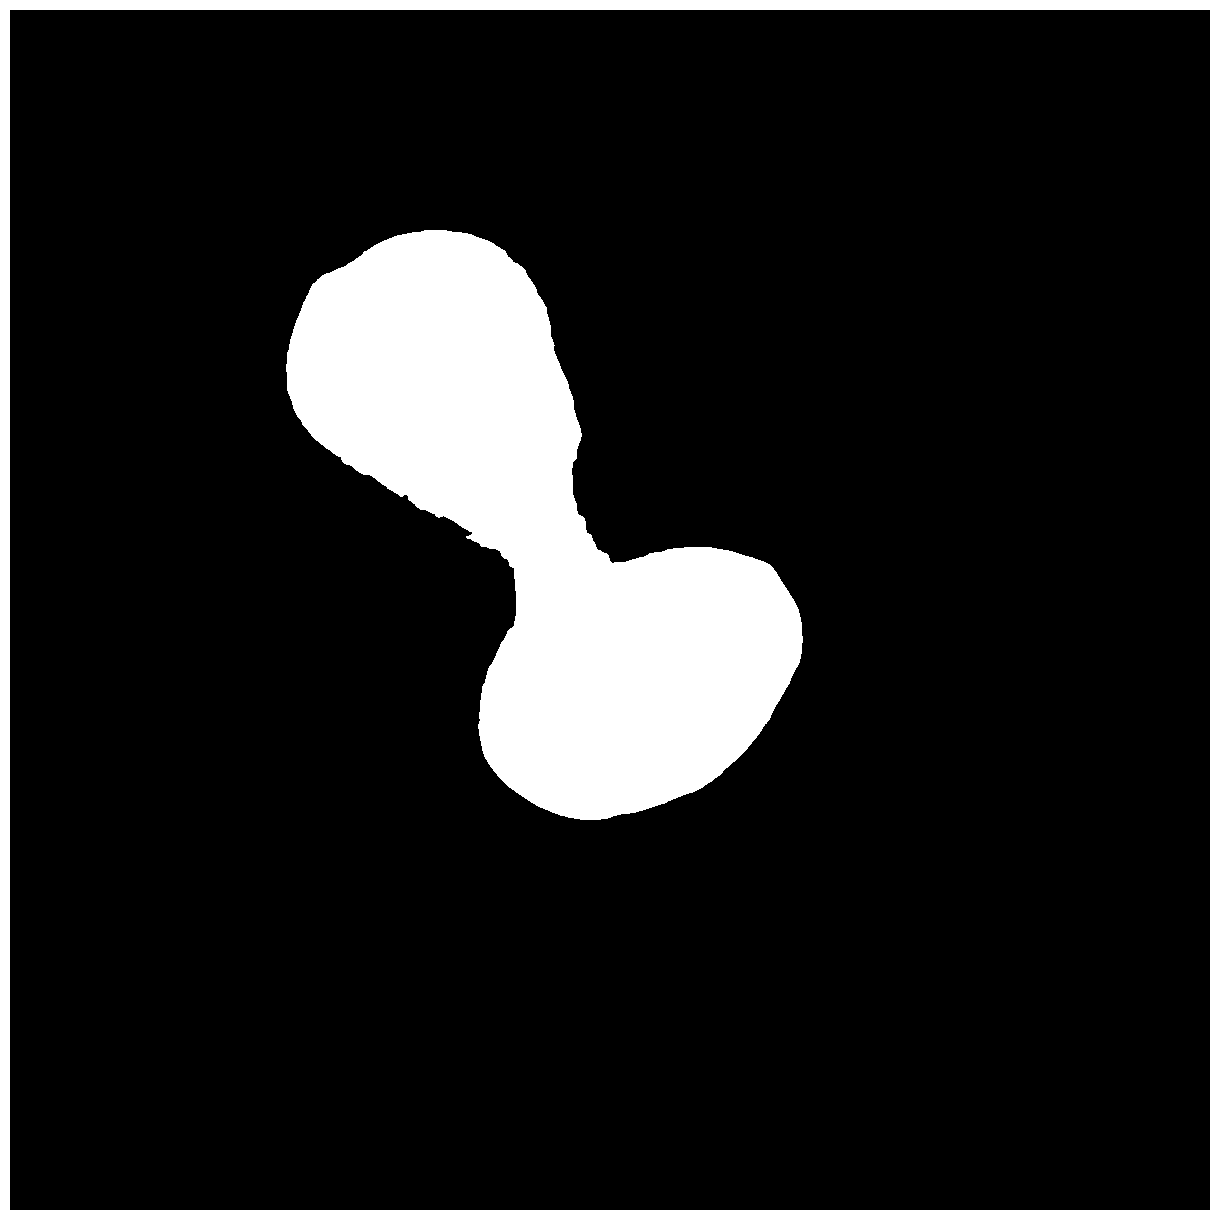

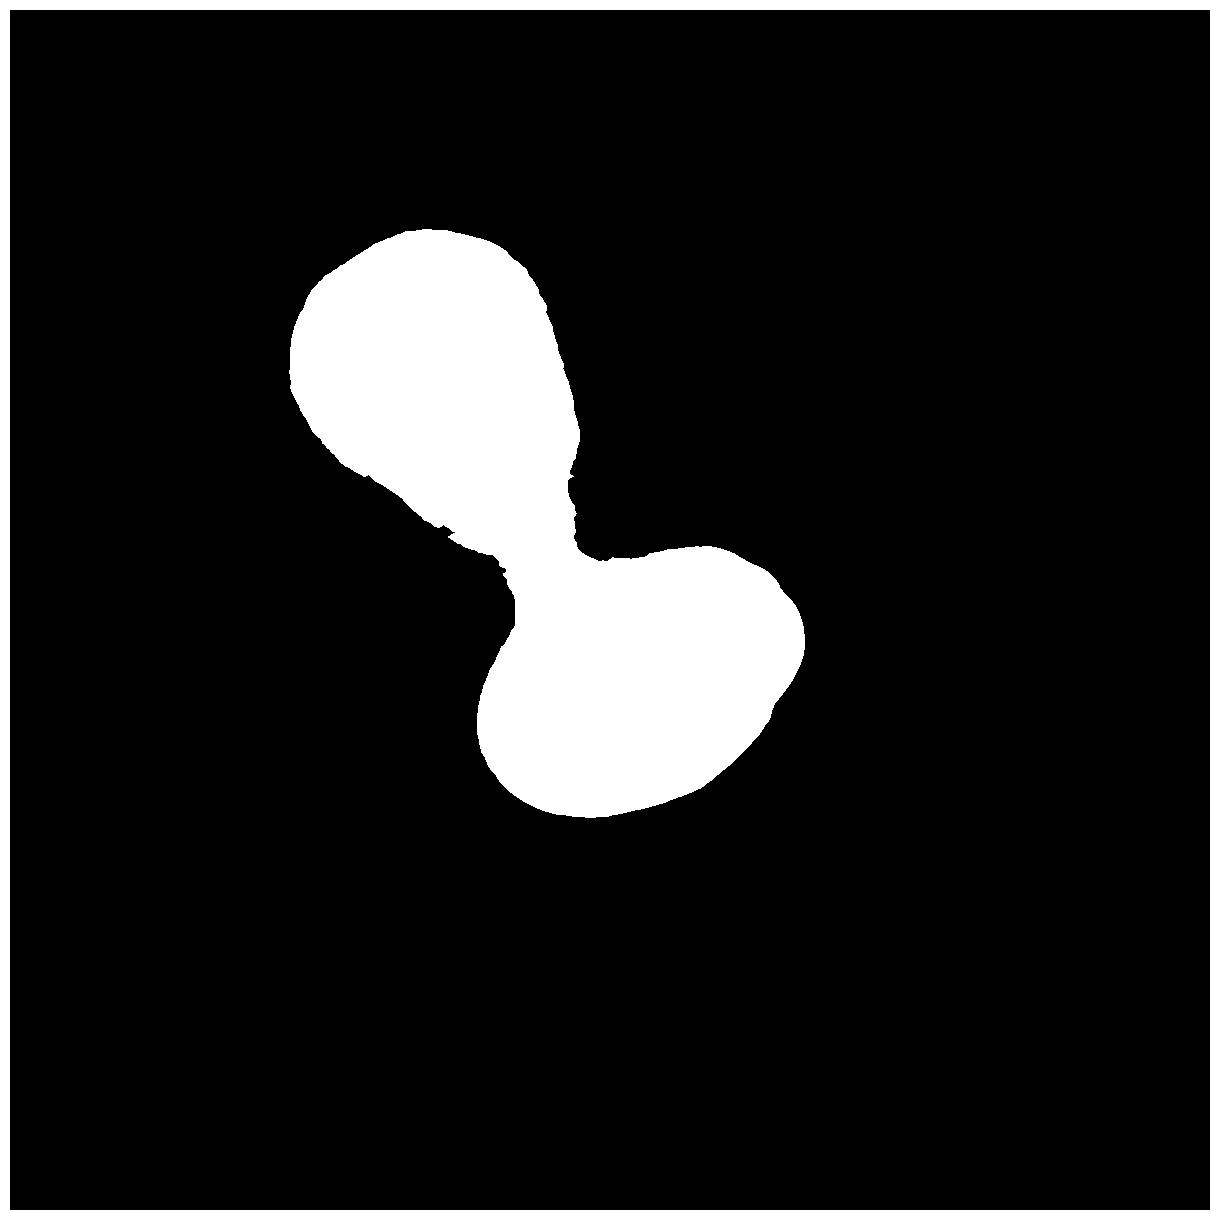

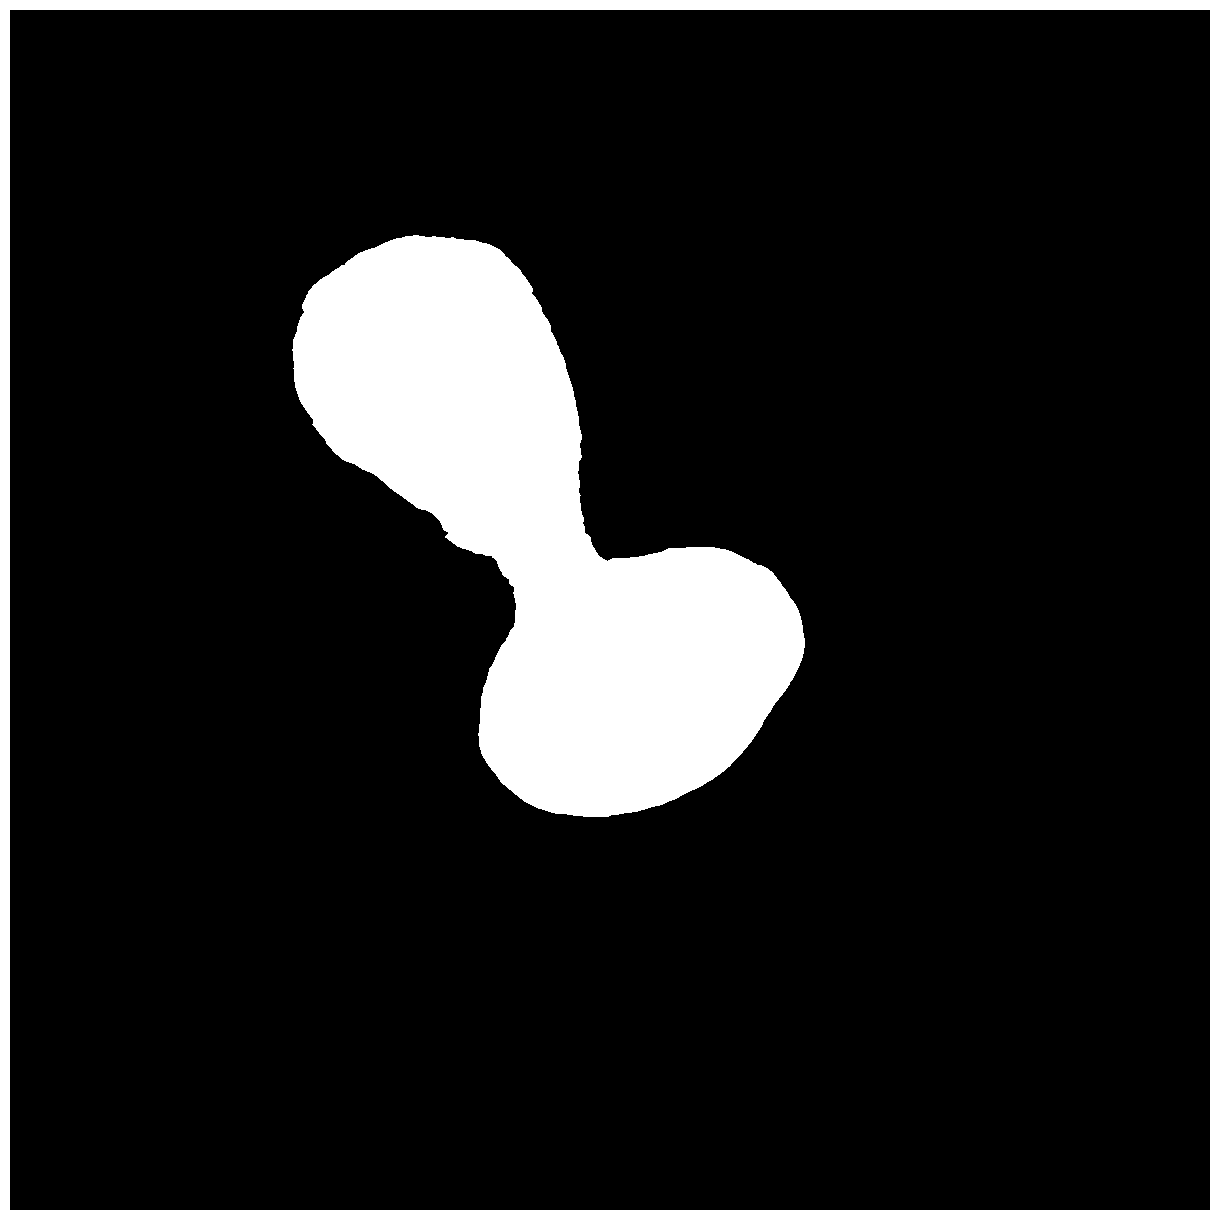

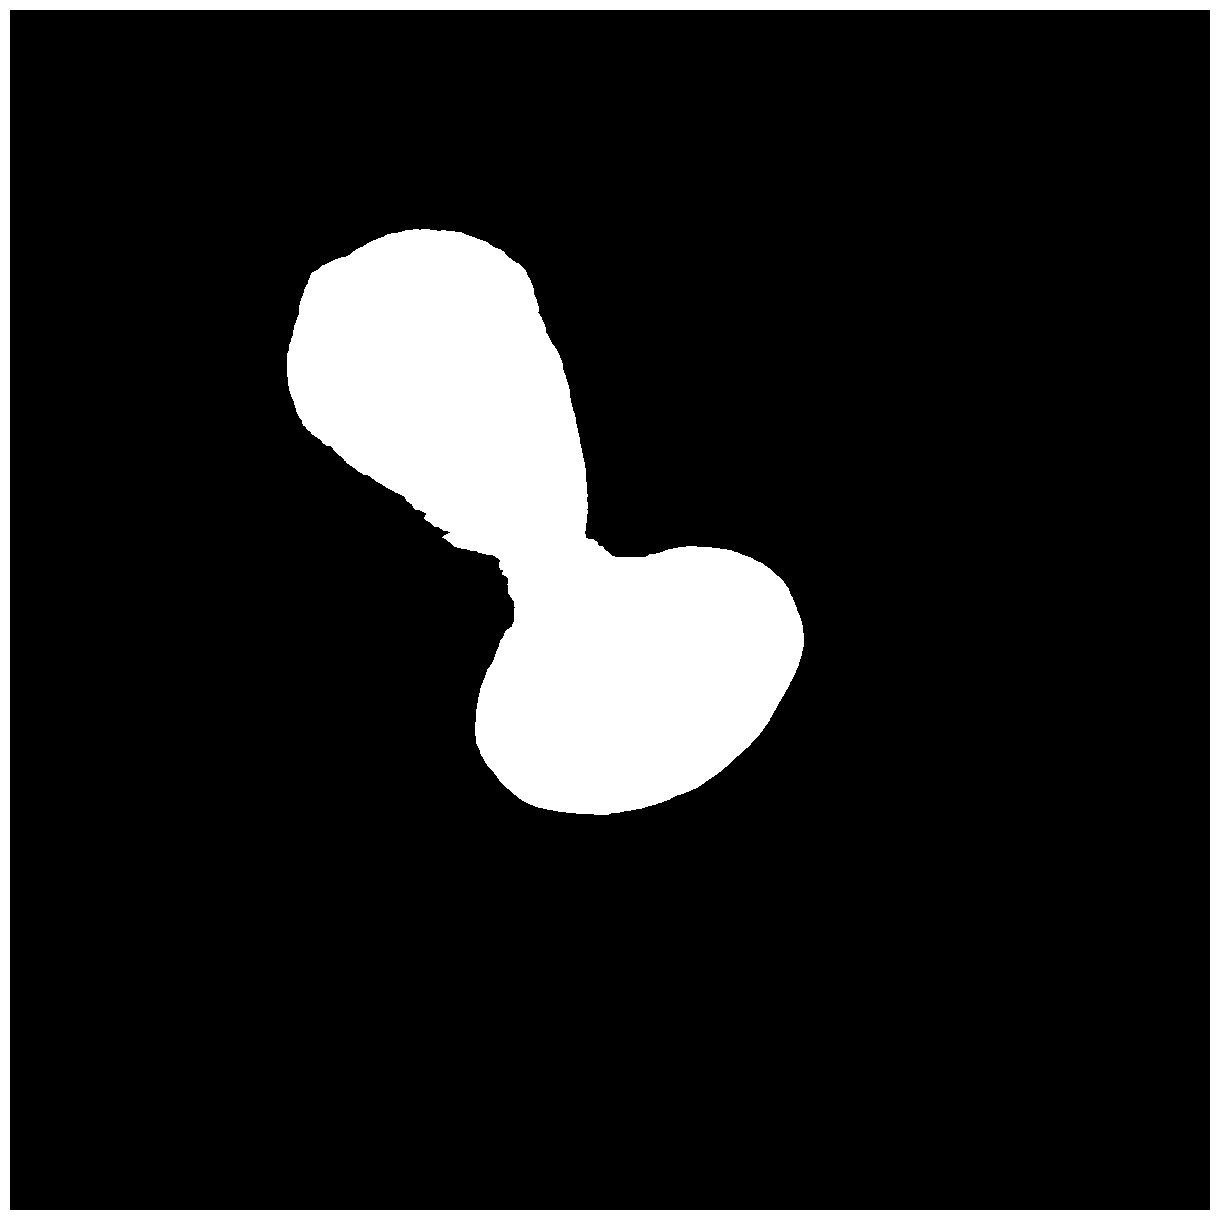

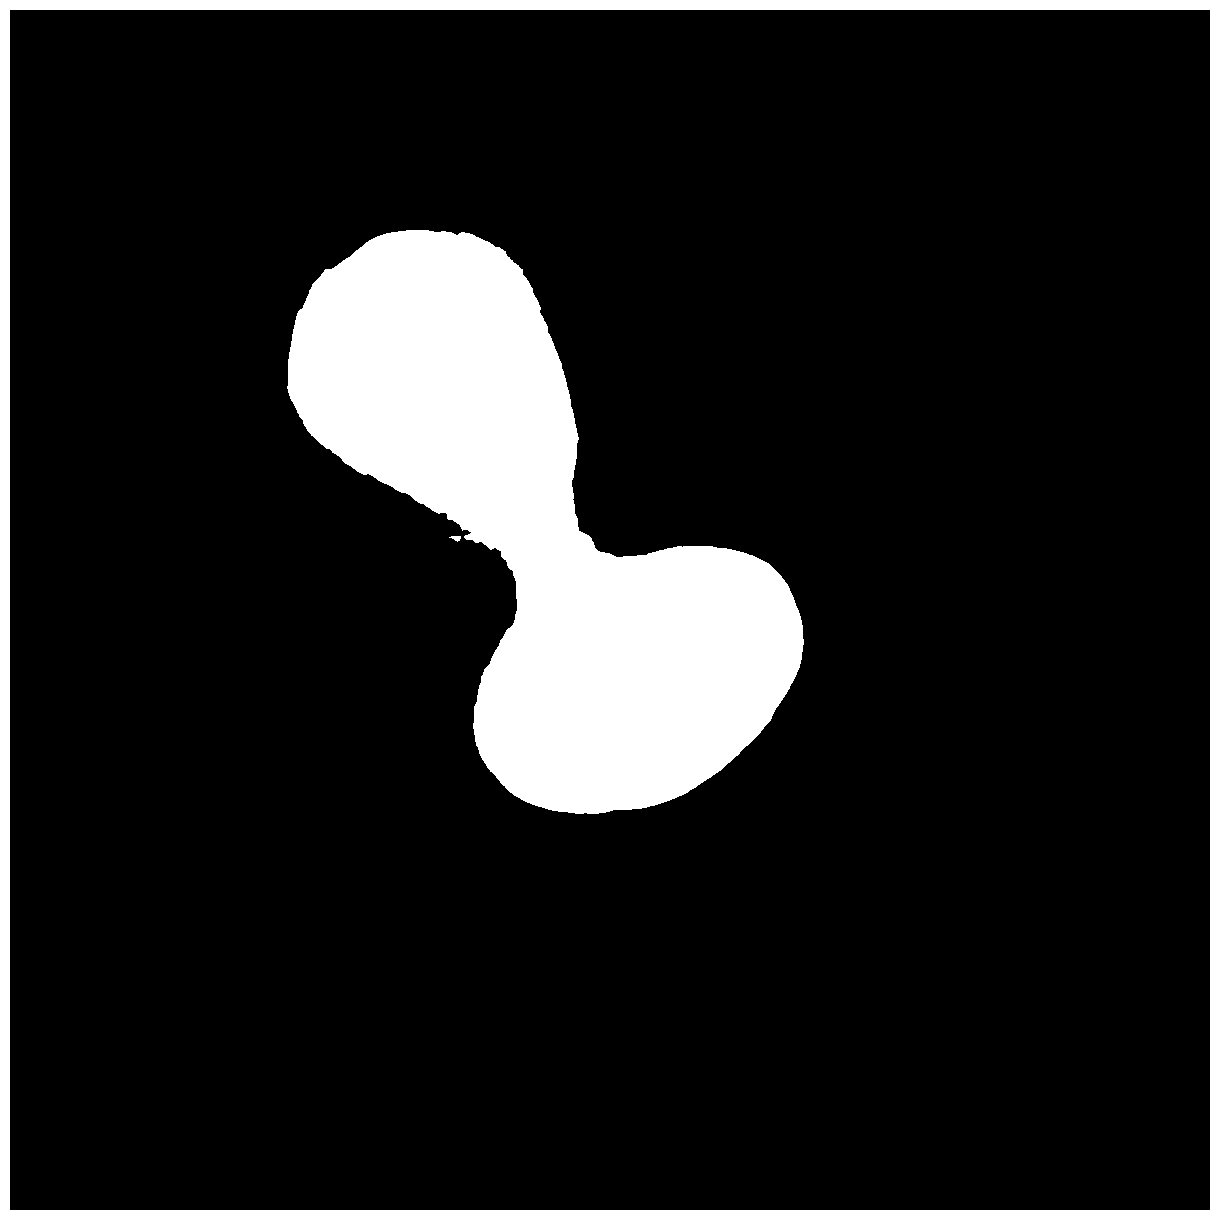

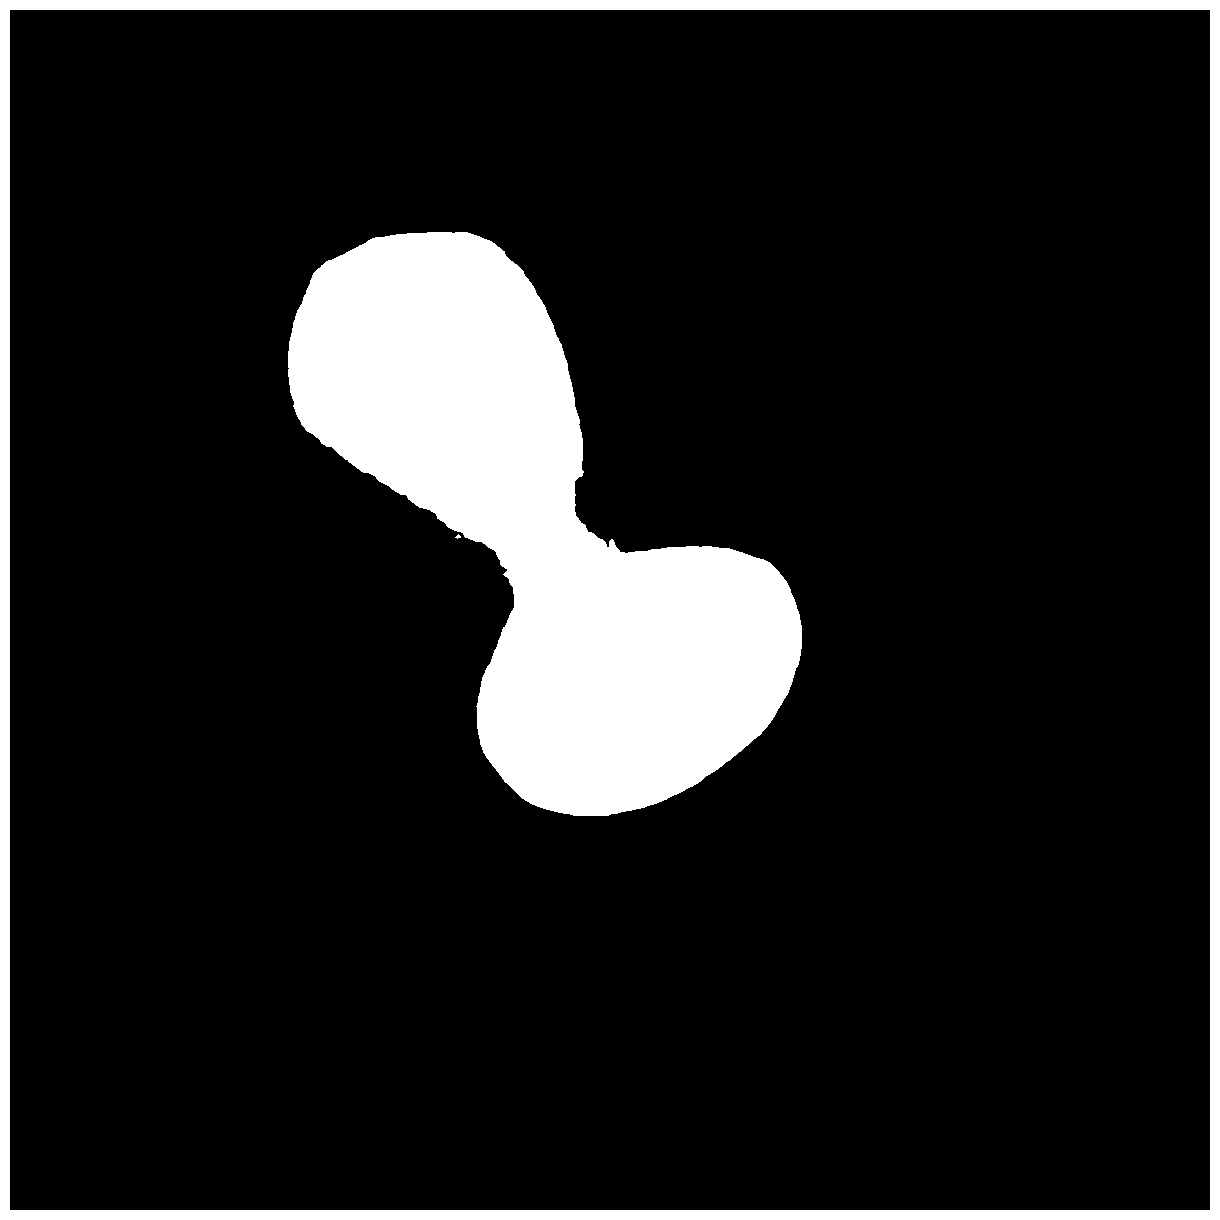

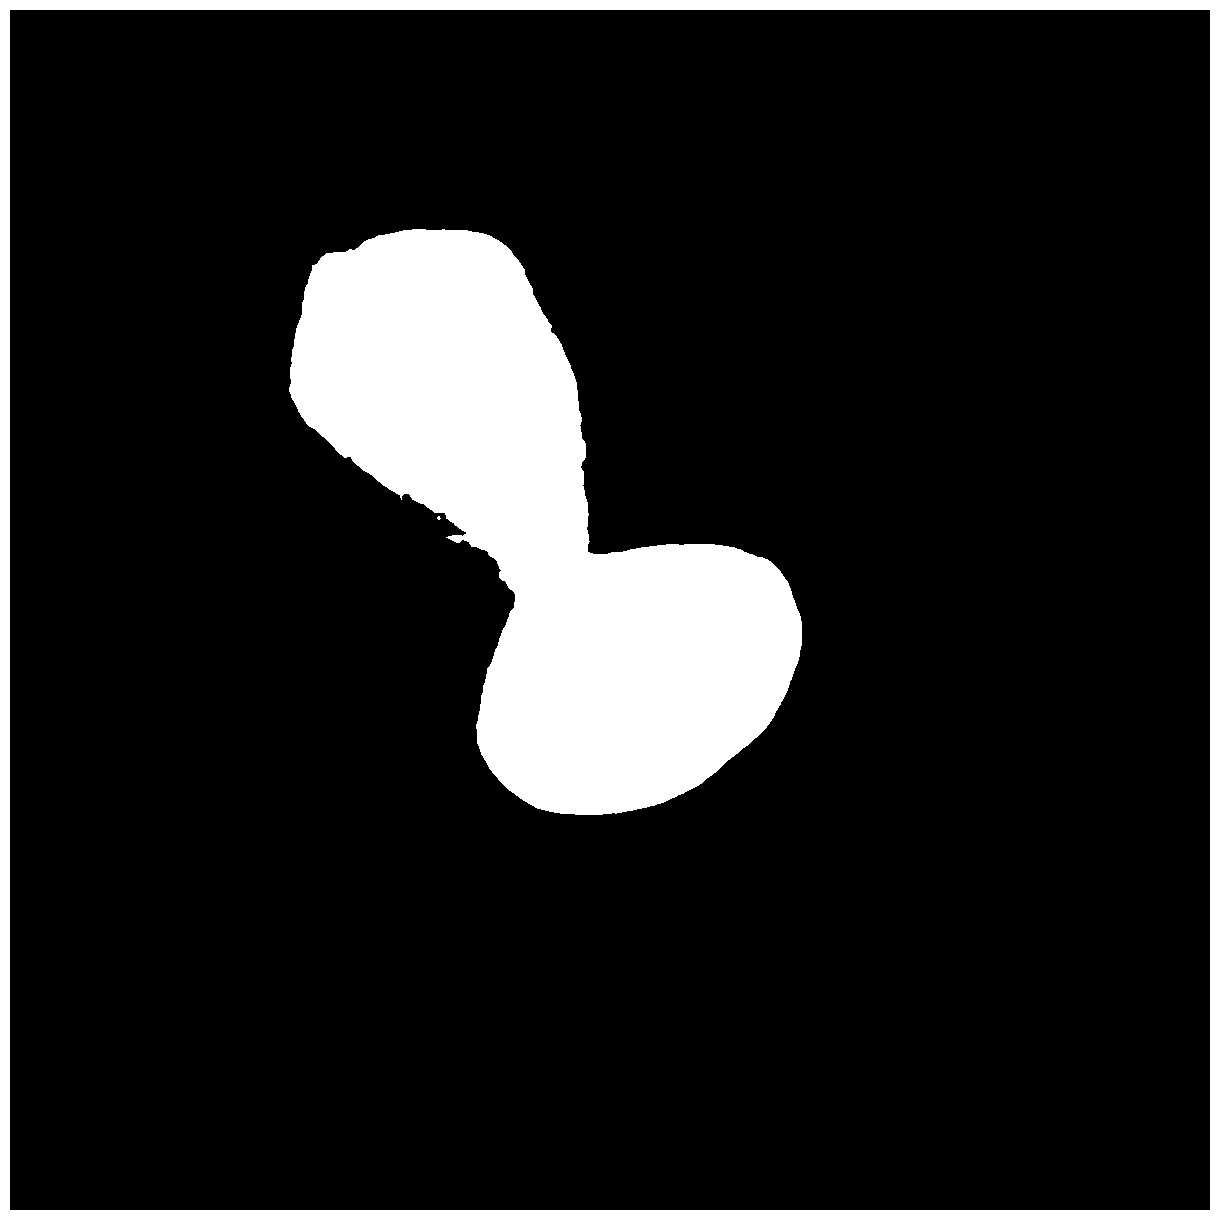

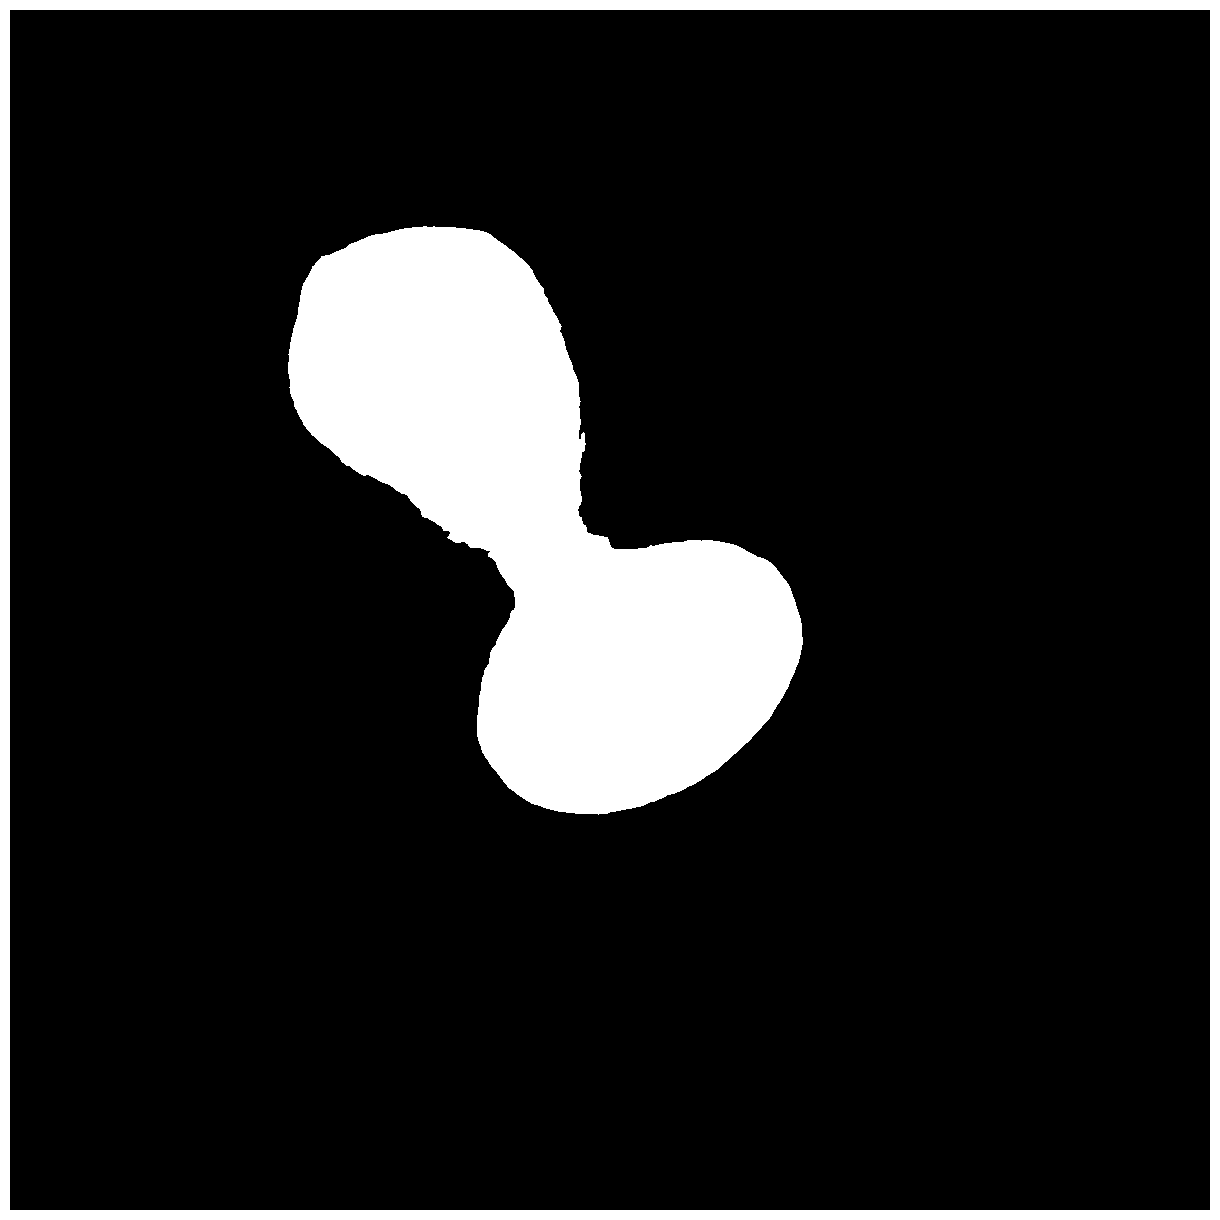

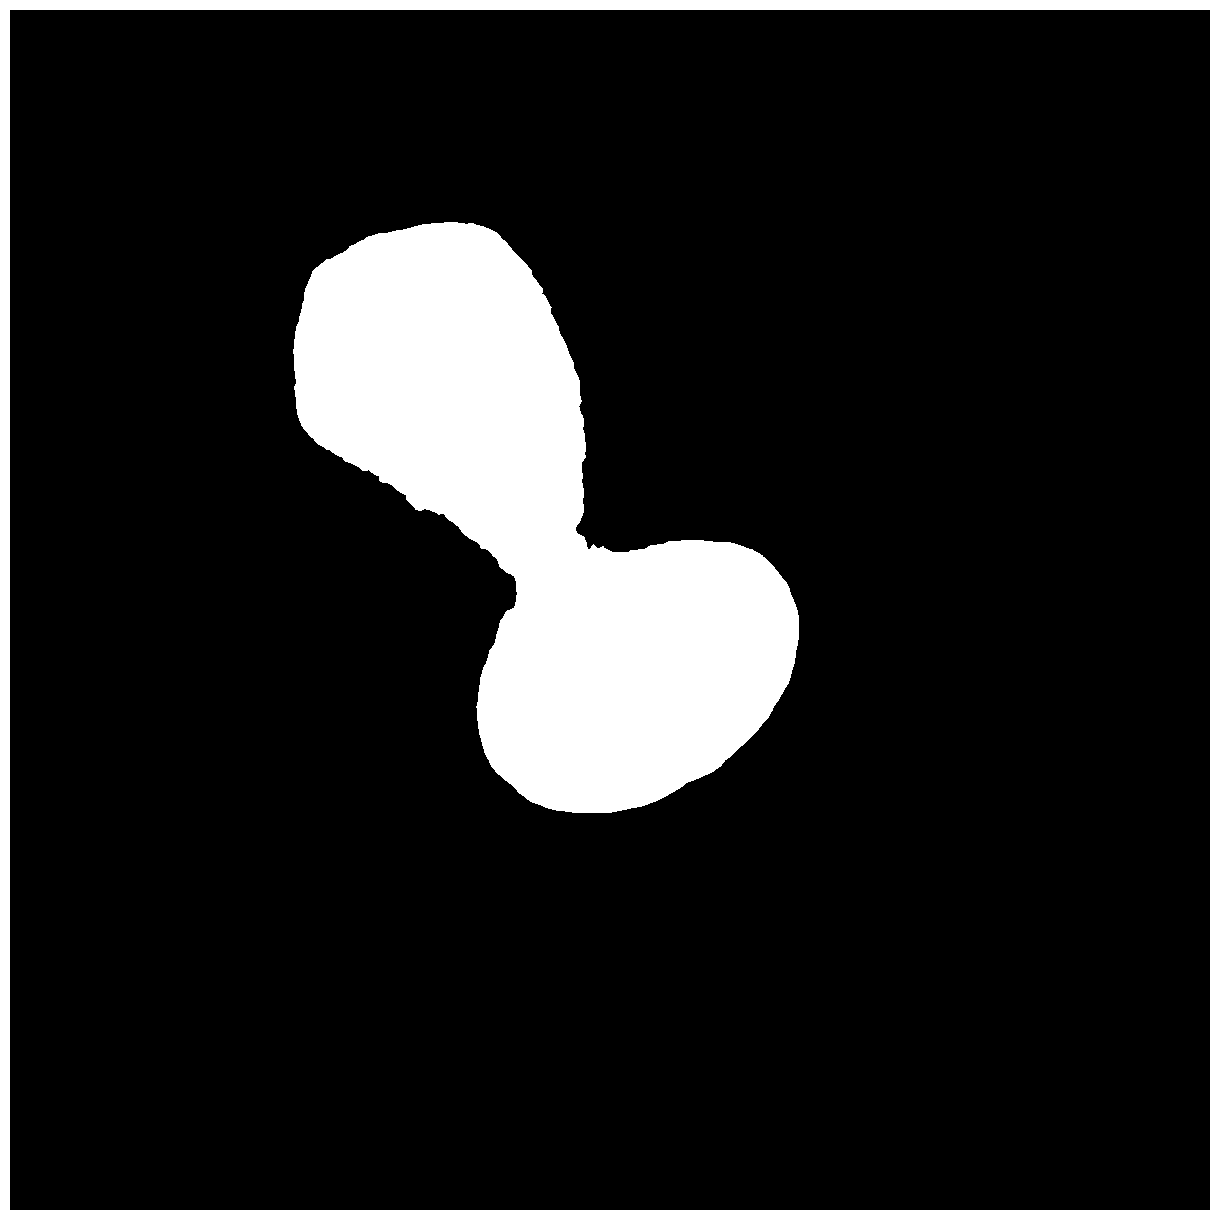

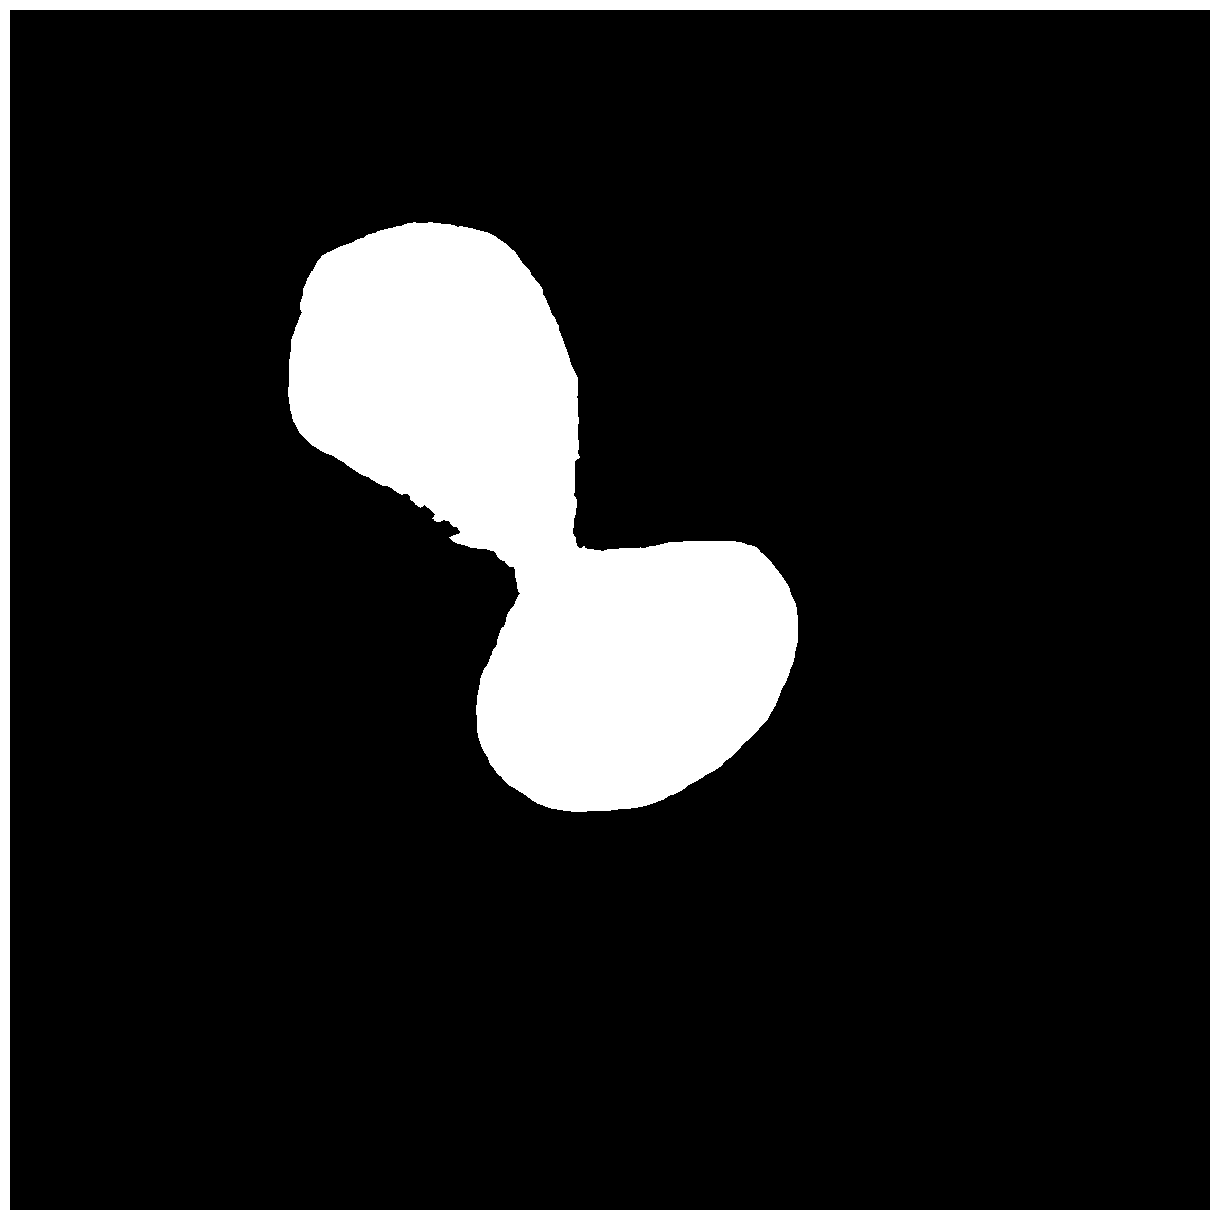

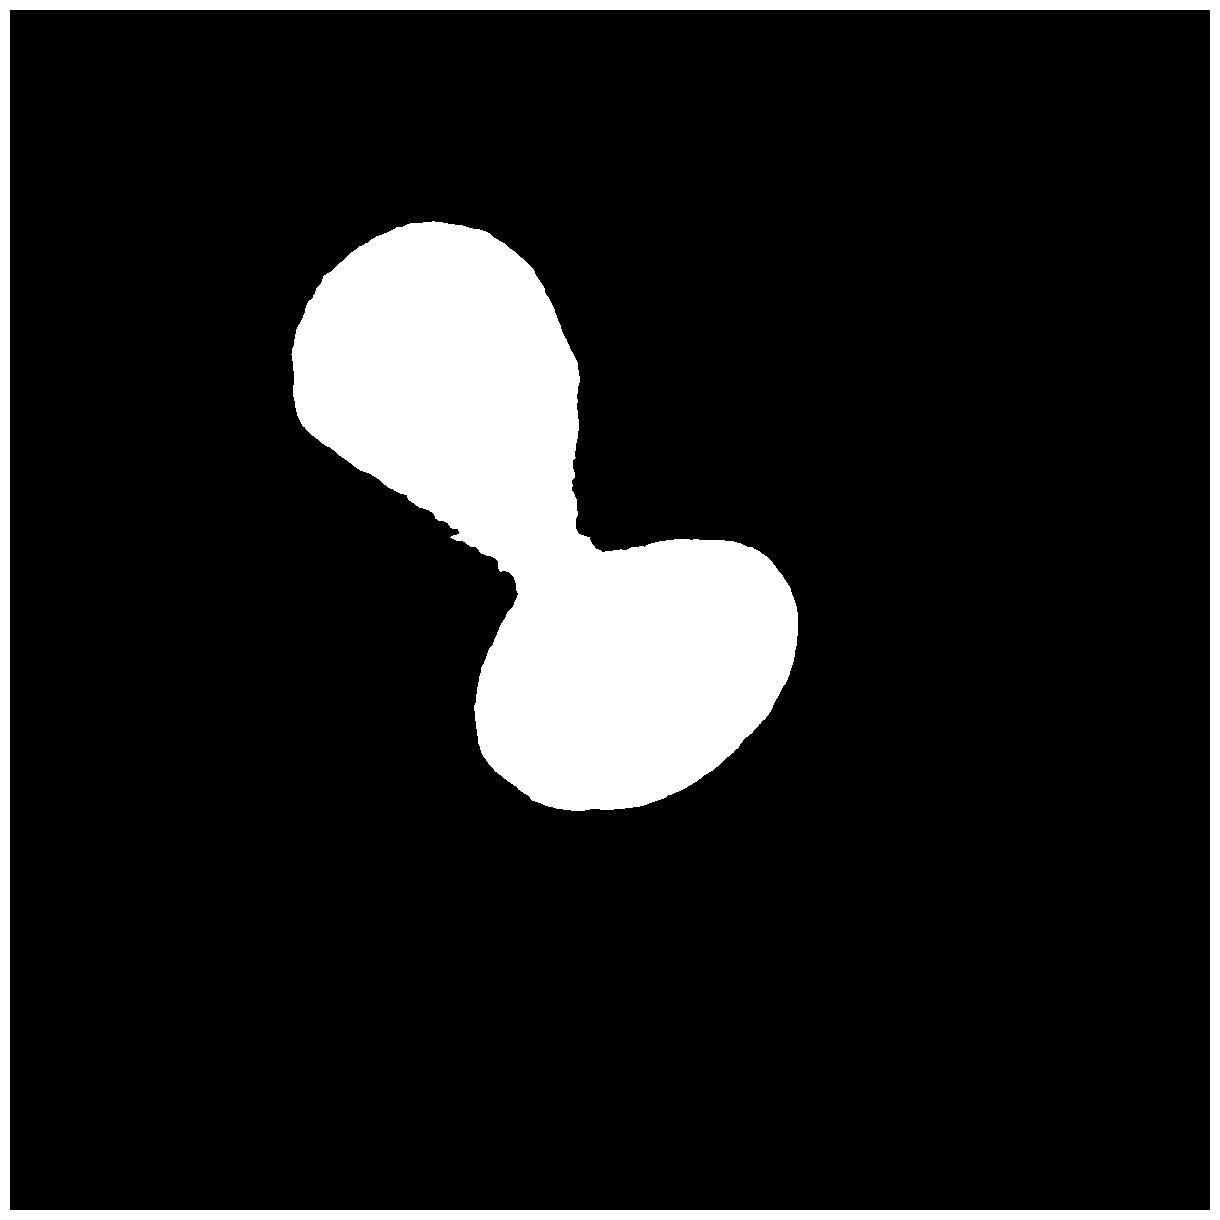

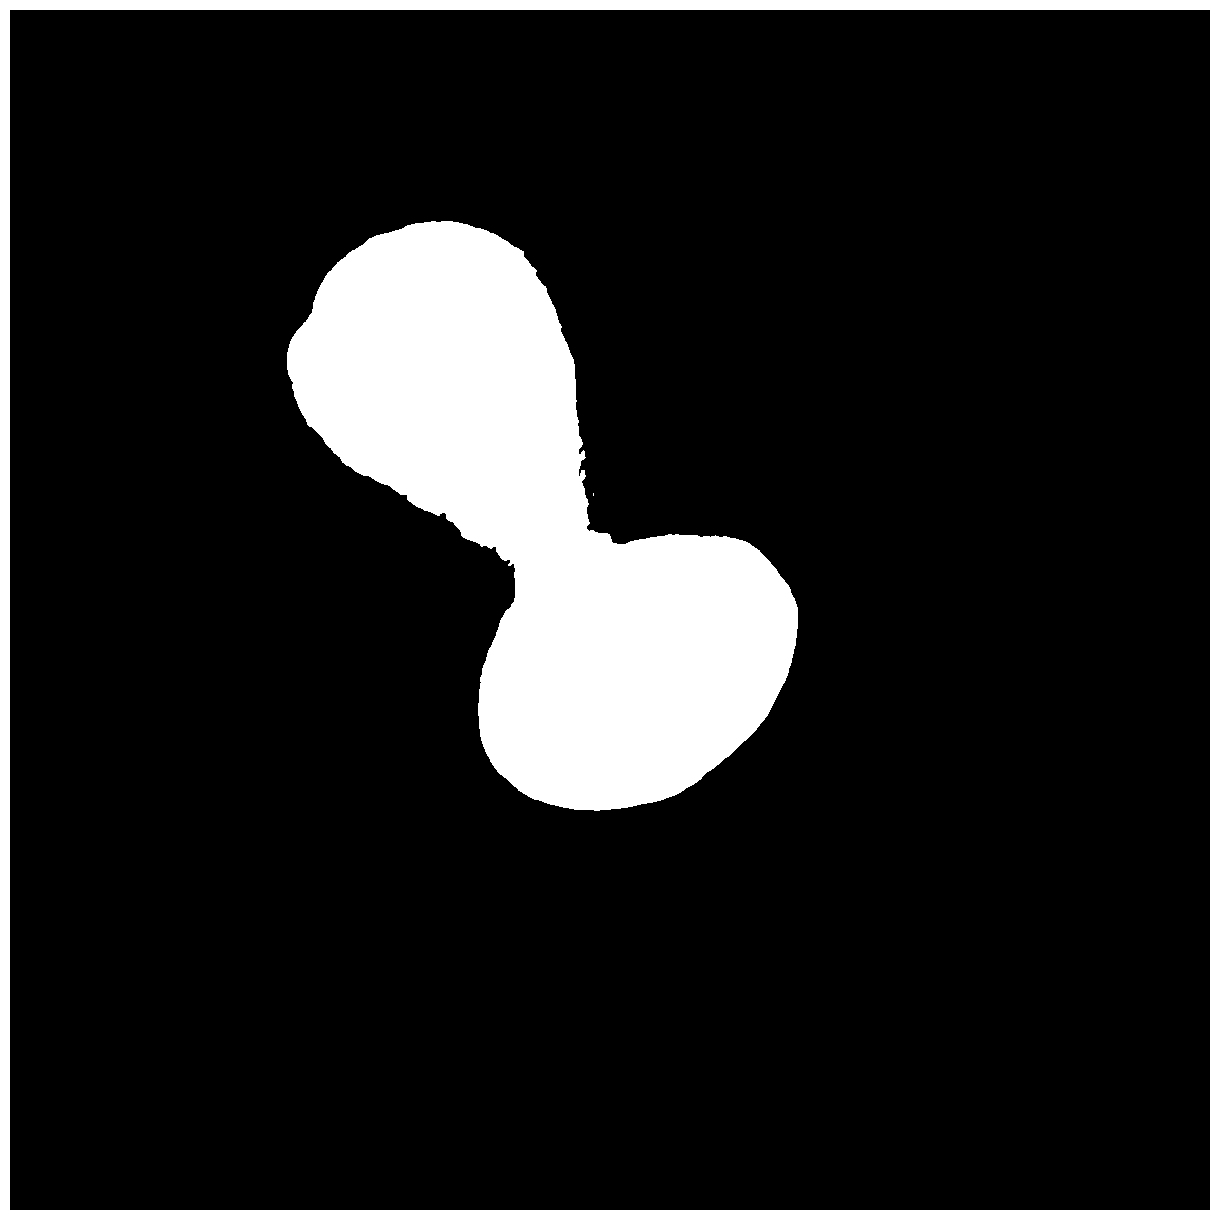

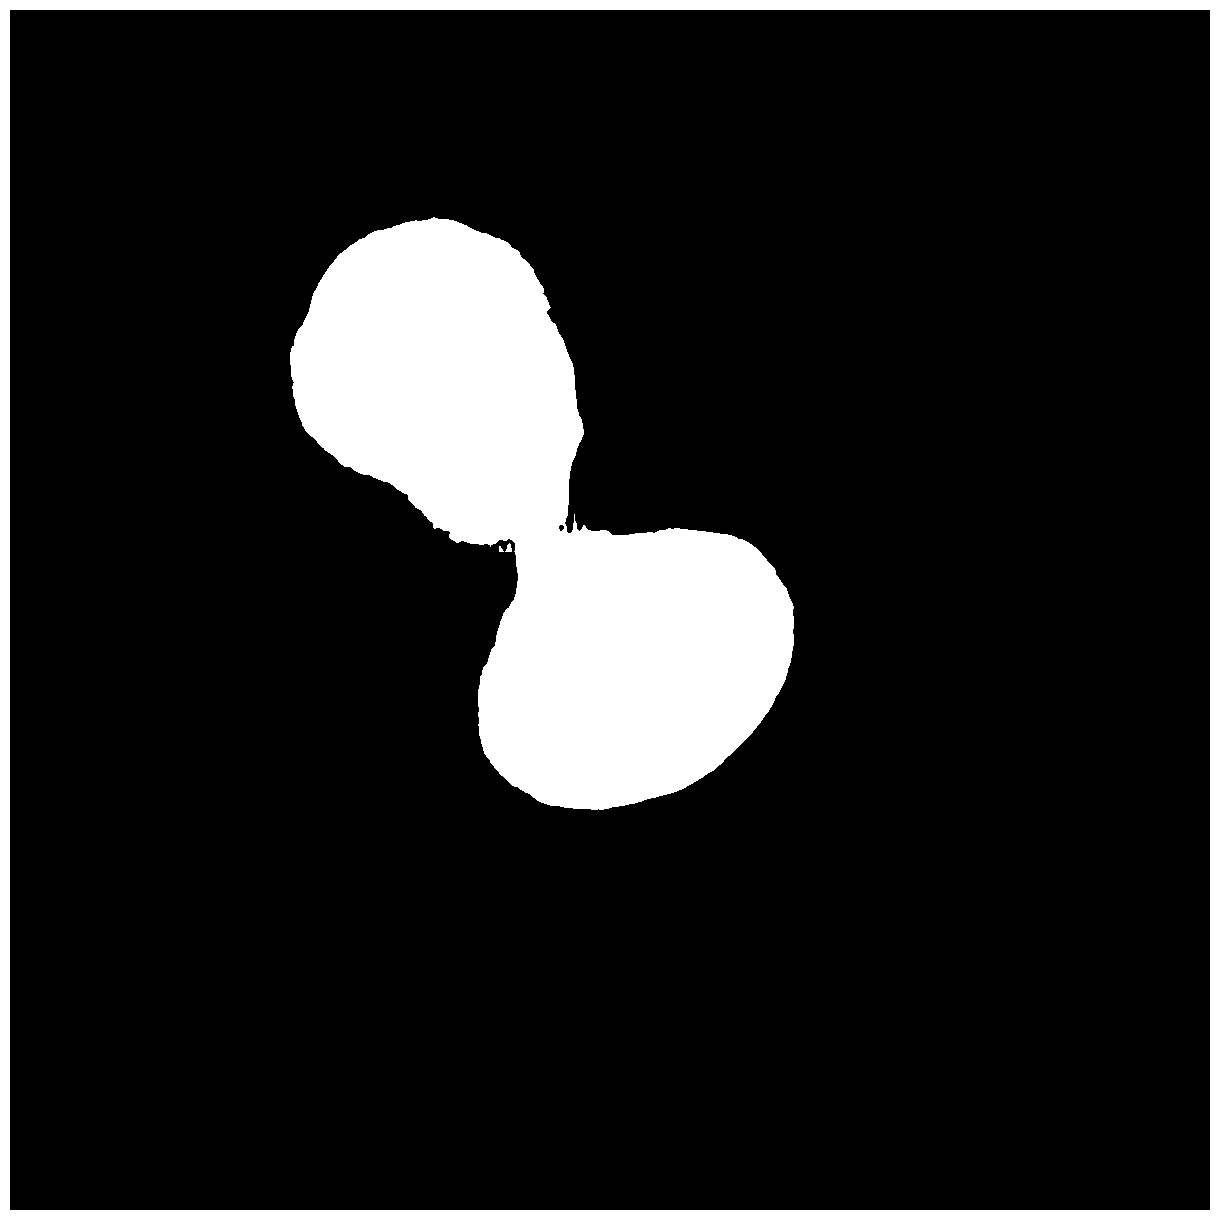

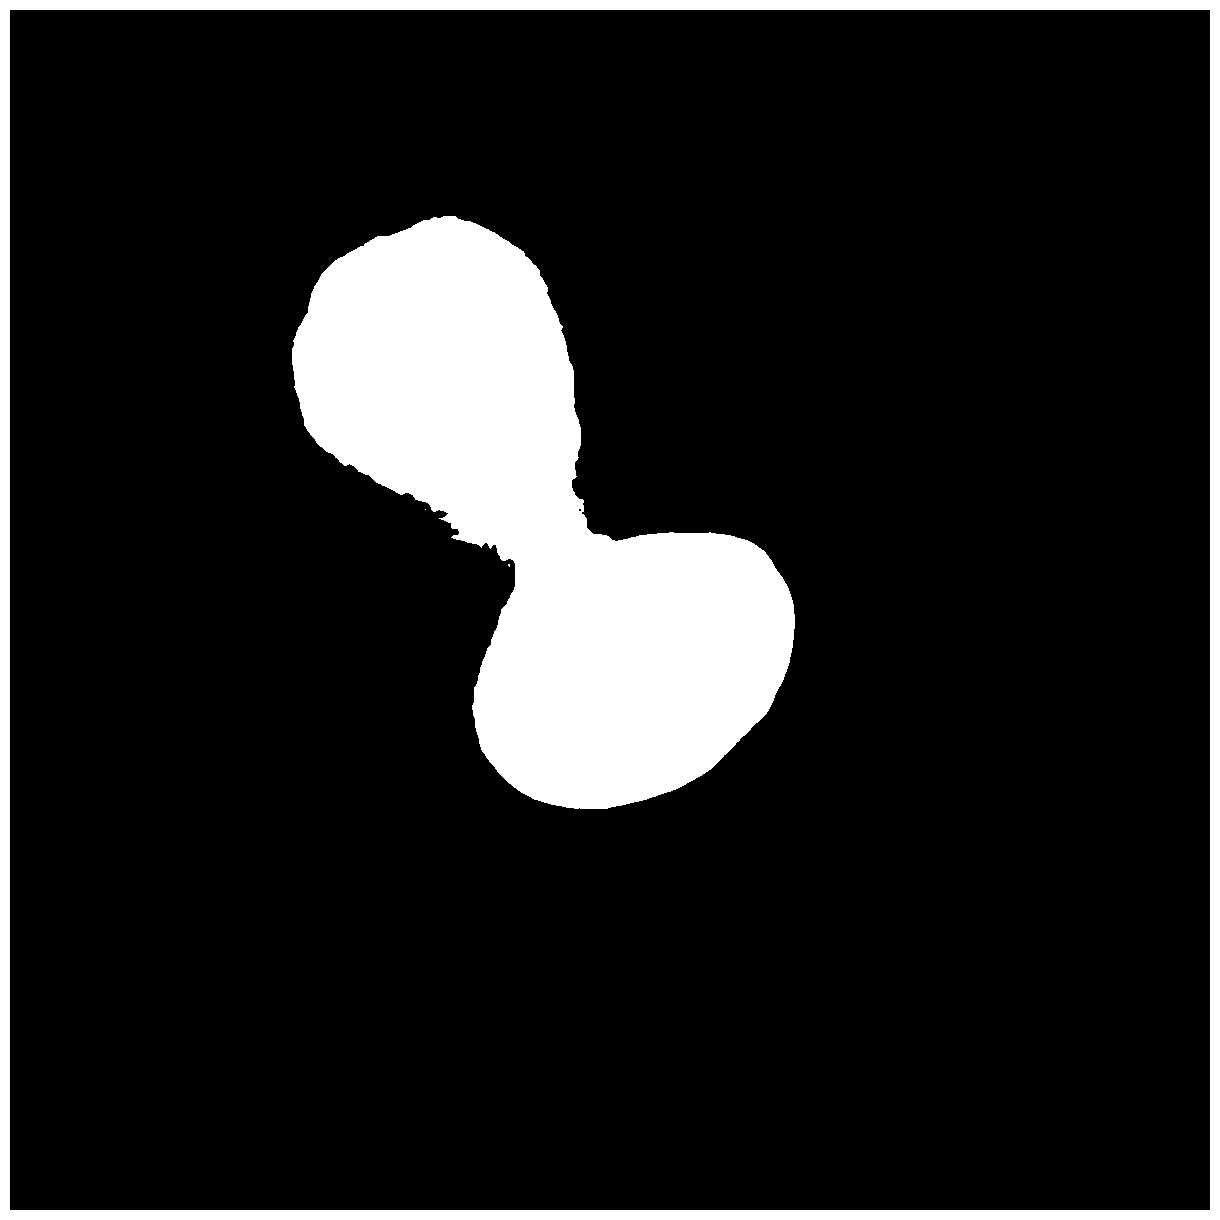

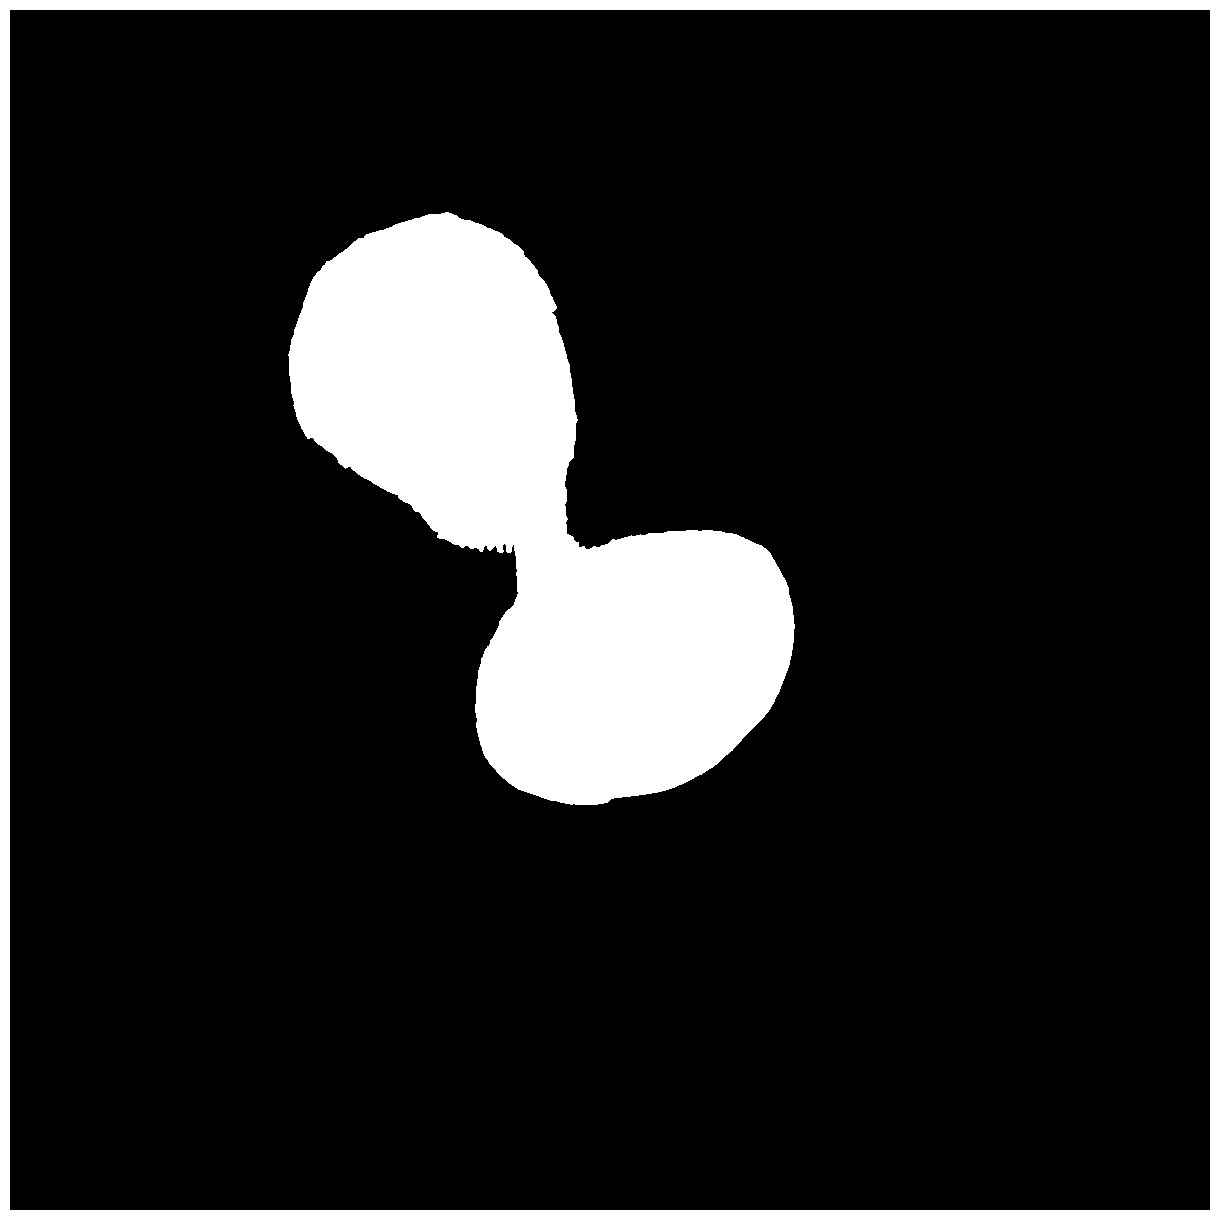

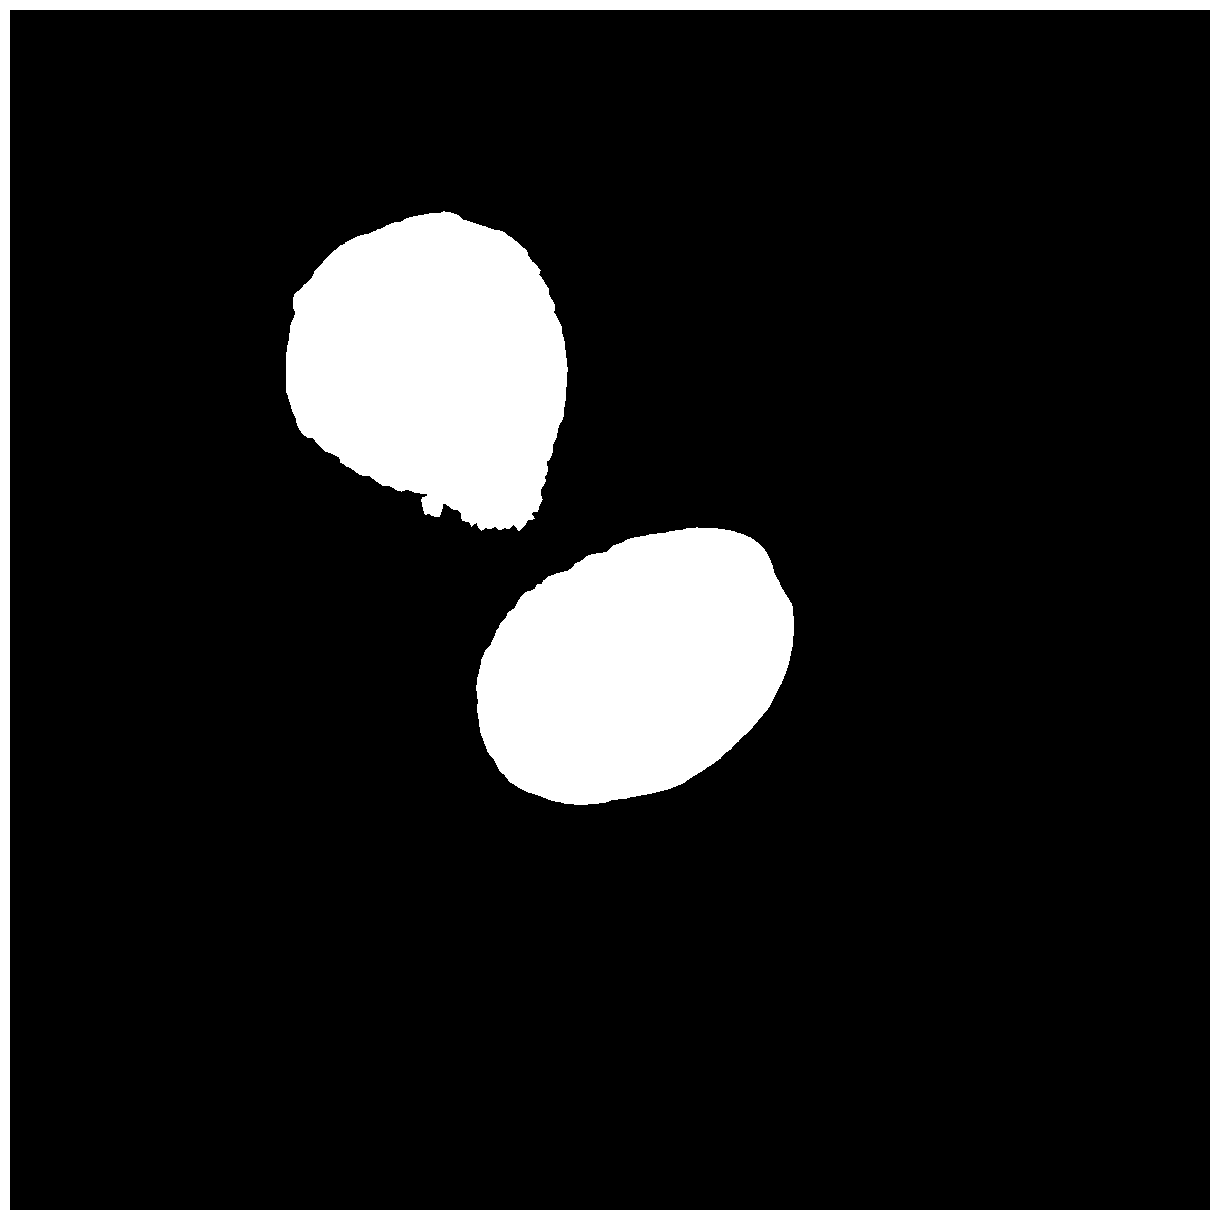

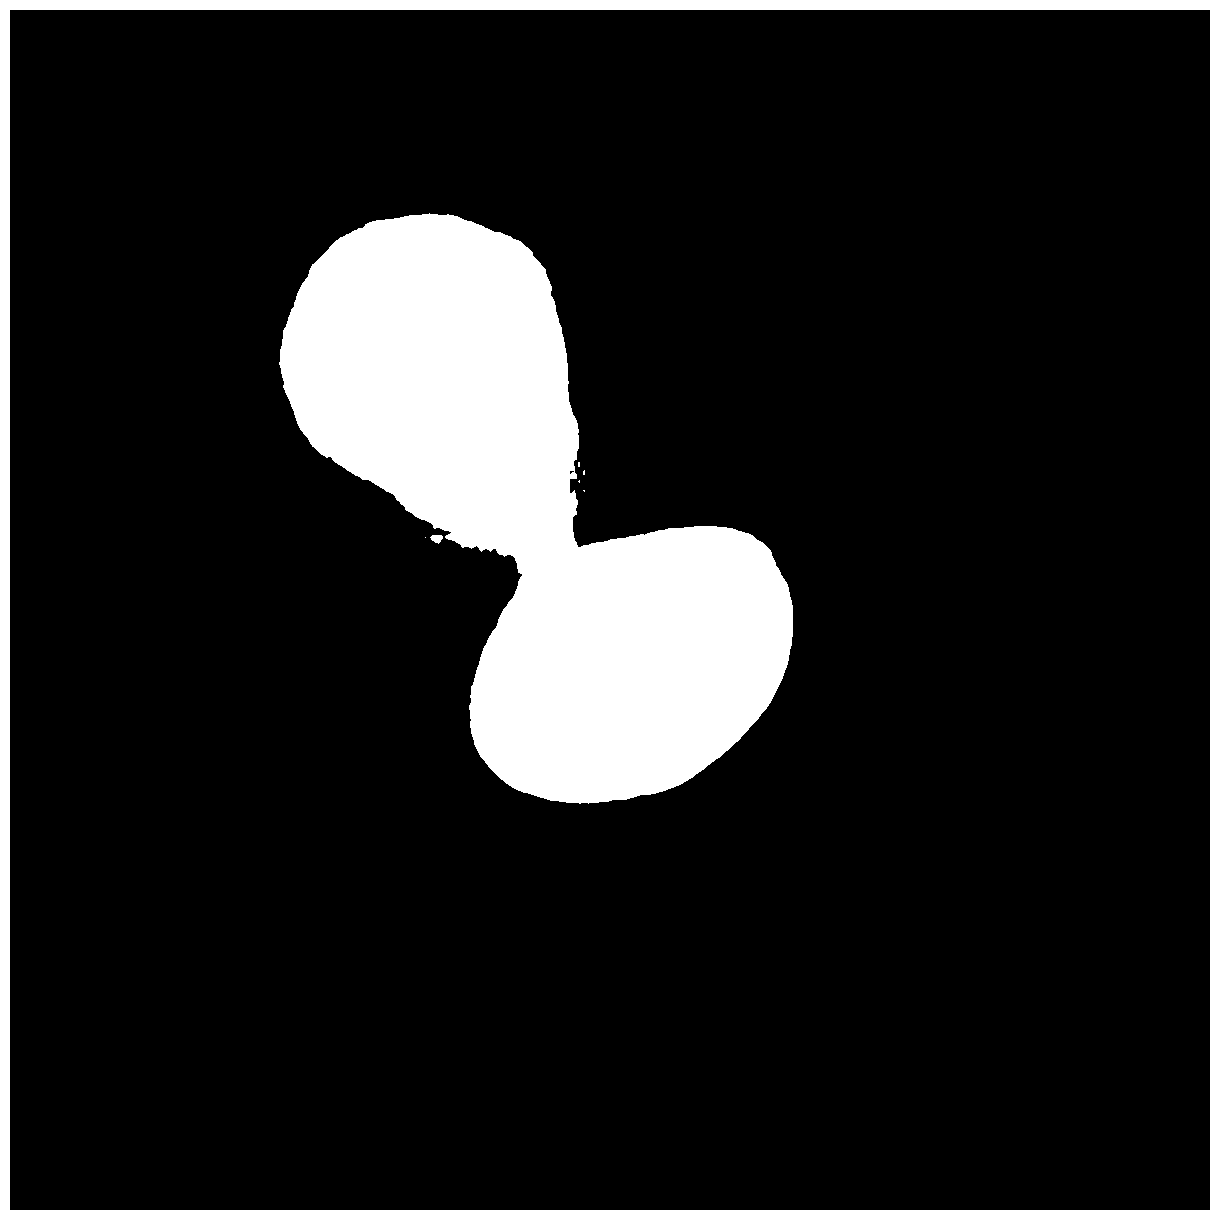

In [24]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    # plt.title(f"frame {out_frame_idx}")
    # plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.gca().set_position([0, 0, 1, 1])
        plt.axis('off')
        plt.savefig(f'{video_dir}/{out_frame_idx}_processed.png', pad_inches=0, bbox_inches='tight')

Output as video

In [25]:
import os
import re
import cv2

# Function to extract the number from the filename, used for sorting
def extract_number(filename):
    match = re.search(r'^(\d+)_processed\.png$', filename)
    return int(match.group(1)) if match else -1

# Extract the base name from the video_dir path
base_name = os.path.basename(os.path.dirname(video_dir))  # This will extract 'E10.5-anterior-late-dt10-aphidicolin-20240529-6-crop'

fps = 30  # Set frames per second for the video

# Get a sorted list of files based on the numeric part of filenames
image_files = sorted(
    [f for f in os.listdir(video_dir) if re.match(r'^\d+_processed\.png$', f)],
    key=extract_number
)

# Check if there are any image files to process
if len(image_files) == 0:
    raise ValueError("No processed frames found in the video_dir!")

# Initialize video writer
output_dir = os.path.dirname(video_dir)  # Get the parent directory of 'frames'
video_filename = os.path.join(output_dir, f'{base_name}_after_seg_output.avi')  # Save the video in the parent directory

frame = cv2.imread(os.path.join(video_dir, image_files[0]))

# Get the frame dimensions (height, width, layers)
height, width, layers = frame.shape

# Initialize VideoWriter object with MJPG codec and the specified frame dimensions
video = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))

# Write each processed frame to the video
for image_file in image_files:
    frame = cv2.imread(os.path.join(video_dir, image_file))
    if frame is None:
        print(f"Warning: Unable to read {image_file}. Skipping.")
        continue
    video.write(frame)

# Release the video writer
video.release()
print(f"Video has been successfully saved as {video_filename}")



Video has been successfully saved as example_case/example_case_after_seg_output.avi
